In [ ]:
from pipeline import Pipeline
from pipeline.steps import *

xgb_params = {
    "colsample_bylevel": 0.4778015829774066,
    "colsample_bynode": 0.362764358742407,
    "colsample_bytree": 0.7107423488010493,
    "gamma": 1.7094857725240398,
    "learning_rate": 0.02213323588455387,
    "max_depth": 20,
    "max_leaves": 512,
    "min_child_weight": 16,
    "n_estimators": 1667,
    "n_jobs": -1,
    "random_state": 42,
    "reg_alpha": 39.352415706891264,
    "reg_lambda": 75.44843704068275,
    "subsample": 0.06566669853471274,
    "verbose": 0,
}

class FeatureEngineeringProductCatInteractionStep(PipelineStep):

    def __init__(self, cat="cat1", name: Optional[str] = None, tn="tn"):
        super().__init__(name)
        self.cat = cat
        self.tn = tn


    def execute(self, df, df_original=None) -> None:
        # agrupo el dataframe por cat1 (sumando), obteniendo fecha, cat1 y
        # luego paso el dataframe a wide format, donde cada columna es una categoria  y la fila es la suma de tn para cada cat1
        # luego mergeo al dataframe original por fecha y product_id
        df_index = df.index
        if df_original is None:
            df_to_proces = df
        else:
            df_to_proces = df_original
        df_cat = df_to_proces.groupby(["date_id", self.cat]).agg({self.tn: "sum"}).reset_index()
        print(df_cat)
        # cast column self.cat to string
        df_cat[self.cat] = df_cat[self.cat].astype(str)
        df_cat = df_cat.pivot(index="date_id", columns=self.cat, values=self.tn).reset_index()
        # paso a string los nombres de las columnas
        df_cat.columns = [f"{self.tn}_{self.cat}_{col}" if col != "date_id" else "date_id" for col in df_cat.columns]
        df = df.merge(df_cat, on="date_id", how="left")
        # vuelvo a setear el indice original
        df.index = df_index
        return {"df": df}
    

import numpy as np
class Log1pTranformation(PipelineStep):
    def execute(self, df):
        df["tn"] = df["tn"].apply(lambda x: np.log1p(x) if x >= 0 else 0)
        return {"df": df}
    
class InverseLog1pTranformation(PipelineStep):
    def execute(self, df, predictions, y_test):
        df["target"] = df["target"].apply(lambda x: np.expm1(x) if x >= 0 else 0)
        predictions = predictions.apply(lambda x: np.expm1(x) if x >= 0 else 0)
        y_test["target"] = y_test["target"].apply(lambda x: np.expm1(x) if x >= 0 else 0)
        return {"df": df, "predictions": predictions, "y_test": y_test}

class GroupByProductStep(PipelineStep):
    def execute(self, df) -> None:
        # Agrupo el dataframe por product_id y fecha, sumando las cantidades
        df = df.groupby(["product_id", "fecha"]).agg({
            'cust_request_qty': 'sum',
            'cust_request_tn': 'sum',
            'tn': 'sum',
            'stock_final': 'max',
            'cat1': 'first',
            'cat2': 'first',
            'cat3': 'first',
            'brand': 'first',
            'sku_size': 'max',
        }).reset_index()
        # le dejo la columna customer_id = 0 para que no crashee el resto
        df['customer_id'] = 1
        return {"df": df}

class FilterDatasetByColumn(PipelineStep):
    def __init__(self, column: str, value, name: Optional[str] = None):
        super().__init__(name)
        self.column = column
        self.value = value
        
    def execute(self, df) -> None:
        # Filtra el DataFrame por el valor de la columna especificada
        df_original = df.copy()
        df_filtered = df[df[self.column] == self.value]
        print(df_filtered.shape)
        return {"df": df_filtered, "df_original": df_original}

class DeleteBadColumns(PipelineStep):
    def execute(self, df) -> None:
        # Elimina  las columnas donde toda sus filas son NaN
        base_columns = df.columns
        df = df.dropna(axis=1, how='all')
        df = df.loc[:, (df != 0).any(axis=0)]
        deleted_columns = set(base_columns) - set(df.columns)
        print(f"Deleted columns: {deleted_columns}")
        return {"df": df}

class CreateResidualTargetStep(PipelineStep):
    def __init__(self, name: Optional[str] = None, target_col: str = 'tn', window: int = 12, min_periods = None):
        super().__init__(name)
        self.target_col = target_col
        self.window = window
        self.min_periods = min_periods or window

    def execute(self, df: pd.DataFrame) -> Dict:
        df = df.sort_values(['product_id', 'customer_id', 'fecha']).copy()

        # Valor futuro (shift -2) que será la predicción final
        df['target_shifted'] = df.groupby(['product_id', 'customer_id'])[self.target_col].shift(-2)

        # Cálculo del valor base usando la media rolling pasada
        df['base_prediction'] = (
            df.groupby(['product_id', 'customer_id'])[self.target_col]
            .transform(lambda x: x.rolling(self.window, min_periods=self.min_periods).mean())
        )

        # Target: residuo a predecir
        df['target'] = np.log((df['target_shifted']+0.5) / (df['base_prediction']+0.5))
        df.drop(columns=['target_shifted', 'base_prediction'], inplace=True, errors='ignore')

        return {
            "df": df,
            "target_col": self.target_col,
        }


class InverseResidualTargetStep(PipelineStep):
    def __init__(
        self,
        name: Optional[str] = None,
        target_col: str = 'tn',
        window: int = 12
    ):
        super().__init__(name)
        self.target_col = target_col
        self.window = window

    def execute(self, df: pd.DataFrame, predictions, y_test) -> Dict:

        # Orden correcto
        df = df.sort_values(['product_id', 'customer_id', 'fecha'])

        # Recalcular base_prediction exactamente como en CreateResidualTargetStep
        df['base_prediction'] = (
            df.groupby(['product_id', 'customer_id'])[self.target_col]
            .transform(lambda x: x.rolling(self.window, min_periods=1).mean())
        )

        # Invertir el target residual: target_original = residual + base_prediction
        df['target'] = (np.exp(df['target']) * (df['base_prediction']+0.5))-0.5

        predictions = (np.exp(predictions) * (df['base_prediction'].loc[y_test.index]+0.5))-0.5

        y_test = df[["target"]].loc[y_test.index]
        # Limpiar si no querés guardar la base
        df.drop(columns=['base_prediction'], inplace=True)

        return {"df": df, "predictions": predictions, "y_test": y_test}
    
# extraer features con prophet de df_filtered["tn"]
from prophet import Prophet

def extract_prophet_features(df, product_id):
    # transformar fecha a to_timestamp
    fecha_original = df["fecha"].copy()
    fecha_original = fecha_original.reset_index(drop=True)
    df_prophet = df[["fecha", "tn"]].rename(columns={"fecha": "ds", "tn": "y"})
    df_prophet["ds"] = df_prophet["ds"].astype("datetime64[ns]")

    try:
        model = Prophet()
        model.fit(df_prophet)
        future = model.make_future_dataframe(periods=0)
        forecast = model.predict(future)
        # Extraer las características de interés
        
        features = forecast[["ds", "trend", "yhat_lower", "yhat_upper", "trend_lower", "trend_upper", "additive_terms", "additive_terms_lower", "additive_terms_upper", "yearly", "yearly_lower", "yearly_upper", "multiplicative_terms", "multiplicative_terms_lower", "multiplicative_terms_upper", "yhat"]]
    except Exception as e:
        #forecast is nan for all fechas
        features = pd.DataFrame({
            "fecha": fecha_original,
            "trend": np.nan,
            "yhat_lower": np.nan,
            "yhat_upper": np.nan,
            "trend_lower": np.nan,
            "trend_upper": np.nan,
            "additive_terms": np.nan,
            "additive_terms_lower": np.nan,
            "additive_terms_upper": np.nan,
            "yearly": np.nan, 
            "yearly_lower": np.nan,
            "yearly_upper": np.nan,
            "multiplicative_terms": np.nan,
            "multiplicative_terms_lower": np.nan,
            "multiplicative_terms_upper": np.nan,
            "yhat": np.nan

        })
    features = features.rename(columns={"ds": "fecha"})
    features = features.reset_index(drop=True)
    features['product_id'] = product_id
    features["fecha"] = fecha_original

    
    return features

from tqdm import tqdm
class ProphetFeatureExtractionStep(PipelineStep):
    def __init__(self, name: Optional[str] = None):
        super().__init__(name)

    def execute(self, df) -> pd.DataFrame:
        # Extrae las características de Prophet
        grouped = df.groupby('product_id')
        prophet_features = []
        for pid, group in tqdm(grouped, desc="Extracting Prophet features"):
            features = extract_prophet_features(group, pid)
            prophet_features.append(features)
        prophet_features_df = pd.concat(prophet_features, ignore_index=True)
        df = df.merge(prophet_features_df, on=['fecha', 'product_id'], how='left')
        return {"df": df}

import optuna

class OptunaObjectiveStep(PipelineStep):
    def __init__(self, name: Optional[str] = None, pipeline_to_optimize: Pipeline = None, feature_selection: bool = False, n_trials=50):
        self.pipeline_to_optimize = pipeline_to_optimize
        self.feature_selection = feature_selection
        self.n_trials = n_trials
        super().__init__(name)

    def execute(self, df, train_index):
        def objective(trial):
            train_df = df.loc[train_index]
            # lgb params trial - regularización fuerte y subsampling para evitar overfitting
            lgb_params = {
                "objective": "regression",
                "boosting_type": "gbdt",
                "verbosity": -1,
                "n_jobs": -1,
                "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.1, log=True),
                "num_leaves": trial.suggest_int("num_leaves", 1, 1024),
                "max_depth": trial.suggest_int("max_depth", 3, 20),
                "min_child_samples": trial.suggest_int("min_child_samples", 2, 200),
                "subsample": trial.suggest_float("subsample", 0.5, 0.9),
                "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 0.8),
                "reg_alpha": trial.suggest_float("reg_alpha", 1e-2, 10.0, log=True),
                "reg_lambda": trial.suggest_float("reg_lambda", 1e-2, 10.0, log=True),
                "min_split_gain": trial.suggest_float("min_split_gain", 1e-3, 5.0, log=True),
                "max_bin": trial.suggest_int("max_bin", 128, 700),
                "feature_fraction": trial.suggest_float("feature_fraction", 0.1, 1),
                "bagging_fraction": trial.suggest_float("bagging_fraction", 0.5, 0.9),
                "extra_trees": trial.suggest_categorical("extra_trees", [True, False]),
                "bagging_freq": trial.suggest_int("bagging_freq", 0, 100),
                "n_estimators": trial.suggest_int("n_estimators", 100, 3500),
            }
            # Feature selection opcional
            if self.feature_selection:
                features = [col for col in train_df.columns if col not in ["fecha", "target", "weight", "product_id", "customer_id", "date_id", "tn"]]
                feature_selection = {feature: trial.suggest_categorical(feature, [0, 1]) for feature in features}
                selected_features = [feature for feature, selected in feature_selection.items() if selected == 1]
                train_df = train_df[selected_features + ["fecha", "target", "weight",  "product_id", "customer_id", "date_id", "tn"]]
            else:
                feature_selection = None

            # Actualiza los parámetros del pipeline
            self.pipeline_to_optimize.save_artifact("df", train_df)
            self.pipeline_to_optimize.save_artifact("params", lgb_params)
            # Ejecuta el pipeline
            self.pipeline_to_optimize.run()
            total_error = self.pipeline_to_optimize.get_artifact("total_error")
            self.pipeline_to_optimize.clear()
            return total_error

        study = optuna.create_study(direction="minimize", storage="sqlite:///optuna_study.db", load_if_exists=False, study_name="labo3_2")
        study.optimize(objective, n_trials=self.n_trials)
        best_lgb_params = study.best_params

        return {"params": study.best_params}


# features de analisis tecnico de series financieras pero que pueden funcionar
import ta

class TechnicalAnalysisFeaturesStep(PipelineStep):
    def __init__(self, name: Optional[str] = None, column: str = 'tn'):
        super().__init__(name)
        self.column = column

    def execute(self, df) -> pd.DataFrame:
        grouped = df.groupby(["product_id", "customer_id"])
        dfs = []
        for _, group in grouped:
            group_ta = self.run_ta(group.copy())
            dfs.append(group_ta)
        df_ta = pd.concat(dfs, axis=0)
        # Solo las columnas nuevas
        new_cols = [col for col in df_ta.columns if col not in df.columns]
        # Merge por claves
        df = df.merge(
            df_ta[["date_id", "product_id", "customer_id"] + new_cols],
            on=["date_id", "product_id", "customer_id"],
            how="left"
        )
        return {"df": df}
    
    
    def run_ta(self, df) -> pd.DataFrame:
        # Asegurarse de que 'fecha' sea un índice de tipo datetime
        # momentum
        df[f"{self.column}_kama_indicator"] = ta.momentum.KAMAIndicator(df[self.column], window=10).kama()
        #PercentagePriceOscillator
        df[f"{self.column}_ppo"] = ta.momentum.PercentagePriceOscillator(df[self.column], window_slow=12, window_fast=3).ppo()
        df[f"{self.column}_ppo_signal"] = ta.momentum.PercentagePriceOscillator(df[self.column], window_slow=12, window_fast=3).ppo_signal()
        df[f"{self.column}_ppo_hist"] = ta.momentum.PercentagePriceOscillator(df[self.column], window_slow=12, window_fast=3).ppo_hist()
        #ROCIndicator
        df[f"{self.column}_roc"] = ta.momentum.ROCIndicator(df[self.column], window=12).roc()
        #RSIIndicator
        df[f"{self.column}_rsi"] = ta.momentum.RSIIndicator(df[self.column], window=6).rsi()
        # StochRSIIndicator
        df[f"{self.column}_stoch_rsi"] = ta.momentum.StochRSIIndicator(df[self.column], window=7, smooth1=3, smooth2=3).stochrsi()
        df[f"{self.column}_stoch_rsi_k"] = ta.momentum.StochRSIIndicator(df[self.column], window=7, smooth1=3, smooth2=3).stochrsi_k()
        df[f"{self.column}_stoch_rsi_d"] = ta.momentum.StochRSIIndicator(df[self.column], window=7, smooth1=3, smooth2=3).stochrsi_d()
        #TSIIndicator
        df[f"{self.column}_tsi"] = ta.momentum.TSIIndicator(df[self.column], window_slow=10, window_fast=4).tsi()
        #BollingerBands
        df[f"{self.column}_bollinger_hband"] = ta.volatility.BollingerBands(df[self.column], window=12, window_dev=2).bollinger_hband()
        df[f"{self.column}_bollinger_lband"] = ta.volatility.BollingerBands(df[self.column], window=12, window_dev=2).bollinger_lband()
        df[f"{self.column}_bollinger_mavg"] = ta.volatility.BollingerBands(df[self.column], window=12, window_dev=2).bollinger_mavg()
        df[f"{self.column}_bollinger_wband"] = ta.volatility.BollingerBands(df[self.column], window=12, window_dev=2).bollinger_wband()
        df[f"{self.column}_bollinger_pband"] = ta.volatility.BollingerBands(df[self.column], window=12, window_dev=2).bollinger_pband()
        # UlcerIndex
        df[f"{self.column}_ulcer_index"] = ta.volatility.UlcerIndex(df[self.column], window=8).ulcer_index()
        # DPOIndicator
        df[f"{self.column}_dpo"] = ta.trend.DPOIndicator(df[self.column], window=8).dpo()
        #MACD
        df[f"{self.column}_macd"] = ta.trend.MACD(df[self.column], window_slow=13, window_fast=6, window_sign=3).macd()
        df[f"{self.column}_macd_signal"] = ta.trend.MACD(df[self.column], window_slow=13, window_fast=6, window_sign=3).macd_signal()
        df[f"{self.column}_macd_diff"] = ta.trend.MACD(df[self.column], window_slow=13, window_fast=6, window_sign=3).macd_diff()
        # TRIXIndicator
        df[f"{self.column}_trix"] = ta.trend.TRIXIndicator(df[self.column], window=12).trix()

        
        return df

Executing step: LoadDataFrameStep
Step LoadDataFrameStep completed in 2.41 seconds
Executing step: GroupByProductStep
Step GroupByProductStep completed in 1.67 seconds
Executing step: DateRelatedFeaturesStep
Step DateRelatedFeaturesStep completed in 0.05 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.01 seconds
Executing step: CreateResidualTargetStep
Step CreateResidualTargetStep completed in 0.22 seconds
Executing step: DiffLogRatioFeatureStep
Step DiffLogRatioFeatureStep completed in 0.33 seconds
Executing step: DiffLogRatioFeatureStep
Step DiffLogRatioFeatureStep completed in 0.52 seconds
Executing step: DiffLogRatioFeatureStep
Step DiffLogRatioFeatureStep completed in 0.31 seconds
Executing step: DiffLogRatioFeatureStep
Step DiffLogRatioFeatureStep completed in 0.30 seconds
Executing step: TechnicalAnalysisFeaturesStep
Step TechnicalAnalysisFeaturesStep completed in 30.89 seconds
Executing step: ProphetFeatureExtractionStep


Extracting Prophet features:   0%|          | 0/1233 [00:00<?, ?it/s]08:42:36 - cmdstanpy - INFO - Chain [1] start processing
08:42:37 - cmdstanpy - INFO - Chain [1] done processing
Extracting Prophet features:   0%|          | 1/1233 [00:00<05:31,  3.72it/s]08:42:37 - cmdstanpy - INFO - Chain [1] start processing
08:42:37 - cmdstanpy - INFO - Chain [1] done processing
Extracting Prophet features:   0%|          | 2/1233 [00:00<04:48,  4.27it/s]08:42:37 - cmdstanpy - INFO - Chain [1] start processing
08:42:37 - cmdstanpy - INFO - Chain [1] done processing
Extracting Prophet features:   0%|          | 3/1233 [00:00<04:41,  4.37it/s]08:42:37 - cmdstanpy - INFO - Chain [1] start processing
08:42:37 - cmdstanpy - INFO - Chain [1] done processing
Extracting Prophet features:   0%|          | 4/1233 [00:01<05:52,  3.48it/s]08:42:37 - cmdstanpy - INFO - Chain [1] start processing
08:42:38 - cmdstanpy - INFO - Chain [1] done processing
Extracting Prophet features:   0%|          | 5/1233 [00:0

Step ProphetFeatureExtractionStep completed in 239.18 seconds
Executing step: ReduceMemoryUsageStep
--- Memory usage before: 11.82 MB
--- Memory usage after: 3.43 MB
--- Decreased memory usage by 71.0%

Step ReduceMemoryUsageStep completed in 0.05 seconds
Executing step: FeatureEngineeringLagStep
Step FeatureEngineeringLagStep completed in 0.07 seconds
Executing step: RollingMeanFeatureStep
Step RollingMeanFeatureStep completed in 0.65 seconds
Executing step: RollingMaxFeatureStep
Step RollingMaxFeatureStep completed in 0.60 seconds
Executing step: RollingMinFeatureStep
Step RollingMinFeatureStep completed in 0.79 seconds
Executing step: RollingMeanFeatureStep
Step RollingMeanFeatureStep completed in 0.64 seconds
Executing step: RollingMaxFeatureStep
Step RollingMaxFeatureStep completed in 0.62 seconds
Executing step: RollingMinFeatureStep
Step RollingMinFeatureStep completed in 0.82 seconds
Executing step: ReduceMemoryUsageStep
--- Memory usage before: 16.41 MB
--- Memory usage after:

/home/fede/programacion/labo3/pipeline/steps/processing.py:516: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col1}_div_{col2}"] = df[col1] / (df[col2] + 1e-6)  # Evitar división por cero
/home/fede/programacion/labo3/pipeline/steps/processing.py:516: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col1}_div_{col2}"] = df[col1] / (df[col2] + 1e-6)  # Evitar división por cero
/home/fede/programacion/labo3/pipeline/steps/processing.py:516: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of

--- Memory usage before: 18.58 MB
--- Memory usage after: 18.58 MB
--- Decreased memory usage by 0.0%

Step ReduceMemoryUsageStep completed in 0.30 seconds
Executing step: FeatureProdInteractionStep
Step FeatureProdInteractionStep completed in 0.04 seconds
Executing step: CreateWeightByCustomerStep
Step CreateWeightByCustomerStep completed in 0.07 seconds
Executing step: CreateWeightByProductStep
Step CreateWeightByProductStep completed in 0.04 seconds
Executing step: ReduceMemoryUsageStep


/home/fede/programacion/labo3/pipeline/steps/processing.py:527: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col1}_prod_{col2}"] = df[col1] * df[col2]


--- Memory usage before: 19.24 MB
--- Memory usage after: 19.00 MB
--- Decreased memory usage by 1.2%

Step ReduceMemoryUsageStep completed in 0.34 seconds
Executing step: DeleteBadColumns
Deleted columns: {'stock_final_lag_19', 'stock_final_lag_24', 'stock_final_lag_22', 'stock_final_lag_20', 'stock_final_lag_17', 'stock_final_lag_15', 'stock_final_lag_16', 'stock_final_lag_21', 'stock_final_lag_23', 'stock_final_lag_18'}
Step DeleteBadColumns completed in 0.14 seconds
Executing step: TimeDecayWeghtedProductIdStep


/home/fede/programacion/labo3/pipeline/steps/processing.py:506: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['weight'] = df['date_id'].map(date_weights).fillna(0.0)


Step TimeDecayWeghtedProductIdStep completed in 0.04 seconds
Executing step: OptunaObjectiveStep


[I 2025-06-11 08:46:49,207] A new study created in RDB with name: labo3_2


Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.06 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep completed in 0.03 seconds
Executing step: FeatureEngineeringLagStep
Step FeatureEngineeringLagStep completed in 0.02 seconds
Executing step: PrepareXYStep
X_train indexes: Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
       ...
       31512, 31513, 31514, 31515, 31516, 31517, 31518, 31519, 31520, 31521],
      dtype='int64', length=24046)
(27764, 320)
Step PrepareXYStep completed in 0.05 seconds
Executing step: TrainModelStep
Validation set size: 861
X_eval first 5 rows:
     product_id  cust_request_qty  cust_request_tn      tn  stock_final  \
29        20001               396           1262.0  1110.0    519.50000   
65        20002               415            954.0   928.5    483.25000   
101       20003               324            683.0   662.5    512.50000   
137       20004               348            684.0

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.975161	valid_0's total_error: 0.910406
[200]	valid_0's l2: 0.968228	valid_0's total_error: 0.911085
[300]	valid_0's l2: 0.969527	valid_0's total_error: 0.912401
[400]	valid_0's l2: 0.969527	valid_0's total_error: 0.912401
[500]	valid_0's l2: 0.969527	valid_0's total_error: 0.912401
[600]	valid_0's l2: 0.969527	valid_0's total_error: 0.912401
[700]	valid_0's l2: 0.969527	valid_0's total_error: 0.912401
[800]	valid_0's l2: 0.969527	valid_0's total_error: 0.912401
[900]	valid_0's l2: 0.969527	valid_0's total_error: 0.912401
[1000]	valid_0's l2: 0.969527	valid_0's total_error: 0.912401
[1100]	valid_0's l2: 0.969527	valid_0's total_error: 0.912401
[1200]	valid_0's l2: 0.969527	valid_0's total_error: 0.912401
[1300]	valid_0's l2: 0.969527	valid_0's total_error: 0.912401
[1400]	valid_0's l2: 0.969527	valid_0's total_error: 0.912401
[1500]	valid_0's l2: 0.969527	valid_0's total_error: 0.912401
[1600]	valid_0's l2: 0.969527	valid_0's total_error: 0.912401
[1700]	valid_0's 

[I 2025-06-11 08:47:32,254] Trial 0 finished with value: 0.34233127277926007 and parameters: {'learning_rate': 0.04806327210083048, 'num_leaves': 447, 'max_depth': 20, 'min_child_samples': 24, 'subsample': 0.5226469904657061, 'colsample_bytree': 0.5510599406187261, 'reg_alpha': 0.03336225869915192, 'reg_lambda': 0.01814762379737657, 'min_split_gain': 1.1323753444915676, 'max_bin': 603, 'feature_fraction': 0.31054245571348604, 'bagging_fraction': 0.5573173908561537, 'extra_trees': False, 'bagging_freq': 79, 'n_estimators': 3105}. Best is trial 0 with value: 0.34233127277926007.


Step InverseResidualTargetStep completed in 0.30 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3423

Top 5 productos con mayor error absoluto:
    product_id       target  predictions      tn_real      tn_pred  \
1        20002   869.565671  1165.374672   869.565671  1165.374672   
5        20006   233.593796   477.991166   233.593796   477.991166   
7        20008   233.489291   466.340167   233.489291   466.340167   
0        20001  1344.118772  1546.240542  1344.118772  1546.240542   
13       20014   234.463881   428.511297   234.463881   428.511297   

    error_absoluto  
1       295.809001  
5       244.397370  
7       232.850876  
0       202.121770  
13      194.047417  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.06 seconds
Executing step: ScaleFeatureStep
Step ScaleFeature

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.921332	valid_0's total_error: 0.877587
[200]	valid_0's l2: 0.889295	valid_0's total_error: 0.863435
[300]	valid_0's l2: 0.88106	valid_0's total_error: 0.863721
[400]	valid_0's l2: 0.872224	valid_0's total_error: 0.862596
[500]	valid_0's l2: 0.879095	valid_0's total_error: 0.869608
Step TrainModelStep completed in 15.30 seconds
Executing step: PredictStep
Step PredictStep completed in 0.03 seconds
Executing step: InverseScalePredictionsStep
Step InverseScalePredictionsStep completed in 0.01 seconds
Executing step: InverseResidualTargetStep


[I 2025-06-11 08:47:48,224] Trial 1 finished with value: 0.3352193901099212 and parameters: {'learning_rate': 0.04003538344369792, 'num_leaves': 362, 'max_depth': 6, 'min_child_samples': 176, 'subsample': 0.8552788702878783, 'colsample_bytree': 0.4896959778012773, 'reg_alpha': 0.3715290302472036, 'reg_lambda': 0.024354072387347474, 'min_split_gain': 0.11803558788696766, 'max_bin': 540, 'feature_fraction': 0.8198950126068654, 'bagging_fraction': 0.8928827859867594, 'extra_trees': True, 'bagging_freq': 50, 'n_estimators': 590}. Best is trial 1 with value: 0.3352193901099212.


Step InverseResidualTargetStep completed in 0.22 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3352

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1163.931422  869.565671  1163.931422   
2        20003  873.572404  1130.398535  873.572404  1130.398535   
5        20006  233.593796   457.878333  233.593796   457.878333   
7        20008  233.489291   438.774514  233.489291   438.774514   
12       20013  191.554106   385.417977  191.554106   385.417977   

    error_absoluto  
1       294.365752  
2       256.826131  
5       224.284537  
7       205.285223  
12      193.863872  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.904164	valid_0's total_error: 0.866652
[200]	valid_0's l2: 0.8729	valid_0's total_error: 0.85431
[300]	valid_0's l2: 0.868457	valid_0's total_error: 0.855111
[400]	valid_0's l2: 0.861613	valid_0's total_error: 0.855415
[500]	valid_0's l2: 0.859181	valid_0's total_error: 0.855023
[600]	valid_0's l2: 0.859918	valid_0's total_error: 0.854447
[700]	valid_0's l2: 0.868675	valid_0's total_error: 0.860322
Step TrainModelStep completed in 20.28 seconds
Executing step: PredictStep
Step PredictStep completed in 0.05 seconds
Executing step: InverseScalePredictionsStep
Step InverseScalePredictionsStep completed in 0.01 seconds
Executing step: InverseResidualTargetStep


[I 2025-06-11 08:48:09,097] Trial 2 finished with value: 0.31737201746304283 and parameters: {'learning_rate': 0.032055332291228575, 'num_leaves': 460, 'max_depth': 20, 'min_child_samples': 197, 'subsample': 0.7528450924027386, 'colsample_bytree': 0.634795783003758, 'reg_alpha': 0.4296178249424002, 'reg_lambda': 1.1311663313146663, 'min_split_gain': 0.13236342553959882, 'max_bin': 642, 'feature_fraction': 0.8315281414301606, 'bagging_fraction': 0.5630943411495837, 'extra_trees': True, 'bagging_freq': 40, 'n_estimators': 786}. Best is trial 2 with value: 0.31737201746304283.


Step InverseResidualTargetStep completed in 0.21 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3174

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1098.756143  869.565671  1098.756143   
7        20008  233.489291   454.206502  233.489291   454.206502   
5        20006  233.593796   440.807113  233.593796   440.807113   
12       20013  191.554106   384.457906  191.554106   384.457906   
9        20010  185.217204   344.468944  185.217204   344.468944   

    error_absoluto  
1       229.190473  
7       220.717210  
5       207.213317  
12      192.903801  
9       159.251740  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.913408	valid_0's total_error: 0.871322
[200]	valid_0's l2: 0.881974	valid_0's total_error: 0.861974
[300]	valid_0's l2: 0.879552	valid_0's total_error: 0.861479
[400]	valid_0's l2: 0.880936	valid_0's total_error: 0.865412
[500]	valid_0's l2: 0.872909	valid_0's total_error: 0.862072
[600]	valid_0's l2: 0.87022	valid_0's total_error: 0.862253
[700]	valid_0's l2: 0.866084	valid_0's total_error: 0.860626
[800]	valid_0's l2: 0.86366	valid_0's total_error: 0.859695
[900]	valid_0's l2: 0.863203	valid_0's total_error: 0.85904
[1000]	valid_0's l2: 0.863181	valid_0's total_error: 0.859922
[1100]	valid_0's l2: 0.862398	valid_0's total_error: 0.859778
[1200]	valid_0's l2: 0.860993	valid_0's total_error: 0.859178
[1300]	valid_0's l2: 0.86098	valid_0's total_error: 0.859109
[1400]	valid_0's l2: 0.86098	valid_0's total_error: 0.859109
[1500]	valid_0's l2: 0.86098	valid_0's total_error: 0.859109
[1600]	valid_0's l2: 0.86098	valid_0's total_error: 0.859109
[1700]	valid_0's l2: 0.8

[I 2025-06-11 08:50:02,763] Trial 3 finished with value: 0.3214783670190816 and parameters: {'learning_rate': 0.032254195349001154, 'num_leaves': 825, 'max_depth': 13, 'min_child_samples': 56, 'subsample': 0.797771486370406, 'colsample_bytree': 0.657420613077204, 'reg_alpha': 0.139611637796658, 'reg_lambda': 2.0610497516942594, 'min_split_gain': 0.032667869151937916, 'max_bin': 539, 'feature_fraction': 0.6251366785901168, 'bagging_fraction': 0.8689399282896413, 'extra_trees': False, 'bagging_freq': 39, 'n_estimators': 2183}. Best is trial 2 with value: 0.31737201746304283.


Step InverseResidualTargetStep completed in 0.23 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3215

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
2        20003  873.572404  1180.313709  873.572404  1180.313709   
1        20002  869.565671  1138.556209  869.565671  1138.556209   
12       20013  191.554106   397.013601  191.554106   397.013601   
5        20006  233.593796   423.459544  233.593796   423.459544   
7        20008  233.489291   419.808412  233.489291   419.808412   

    error_absoluto  
2       306.741305  
1       268.990538  
12      205.459496  
5       189.865749  
7       186.319120  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.04 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 1.06693	valid_0's total_error: 0.960089
[200]	valid_0's l2: 1.01066	valid_0's total_error: 0.928791
[300]	valid_0's l2: 0.976027	valid_0's total_error: 0.909064
[400]	valid_0's l2: 0.947777	valid_0's total_error: 0.893314
[500]	valid_0's l2: 0.927264	valid_0's total_error: 0.88044
[600]	valid_0's l2: 0.912503	valid_0's total_error: 0.872603
[700]	valid_0's l2: 0.900646	valid_0's total_error: 0.866184
[800]	valid_0's l2: 0.893036	valid_0's total_error: 0.862334
[900]	valid_0's l2: 0.885279	valid_0's total_error: 0.858413
[1000]	valid_0's l2: 0.881065	valid_0's total_error: 0.856048
[1100]	valid_0's l2: 0.876282	valid_0's total_error: 0.853985
[1200]	valid_0's l2: 0.8735	valid_0's total_error: 0.852598
[1300]	valid_0's l2: 0.870914	valid_0's total_error: 0.85184
[1400]	valid_0's l2: 0.867765	valid_0's total_error: 0.85072
[1500]	valid_0's l2: 0.870091	valid_0's total_error: 0.852858
[1600]	valid_0's l2: 0.867423	valid_0's total_error: 0.853253
[1700]	valid_0's l2: 0.8

[I 2025-06-11 08:51:16,539] Trial 4 finished with value: 0.32349228468218005 and parameters: {'learning_rate': 0.005113563819925506, 'num_leaves': 164, 'max_depth': 7, 'min_child_samples': 52, 'subsample': 0.5692644683287895, 'colsample_bytree': 0.3515671858674579, 'reg_alpha': 0.9175327217360704, 'reg_lambda': 1.7382962002008848, 'min_split_gain': 0.056750752123662276, 'max_bin': 555, 'feature_fraction': 0.5911623769275285, 'bagging_fraction': 0.5858748503679053, 'extra_trees': True, 'bagging_freq': 82, 'n_estimators': 3389}. Best is trial 2 with value: 0.31737201746304283.


Step InverseResidualTargetStep completed in 0.21 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3235

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1135.897051  869.565671  1135.897051   
2        20003  873.572404  1091.226162  873.572404  1091.226162   
5        20006  233.593796   450.685126  233.593796   450.685126   
12       20013  191.554106   404.403371  191.554106   404.403371   
7        20008  233.489291   442.905053  233.489291   442.905053   

    error_absoluto  
1       266.331380  
2       217.653758  
5       217.091330  
12      212.849265  
7       209.415762  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.07 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 1.06621	valid_0's total_error: 0.956503
[200]	valid_0's l2: 1.00504	valid_0's total_error: 0.920961
[300]	valid_0's l2: 0.974126	valid_0's total_error: 0.905148
[400]	valid_0's l2: 0.955746	valid_0's total_error: 0.895826
[500]	valid_0's l2: 0.943666	valid_0's total_error: 0.889422
[600]	valid_0's l2: 0.932469	valid_0's total_error: 0.885177
[700]	valid_0's l2: 0.928335	valid_0's total_error: 0.883976
Step TrainModelStep completed in 14.41 seconds
Executing step: PredictStep
Step PredictStep completed in 0.06 seconds
Executing step: InverseScalePredictionsStep
Step InverseScalePredictionsStep completed in 0.01 seconds
Executing step: InverseResidualTargetStep


[I 2025-06-11 08:51:31,800] Trial 5 finished with value: 0.3464680023855691 and parameters: {'learning_rate': 0.010240166683704805, 'num_leaves': 716, 'max_depth': 8, 'min_child_samples': 54, 'subsample': 0.5311094503625825, 'colsample_bytree': 0.46999261486986565, 'reg_alpha': 7.092679205256706, 'reg_lambda': 1.0229118511748134, 'min_split_gain': 0.005284496794347837, 'max_bin': 538, 'feature_fraction': 0.4619008031397758, 'bagging_fraction': 0.6105938531626106, 'extra_trees': True, 'bagging_freq': 6, 'n_estimators': 708}. Best is trial 2 with value: 0.31737201746304283.


Step InverseResidualTargetStep completed in 0.41 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3465

Top 5 productos con mayor error absoluto:
   product_id       target  predictions      tn_real      tn_pred  \
1       20002   869.565671  1187.519826   869.565671  1187.519826   
5       20006   233.593796   471.013894   233.593796   471.013894   
0       20001  1344.118772  1577.159277  1344.118772  1577.159277   
7       20008   233.489291   460.934458   233.489291   460.934458   
2       20003   873.572404  1091.880669   873.572404  1091.880669   

   error_absoluto  
1      317.954155  
5      237.420098  
0      233.040506  
7      227.445167  
2      218.308265  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.986954	valid_0's total_error: 0.915122
[200]	valid_0's l2: 0.975209	valid_0's total_error: 0.914702
[300]	valid_0's l2: 0.966659	valid_0's total_error: 0.910754
[400]	valid_0's l2: 0.964836	valid_0's total_error: 0.910355
[500]	valid_0's l2: 0.962546	valid_0's total_error: 0.909342
[600]	valid_0's l2: 0.960685	valid_0's total_error: 0.909013
[700]	valid_0's l2: 0.959082	valid_0's total_error: 0.907637
[800]	valid_0's l2: 0.960494	valid_0's total_error: 0.908413
[900]	valid_0's l2: 0.959176	valid_0's total_error: 0.907638
[1000]	valid_0's l2: 0.957642	valid_0's total_error: 0.906744
[1100]	valid_0's l2: 0.958229	valid_0's total_error: 0.906669
[1200]	valid_0's l2: 0.957044	valid_0's total_error: 0.906433
[1300]	valid_0's l2: 0.958158	valid_0's total_error: 0.907027
[1400]	valid_0's l2: 0.957573	valid_0's total_error: 0.906879
[1500]	valid_0's l2: 0.956913	valid_0's total_error: 0.906549
[1600]	valid_0's l2: 0.959373	valid_0's total_error: 0.907603
[1700]	valid_0's 

[I 2025-06-11 08:53:26,213] Trial 6 finished with value: 0.3278602494775531 and parameters: {'learning_rate': 0.058703311976084416, 'num_leaves': 629, 'max_depth': 12, 'min_child_samples': 2, 'subsample': 0.8241785249795187, 'colsample_bytree': 0.5191848652847295, 'reg_alpha': 1.954558557003169, 'reg_lambda': 4.514829759608299, 'min_split_gain': 0.010005937403994997, 'max_bin': 602, 'feature_fraction': 0.4899256195088032, 'bagging_fraction': 0.5234430420203635, 'extra_trees': False, 'bagging_freq': 23, 'n_estimators': 1771}. Best is trial 2 with value: 0.31737201746304283.


Step InverseResidualTargetStep completed in 0.21 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3279

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1211.794233  869.565671  1211.794233   
5        20006  233.593796   475.898322  233.593796   475.898322   
7        20008  233.489291   422.020518  233.489291   422.020518   
9        20010  185.217204   373.149045  185.217204   373.149045   
12       20013  191.554106   379.180079  191.554106   379.180079   

    error_absoluto  
1       342.228562  
5       242.304526  
7       188.531226  
9       187.931841  
12      187.625973  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.04 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.941834	valid_0's total_error: 0.887757
[200]	valid_0's l2: 0.897867	valid_0's total_error: 0.866555
[300]	valid_0's l2: 0.887951	valid_0's total_error: 0.865487
[400]	valid_0's l2: 0.887286	valid_0's total_error: 0.868222
[500]	valid_0's l2: 0.882626	valid_0's total_error: 0.868981
[600]	valid_0's l2: 0.878108	valid_0's total_error: 0.868008
Step TrainModelStep completed in 19.14 seconds
Executing step: PredictStep
Step PredictStep completed in 0.04 seconds
Executing step: InverseScalePredictionsStep
Step InverseScalePredictionsStep completed in 0.01 seconds
Executing step: InverseResidualTargetStep


[I 2025-06-11 08:53:45,925] Trial 7 finished with value: 0.3273617559760396 and parameters: {'learning_rate': 0.025749090353285483, 'num_leaves': 767, 'max_depth': 8, 'min_child_samples': 93, 'subsample': 0.8716488788159793, 'colsample_bytree': 0.7416697652258405, 'reg_alpha': 1.4807527963637284, 'reg_lambda': 2.148900141066902, 'min_split_gain': 0.02882543582791079, 'max_bin': 193, 'feature_fraction': 0.432081495867946, 'bagging_fraction': 0.8811700950880874, 'extra_trees': False, 'bagging_freq': 18, 'n_estimators': 683}. Best is trial 2 with value: 0.31737201746304283.


Step InverseResidualTargetStep completed in 0.21 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3274

Top 5 productos con mayor error absoluto:
    product_id       target  predictions      tn_real      tn_pred  \
1        20002   869.565671  1163.578454   869.565671  1163.578454   
0        20001  1344.118772  1583.092832  1344.118772  1583.092832   
5        20006   233.593796   449.113688   233.593796   449.113688   
7        20008   233.489291   434.184440   233.489291   434.184440   
12       20013   191.554106   389.026271   191.554106   389.026271   

    error_absoluto  
1       294.012784  
0       238.974060  
5       215.519892  
7       200.695149  
12      197.472165  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.04 seconds
Executing step: ScaleFeatureStep
Step ScaleFeature

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.944072	valid_0's total_error: 0.886798
[200]	valid_0's l2: 0.934268	valid_0's total_error: 0.884532
[300]	valid_0's l2: 0.915139	valid_0's total_error: 0.876775
[400]	valid_0's l2: 0.912684	valid_0's total_error: 0.876187
[500]	valid_0's l2: 0.916733	valid_0's total_error: 0.880062
[600]	valid_0's l2: 0.908753	valid_0's total_error: 0.877649
[700]	valid_0's l2: 0.913014	valid_0's total_error: 0.878737
[800]	valid_0's l2: 0.911491	valid_0's total_error: 0.878074
[900]	valid_0's l2: 0.913437	valid_0's total_error: 0.879095
Step TrainModelStep completed in 10.12 seconds
Executing step: PredictStep
Step PredictStep completed in 0.03 seconds
Executing step: InverseScalePredictionsStep
Step InverseScalePredictionsStep completed in 0.01 seconds
Executing step: InverseResidualTargetStep


[I 2025-06-11 08:53:56,601] Trial 8 finished with value: 0.3312201195541709 and parameters: {'learning_rate': 0.034340235831386685, 'num_leaves': 179, 'max_depth': 7, 'min_child_samples': 137, 'subsample': 0.77622742588042, 'colsample_bytree': 0.6914755230993378, 'reg_alpha': 2.0754325222413486, 'reg_lambda': 0.30159187633326817, 'min_split_gain': 1.7754476088290436, 'max_bin': 143, 'feature_fraction': 0.7323158565428635, 'bagging_fraction': 0.6451271400945262, 'extra_trees': True, 'bagging_freq': 67, 'n_estimators': 907}. Best is trial 2 with value: 0.31737201746304283.


Step InverseResidualTargetStep completed in 0.21 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3312

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1127.923020  869.565671  1127.923020   
7        20008  233.489291   461.499581  233.489291   461.499581   
12       20013  191.554106   413.211554  191.554106   413.211554   
5        20006  233.593796   452.422038  233.593796   452.422038   
2        20003  873.572404  1074.405855  873.572404  1074.405855   

    error_absoluto  
1       258.357350  
7       228.010290  
12      221.657449  
5       218.828242  
2       200.833451  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.96521	valid_0's total_error: 0.894466
[200]	valid_0's l2: 0.90504	valid_0's total_error: 0.860114
[300]	valid_0's l2: 0.882043	valid_0's total_error: 0.851023
[400]	valid_0's l2: 0.872648	valid_0's total_error: 0.851005
[500]	valid_0's l2: 0.866034	valid_0's total_error: 0.850001
[600]	valid_0's l2: 0.86339	valid_0's total_error: 0.84885
[700]	valid_0's l2: 0.863905	valid_0's total_error: 0.85125
[800]	valid_0's l2: 0.862784	valid_0's total_error: 0.852143
[900]	valid_0's l2: 0.860611	valid_0's total_error: 0.851154
[1000]	valid_0's l2: 0.863433	valid_0's total_error: 0.853308
[1100]	valid_0's l2: 0.861786	valid_0's total_error: 0.853536
[1200]	valid_0's l2: 0.859763	valid_0's total_error: 0.853807
[1300]	valid_0's l2: 0.861557	valid_0's total_error: 0.855755
[1400]	valid_0's l2: 0.86019	valid_0's total_error: 0.855416
[1500]	valid_0's l2: 0.861268	valid_0's total_error: 0.856113
[1600]	valid_0's l2: 0.860086	valid_0's total_error: 0.855243
[1700]	valid_0's l2: 0.

[I 2025-06-11 08:56:31,718] Trial 9 finished with value: 0.31232288030554556 and parameters: {'learning_rate': 0.01708883087940065, 'num_leaves': 622, 'max_depth': 8, 'min_child_samples': 46, 'subsample': 0.7468367041880339, 'colsample_bytree': 0.35313967611725, 'reg_alpha': 0.05977335395448227, 'reg_lambda': 5.857729867141166, 'min_split_gain': 0.040780827133035484, 'max_bin': 265, 'feature_fraction': 0.8089398220625245, 'bagging_fraction': 0.8698844169362445, 'extra_trees': False, 'bagging_freq': 82, 'n_estimators': 2327}. Best is trial 9 with value: 0.31232288030554556.


Step InverseResidualTargetStep completed in 0.22 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3123

Top 5 productos con mayor error absoluto:
    product_id       target  predictions      tn_real      tn_pred  \
1        20002   869.565671  1142.704145   869.565671  1142.704145   
2        20003   873.572404  1108.318873   873.572404  1108.318873   
0        20001  1344.118772  1560.912835  1344.118772  1560.912835   
7        20008   233.489291   435.059716   233.489291   435.059716   
12       20013   191.554106   388.529154   191.554106   388.529154   

    error_absoluto  
1       273.138475  
2       234.746469  
0       216.794064  
7       201.570424  
12      196.975048  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.07 seconds
Executing step: ScaleFeatureStep
Step ScaleFeature

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 1.05816	valid_0's total_error: 0.951466
[200]	valid_0's l2: 0.990574	valid_0's total_error: 0.911681
[300]	valid_0's l2: 0.970567	valid_0's total_error: 0.897931
[400]	valid_0's l2: 0.951968	valid_0's total_error: 0.887215
[500]	valid_0's l2: 0.939643	valid_0's total_error: 0.880663
[600]	valid_0's l2: 0.94663	valid_0's total_error: 0.884042
[700]	valid_0's l2: 0.935976	valid_0's total_error: 0.879637
[800]	valid_0's l2: 0.930668	valid_0's total_error: 0.876818
[900]	valid_0's l2: 0.922149	valid_0's total_error: 0.872366
[1000]	valid_0's l2: 0.909915	valid_0's total_error: 0.865639
[1100]	valid_0's l2: 0.910529	valid_0's total_error: 0.866955
[1200]	valid_0's l2: 0.912581	valid_0's total_error: 0.869327
[1300]	valid_0's l2: 0.913215	valid_0's total_error: 0.871875
[1400]	valid_0's l2: 0.912221	valid_0's total_error: 0.872186
[1500]	valid_0's l2: 0.915104	valid_0's total_error: 0.874203
[1600]	valid_0's l2: 0.918461	valid_0's total_error: 0.875617
[1700]	valid_0's l2

[I 2025-06-11 08:57:18,489] Trial 10 finished with value: 0.3538884000035356 and parameters: {'learning_rate': 0.013929768337528226, 'num_leaves': 998, 'max_depth': 3, 'min_child_samples': 109, 'subsample': 0.6502090561972967, 'colsample_bytree': 0.3087669402173787, 'reg_alpha': 0.011313906964302166, 'reg_lambda': 0.14059795478532913, 'min_split_gain': 0.001086816075204056, 'max_bin': 297, 'feature_fraction': 0.9607130829952637, 'bagging_fraction': 0.7805642279857529, 'extra_trees': False, 'bagging_freq': 92, 'n_estimators': 2336}. Best is trial 9 with value: 0.31232288030554556.


Step InverseResidualTargetStep completed in 0.21 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3539

Top 5 productos con mayor error absoluto:
   product_id       target  predictions      tn_real      tn_pred  \
2       20003   873.572404  1256.978626   873.572404  1256.978626   
1       20002   869.565671  1138.864292   869.565671  1138.864292   
9       20010   185.217204   426.942411   185.217204   426.942411   
7       20008   233.489291   458.381637   233.489291   458.381637   
0       20001  1344.118772  1550.709331  1344.118772  1550.709331   

   error_absoluto  
2      383.406222  
1      269.298621  
9      241.725207  
7      224.892346  
0      206.590559  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.07 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.926155	valid_0's total_error: 0.890131
[200]	valid_0's l2: 0.928411	valid_0's total_error: 0.900673
[300]	valid_0's l2: 0.93321	valid_0's total_error: 0.901864
[400]	valid_0's l2: 0.932388	valid_0's total_error: 0.903383
[500]	valid_0's l2: 0.925364	valid_0's total_error: 0.901467
[600]	valid_0's l2: 0.932952	valid_0's total_error: 0.908618
[700]	valid_0's l2: 0.939193	valid_0's total_error: 0.911289
[800]	valid_0's l2: 0.941785	valid_0's total_error: 0.913256
[900]	valid_0's l2: 0.94388	valid_0's total_error: 0.915133
[1000]	valid_0's l2: 0.928878	valid_0's total_error: 0.909994
[1100]	valid_0's l2: 0.949656	valid_0's total_error: 0.921339
[1200]	valid_0's l2: 0.947137	valid_0's total_error: 0.91928
[1300]	valid_0's l2: 0.934206	valid_0's total_error: 0.913158
[1400]	valid_0's l2: 0.932846	valid_0's total_error: 0.911115
Step TrainModelStep completed in 23.16 seconds
Executing step: PredictStep
Step PredictStep completed in 0.07 seconds
Executing step: InverseSca

[I 2025-06-11 08:57:42,594] Trial 11 finished with value: 0.3387657299289023 and parameters: {'learning_rate': 0.09202461705477732, 'num_leaves': 528, 'max_depth': 18, 'min_child_samples': 196, 'subsample': 0.7148992724222738, 'colsample_bytree': 0.6125082575710328, 'reg_alpha': 0.10860184687553462, 'reg_lambda': 9.20002477680995, 'min_split_gain': 0.3018012283939725, 'max_bin': 389, 'feature_fraction': 0.967832408762311, 'bagging_fraction': 0.7378734576432668, 'extra_trees': True, 'bagging_freq': 61, 'n_estimators': 1450}. Best is trial 9 with value: 0.31232288030554556.


Step InverseResidualTargetStep completed in 0.48 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3388

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1149.524363  869.565671  1149.524363   
5        20006  233.593796   463.025499  233.593796   463.025499   
7        20008  233.489291   433.405118  233.489291   433.405118   
9        20010  185.217204   379.174926  185.217204   379.174926   
12       20013  191.554106   367.965969  191.554106   367.965969   

    error_absoluto  
1       279.958692  
5       229.431703  
7       199.915827  
9       193.957722  
12      176.411863  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.06 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 1.08266	valid_0's total_error: 0.962719
Step TrainModelStep completed in 2.00 seconds
Executing step: PredictStep
Step PredictStep completed in 0.01 seconds
Executing step: InverseScalePredictionsStep
Step InverseScalePredictionsStep completed in 0.01 seconds
Executing step: InverseResidualTargetStep


[I 2025-06-11 08:57:45,316] Trial 12 finished with value: 0.3637895948796074 and parameters: {'learning_rate': 0.014686124338214744, 'num_leaves': 317, 'max_depth': 15, 'min_child_samples': 154, 'subsample': 0.7120948388540747, 'colsample_bytree': 0.38804146759130126, 'reg_alpha': 0.059421338624038235, 'reg_lambda': 0.411292025893816, 'min_split_gain': 0.3177154140214359, 'max_bin': 680, 'feature_fraction': 0.12190068922180186, 'bagging_fraction': 0.6972527976737002, 'extra_trees': True, 'bagging_freq': 37, 'n_estimators': 113}. Best is trial 9 with value: 0.31232288030554556.


Step InverseResidualTargetStep completed in 0.34 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3638

Top 5 productos con mayor error absoluto:
   product_id       target  predictions      tn_real      tn_pred  \
1       20002   869.565671  1195.662801   869.565671  1195.662801   
5       20006   233.593796   494.836906   233.593796   494.836906   
0       20001  1344.118772  1592.809903  1344.118772  1592.809903   
9       20010   185.217204   406.165481   185.217204   406.165481   
7       20008   233.489291   454.001001   233.489291   454.001001   

   error_absoluto  
1      326.097131  
5      261.243110  
0      248.691131  
9      220.948277  
7      220.511710  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.97593	valid_0's total_error: 0.904064
[200]	valid_0's l2: 0.934209	valid_0's total_error: 0.881592
[300]	valid_0's l2: 0.922796	valid_0's total_error: 0.87734
[400]	valid_0's l2: 0.922796	valid_0's total_error: 0.87734
[500]	valid_0's l2: 0.922796	valid_0's total_error: 0.87734
[600]	valid_0's l2: 0.922796	valid_0's total_error: 0.87734
[700]	valid_0's l2: 0.922796	valid_0's total_error: 0.87734
[800]	valid_0's l2: 0.922796	valid_0's total_error: 0.87734
[900]	valid_0's l2: 0.922796	valid_0's total_error: 0.87734
[1000]	valid_0's l2: 0.922796	valid_0's total_error: 0.87734
[1100]	valid_0's l2: 0.922796	valid_0's total_error: 0.87734
[1200]	valid_0's l2: 0.922796	valid_0's total_error: 0.87734
[1300]	valid_0's l2: 0.922796	valid_0's total_error: 0.87734
[1400]	valid_0's l2: 0.922796	valid_0's total_error: 0.87734
[1500]	valid_0's l2: 0.922796	valid_0's total_error: 0.87734
[1600]	valid_0's l2: 0.922796	valid_0's total_error: 0.87734
[1700]	valid_0's l2: 0.922796	va

[I 2025-06-11 08:58:21,373] Trial 13 finished with value: 0.350695495472691 and parameters: {'learning_rate': 0.01876521827140659, 'num_leaves': 570, 'max_depth': 15, 'min_child_samples': 96, 'subsample': 0.6511633147698379, 'colsample_bytree': 0.7949193498278253, 'reg_alpha': 0.3569314237723847, 'reg_lambda': 9.42299162654513, 'min_split_gain': 4.986046659041953, 'max_bin': 396, 'feature_fraction': 0.790970944703322, 'bagging_fraction': 0.8155978762756635, 'extra_trees': False, 'bagging_freq': 59, 'n_estimators': 2616}. Best is trial 9 with value: 0.31232288030554556.


Step InverseResidualTargetStep completed in 0.20 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3507

Top 5 productos con mayor error absoluto:
   product_id       target  predictions      tn_real      tn_pred  \
0       20001  1344.118772  1679.576777  1344.118772  1679.576777   
1       20002   869.565671  1203.909968   869.565671  1203.909968   
7       20008   233.489291   463.993356   233.489291   463.993356   
5       20006   233.593796   460.584930   233.593796   460.584930   
2       20003   873.572404  1090.991359   873.572404  1090.991359   

   error_absoluto  
0      335.458005  
1      334.344298  
7      230.504065  
5      226.991134  
2      217.418955  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.09 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 1.0295	valid_0's total_error: 0.940836
[200]	valid_0's l2: 0.966261	valid_0's total_error: 0.902549
[300]	valid_0's l2: 0.940819	valid_0's total_error: 0.886153
[400]	valid_0's l2: 0.92732	valid_0's total_error: 0.879021
[500]	valid_0's l2: 0.914638	valid_0's total_error: 0.87294
[600]	valid_0's l2: 0.904012	valid_0's total_error: 0.868827
[700]	valid_0's l2: 0.902724	valid_0's total_error: 0.870012
[800]	valid_0's l2: 0.892354	valid_0's total_error: 0.866234
[900]	valid_0's l2: 0.897858	valid_0's total_error: 0.870461
[1000]	valid_0's l2: 0.895366	valid_0's total_error: 0.869505
[1100]	valid_0's l2: 0.893127	valid_0's total_error: 0.867807
[1200]	valid_0's l2: 0.897437	valid_0's total_error: 0.87142
[1300]	valid_0's l2: 0.902735	valid_0's total_error: 0.874535
Step TrainModelStep completed in 30.60 seconds
Executing step: PredictStep
Step PredictStep completed in 0.08 seconds
Executing step: InverseScalePredictionsStep
Step InverseScalePredictionsStep completed in 

[I 2025-06-11 08:58:52,690] Trial 14 finished with value: 0.3365386717257673 and parameters: {'learning_rate': 0.008528280140407057, 'num_leaves': 898, 'max_depth': 10, 'min_child_samples': 132, 'subsample': 0.7579736191219191, 'colsample_bytree': 0.409171096984561, 'reg_alpha': 0.013781369052847077, 'reg_lambda': 0.6175871834506378, 'min_split_gain': 0.24385494614490957, 'max_bin': 296, 'feature_fraction': 0.8427834430717867, 'bagging_fraction': 0.6735914666690213, 'extra_trees': True, 'bagging_freq': 99, 'n_estimators': 1347}. Best is trial 9 with value: 0.31232288030554556.


Step InverseResidualTargetStep completed in 0.21 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3365

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1140.874863  869.565671  1140.874863   
2        20003  873.572404  1124.804551  873.572404  1124.804551   
5        20006  233.593796   458.883721  233.593796   458.883721   
7        20008  233.489291   457.949769  233.489291   457.949769   
12       20013  191.554106   408.441201  191.554106   408.441201   

    error_absoluto  
1       271.309192  
2       251.232147  
5       225.289925  
7       224.460478  
12      216.887096  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.06 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 1.02991	valid_0's total_error: 0.932417
[200]	valid_0's l2: 0.965896	valid_0's total_error: 0.896991
[300]	valid_0's l2: 0.939266	valid_0's total_error: 0.882453
[400]	valid_0's l2: 0.922115	valid_0's total_error: 0.873417
[500]	valid_0's l2: 0.899561	valid_0's total_error: 0.860351
[600]	valid_0's l2: 0.894646	valid_0's total_error: 0.861004
[700]	valid_0's l2: 0.90139	valid_0's total_error: 0.866006
[800]	valid_0's l2: 0.901309	valid_0's total_error: 0.866821
[900]	valid_0's l2: 0.900029	valid_0's total_error: 0.86688
[1000]	valid_0's l2: 0.891673	valid_0's total_error: 0.863694
[1100]	valid_0's l2: 0.892364	valid_0's total_error: 0.865438
[1200]	valid_0's l2: 0.895206	valid_0's total_error: 0.868922
[1300]	valid_0's l2: 0.889762	valid_0's total_error: 0.867574
[1400]	valid_0's l2: 0.888552	valid_0's total_error: 0.868207
[1500]	valid_0's l2: 0.891667	valid_0's total_error: 0.87093
[1600]	valid_0's l2: 0.891821	valid_0's total_error: 0.871352
[1700]	valid_0's l2: 

[I 2025-06-11 08:59:37,913] Trial 15 finished with value: 0.33538758633173754 and parameters: {'learning_rate': 0.02085336416966825, 'num_leaves': 38, 'max_depth': 3, 'min_child_samples': 82, 'subsample': 0.6502893939939831, 'colsample_bytree': 0.5928587113549407, 'reg_alpha': 0.17160361629842966, 'reg_lambda': 0.11349644856284331, 'min_split_gain': 0.009890718826216402, 'max_bin': 251, 'feature_fraction': 0.6799478809890974, 'bagging_fraction': 0.742453020270097, 'extra_trees': False, 'bagging_freq': 44, 'n_estimators': 2798}. Best is trial 9 with value: 0.31232288030554556.


Step InverseResidualTargetStep completed in 0.33 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3354

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
2        20003  873.572404  1230.827712  873.572404  1230.827712   
1        20002  869.565671  1146.711288  869.565671  1146.711288   
12       20013  191.554106   398.479748  191.554106   398.479748   
9        20010  185.217204   389.992138  185.217204   389.992138   
7        20008  233.489291   436.545413  233.489291   436.545413   

    error_absoluto  
2       357.255308  
1       277.145618  
12      206.925642  
9       204.774934  
7       203.056122  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.06 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.885236	valid_0's total_error: 0.856089
[200]	valid_0's l2: 0.912645	valid_0's total_error: 0.874805
[300]	valid_0's l2: 0.899431	valid_0's total_error: 0.8716
[400]	valid_0's l2: 0.900199	valid_0's total_error: 0.871622
[500]	valid_0's l2: 0.908062	valid_0's total_error: 0.876352
[600]	valid_0's l2: 0.883501	valid_0's total_error: 0.863919
[700]	valid_0's l2: 0.889474	valid_0's total_error: 0.868622
[800]	valid_0's l2: 0.895281	valid_0's total_error: 0.871402
[900]	valid_0's l2: 0.898503	valid_0's total_error: 0.875444
[1000]	valid_0's l2: 0.897914	valid_0's total_error: 0.873187
[1100]	valid_0's l2: 0.894917	valid_0's total_error: 0.871752
[1200]	valid_0's l2: 0.901891	valid_0's total_error: 0.880598
[1300]	valid_0's l2: 0.896024	valid_0's total_error: 0.878417
[1400]	valid_0's l2: 0.90643	valid_0's total_error: 0.885795
[1500]	valid_0's l2: 0.901233	valid_0's total_error: 0.886087
[1600]	valid_0's l2: 0.894036	valid_0's total_error: 0.882948
[1700]	valid_0's l2:

[I 2025-06-11 09:00:13,523] Trial 16 finished with value: 0.3221836553583175 and parameters: {'learning_rate': 0.07044615934503179, 'num_leaves': 651, 'max_depth': 17, 'min_child_samples': 197, 'subsample': 0.7465841744930893, 'colsample_bytree': 0.4396662990329737, 'reg_alpha': 0.03496327336594456, 'reg_lambda': 4.254967447519582, 'min_split_gain': 0.10215852300258305, 'max_bin': 465, 'feature_fraction': 0.916644724090567, 'bagging_fraction': 0.5153536220116173, 'extra_trees': True, 'bagging_freq': 74, 'n_estimators': 1913}. Best is trial 9 with value: 0.31232288030554556.


Step InverseResidualTargetStep completed in 0.27 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3222

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1179.367482  869.565671  1179.367482   
2        20003  873.572404  1174.132301  873.572404  1174.132301   
5        20006  233.593796   419.038020  233.593796   419.038020   
12       20013  191.554106   371.331055  191.554106   371.331055   
7        20008  233.489291   411.953613  233.489291   411.953613   

    error_absoluto  
1       309.801811  
2       300.559896  
5       185.444224  
12      179.776949  
7       178.464322  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.06 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.997453	valid_0's total_error: 0.913833
[200]	valid_0's l2: 0.959434	valid_0's total_error: 0.900809
[300]	valid_0's l2: 0.943578	valid_0's total_error: 0.895778
[400]	valid_0's l2: 0.941476	valid_0's total_error: 0.896143
[500]	valid_0's l2: 0.941737	valid_0's total_error: 0.898159
[600]	valid_0's l2: 0.939638	valid_0's total_error: 0.896271
[700]	valid_0's l2: 0.935666	valid_0's total_error: 0.894362
[800]	valid_0's l2: 0.938079	valid_0's total_error: 0.895914
[900]	valid_0's l2: 0.937703	valid_0's total_error: 0.896569
[1000]	valid_0's l2: 0.93805	valid_0's total_error: 0.897014
[1100]	valid_0's l2: 0.936252	valid_0's total_error: 0.896243
[1200]	valid_0's l2: 0.936782	valid_0's total_error: 0.896386
[1300]	valid_0's l2: 0.936447	valid_0's total_error: 0.896392
Step TrainModelStep completed in 227.59 seconds
Executing step: PredictStep
Step PredictStep completed in 0.16 seconds
Executing step: InverseScalePredictionsStep
Step InverseScalePredictionsStep complete

[I 2025-06-11 09:04:02,119] Trial 17 finished with value: 0.33230973718273504 and parameters: {'learning_rate': 0.025413615445153345, 'num_leaves': 398, 'max_depth': 11, 'min_child_samples': 30, 'subsample': 0.8982885936041713, 'colsample_bytree': 0.5710867643879525, 'reg_alpha': 0.6779530219499643, 'reg_lambda': 3.8859100060394742, 'min_split_gain': 0.0022349643115214418, 'max_bin': 691, 'feature_fraction': 0.7229945861315923, 'bagging_fraction': 0.8028256893550152, 'extra_trees': False, 'bagging_freq': 28, 'n_estimators': 1358}. Best is trial 9 with value: 0.31232288030554556.


Step InverseResidualTargetStep completed in 0.46 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3323

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1203.987150  869.565671  1203.987150   
7        20008  233.489291   431.165055  233.489291   431.165055   
12       20013  191.554106   386.340175  191.554106   386.340175   
5        20006  233.593796   420.431447  233.593796   420.431447   
2        20003  873.572404  1049.184503  873.572404  1049.184503   

    error_absoluto  
1       334.421479  
7       197.675763  
12      194.786070  
5       186.837651  
2       175.612099  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.06 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 1.05912	valid_0's total_error: 0.955905
[200]	valid_0's l2: 0.989242	valid_0's total_error: 0.914853
[300]	valid_0's l2: 0.950938	valid_0's total_error: 0.892032
[400]	valid_0's l2: 0.932856	valid_0's total_error: 0.881473
[500]	valid_0's l2: 0.917103	valid_0's total_error: 0.873497
[600]	valid_0's l2: 0.909176	valid_0's total_error: 0.869696
[700]	valid_0's l2: 0.901094	valid_0's total_error: 0.866375
[800]	valid_0's l2: 0.89889	valid_0's total_error: 0.86587
[900]	valid_0's l2: 0.894766	valid_0's total_error: 0.864791
[1000]	valid_0's l2: 0.895869	valid_0's total_error: 0.86641
[1100]	valid_0's l2: 0.894077	valid_0's total_error: 0.866325
[1200]	valid_0's l2: 0.894253	valid_0's total_error: 0.867053
[1300]	valid_0's l2: 0.895818	valid_0's total_error: 0.868475
[1400]	valid_0's l2: 0.895242	valid_0's total_error: 0.868037
[1500]	valid_0's l2: 0.894057	valid_0's total_error: 0.868103
[1600]	valid_0's l2: 0.893856	valid_0's total_error: 0.868978
[1700]	valid_0's l2: 

[I 2025-06-11 09:04:46,890] Trial 18 finished with value: 0.33292239258733725 and parameters: {'learning_rate': 0.008673145772112983, 'num_leaves': 279, 'max_depth': 20, 'min_child_samples': 72, 'subsample': 0.6055374301754646, 'colsample_bytree': 0.662886292258625, 'reg_alpha': 4.898658200858388, 'reg_lambda': 0.9122933407410719, 'min_split_gain': 0.021111508441482033, 'max_bin': 446, 'feature_fraction': 0.8681025999321822, 'bagging_fraction': 0.6332990330498013, 'extra_trees': True, 'bagging_freq': 5, 'n_estimators': 1810}. Best is trial 9 with value: 0.31232288030554556.


Step InverseResidualTargetStep completed in 0.21 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3329

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1152.543778  869.565671  1152.543778   
2        20003  873.572404  1118.946802  873.572404  1118.946802   
5        20006  233.593796   458.919426  233.593796   458.919426   
7        20008  233.489291   452.708346  233.489291   452.708346   
12       20013  191.554106   401.921792  191.554106   401.921792   

    error_absoluto  
1       282.978108  
2       245.374398  
5       225.325630  
7       219.219054  
12      210.367686  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.06 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 1.00652	valid_0's total_error: 0.922652
[200]	valid_0's l2: 0.948335	valid_0's total_error: 0.890146
Step TrainModelStep completed in 10.69 seconds
Executing step: PredictStep
Step PredictStep completed in 0.02 seconds
Executing step: InverseScalePredictionsStep
Step InverseScalePredictionsStep completed in 0.01 seconds
Executing step: InverseResidualTargetStep


[I 2025-06-11 09:04:58,181] Trial 19 finished with value: 0.3400086863989095 and parameters: {'learning_rate': 0.015267322915225694, 'num_leaves': 476, 'max_depth': 14, 'min_child_samples': 116, 'subsample': 0.6828933099097312, 'colsample_bytree': 0.30311852970069614, 'reg_alpha': 0.06254662131510147, 'reg_lambda': 0.1887438772300524, 'min_split_gain': 0.6166580002118057, 'max_bin': 331, 'feature_fraction': 0.29678674251226195, 'bagging_fraction': 0.8354955988892944, 'extra_trees': False, 'bagging_freq': 53, 'n_estimators': 282}. Best is trial 9 with value: 0.31232288030554556.


Step InverseResidualTargetStep completed in 0.19 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3400

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1155.350457  869.565671  1155.350457   
5        20006  233.593796   488.607991  233.593796   488.607991   
7        20008  233.489291   457.811500  233.489291   457.811500   
2        20003  873.572404  1087.221248  873.572404  1087.221248   
12       20013  191.554106   386.804979  191.554106   386.804979   

    error_absoluto  
1       285.784786  
5       255.014195  
7       224.322209  
2       213.648844  
12      195.250874  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.07 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 1.14091	valid_0's total_error: 0.994473
[200]	valid_0's l2: 1.08675	valid_0's total_error: 0.964813
[300]	valid_0's l2: 1.03467	valid_0's total_error: 0.935151
[400]	valid_0's l2: 1.00523	valid_0's total_error: 0.917852
[500]	valid_0's l2: 0.975637	valid_0's total_error: 0.900091
[600]	valid_0's l2: 0.966743	valid_0's total_error: 0.89509
[700]	valid_0's l2: 0.949296	valid_0's total_error: 0.886534
[800]	valid_0's l2: 0.939433	valid_0's total_error: 0.882157
[900]	valid_0's l2: 0.928952	valid_0's total_error: 0.876944
[1000]	valid_0's l2: 0.91867	valid_0's total_error: 0.87157
[1100]	valid_0's l2: 0.911213	valid_0's total_error: 0.868901
Step TrainModelStep completed in 25.87 seconds
Executing step: PredictStep
Step PredictStep completed in 0.04 seconds
Executing step: InverseScalePredictionsStep
Step InverseScalePredictionsStep completed in 0.01 seconds
Executing step: InverseResidualTargetStep


[I 2025-06-11 09:05:24,715] Trial 20 finished with value: 0.3427912976007724 and parameters: {'learning_rate': 0.0052411774360114315, 'num_leaves': 624, 'max_depth': 5, 'min_child_samples': 154, 'subsample': 0.8175717763790217, 'colsample_bytree': 0.625048182475506, 'reg_alpha': 0.2260593837187846, 'reg_lambda': 1.375533921972971, 'min_split_gain': 0.06209606466380342, 'max_bin': 204, 'feature_fraction': 0.7615811428491609, 'bagging_fraction': 0.5537612169088787, 'extra_trees': False, 'bagging_freq': 88, 'n_estimators': 1154}. Best is trial 9 with value: 0.31232288030554556.


Step InverseResidualTargetStep completed in 0.22 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3428

Top 5 productos con mayor error absoluto:
   product_id       target  predictions      tn_real      tn_pred  \
1       20002   869.565671  1182.433408   869.565671  1182.433408   
2       20003   873.572404  1129.567857   873.572404  1129.567857   
0       20001  1344.118772  1597.862401  1344.118772  1597.862401   
5       20006   233.593796   457.034942   233.593796   457.034942   
7       20008   233.489291   455.420942   233.489291   455.420942   

   error_absoluto  
1      312.867737  
2      255.995453  
0      253.743629  
5      223.441147  
7      221.931651  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.08 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.92273	valid_0's total_error: 0.873911
[200]	valid_0's l2: 0.902761	valid_0's total_error: 0.869127
[300]	valid_0's l2: 0.902943	valid_0's total_error: 0.870025
[400]	valid_0's l2: 0.892097	valid_0's total_error: 0.864063
[500]	valid_0's l2: 0.887711	valid_0's total_error: 0.861773
[600]	valid_0's l2: 0.882913	valid_0's total_error: 0.859811
[700]	valid_0's l2: 0.882452	valid_0's total_error: 0.860351
[800]	valid_0's l2: 0.880126	valid_0's total_error: 0.859578
[900]	valid_0's l2: 0.882417	valid_0's total_error: 0.861296
[1000]	valid_0's l2: 0.880185	valid_0's total_error: 0.861378
[1100]	valid_0's l2: 0.882215	valid_0's total_error: 0.862995
[1200]	valid_0's l2: 0.880603	valid_0's total_error: 0.862322
[1300]	valid_0's l2: 0.881925	valid_0's total_error: 0.862835
[1400]	valid_0's l2: 0.881308	valid_0's total_error: 0.862762
[1500]	valid_0's l2: 0.880414	valid_0's total_error: 0.862658
[1600]	valid_0's l2: 0.880976	valid_0's total_error: 0.863368
[1700]	valid_0's l

[I 2025-06-11 09:07:42,013] Trial 21 finished with value: 0.3215930025280573 and parameters: {'learning_rate': 0.02969097801477039, 'num_leaves': 832, 'max_depth': 10, 'min_child_samples': 58, 'subsample': 0.7911928267415503, 'colsample_bytree': 0.6939768934560134, 'reg_alpha': 0.11626103469036496, 'reg_lambda': 2.7607334886170976, 'min_split_gain': 0.027286522844739432, 'max_bin': 631, 'feature_fraction': 0.6225473657070761, 'bagging_fraction': 0.8547799249014325, 'extra_trees': False, 'bagging_freq': 35, 'n_estimators': 2169}. Best is trial 9 with value: 0.31232288030554556.


Step InverseResidualTargetStep completed in 0.34 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3216

Top 5 productos con mayor error absoluto:
    product_id       target  predictions      tn_real      tn_pred  \
1        20002   869.565671  1227.046358   869.565671  1227.046358   
7        20008   233.489291   426.998590   233.489291   426.998590   
12       20013   191.554106   378.153098   191.554106   378.153098   
0        20001  1344.118772  1529.084106  1344.118772  1529.084106   
5        20006   233.593796   411.658670   233.593796   411.658670   

    error_absoluto  
1       357.480687  
7       193.509298  
12      186.598992  
0       184.965334  
5       178.064874  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeature

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.964775	valid_0's total_error: 0.899327
[200]	valid_0's l2: 0.930278	valid_0's total_error: 0.890248
[300]	valid_0's l2: 0.932162	valid_0's total_error: 0.893841
[400]	valid_0's l2: 0.925026	valid_0's total_error: 0.891653
[500]	valid_0's l2: 0.927761	valid_0's total_error: 0.892593
[600]	valid_0's l2: 0.927682	valid_0's total_error: 0.892511
[700]	valid_0's l2: 0.927682	valid_0's total_error: 0.892511
[800]	valid_0's l2: 0.927682	valid_0's total_error: 0.892511
[900]	valid_0's l2: 0.927682	valid_0's total_error: 0.892511
[1000]	valid_0's l2: 0.927682	valid_0's total_error: 0.892511
[1100]	valid_0's l2: 0.927682	valid_0's total_error: 0.892511
[1200]	valid_0's l2: 0.927682	valid_0's total_error: 0.892511
[1300]	valid_0's l2: 0.927682	valid_0's total_error: 0.892511
[1400]	valid_0's l2: 0.927682	valid_0's total_error: 0.892511
[1500]	valid_0's l2: 0.927682	valid_0's total_error: 0.892511
[1600]	valid_0's l2: 0.927682	valid_0's total_error: 0.892511
[1700]	valid_0's 

[I 2025-06-11 09:08:40,874] Trial 22 finished with value: 0.3272077249834281 and parameters: {'learning_rate': 0.04120780535063071, 'num_leaves': 889, 'max_depth': 13, 'min_child_samples': 30, 'subsample': 0.7403980984352923, 'colsample_bytree': 0.6520395756703691, 'reg_alpha': 0.5177535118656816, 'reg_lambda': 6.657069149919501, 'min_split_gain': 0.13128665253226443, 'max_bin': 484, 'feature_fraction': 0.6561643921245053, 'bagging_fraction': 0.7644857961730868, 'extra_trees': False, 'bagging_freq': 39, 'n_estimators': 2419}. Best is trial 9 with value: 0.31232288030554556.


Step InverseResidualTargetStep completed in 0.21 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3272

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1191.325828  869.565671  1191.325828   
2        20003  873.572404  1112.454825  873.572404  1112.454825   
7        20008  233.489291   445.262324  233.489291   445.262324   
5        20006  233.593796   423.004397  233.593796   423.004397   
12       20013  191.554106   375.729994  191.554106   375.729994   

    error_absoluto  
1       321.760157  
2       238.882421  
7       211.773033  
5       189.410601  
12      184.175888  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.922197	valid_0's total_error: 0.879283
[200]	valid_0's l2: 0.885293	valid_0's total_error: 0.857688
[300]	valid_0's l2: 0.880349	valid_0's total_error: 0.859764
[400]	valid_0's l2: 0.870368	valid_0's total_error: 0.857992
[500]	valid_0's l2: 0.865792	valid_0's total_error: 0.857202
[600]	valid_0's l2: 0.865015	valid_0's total_error: 0.857554
[700]	valid_0's l2: 0.862375	valid_0's total_error: 0.855366
[800]	valid_0's l2: 0.86185	valid_0's total_error: 0.855973
[900]	valid_0's l2: 0.857687	valid_0's total_error: 0.853628
[1000]	valid_0's l2: 0.856211	valid_0's total_error: 0.853467
[1100]	valid_0's l2: 0.853279	valid_0's total_error: 0.851844
[1200]	valid_0's l2: 0.854056	valid_0's total_error: 0.852304
[1300]	valid_0's l2: 0.854776	valid_0's total_error: 0.852411
[1400]	valid_0's l2: 0.855042	valid_0's total_error: 0.852868
[1500]	valid_0's l2: 0.855204	valid_0's total_error: 0.853078
[1600]	valid_0's l2: 0.854658	valid_0's total_error: 0.853146
[1700]	valid_0's l

[I 2025-06-11 09:15:23,974] Trial 23 finished with value: 0.3216116534515095 and parameters: {'learning_rate': 0.01909345065881885, 'num_leaves': 747, 'max_depth': 18, 'min_child_samples': 70, 'subsample': 0.8037298890676212, 'colsample_bytree': 0.7090035177692274, 'reg_alpha': 0.08003876917738632, 'reg_lambda': 2.3317533145074876, 'min_split_gain': 0.04075698057284433, 'max_bin': 633, 'feature_fraction': 0.8849810429483889, 'bagging_fraction': 0.8612006666533607, 'extra_trees': False, 'bagging_freq': 14, 'n_estimators': 2118}. Best is trial 9 with value: 0.31232288030554556.


Step InverseResidualTargetStep completed in 0.21 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3216

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1217.863250  869.565671  1217.863250   
2        20003  873.572404  1208.965251  873.572404  1208.965251   
7        20008  233.489291   425.123081  233.489291   425.123081   
12       20013  191.554106   373.390974  191.554106   373.390974   
5        20006  233.593796   399.706327  233.593796   399.706327   

    error_absoluto  
1       348.297579  
2       335.392846  
7       191.633790  
12      181.836868  
5       166.112531  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.951789	valid_0's total_error: 0.89193
[200]	valid_0's l2: 0.91444	valid_0's total_error: 0.870465
[300]	valid_0's l2: 0.909098	valid_0's total_error: 0.868897
[400]	valid_0's l2: 0.910091	valid_0's total_error: 0.870479
[500]	valid_0's l2: 0.906731	valid_0's total_error: 0.86898
[600]	valid_0's l2: 0.906568	valid_0's total_error: 0.868001
[700]	valid_0's l2: 0.906161	valid_0's total_error: 0.868319
[800]	valid_0's l2: 0.903922	valid_0's total_error: 0.866275
[900]	valid_0's l2: 0.903483	valid_0's total_error: 0.866444
[1000]	valid_0's l2: 0.902908	valid_0's total_error: 0.866235
[1100]	valid_0's l2: 0.902492	valid_0's total_error: 0.866147
[1200]	valid_0's l2: 0.901953	valid_0's total_error: 0.865848
[1300]	valid_0's l2: 0.901691	valid_0's total_error: 0.865527
[1400]	valid_0's l2: 0.901686	valid_0's total_error: 0.865519
[1500]	valid_0's l2: 0.901686	valid_0's total_error: 0.865519
[1600]	valid_0's l2: 0.901686	valid_0's total_error: 0.865519
[1700]	valid_0's l2:

[I 2025-06-11 09:17:39,396] Trial 24 finished with value: 0.3245037846360032 and parameters: {'learning_rate': 0.02972767604420318, 'num_leaves': 988, 'max_depth': 9, 'min_child_samples': 6, 'subsample': 0.6857399432950997, 'colsample_bytree': 0.7553434561752186, 'reg_alpha': 0.02897206024716395, 'reg_lambda': 0.6726875834318, 'min_split_gain': 0.012153640993945796, 'max_bin': 497, 'feature_fraction': 0.5691817475969081, 'bagging_fraction': 0.8994252359610234, 'extra_trees': False, 'bagging_freq': 28, 'n_estimators': 2614}. Best is trial 9 with value: 0.31232288030554556.


Step InverseResidualTargetStep completed in 0.41 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3245

Top 5 productos con mayor error absoluto:
    product_id       target  predictions      tn_real      tn_pred  \
1        20002   869.565671  1146.585471   869.565671  1146.585471   
2        20003   873.572404  1130.030250   873.572404  1130.030250   
12       20013   191.554106   381.615429   191.554106   381.615429   
0        20001  1344.118772  1529.082066  1344.118772  1529.082066   
5        20006   233.593796   415.790832   233.593796   415.790832   

    error_absoluto  
1       277.019800  
2       256.457846  
12      190.061323  
0       184.963294  
5       182.197036  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeature

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.94644	valid_0's total_error: 0.894463
[200]	valid_0's l2: 0.937339	valid_0's total_error: 0.897162
[300]	valid_0's l2: 0.921599	valid_0's total_error: 0.88845
[400]	valid_0's l2: 0.914966	valid_0's total_error: 0.884297
[500]	valid_0's l2: 0.917641	valid_0's total_error: 0.886027
[600]	valid_0's l2: 0.917641	valid_0's total_error: 0.886027
[700]	valid_0's l2: 0.917641	valid_0's total_error: 0.886027
[800]	valid_0's l2: 0.917641	valid_0's total_error: 0.886027
[900]	valid_0's l2: 0.917641	valid_0's total_error: 0.886027
[1000]	valid_0's l2: 0.917641	valid_0's total_error: 0.886027
[1100]	valid_0's l2: 0.917641	valid_0's total_error: 0.886027
[1200]	valid_0's l2: 0.917641	valid_0's total_error: 0.886027
[1300]	valid_0's l2: 0.917641	valid_0's total_error: 0.886027
[1400]	valid_0's l2: 0.917641	valid_0's total_error: 0.886027
[1500]	valid_0's l2: 0.917641	valid_0's total_error: 0.886027
[1600]	valid_0's l2: 0.917641	valid_0's total_error: 0.886027
Step TrainModelStep

[I 2025-06-11 09:18:20,380] Trial 25 finished with value: 0.32607586311347947 and parameters: {'learning_rate': 0.05061772177331168, 'num_leaves': 685, 'max_depth': 16, 'min_child_samples': 46, 'subsample': 0.8372945345393417, 'colsample_bytree': 0.5208508510982506, 'reg_alpha': 0.18518972158188235, 'reg_lambda': 4.7254829046874365, 'min_split_gain': 0.17464428366520038, 'max_bin': 360, 'feature_fraction': 0.6964660849466884, 'bagging_fraction': 0.7047543521427331, 'extra_trees': False, 'bagging_freq': 45, 'n_estimators': 1635}. Best is trial 9 with value: 0.31232288030554556.


Step InverseResidualTargetStep completed in 0.22 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3261

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1209.890274  869.565671  1209.890274   
2        20003  873.572404  1104.163316  873.572404  1104.163316   
5        20006  233.593796   423.479452  233.593796   423.479452   
13       20014  234.463881   420.921655  234.463881   420.921655   
12       20013  191.554106   377.373927  191.554106   377.373927   

    error_absoluto  
1       340.324603  
2       230.590912  
5       189.885656  
13      186.457775  
12      185.819821  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.06 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 1.01257	valid_0's total_error: 0.927237
[200]	valid_0's l2: 0.945476	valid_0's total_error: 0.88812
[300]	valid_0's l2: 0.918913	valid_0's total_error: 0.873045
[400]	valid_0's l2: 0.902031	valid_0's total_error: 0.865829
[500]	valid_0's l2: 0.895607	valid_0's total_error: 0.864457
[600]	valid_0's l2: 0.887016	valid_0's total_error: 0.862382
[700]	valid_0's l2: 0.880239	valid_0's total_error: 0.860202
[800]	valid_0's l2: 0.876111	valid_0's total_error: 0.858582
[900]	valid_0's l2: 0.879839	valid_0's total_error: 0.86144
[1000]	valid_0's l2: 0.882525	valid_0's total_error: 0.864427
[1100]	valid_0's l2: 0.878984	valid_0's total_error: 0.86426
[1200]	valid_0's l2: 0.880108	valid_0's total_error: 0.866162
[1300]	valid_0's l2: 0.881479	valid_0's total_error: 0.867386
[1400]	valid_0's l2: 0.881392	valid_0's total_error: 0.867454
[1500]	valid_0's l2: 0.878578	valid_0's total_error: 0.866434
[1600]	valid_0's l2: 0.87605	valid_0's total_error: 0.866369
[1700]	valid_0's l2: 0

[I 2025-06-11 09:20:10,440] Trial 26 finished with value: 0.32714957722060267 and parameters: {'learning_rate': 0.011575272801983056, 'num_leaves': 543, 'max_depth': 12, 'min_child_samples': 80, 'subsample': 0.7718456751211156, 'colsample_bytree': 0.6278082668033221, 'reg_alpha': 0.019340518704013702, 'reg_lambda': 0.07315309106694698, 'min_split_gain': 0.005192562104925429, 'max_bin': 579, 'feature_fraction': 0.5269556533220078, 'bagging_fraction': 0.8288041690142038, 'extra_trees': True, 'bagging_freq': 69, 'n_estimators': 2926}. Best is trial 9 with value: 0.31232288030554556.


Step InverseResidualTargetStep completed in 0.22 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3271

Top 5 productos con mayor error absoluto:
   product_id      target  predictions     tn_real      tn_pred  \
1       20002  869.565671  1192.177020  869.565671  1192.177020   
2       20003  873.572404  1153.713293  873.572404  1153.713293   
3       20004  558.348756   784.974882  558.348756   784.974882   
7       20008  233.489291   437.822024  233.489291   437.822024   
5       20006  233.593796   424.512964  233.593796   424.512964   

   error_absoluto  
1      322.611349  
2      280.140889  
3      226.626126  
7      204.332733  
5      190.919169  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep completed in 0.03 s

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.986102	valid_0's total_error: 0.902969
[200]	valid_0's l2: 0.957007	valid_0's total_error: 0.89016
[300]	valid_0's l2: 0.937164	valid_0's total_error: 0.880899
[400]	valid_0's l2: 0.938136	valid_0's total_error: 0.884176
[500]	valid_0's l2: 0.932385	valid_0's total_error: 0.882611
[600]	valid_0's l2: 0.9124	valid_0's total_error: 0.875107
[700]	valid_0's l2: 0.908992	valid_0's total_error: 0.873414
[800]	valid_0's l2: 0.920043	valid_0's total_error: 0.880466
[900]	valid_0's l2: 0.916554	valid_0's total_error: 0.87953
[1000]	valid_0's l2: 0.921581	valid_0's total_error: 0.882887
[1100]	valid_0's l2: 0.920552	valid_0's total_error: 0.882096
[1200]	valid_0's l2: 0.917765	valid_0's total_error: 0.879512
[1300]	valid_0's l2: 0.916963	valid_0's total_error: 0.879008
[1400]	valid_0's l2: 0.915488	valid_0's total_error: 0.878686
[1500]	valid_0's l2: 0.915488	valid_0's total_error: 0.878686
[1600]	valid_0's l2: 0.915488	valid_0's total_error: 0.878686
[1700]	valid_0's l2: 

[I 2025-06-11 09:21:00,948] Trial 27 finished with value: 0.3439909866686668 and parameters: {'learning_rate': 0.034477081162893546, 'num_leaves': 828, 'max_depth': 5, 'min_child_samples': 39, 'subsample': 0.7353484767397466, 'colsample_bytree': 0.5692439701581627, 'reg_alpha': 0.24378892871835278, 'reg_lambda': 1.1799953386649444, 'min_split_gain': 0.544305995413685, 'max_bin': 655, 'feature_fraction': 0.7970485839399571, 'bagging_fraction': 0.7844959722771909, 'extra_trees': False, 'bagging_freq': 56, 'n_estimators': 2047}. Best is trial 9 with value: 0.31232288030554556.


Step InverseResidualTargetStep completed in 0.32 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3440

Top 5 productos con mayor error absoluto:
   product_id       target  predictions      tn_real      tn_pred  \
1       20002   869.565671  1202.550007   869.565671  1202.550007   
2       20003   873.572404  1174.762165   873.572404  1174.762165   
0       20001  1344.118772  1637.318224  1344.118772  1637.318224   
3       20004   558.348756   778.827644   558.348756   778.827644   
9       20010   185.217204   394.748441   185.217204   394.748441   

   error_absoluto  
1      332.984336  
2      301.189761  
0      293.199452  
3      220.478888  
9      209.531237  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.971773	valid_0's total_error: 0.906789
[200]	valid_0's l2: 0.922626	valid_0's total_error: 0.882086
[300]	valid_0's l2: 0.912831	valid_0's total_error: 0.879848
[400]	valid_0's l2: 0.903023	valid_0's total_error: 0.875579
[500]	valid_0's l2: 0.89893	valid_0's total_error: 0.875456
[600]	valid_0's l2: 0.901275	valid_0's total_error: 0.877586
[700]	valid_0's l2: 0.894483	valid_0's total_error: 0.87483
[800]	valid_0's l2: 0.894071	valid_0's total_error: 0.875973
[900]	valid_0's l2: 0.890852	valid_0's total_error: 0.873923
Step TrainModelStep completed in 79.96 seconds
Executing step: PredictStep
Step PredictStep completed in 0.11 seconds
Executing step: InverseScalePredictionsStep
Step InverseScalePredictionsStep completed in 0.01 seconds
Executing step: InverseResidualTargetStep


[I 2025-06-11 09:22:21,622] Trial 28 finished with value: 0.3280700493021848 and parameters: {'learning_rate': 0.022492978829138182, 'num_leaves': 601, 'max_depth': 19, 'min_child_samples': 20, 'subsample': 0.797154475761821, 'colsample_bytree': 0.6711091341890443, 'reg_alpha': 0.12560520218219473, 'reg_lambda': 3.1323308990330077, 'min_split_gain': 0.017380536879369114, 'max_bin': 424, 'feature_fraction': 0.3629886491330177, 'bagging_fraction': 0.8556034148728667, 'extra_trees': True, 'bagging_freq': 32, 'n_estimators': 975}. Best is trial 9 with value: 0.31232288030554556.


Step InverseResidualTargetStep completed in 0.21 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3281

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1184.598367  869.565671  1184.598367   
5        20006  233.593796   463.982630  233.593796   463.982630   
7        20008  233.489291   433.467040  233.489291   433.467040   
2        20003  873.572404  1062.459334  873.572404  1062.459334   
12       20013  191.554106   376.018403  191.554106   376.018403   

    error_absoluto  
1       315.032696  
5       230.388834  
7       199.977749  
2       188.886930  
12      184.464297  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.07 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.921609	valid_0's total_error: 0.882026
[200]	valid_0's l2: 0.919491	valid_0's total_error: 0.890322
[300]	valid_0's l2: 0.911998	valid_0's total_error: 0.885086
[400]	valid_0's l2: 0.901675	valid_0's total_error: 0.884258
[500]	valid_0's l2: 0.902649	valid_0's total_error: 0.884439
[600]	valid_0's l2: 0.897414	valid_0's total_error: 0.883177
[700]	valid_0's l2: 0.906292	valid_0's total_error: 0.8934
[800]	valid_0's l2: 0.902811	valid_0's total_error: 0.891613
[900]	valid_0's l2: 0.902855	valid_0's total_error: 0.893166
[1000]	valid_0's l2: 0.897092	valid_0's total_error: 0.890985
[1100]	valid_0's l2: 0.898428	valid_0's total_error: 0.890726
[1200]	valid_0's l2: 0.898428	valid_0's total_error: 0.890726
[1300]	valid_0's l2: 0.898428	valid_0's total_error: 0.890726
[1400]	valid_0's l2: 0.898428	valid_0's total_error: 0.890726
[1500]	valid_0's l2: 0.898428	valid_0's total_error: 0.890726
[1600]	valid_0's l2: 0.898428	valid_0's total_error: 0.890726
[1700]	valid_0's l2

[I 2025-06-11 09:23:47,012] Trial 29 finished with value: 0.3285804905335751 and parameters: {'learning_rate': 0.049505585161750486, 'num_leaves': 441, 'max_depth': 13, 'min_child_samples': 66, 'subsample': 0.7055684712379018, 'colsample_bytree': 0.5076917042764483, 'reg_alpha': 0.04705034252318446, 'reg_lambda': 0.4122455267641295, 'min_split_gain': 0.07933403623208517, 'max_bin': 513, 'feature_fraction': 0.9164874064947957, 'bagging_fraction': 0.5661063126776815, 'extra_trees': False, 'bagging_freq': 44, 'n_estimators': 2379}. Best is trial 9 with value: 0.31232288030554556.


Step InverseResidualTargetStep completed in 0.38 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3286

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
2        20003  873.572404  1192.555770  873.572404  1192.555770   
1        20002  869.565671  1127.963143  869.565671  1127.963143   
5        20006  233.593796   427.165237  233.593796   427.165237   
13       20014  234.463881   426.052796  234.463881   426.052796   
7        20008  233.489291   409.882902  233.489291   409.882902   

    error_absoluto  
2       318.983366  
1       258.397472  
5       193.571441  
13      191.588915  
7       176.393611  
Step EvaluatePredictionsSteps completed in 0.02 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.06 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.987865	valid_0's total_error: 0.925144
[200]	valid_0's l2: 0.98172	valid_0's total_error: 0.924783
[300]	valid_0's l2: 0.986737	valid_0's total_error: 0.932053
[400]	valid_0's l2: 0.979379	valid_0's total_error: 0.92951
[500]	valid_0's l2: 0.984245	valid_0's total_error: 0.932451
[600]	valid_0's l2: 0.98373	valid_0's total_error: 0.932393
[700]	valid_0's l2: 0.98373	valid_0's total_error: 0.932393
[800]	valid_0's l2: 0.98373	valid_0's total_error: 0.932393
[900]	valid_0's l2: 0.98373	valid_0's total_error: 0.932393
[1000]	valid_0's l2: 0.98373	valid_0's total_error: 0.932393
[1100]	valid_0's l2: 0.98373	valid_0's total_error: 0.932393
[1200]	valid_0's l2: 0.98373	valid_0's total_error: 0.932393
[1300]	valid_0's l2: 0.98373	valid_0's total_error: 0.932393
[1400]	valid_0's l2: 0.98373	valid_0's total_error: 0.932393
[1500]	valid_0's l2: 0.98373	valid_0's total_error: 0.932393
[1600]	valid_0's l2: 0.98373	valid_0's total_error: 0.932393
[1700]	valid_0's l2: 0.98373	v

[I 2025-06-11 09:25:09,092] Trial 30 finished with value: 0.3205765961954295 and parameters: {'learning_rate': 0.06273392487985749, 'num_leaves': 820, 'max_depth': 10, 'min_child_samples': 19, 'subsample': 0.8440409071842534, 'colsample_bytree': 0.7345990681774187, 'reg_alpha': 0.8903965105628573, 'reg_lambda': 1.7624075326055608, 'min_split_gain': 0.03879783767859898, 'max_bin': 581, 'feature_fraction': 0.6465096988547364, 'bagging_fraction': 0.7223389395876442, 'extra_trees': False, 'bagging_freq': 80, 'n_estimators': 3500}. Best is trial 9 with value: 0.31232288030554556.


Step InverseResidualTargetStep completed in 0.20 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3206

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1177.199296  869.565671  1177.199296   
2        20003  873.572404  1069.320010  873.572404  1069.320010   
13       20014  234.463881   420.568718  234.463881   420.568718   
15       20016  203.941123   385.503521  203.941123   385.503521   
5        20006  233.593796   404.600706  233.593796   404.600706   

    error_absoluto  
1       307.633625  
2       195.747606  
13      186.104838  
15      181.562397  
5       171.006910  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.988957	valid_0's total_error: 0.917424
[200]	valid_0's l2: 0.986081	valid_0's total_error: 0.918511
[300]	valid_0's l2: 0.987532	valid_0's total_error: 0.923901
[400]	valid_0's l2: 0.988547	valid_0's total_error: 0.924616
[500]	valid_0's l2: 0.988547	valid_0's total_error: 0.924616
[600]	valid_0's l2: 0.988547	valid_0's total_error: 0.924616
[700]	valid_0's l2: 0.988547	valid_0's total_error: 0.924616
[800]	valid_0's l2: 0.988547	valid_0's total_error: 0.924616
[900]	valid_0's l2: 0.988547	valid_0's total_error: 0.924616
[1000]	valid_0's l2: 0.988547	valid_0's total_error: 0.924616
[1100]	valid_0's l2: 0.988547	valid_0's total_error: 0.924616
[1200]	valid_0's l2: 0.988547	valid_0's total_error: 0.924616
[1300]	valid_0's l2: 0.988547	valid_0's total_error: 0.924616
[1400]	valid_0's l2: 0.988547	valid_0's total_error: 0.924616
[1500]	valid_0's l2: 0.988547	valid_0's total_error: 0.924616
[1600]	valid_0's l2: 0.988547	valid_0's total_error: 0.924616
[1700]	valid_0's 

[I 2025-06-11 09:26:14,008] Trial 31 finished with value: 0.3074695823224594 and parameters: {'learning_rate': 0.09738073263257081, 'num_leaves': 798, 'max_depth': 10, 'min_child_samples': 16, 'subsample': 0.8490800044737815, 'colsample_bytree': 0.736380242854981, 'reg_alpha': 1.1155368754950852, 'reg_lambda': 1.8927714471412553, 'min_split_gain': 0.042657152986430136, 'max_bin': 603, 'feature_fraction': 0.624002657309217, 'bagging_fraction': 0.6725893220749763, 'extra_trees': False, 'bagging_freq': 80, 'n_estimators': 3424}. Best is trial 31 with value: 0.3074695823224594.


Step InverseResidualTargetStep completed in 0.21 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3075

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1181.086078  869.565671  1181.086078   
7        20008  233.489291   443.486667  233.489291   443.486667   
12       20013  191.554106   379.106170  191.554106   379.106170   
5        20006  233.593796   404.858341  233.593796   404.858341   
17       20018  107.087114   253.285463  107.087114   253.285463   

    error_absoluto  
1       311.520407  
7       209.997375  
12      187.552064  
5       171.264545  
17      146.198349  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.975034	valid_0's total_error: 0.912973
[200]	valid_0's l2: 0.976793	valid_0's total_error: 0.908697
[300]	valid_0's l2: 0.965382	valid_0's total_error: 0.904058
[400]	valid_0's l2: 0.964209	valid_0's total_error: 0.906339
[500]	valid_0's l2: 0.964209	valid_0's total_error: 0.906339
[600]	valid_0's l2: 0.964209	valid_0's total_error: 0.906339
[700]	valid_0's l2: 0.964209	valid_0's total_error: 0.906339
[800]	valid_0's l2: 0.964209	valid_0's total_error: 0.906339
[900]	valid_0's l2: 0.964209	valid_0's total_error: 0.906339
[1000]	valid_0's l2: 0.964209	valid_0's total_error: 0.906339
[1100]	valid_0's l2: 0.964209	valid_0's total_error: 0.906339
[1200]	valid_0's l2: 0.964209	valid_0's total_error: 0.906339
[1300]	valid_0's l2: 0.964209	valid_0's total_error: 0.906339
[1400]	valid_0's l2: 0.964209	valid_0's total_error: 0.906339
[1500]	valid_0's l2: 0.964209	valid_0's total_error: 0.906339
[1600]	valid_0's l2: 0.964209	valid_0's total_error: 0.906339
[1700]	valid_0's 

[I 2025-06-11 09:27:26,611] Trial 32 finished with value: 0.30890259957490596 and parameters: {'learning_rate': 0.08239133681409248, 'num_leaves': 911, 'max_depth': 10, 'min_child_samples': 17, 'subsample': 0.8594065054212539, 'colsample_bytree': 0.7405801359901736, 'reg_alpha': 1.0727716833932077, 'reg_lambda': 0.017210948489224734, 'min_split_gain': 0.05021154406763457, 'max_bin': 602, 'feature_fraction': 0.7630729330474294, 'bagging_fraction': 0.6630179908815842, 'extra_trees': False, 'bagging_freq': 81, 'n_estimators': 3489}. Best is trial 31 with value: 0.3074695823224594.


Step InverseResidualTargetStep completed in 0.20 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3089

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1122.061963  869.565671  1122.061963   
5        20006  233.593796   441.792213  233.593796   441.792213   
7        20008  233.489291   416.685628  233.489291   416.685628   
15       20016  203.941123   383.693863  203.941123   383.693863   
13       20014  234.463881   410.618941  234.463881   410.618941   

    error_absoluto  
1       252.496292  
5       208.198417  
7       183.196337  
15      179.752740  
13      176.155061  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.11 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.911735	valid_0's total_error: 0.875682
[200]	valid_0's l2: 0.902368	valid_0's total_error: 0.873185
[300]	valid_0's l2: 0.897941	valid_0's total_error: 0.868604
[400]	valid_0's l2: 0.896468	valid_0's total_error: 0.867357
[500]	valid_0's l2: 0.896468	valid_0's total_error: 0.867357
[600]	valid_0's l2: 0.896468	valid_0's total_error: 0.867357
[700]	valid_0's l2: 0.896468	valid_0's total_error: 0.867357
[800]	valid_0's l2: 0.896468	valid_0's total_error: 0.867357
[900]	valid_0's l2: 0.896468	valid_0's total_error: 0.867357
[1000]	valid_0's l2: 0.896468	valid_0's total_error: 0.867357
[1100]	valid_0's l2: 0.896468	valid_0's total_error: 0.867357
[1200]	valid_0's l2: 0.896468	valid_0's total_error: 0.867357
[1300]	valid_0's l2: 0.896468	valid_0's total_error: 0.867357
[1400]	valid_0's l2: 0.896468	valid_0's total_error: 0.867357
[1500]	valid_0's l2: 0.896468	valid_0's total_error: 0.867357
[1600]	valid_0's l2: 0.896468	valid_0's total_error: 0.867357
[1700]	valid_0's 

[I 2025-06-11 09:28:29,086] Trial 33 finished with value: 0.31491416669981587 and parameters: {'learning_rate': 0.0998500898771774, 'num_leaves': 896, 'max_depth': 9, 'min_child_samples': 15, 'subsample': 0.862823900609198, 'colsample_bytree': 0.7237813189836886, 'reg_alpha': 1.2684415040629498, 'reg_lambda': 0.01707860230049109, 'min_split_gain': 0.059359077077808936, 'max_bin': 632, 'feature_fraction': 0.82257619204934, 'bagging_fraction': 0.6609170957281546, 'extra_trees': False, 'bagging_freq': 89, 'n_estimators': 3138}. Best is trial 31 with value: 0.3074695823224594.


Step InverseResidualTargetStep completed in 0.21 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3149

Top 5 productos con mayor error absoluto:
   product_id      target  predictions     tn_real      tn_pred  \
1       20002  869.565671  1211.396761  869.565671  1211.396761   
7       20008  233.489291   437.909260  233.489291   437.909260   
5       20006  233.593796   412.639017  233.593796   412.639017   
3       20004  558.348756   736.657106  558.348756   736.657106   
9       20010  185.217204   362.318836  185.217204   362.318836   

   error_absoluto  
1      341.831091  
7      204.419969  
5      179.045221  
3      178.308351  
9      177.101632  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep completed in 0.03 s

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 1.01803	valid_0's total_error: 0.926988
[200]	valid_0's l2: 1.00215	valid_0's total_error: 0.919452
[300]	valid_0's l2: 0.996105	valid_0's total_error: 0.916757
[400]	valid_0's l2: 0.996915	valid_0's total_error: 0.918087
[500]	valid_0's l2: 0.996915	valid_0's total_error: 0.918087
[600]	valid_0's l2: 0.996915	valid_0's total_error: 0.918087
[700]	valid_0's l2: 0.996915	valid_0's total_error: 0.918087
[800]	valid_0's l2: 0.996915	valid_0's total_error: 0.918087
[900]	valid_0's l2: 0.996915	valid_0's total_error: 0.918087
[1000]	valid_0's l2: 0.996915	valid_0's total_error: 0.918087
[1100]	valid_0's l2: 0.996915	valid_0's total_error: 0.918087
[1200]	valid_0's l2: 0.996915	valid_0's total_error: 0.918087
[1300]	valid_0's l2: 0.996915	valid_0's total_error: 0.918087
[1400]	valid_0's l2: 0.996915	valid_0's total_error: 0.918087
[1500]	valid_0's l2: 0.996915	valid_0's total_error: 0.918087
[1600]	valid_0's l2: 0.996915	valid_0's total_error: 0.918087
[1700]	valid_0's l2

[I 2025-06-11 09:29:32,032] Trial 34 finished with value: 0.3308817505137455 and parameters: {'learning_rate': 0.0803230397559223, 'num_leaves': 921, 'max_depth': 9, 'min_child_samples': 12, 'subsample': 0.8787879728501028, 'colsample_bytree': 0.799043348262753, 'reg_alpha': 3.428032455855279, 'reg_lambda': 0.010680788492732917, 'min_split_gain': 0.05976538039209101, 'max_bin': 610, 'feature_fraction': 0.7632877822099269, 'bagging_fraction': 0.6710186000275128, 'extra_trees': False, 'bagging_freq': 89, 'n_estimators': 3194}. Best is trial 31 with value: 0.3074695823224594.


Step InverseResidualTargetStep completed in 0.21 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3309

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1106.799534  869.565671  1106.799534   
7        20008  233.489291   464.630711  233.489291   464.630711   
5        20006  233.593796   441.788575  233.593796   441.788575   
13       20014  234.463881   438.240734  234.463881   438.240734   
12       20013  191.554106   350.677733  191.554106   350.677733   

    error_absoluto  
1       237.233863  
7       231.141420  
5       208.194779  
13      203.776854  
12      159.123628  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.913688	valid_0's total_error: 0.87925
[200]	valid_0's l2: 0.904731	valid_0's total_error: 0.874614
[300]	valid_0's l2: 0.915339	valid_0's total_error: 0.884775
[400]	valid_0's l2: 0.923404	valid_0's total_error: 0.891785
[500]	valid_0's l2: 0.918056	valid_0's total_error: 0.890987
[600]	valid_0's l2: 0.918764	valid_0's total_error: 0.891202
[700]	valid_0's l2: 0.920915	valid_0's total_error: 0.892344
[800]	valid_0's l2: 0.918608	valid_0's total_error: 0.891177
[900]	valid_0's l2: 0.924181	valid_0's total_error: 0.893393
[1000]	valid_0's l2: 0.923131	valid_0's total_error: 0.893717
[1100]	valid_0's l2: 0.926	valid_0's total_error: 0.895864
[1200]	valid_0's l2: 0.927302	valid_0's total_error: 0.897461
[1300]	valid_0's l2: 0.927302	valid_0's total_error: 0.897461
[1400]	valid_0's l2: 0.927302	valid_0's total_error: 0.897461
[1500]	valid_0's l2: 0.927302	valid_0's total_error: 0.897461
[1600]	valid_0's l2: 0.927302	valid_0's total_error: 0.897461
[1700]	valid_0's l2: 

[I 2025-06-11 09:31:07,807] Trial 35 finished with value: 0.33193646458216086 and parameters: {'learning_rate': 0.09300300269232009, 'num_leaves': 947, 'max_depth': 7, 'min_child_samples': 38, 'subsample': 0.8634575389780417, 'colsample_bytree': 0.7649744046017048, 'reg_alpha': 1.24545757186804, 'reg_lambda': 0.03855937936388719, 'min_split_gain': 0.015788610284158365, 'max_bin': 665, 'feature_fraction': 0.8575987947724131, 'bagging_fraction': 0.661774392724121, 'extra_trees': False, 'bagging_freq': 97, 'n_estimators': 3183}. Best is trial 31 with value: 0.3074695823224594.


Step InverseResidualTargetStep completed in 0.33 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3319

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
2        20003  873.572404  1309.215314  873.572404  1309.215314   
1        20002  869.565671  1241.879890  869.565671  1241.879890   
12       20013  191.554106   387.037833  191.554106   387.037833   
3        20004  558.348756   734.348779  558.348756   734.348779   
15       20016  203.941123   370.565711  203.941123   370.565711   

    error_absoluto  
2       435.642910  
1       372.314219  
12      195.483727  
3       176.000023  
15      166.624588  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.06 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


X_eval first 5 rows:
     product_id  cust_request_qty  cust_request_tn      tn  stock_final  \
29        20001               396           1262.0  1110.0    519.50000   
65        20002               415            954.0   928.5    483.25000   
101       20003               324            683.0   662.5    512.50000   
137       20004               348            684.0   667.0    389.75000   
173       20005               383            890.5   876.5     13.53125   

      cat1         cat2      cat3    brand  sku_size  ...  tn_tar_lag_10  \
29      HC  ROPA LAVADO   Liquido    ARIEL    3000.0  ...       1.697268   
65      HC  ROPA LAVADO   Liquido  LIMPIEX    3000.0  ...       1.092905   
101  FOODS     ADEREZOS  Mayonesa   NATURA     475.0  ...       1.494438   
137  FOODS     ADEREZOS  Mayonesa   NATURA     240.0  ...       0.427806   
173  FOODS     ADEREZOS  Mayonesa   NATURA     120.0  ...       0.659392   

     tn_tar_lag_11  tn_tar_lag_12  tn_tar_lag_13  tn_tar_lag_14  \
29  

[I 2025-06-11 09:32:17,312] Trial 36 finished with value: 0.31757545133841486 and parameters: {'learning_rate': 0.07714596386611355, 'num_leaves': 1023, 'max_depth': 9, 'min_child_samples': 14, 'subsample': 0.8990977358071983, 'colsample_bytree': 0.7187545527062426, 'reg_alpha': 2.823589518797521, 'reg_lambda': 0.026432000338172765, 'min_split_gain': 0.046582766912949214, 'max_bin': 561, 'feature_fraction': 0.8068268905057397, 'bagging_fraction': 0.6124941922760541, 'extra_trees': False, 'bagging_freq': 85, 'n_estimators': 3022}. Best is trial 31 with value: 0.3074695823224594.


Step InverseResidualTargetStep completed in 0.20 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3176

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1163.210945  869.565671  1163.210945   
7        20008  233.489291   434.838651  233.489291   434.838651   
5        20006  233.593796   427.747566  233.593796   427.747566   
9        20010  185.217204   366.045667  185.217204   366.045667   
12       20013  191.554106   370.967310  191.554106   370.967310   

    error_absoluto  
1       293.645275  
7       201.349360  
5       194.153770  
9       180.828463  
12      179.413204  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.06 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.999786	valid_0's total_error: 0.931966
[200]	valid_0's l2: 0.988905	valid_0's total_error: 0.92237
[300]	valid_0's l2: 0.981464	valid_0's total_error: 0.926426
[400]	valid_0's l2: 0.987608	valid_0's total_error: 0.93057
[500]	valid_0's l2: 0.985329	valid_0's total_error: 0.929896
[600]	valid_0's l2: 0.984189	valid_0's total_error: 0.928937
[700]	valid_0's l2: 0.984189	valid_0's total_error: 0.928937
[800]	valid_0's l2: 0.984189	valid_0's total_error: 0.928937
[900]	valid_0's l2: 0.984189	valid_0's total_error: 0.928937
[1000]	valid_0's l2: 0.984189	valid_0's total_error: 0.928937
[1100]	valid_0's l2: 0.984189	valid_0's total_error: 0.928937
[1200]	valid_0's l2: 0.984189	valid_0's total_error: 0.928937
[1300]	valid_0's l2: 0.984189	valid_0's total_error: 0.928937
[1400]	valid_0's l2: 0.984189	valid_0's total_error: 0.928937
[1500]	valid_0's l2: 0.984189	valid_0's total_error: 0.928937
[1600]	valid_0's l2: 0.984189	valid_0's total_error: 0.928937
[1700]	valid_0's l2

[I 2025-06-11 09:33:44,145] Trial 37 finished with value: 0.32454115443727305 and parameters: {'learning_rate': 0.09341651957450296, 'num_leaves': 785, 'max_depth': 11, 'min_child_samples': 27, 'subsample': 0.8500187761624256, 'colsample_bytree': 0.4608418309158658, 'reg_alpha': 0.6529523366787519, 'reg_lambda': 0.013472796821928711, 'min_split_gain': 0.006718205654727044, 'max_bin': 527, 'feature_fraction': 0.7194931872506287, 'bagging_fraction': 0.6922686441585312, 'extra_trees': False, 'bagging_freq': 76, 'n_estimators': 3358}. Best is trial 31 with value: 0.3074695823224594.


Step InverseResidualTargetStep completed in 0.40 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3245

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1191.381954  869.565671  1191.381954   
15       20016  203.941123   405.054303  203.941123   405.054303   
7        20008  233.489291   423.587178  233.489291   423.587178   
3        20004  558.348756   733.523723  558.348756   733.523723   
5        20006  233.593796   398.197399  233.593796   398.197399   

    error_absoluto  
1       321.816283  
15      201.113180  
7       190.097886  
3       175.174967  
5       164.603603  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.06 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.884899	valid_0's total_error: 0.861419
[200]	valid_0's l2: 0.892083	valid_0's total_error: 0.871496
[300]	valid_0's l2: 0.890766	valid_0's total_error: 0.874198
[400]	valid_0's l2: 0.894723	valid_0's total_error: 0.880844
[500]	valid_0's l2: 0.886314	valid_0's total_error: 0.877012
[600]	valid_0's l2: 0.887598	valid_0's total_error: 0.87836
[700]	valid_0's l2: 0.887274	valid_0's total_error: 0.88122
[800]	valid_0's l2: 0.887951	valid_0's total_error: 0.883388
[900]	valid_0's l2: 0.892863	valid_0's total_error: 0.88498
[1000]	valid_0's l2: 0.882687	valid_0's total_error: 0.879719
[1100]	valid_0's l2: 0.884625	valid_0's total_error: 0.880508
[1200]	valid_0's l2: 0.882875	valid_0's total_error: 0.880914
[1300]	valid_0's l2: 0.876697	valid_0's total_error: 0.877555
[1400]	valid_0's l2: 0.877	valid_0's total_error: 0.878424
[1500]	valid_0's l2: 0.879462	valid_0's total_error: 0.88111
[1600]	valid_0's l2: 0.879462	valid_0's total_error: 0.88111
[1700]	valid_0's l2: 0.87

[I 2025-06-11 09:35:06,187] Trial 38 finished with value: 0.3278551045919987 and parameters: {'learning_rate': 0.06174100110829897, 'num_leaves': 715, 'max_depth': 6, 'min_child_samples': 43, 'subsample': 0.8237777882655626, 'colsample_bytree': 0.7710857101210453, 'reg_alpha': 1.2954117772173637, 'reg_lambda': 0.05633201047608115, 'min_split_gain': 0.08644938986751001, 'max_bin': 698, 'feature_fraction': 0.9964774031406839, 'bagging_fraction': 0.5993880493292945, 'extra_trees': False, 'bagging_freq': 94, 'n_estimators': 2799}. Best is trial 31 with value: 0.3074695823224594.


Step InverseResidualTargetStep completed in 0.39 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3279

Top 5 productos con mayor error absoluto:
    product_id       target  predictions      tn_real      tn_pred  \
1        20002   869.565671  1125.799836   869.565671  1125.799836   
0        20001  1344.118772  1600.165966  1344.118772  1600.165966   
2        20003   873.572404  1129.212103   873.572404  1129.212103   
5        20006   233.593796   422.228365   233.593796   422.228365   
13       20014   234.463881   403.137284   234.463881   403.137284   

    error_absoluto  
1       256.234166  
0       256.047195  
2       255.639699  
5       188.634569  
13      168.673403  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.06 seconds
Executing step: ScaleFeatureStep
Step ScaleFeature

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


X_eval first 5 rows:
     product_id  cust_request_qty  cust_request_tn      tn  stock_final  \
29        20001               396           1262.0  1110.0    519.50000   
65        20002               415            954.0   928.5    483.25000   
101       20003               324            683.0   662.5    512.50000   
137       20004               348            684.0   667.0    389.75000   
173       20005               383            890.5   876.5     13.53125   

      cat1         cat2      cat3    brand  sku_size  ...  tn_tar_lag_10  \
29      HC  ROPA LAVADO   Liquido    ARIEL    3000.0  ...       1.697268   
65      HC  ROPA LAVADO   Liquido  LIMPIEX    3000.0  ...       1.092905   
101  FOODS     ADEREZOS  Mayonesa   NATURA     475.0  ...       1.494438   
137  FOODS     ADEREZOS  Mayonesa   NATURA     240.0  ...       0.427806   
173  FOODS     ADEREZOS  Mayonesa   NATURA     120.0  ...       0.659392   

     tn_tar_lag_11  tn_tar_lag_12  tn_tar_lag_13  tn_tar_lag_14  \
29  

[I 2025-06-11 09:35:53,310] Trial 39 finished with value: 0.3432334556791445 and parameters: {'learning_rate': 0.0763063782821648, 'num_leaves': 862, 'max_depth': 8, 'min_child_samples': 3, 'subsample': 0.8827172297690861, 'colsample_bytree': 0.35130721231120965, 'reg_alpha': 8.97539310059806, 'reg_lambda': 0.018867217759448662, 'min_split_gain': 0.1771867754499805, 'max_bin': 610, 'feature_fraction': 0.592122966575423, 'bagging_fraction': 0.6612190955613457, 'extra_trees': False, 'bagging_freq': 69, 'n_estimators': 3295}. Best is trial 31 with value: 0.3074695823224594.


Step InverseResidualTargetStep completed in 0.20 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3432

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1177.668196  869.565671  1177.668196   
5        20006  233.593796   464.844910  233.593796   464.844910   
7        20008  233.489291   436.005402  233.489291   436.005402   
12       20013  191.554106   391.531969  191.554106   391.531969   
9        20010  185.217204   383.528558  185.217204   383.528558   

    error_absoluto  
1       308.102525  
5       231.251115  
7       202.516110  
12      199.977864  
9       198.311354  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.942043	valid_0's total_error: 0.882852
[200]	valid_0's l2: 0.939043	valid_0's total_error: 0.886209
[300]	valid_0's l2: 0.942025	valid_0's total_error: 0.892551
[400]	valid_0's l2: 0.932818	valid_0's total_error: 0.890226
[500]	valid_0's l2: 0.924617	valid_0's total_error: 0.888195
[600]	valid_0's l2: 0.931669	valid_0's total_error: 0.891634
[700]	valid_0's l2: 0.920491	valid_0's total_error: 0.889103
[800]	valid_0's l2: 0.921501	valid_0's total_error: 0.89207
[900]	valid_0's l2: 0.920171	valid_0's total_error: 0.892308
[1000]	valid_0's l2: 0.924362	valid_0's total_error: 0.894312
[1100]	valid_0's l2: 0.924306	valid_0's total_error: 0.894205
[1200]	valid_0's l2: 0.917387	valid_0's total_error: 0.890758
[1300]	valid_0's l2: 0.920929	valid_0's total_error: 0.894616
[1400]	valid_0's l2: 0.921379	valid_0's total_error: 0.89515
[1500]	valid_0's l2: 0.926529	valid_0's total_error: 0.898253
[1600]	valid_0's l2: 0.927617	valid_0's total_error: 0.898843
[1700]	valid_0's l2

[I 2025-06-11 09:37:07,198] Trial 40 finished with value: 0.33767305192876096 and parameters: {'learning_rate': 0.042038473417880154, 'num_leaves': 952, 'max_depth': 6, 'min_child_samples': 29, 'subsample': 0.8568531908975825, 'colsample_bytree': 0.7263531960752876, 'reg_alpha': 2.1209958032100342, 'reg_lambda': 0.029490710218684192, 'min_split_gain': 0.027206538564080424, 'max_bin': 146, 'feature_fraction': 0.758046662288119, 'bagging_fraction': 0.6315759720558574, 'extra_trees': False, 'bagging_freq': 84, 'n_estimators': 3038}. Best is trial 31 with value: 0.3074695823224594.


Step InverseResidualTargetStep completed in 0.28 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3377

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1214.925262  869.565671  1214.925262   
3        20004  558.348756   782.670799  558.348756   782.670799   
9        20010  185.217204   374.162103  185.217204   374.162103   
15       20016  203.941123   391.553000  203.941123   391.553000   
5        20006  233.593796   419.736073  233.593796   419.736073   

    error_absoluto  
1       345.359591  
3       224.322043  
9       188.944899  
15      187.611877  
5       186.142277  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.972485	valid_0's total_error: 0.910639
[200]	valid_0's l2: 0.982256	valid_0's total_error: 0.921555
[300]	valid_0's l2: 0.966752	valid_0's total_error: 0.915632
[400]	valid_0's l2: 0.963815	valid_0's total_error: 0.913211
[500]	valid_0's l2: 0.986169	valid_0's total_error: 0.926228
[600]	valid_0's l2: 0.956859	valid_0's total_error: 0.910555
[700]	valid_0's l2: 0.979533	valid_0's total_error: 0.92307
[800]	valid_0's l2: 0.975077	valid_0's total_error: 0.920381
[900]	valid_0's l2: 0.98555	valid_0's total_error: 0.929009
[1000]	valid_0's l2: 0.977183	valid_0's total_error: 0.922949
[1100]	valid_0's l2: 0.970311	valid_0's total_error: 0.923517
[1200]	valid_0's l2: 0.969256	valid_0's total_error: 0.923282
[1300]	valid_0's l2: 0.984	valid_0's total_error: 0.930393
[1400]	valid_0's l2: 1.004	valid_0's total_error: 0.940448
[1500]	valid_0's l2: 1.00202	valid_0's total_error: 0.942272
[1600]	valid_0's l2: 0.99825	valid_0's total_error: 0.938086
[1700]	valid_0's l2: 0.9844

[I 2025-06-11 09:37:56,652] Trial 41 finished with value: 0.3673126984690658 and parameters: {'learning_rate': 0.09967501581418235, 'num_leaves': 751, 'max_depth': 8, 'min_child_samples': 186, 'subsample': 0.7728510789965809, 'colsample_bytree': 0.6910644008858092, 'reg_alpha': 0.37045802487154494, 'reg_lambda': 6.3738271454107505, 'min_split_gain': 0.15817767502618651, 'max_bin': 645, 'feature_fraction': 0.827153562111766, 'bagging_fraction': 0.5526643600528794, 'extra_trees': True, 'bagging_freq': 75, 'n_estimators': 3492}. Best is trial 31 with value: 0.3074695823224594.


Step InverseResidualTargetStep completed in 0.33 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3673

Top 5 productos con mayor error absoluto:
   product_id      target  predictions     tn_real      tn_pred  \
2       20003  873.572404  1306.805029  873.572404  1306.805029   
1       20002  869.565671  1290.192302  869.565671  1290.192302   
5       20006  233.593796   510.465891  233.593796   510.465891   
7       20008  233.489291   438.843851  233.489291   438.843851   
3       20004  558.348756   742.810209  558.348756   742.810209   

   error_absoluto  
2      433.232625  
1      420.626631  
5      276.872095  
7      205.354559  
3      184.461453  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.06 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep completed in 0.03 s

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.915726	valid_0's total_error: 0.875468
[200]	valid_0's l2: 0.916845	valid_0's total_error: 0.879219
[300]	valid_0's l2: 0.909181	valid_0's total_error: 0.87501
[400]	valid_0's l2: 0.91932	valid_0's total_error: 0.885171
[500]	valid_0's l2: 0.901054	valid_0's total_error: 0.876674
[600]	valid_0's l2: 0.907981	valid_0's total_error: 0.880554
[700]	valid_0's l2: 0.89302	valid_0's total_error: 0.872692
[800]	valid_0's l2: 0.903846	valid_0's total_error: 0.878171
[900]	valid_0's l2: 0.898298	valid_0's total_error: 0.874592
[1000]	valid_0's l2: 0.890203	valid_0's total_error: 0.872068
[1100]	valid_0's l2: 0.893627	valid_0's total_error: 0.875316
[1200]	valid_0's l2: 0.899284	valid_0's total_error: 0.877401
[1300]	valid_0's l2: 0.900854	valid_0's total_error: 0.878399
[1400]	valid_0's l2: 0.899561	valid_0's total_error: 0.877796
[1500]	valid_0's l2: 0.903289	valid_0's total_error: 0.880349
[1600]	valid_0's l2: 0.899531	valid_0's total_error: 0.878185
[1700]	valid_0's l2:

[I 2025-06-11 09:38:55,037] Trial 42 finished with value: 0.30780236524277654 and parameters: {'learning_rate': 0.05753689778543404, 'num_leaves': 487, 'max_depth': 11, 'min_child_samples': 13, 'subsample': 0.8316469471509547, 'colsample_bytree': 0.7755396424422408, 'reg_alpha': 0.9624999851625364, 'reg_lambda': 0.016709697667726627, 'min_split_gain': 0.08117811269210727, 'max_bin': 583, 'feature_fraction': 0.9256437449764676, 'bagging_fraction': 0.5839737216794526, 'extra_trees': True, 'bagging_freq': 64, 'n_estimators': 3317}. Best is trial 31 with value: 0.3074695823224594.


Step InverseResidualTargetStep completed in 0.21 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3078

Top 5 productos con mayor error absoluto:
   product_id      target  predictions     tn_real      tn_pred  \
1       20002  869.565671  1123.665395  869.565671  1123.665395   
2       20003  873.572404  1087.020271  873.572404  1087.020271   
5       20006  233.593796   433.800192  233.593796   433.800192   
7       20008  233.489291   416.049328  233.489291   416.049328   
3       20004  558.348756   721.810414  558.348756   721.810414   

   error_absoluto  
1      254.099724  
2      213.447867  
5      200.206397  
7      182.560036  
3      163.461658  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.06 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep completed in 0.03 s

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.86704	valid_0's total_error: 0.85616
[200]	valid_0's l2: 0.873375	valid_0's total_error: 0.863006
[300]	valid_0's l2: 0.862371	valid_0's total_error: 0.858758
[400]	valid_0's l2: 0.855634	valid_0's total_error: 0.854463
[500]	valid_0's l2: 0.855634	valid_0's total_error: 0.854463
[600]	valid_0's l2: 0.855634	valid_0's total_error: 0.854463
[700]	valid_0's l2: 0.855634	valid_0's total_error: 0.854463
[800]	valid_0's l2: 0.855634	valid_0's total_error: 0.854463
[900]	valid_0's l2: 0.855634	valid_0's total_error: 0.854463
[1000]	valid_0's l2: 0.855634	valid_0's total_error: 0.854463
[1100]	valid_0's l2: 0.855634	valid_0's total_error: 0.854463
[1200]	valid_0's l2: 0.855634	valid_0's total_error: 0.854463
[1300]	valid_0's l2: 0.855634	valid_0's total_error: 0.854463
[1400]	valid_0's l2: 0.855634	valid_0's total_error: 0.854463
[1500]	valid_0's l2: 0.855634	valid_0's total_error: 0.854463
[1600]	valid_0's l2: 0.855634	valid_0's total_error: 0.854463
[1700]	valid_0's l2

[I 2025-06-11 09:40:30,619] Trial 43 finished with value: 0.27858094428142743 and parameters: {'learning_rate': 0.056235561048668246, 'num_leaves': 792, 'max_depth': 11, 'min_child_samples': 12, 'subsample': 0.8308072136612201, 'colsample_bytree': 0.7830837234170929, 'reg_alpha': 0.9043433402712845, 'reg_lambda': 0.01742295972971713, 'min_split_gain': 0.05778782005801939, 'max_bin': 579, 'feature_fraction': 0.9261437126762373, 'bagging_fraction': 0.5773595832980399, 'extra_trees': False, 'bagging_freq': 80, 'n_estimators': 3286}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.51 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.2786

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
7        20008  233.489291   443.650058  233.489291   443.650058   
5        20006  233.593796   399.416512  233.593796   399.416512   
13       20014  234.463881   399.546978  234.463881   399.546978   
1        20002  869.565671  1030.935538  869.565671  1030.935538   
12       20013  191.554106   349.848414  191.554106   349.848414   

    error_absoluto  
7       210.160767  
5       165.822716  
13      165.083097  
1       161.369867  
12      158.294308  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.06 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.899473	valid_0's total_error: 0.86799
[200]	valid_0's l2: 0.904676	valid_0's total_error: 0.87763
[300]	valid_0's l2: 0.888356	valid_0's total_error: 0.867826
[400]	valid_0's l2: 0.879004	valid_0's total_error: 0.862585
[500]	valid_0's l2: 0.888579	valid_0's total_error: 0.868657
[600]	valid_0's l2: 0.902135	valid_0's total_error: 0.877334
[700]	valid_0's l2: 0.910962	valid_0's total_error: 0.881123
[800]	valid_0's l2: 0.91462	valid_0's total_error: 0.882277
[900]	valid_0's l2: 0.911737	valid_0's total_error: 0.880883
[1000]	valid_0's l2: 0.91341	valid_0's total_error: 0.882618
[1100]	valid_0's l2: 0.91764	valid_0's total_error: 0.8866
[1200]	valid_0's l2: 0.918846	valid_0's total_error: 0.888036
[1300]	valid_0's l2: 0.915944	valid_0's total_error: 0.887867
[1400]	valid_0's l2: 0.922839	valid_0's total_error: 0.891817
[1500]	valid_0's l2: 0.91997	valid_0's total_error: 0.890028
[1600]	valid_0's l2: 0.921854	valid_0's total_error: 0.890486
[1700]	valid_0's l2: 0.91

[I 2025-06-11 09:41:30,274] Trial 44 finished with value: 0.31976174434079424 and parameters: {'learning_rate': 0.05416613974902785, 'num_leaves': 671, 'max_depth': 11, 'min_child_samples': 2, 'subsample': 0.8309602352931914, 'colsample_bytree': 0.7754643123187213, 'reg_alpha': 0.8800314285989055, 'reg_lambda': 0.038684547803181604, 'min_split_gain': 0.10216389372482794, 'max_bin': 552, 'feature_fraction': 0.9166740127112544, 'bagging_fraction': 0.5743930783744597, 'extra_trees': True, 'bagging_freq': 67, 'n_estimators': 3257}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.22 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3198

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1124.549620  869.565671  1124.549620   
5        20006  233.593796   465.761132  233.593796   465.761132   
9        20010  185.217204   400.759238  185.217204   400.759238   
12       20013  191.554106   388.772128  191.554106   388.772128   
13       20014  234.463881   400.749624  234.463881   400.749624   

    error_absoluto  
1       254.983949  
5       232.167336  
9       215.542034  
12      197.218023  
13      166.285743  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.07 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.923161	valid_0's total_error: 0.886909
[200]	valid_0's l2: 0.919859	valid_0's total_error: 0.889219
[300]	valid_0's l2: 0.897955	valid_0's total_error: 0.880971
[400]	valid_0's l2: 0.896938	valid_0's total_error: 0.878286
[500]	valid_0's l2: 0.89187	valid_0's total_error: 0.876706
[600]	valid_0's l2: 0.89187	valid_0's total_error: 0.876706
[700]	valid_0's l2: 0.89187	valid_0's total_error: 0.876706
[800]	valid_0's l2: 0.89187	valid_0's total_error: 0.876706
[900]	valid_0's l2: 0.89187	valid_0's total_error: 0.876706
[1000]	valid_0's l2: 0.89187	valid_0's total_error: 0.876706
[1100]	valid_0's l2: 0.89187	valid_0's total_error: 0.876706
[1200]	valid_0's l2: 0.89187	valid_0's total_error: 0.876706
[1300]	valid_0's l2: 0.89187	valid_0's total_error: 0.876706
[1400]	valid_0's l2: 0.89187	valid_0's total_error: 0.876706
[1500]	valid_0's l2: 0.89187	valid_0's total_error: 0.876706
[1600]	valid_0's l2: 0.89187	valid_0's total_error: 0.876706
[1700]	valid_0's l2: 0.89187	

[I 2025-06-11 09:42:56,078] Trial 45 finished with value: 0.3223536340688196 and parameters: {'learning_rate': 0.06802856794248562, 'num_leaves': 496, 'max_depth': 12, 'min_child_samples': 35, 'subsample': 0.8103262639926587, 'colsample_bytree': 0.7512920003897465, 'reg_alpha': 1.6984719815055518, 'reg_lambda': 0.01081427020066033, 'min_split_gain': 0.03678424519793298, 'max_bin': 587, 'feature_fraction': 0.9421847534283595, 'bagging_fraction': 0.5960251868194046, 'extra_trees': False, 'bagging_freq': 79, 'n_estimators': 2925}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.21 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3224

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1134.592741  869.565671  1134.592741   
7        20008  233.489291   445.042951  233.489291   445.042951   
5        20006  233.593796   439.838002  233.593796   439.838002   
15       20016  203.941123   387.472931  203.941123   387.472931   
13       20014  234.463881   415.902044  234.463881   415.902044   

    error_absoluto  
1       265.027070  
7       211.553660  
5       206.244206  
15      183.531808  
13      181.438163  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.8866	valid_0's total_error: 0.864003
[200]	valid_0's l2: 0.913814	valid_0's total_error: 0.878731
[300]	valid_0's l2: 0.917204	valid_0's total_error: 0.886448
[400]	valid_0's l2: 0.924246	valid_0's total_error: 0.89369
[500]	valid_0's l2: 0.911194	valid_0's total_error: 0.887795
[600]	valid_0's l2: 0.921822	valid_0's total_error: 0.891845
[700]	valid_0's l2: 0.924032	valid_0's total_error: 0.891173
[800]	valid_0's l2: 0.929445	valid_0's total_error: 0.895257
[900]	valid_0's l2: 0.926791	valid_0's total_error: 0.894838
[1000]	valid_0's l2: 0.928855	valid_0's total_error: 0.898186
[1100]	valid_0's l2: 0.926382	valid_0's total_error: 0.897432
[1200]	valid_0's l2: 0.92734	valid_0's total_error: 0.897715
[1300]	valid_0's l2: 0.924639	valid_0's total_error: 0.897358
[1400]	valid_0's l2: 0.924384	valid_0's total_error: 0.896366
[1500]	valid_0's l2: 0.925547	valid_0's total_error: 0.895781
[1600]	valid_0's l2: 0.923372	valid_0's total_error: 0.895472
[1700]	valid_0's l2: 

[I 2025-06-11 09:43:51,651] Trial 46 finished with value: 0.32524598134437127 and parameters: {'learning_rate': 0.08415872165163164, 'num_leaves': 566, 'max_depth': 10, 'min_child_samples': 19, 'subsample': 0.7919910624149528, 'colsample_bytree': 0.7885546904201854, 'reg_alpha': 0.5085498224977034, 'reg_lambda': 0.019357515500682865, 'min_split_gain': 0.025308796372625442, 'max_bin': 514, 'feature_fraction': 0.997589785077591, 'bagging_fraction': 0.615150897125858, 'extra_trees': True, 'bagging_freq': 64, 'n_estimators': 2691}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.22 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3252

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
2        20003  873.572404  1214.379452  873.572404  1214.379452   
1        20002  869.565671  1166.694639  869.565671  1166.694639   
5        20006  233.593796   458.754693  233.593796   458.754693   
13       20014  234.463881   415.205484  234.463881   415.205484   
7        20008  233.489291   414.227257  233.489291   414.227257   

    error_absoluto  
2       340.807047  
1       297.128969  
5       225.160897  
13      180.741604  
7       180.737965  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.06 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.965734	valid_0's total_error: 0.906563
[200]	valid_0's l2: 0.956918	valid_0's total_error: 0.907444
[300]	valid_0's l2: 0.961136	valid_0's total_error: 0.911565
[400]	valid_0's l2: 0.961136	valid_0's total_error: 0.911565
[500]	valid_0's l2: 0.961136	valid_0's total_error: 0.911565
[600]	valid_0's l2: 0.961136	valid_0's total_error: 0.911565
[700]	valid_0's l2: 0.961136	valid_0's total_error: 0.911565
[800]	valid_0's l2: 0.961136	valid_0's total_error: 0.911565
[900]	valid_0's l2: 0.961136	valid_0's total_error: 0.911565
[1000]	valid_0's l2: 0.961136	valid_0's total_error: 0.911565
[1100]	valid_0's l2: 0.961136	valid_0's total_error: 0.911565
[1200]	valid_0's l2: 0.961136	valid_0's total_error: 0.911565
[1300]	valid_0's l2: 0.961136	valid_0's total_error: 0.911565
[1400]	valid_0's l2: 0.961136	valid_0's total_error: 0.911565
[1500]	valid_0's l2: 0.961136	valid_0's total_error: 0.911565
[1600]	valid_0's l2: 0.961136	valid_0's total_error: 0.911565
[1700]	valid_0's 

[I 2025-06-11 09:44:50,630] Trial 47 finished with value: 0.3431817326897886 and parameters: {'learning_rate': 0.04584745786067848, 'num_leaves': 711, 'max_depth': 14, 'min_child_samples': 50, 'subsample': 0.5412789650799338, 'colsample_bytree': 0.7422221320897214, 'reg_alpha': 2.8550466603062863, 'reg_lambda': 0.06623715734232821, 'min_split_gain': 0.4464895908721657, 'max_bin': 547, 'feature_fraction': 0.8940406023518054, 'bagging_fraction': 0.7190980430586156, 'extra_trees': False, 'bagging_freq': 72, 'n_estimators': 3410}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.21 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3432

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1168.254472  869.565671  1168.254472   
7        20008  233.489291   460.136527  233.489291   460.136527   
2        20003  873.572404  1094.808609  873.572404  1094.808609   
5        20006  233.593796   437.836297  233.593796   437.836297   
12       20013  191.554106   376.689138  191.554106   376.689138   

    error_absoluto  
1       298.688801  
7       226.647236  
2       221.236205  
5       204.242502  
12      185.135032  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.90731	valid_0's total_error: 0.867888
[200]	valid_0's l2: 0.913168	valid_0's total_error: 0.871506
[300]	valid_0's l2: 0.913839	valid_0's total_error: 0.875969
[400]	valid_0's l2: 0.900169	valid_0's total_error: 0.867539
[500]	valid_0's l2: 0.907329	valid_0's total_error: 0.873085
[600]	valid_0's l2: 0.908834	valid_0's total_error: 0.873653
[700]	valid_0's l2: 0.903123	valid_0's total_error: 0.873305
[800]	valid_0's l2: 0.911715	valid_0's total_error: 0.877101
[900]	valid_0's l2: 0.920885	valid_0's total_error: 0.882017
[1000]	valid_0's l2: 0.91189	valid_0's total_error: 0.875147
[1100]	valid_0's l2: 0.917069	valid_0's total_error: 0.87705
[1200]	valid_0's l2: 0.916077	valid_0's total_error: 0.876659
[1300]	valid_0's l2: 0.91614	valid_0's total_error: 0.878386
[1400]	valid_0's l2: 0.919093	valid_0's total_error: 0.882048
[1500]	valid_0's l2: 0.915234	valid_0's total_error: 0.878924
[1600]	valid_0's l2: 0.904586	valid_0's total_error: 0.874105
[1700]	valid_0's l2: 

[I 2025-06-11 09:45:34,384] Trial 48 finished with value: 0.3208054419156462 and parameters: {'learning_rate': 0.05698242210731233, 'num_leaves': 790, 'max_depth': 12, 'min_child_samples': 8, 'subsample': 0.8356875499595388, 'colsample_bytree': 0.7750701762616615, 'reg_alpha': 0.6621782603680987, 'reg_lambda': 0.043375658610839495, 'min_split_gain': 0.22864565149387608, 'max_bin': 276, 'feature_fraction': 0.9434041654084229, 'bagging_fraction': 0.5387905255299267, 'extra_trees': True, 'bagging_freq': 83, 'n_estimators': 3018}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.21 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3208

Top 5 productos con mayor error absoluto:
   product_id      target  predictions     tn_real      tn_pred  \
2       20003  873.572404  1094.729289  873.572404  1094.729289   
1       20002  869.565671  1086.955518  869.565671  1086.955518   
3       20004  558.348756   753.597808  558.348756   753.597808   
7       20008  233.489291   425.916534  233.489291   425.916534   
5       20006  233.593796   415.515114  233.593796   415.515114   

   error_absoluto  
2      221.156885  
1      217.389847  
3      195.249052  
7      192.427243  
5      181.921318  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.06 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep completed in 0.03 s

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.94048	valid_0's total_error: 0.887244
[200]	valid_0's l2: 0.96415	valid_0's total_error: 0.905383
[300]	valid_0's l2: 0.967526	valid_0's total_error: 0.911426
[400]	valid_0's l2: 0.996825	valid_0's total_error: 0.928209
[500]	valid_0's l2: 0.971133	valid_0's total_error: 0.914288
[600]	valid_0's l2: 0.961997	valid_0's total_error: 0.91133
[700]	valid_0's l2: 0.973453	valid_0's total_error: 0.918165
[800]	valid_0's l2: 0.970653	valid_0's total_error: 0.919662
[900]	valid_0's l2: 0.972936	valid_0's total_error: 0.922349
[1000]	valid_0's l2: 0.970968	valid_0's total_error: 0.922987
[1100]	valid_0's l2: 0.966673	valid_0's total_error: 0.920562
[1200]	valid_0's l2: 0.964327	valid_0's total_error: 0.919602
[1300]	valid_0's l2: 0.969771	valid_0's total_error: 0.924844
[1400]	valid_0's l2: 0.968879	valid_0's total_error: 0.921657
[1500]	valid_0's l2: 0.965888	valid_0's total_error: 0.919961
[1600]	valid_0's l2: 0.970134	valid_0's total_error: 0.921149
[1700]	valid_0's l2:

[I 2025-06-11 09:46:23,731] Trial 49 finished with value: 0.33250961196429185 and parameters: {'learning_rate': 0.06717614307769885, 'num_leaves': 413, 'max_depth': 7, 'min_child_samples': 62, 'subsample': 0.889437059872861, 'colsample_bytree': 0.7024714634262595, 'reg_alpha': 1.0529362085507927, 'reg_lambda': 0.01421408446354451, 'min_split_gain': 0.07840584539493747, 'max_bin': 230, 'feature_fraction': 0.49539778642439214, 'bagging_fraction': 0.5034922349936498, 'extra_trees': False, 'bagging_freq': 63, 'n_estimators': 3292}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.41 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3325

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1259.456589  869.565671  1259.456589   
2        20003  873.572404  1223.682318  873.572404  1223.682318   
5        20006  233.593796   423.034568  233.593796   423.034568   
15       20016  203.941123   389.316654  203.941123   389.316654   
13       20014  234.463881   416.403098  234.463881   416.403098   

    error_absoluto  
1       389.890918  
2       350.109914  
5       189.440772  
15      185.375531  
13      181.939218  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.07 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.931125	valid_0's total_error: 0.888601
[200]	valid_0's l2: 0.925564	valid_0's total_error: 0.88302
[300]	valid_0's l2: 0.92593	valid_0's total_error: 0.883078
[400]	valid_0's l2: 0.92684	valid_0's total_error: 0.884626
[500]	valid_0's l2: 0.923509	valid_0's total_error: 0.882926
[600]	valid_0's l2: 0.929159	valid_0's total_error: 0.886781
[700]	valid_0's l2: 0.928993	valid_0's total_error: 0.886814
[800]	valid_0's l2: 0.928993	valid_0's total_error: 0.886814
[900]	valid_0's l2: 0.928993	valid_0's total_error: 0.886814
[1000]	valid_0's l2: 0.928993	valid_0's total_error: 0.886814
[1100]	valid_0's l2: 0.928993	valid_0's total_error: 0.886814
[1200]	valid_0's l2: 0.928993	valid_0's total_error: 0.886814
[1300]	valid_0's l2: 0.928993	valid_0's total_error: 0.886814
[1400]	valid_0's l2: 0.928993	valid_0's total_error: 0.886814
[1500]	valid_0's l2: 0.928993	valid_0's total_error: 0.886814
[1600]	valid_0's l2: 0.928993	valid_0's total_error: 0.886814
[1700]	valid_0's l2:

[I 2025-06-11 09:47:47,821] Trial 50 finished with value: 0.3153716940013599 and parameters: {'learning_rate': 0.08228837736802995, 'num_leaves': 355, 'max_depth': 11, 'min_child_samples': 26, 'subsample': 0.7260246137972273, 'colsample_bytree': 0.3720910608976936, 'reg_alpha': 4.764017190344569, 'reg_lambda': 0.10280275946893824, 'min_split_gain': 0.007391497431281614, 'max_bin': 568, 'feature_fraction': 0.85736844426433, 'bagging_fraction': 0.6401854143338693, 'extra_trees': False, 'bagging_freq': 92, 'n_estimators': 2548}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.22 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3154

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1202.330541  869.565671  1202.330541   
5        20006  233.593796   471.542985  233.593796   471.542985   
7        20008  233.489291   420.769782  233.489291   420.769782   
12       20013  191.554106   367.223888  191.554106   367.223888   
13       20014  234.463881   387.733885  234.463881   387.733885   

    error_absoluto  
1       332.764871  
5       237.949189  
7       187.280490  
12      175.669782  
13      153.270004  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.94313	valid_0's total_error: 0.898472
[200]	valid_0's l2: 0.965703	valid_0's total_error: 0.912257
[300]	valid_0's l2: 0.962828	valid_0's total_error: 0.91037
[400]	valid_0's l2: 0.962358	valid_0's total_error: 0.909719
[500]	valid_0's l2: 0.962358	valid_0's total_error: 0.909719
[600]	valid_0's l2: 0.962358	valid_0's total_error: 0.909719
[700]	valid_0's l2: 0.962358	valid_0's total_error: 0.909719
[800]	valid_0's l2: 0.962358	valid_0's total_error: 0.909719
[900]	valid_0's l2: 0.962358	valid_0's total_error: 0.909719
[1000]	valid_0's l2: 0.962358	valid_0's total_error: 0.909719
[1100]	valid_0's l2: 0.962358	valid_0's total_error: 0.909719
[1200]	valid_0's l2: 0.962358	valid_0's total_error: 0.909719
[1300]	valid_0's l2: 0.962358	valid_0's total_error: 0.909719
[1400]	valid_0's l2: 0.962358	valid_0's total_error: 0.909719
[1500]	valid_0's l2: 0.962358	valid_0's total_error: 0.909719
[1600]	valid_0's l2: 0.962358	valid_0's total_error: 0.909719
[1700]	valid_0's l2

[I 2025-06-11 09:49:00,874] Trial 51 finished with value: 0.3293798448765596 and parameters: {'learning_rate': 0.08706161431315675, 'num_leaves': 895, 'max_depth': 9, 'min_child_samples': 17, 'subsample': 0.8676798013477722, 'colsample_bytree': 0.7306220487785958, 'reg_alpha': 1.705814886099739, 'reg_lambda': 0.02069483118842434, 'min_split_gain': 0.05122829947681102, 'max_bin': 606, 'feature_fraction': 0.8190303745784604, 'bagging_fraction': 0.682036811506984, 'extra_trees': False, 'bagging_freq': 78, 'n_estimators': 3188}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.21 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3294

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1192.096323  869.565671  1192.096323   
9        20010  185.217204   384.064203  185.217204   384.064203   
5        20006  233.593796   430.919986  233.593796   430.919986   
12       20013  191.554106   368.850324  191.554106   368.850324   
13       20014  234.463881   402.516468  234.463881   402.516468   

    error_absoluto  
1       322.530652  
9       198.846999  
5       197.326190  
12      177.296218  
13      168.052587  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.962654	valid_0's total_error: 0.90208
[200]	valid_0's l2: 0.959698	valid_0's total_error: 0.90167
[300]	valid_0's l2: 0.946762	valid_0's total_error: 0.895389
[400]	valid_0's l2: 0.943154	valid_0's total_error: 0.893969
[500]	valid_0's l2: 0.943154	valid_0's total_error: 0.893969
[600]	valid_0's l2: 0.943154	valid_0's total_error: 0.893969
[700]	valid_0's l2: 0.943154	valid_0's total_error: 0.893969
[800]	valid_0's l2: 0.943154	valid_0's total_error: 0.893969
[900]	valid_0's l2: 0.943154	valid_0's total_error: 0.893969
[1000]	valid_0's l2: 0.943154	valid_0's total_error: 0.893969
[1100]	valid_0's l2: 0.943154	valid_0's total_error: 0.893969
[1200]	valid_0's l2: 0.943154	valid_0's total_error: 0.893969
[1300]	valid_0's l2: 0.943154	valid_0's total_error: 0.893969
[1400]	valid_0's l2: 0.943154	valid_0's total_error: 0.893969
[1500]	valid_0's l2: 0.943154	valid_0's total_error: 0.893969
[1600]	valid_0's l2: 0.943154	valid_0's total_error: 0.893969
[1700]	valid_0's l2

[I 2025-06-11 09:51:15,977] Trial 52 finished with value: 0.3116987966221194 and parameters: {'learning_rate': 0.07210795684250212, 'num_leaves': 857, 'max_depth': 10, 'min_child_samples': 10, 'subsample': 0.8552400868203284, 'colsample_bytree': 0.684999509542892, 'reg_alpha': 1.1016862668721734, 'reg_lambda': 0.015446198384704114, 'min_split_gain': 0.06262216376021149, 'max_bin': 621, 'feature_fraction': 0.7812386941622329, 'bagging_fraction': 0.6504398661606393, 'extra_trees': False, 'bagging_freq': 89, 'n_estimators': 2871}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.21 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3117

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1210.300791  869.565671  1210.300791   
5        20006  233.593796   460.425547  233.593796   460.425547   
7        20008  233.489291   446.425604  233.489291   446.425604   
18       20019  337.751919   519.743092  337.751919   519.743092   
15       20016  203.941123   365.352334  203.941123   365.352334   

    error_absoluto  
1       340.735120  
5       226.831751  
7       212.936312  
18      181.991173  
15      161.411211  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.957397	valid_0's total_error: 0.895081
[200]	valid_0's l2: 0.947257	valid_0's total_error: 0.89512
[300]	valid_0's l2: 0.94344	valid_0's total_error: 0.892909
[400]	valid_0's l2: 0.941715	valid_0's total_error: 0.891532
[500]	valid_0's l2: 0.939372	valid_0's total_error: 0.891603
[600]	valid_0's l2: 0.942691	valid_0's total_error: 0.893998
[700]	valid_0's l2: 0.942691	valid_0's total_error: 0.893998
[800]	valid_0's l2: 0.942691	valid_0's total_error: 0.893998
[900]	valid_0's l2: 0.942691	valid_0's total_error: 0.893998
[1000]	valid_0's l2: 0.942691	valid_0's total_error: 0.893998
[1100]	valid_0's l2: 0.942691	valid_0's total_error: 0.893998
[1200]	valid_0's l2: 0.942691	valid_0's total_error: 0.893998
[1300]	valid_0's l2: 0.942691	valid_0's total_error: 0.893998
[1400]	valid_0's l2: 0.942691	valid_0's total_error: 0.893998
[1500]	valid_0's l2: 0.942691	valid_0's total_error: 0.893998
[1600]	valid_0's l2: 0.942691	valid_0's total_error: 0.893998
[1700]	valid_0's l2

[I 2025-06-11 09:52:49,833] Trial 53 finished with value: 0.3152729350708095 and parameters: {'learning_rate': 0.06890879692001867, 'num_leaves': 861, 'max_depth': 10, 'min_child_samples': 12, 'subsample': 0.8133207220127613, 'colsample_bytree': 0.6777009355615833, 'reg_alpha': 0.8432448319991228, 'reg_lambda': 0.02642232451592975, 'min_split_gain': 0.018350089049637974, 'max_bin': 661, 'feature_fraction': 0.6880183903962791, 'bagging_fraction': 0.6276688506002062, 'extra_trees': False, 'bagging_freq': 87, 'n_estimators': 2772}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.34 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3153

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1172.823130  869.565671  1172.823130   
3        20004  558.348756   776.095876  558.348756   776.095876   
12       20013  191.554106   394.348091  191.554106   394.348091   
15       20016  203.941123   400.964977  203.941123   400.964977   
7        20008  233.489291   412.942527  233.489291   412.942527   

    error_absoluto  
1       303.257459  
3       217.747120  
12      202.793985  
15      197.023854  
7       179.453236  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.940865	valid_0's total_error: 0.883947
[200]	valid_0's l2: 0.905587	valid_0's total_error: 0.861059
[300]	valid_0's l2: 0.88591	valid_0's total_error: 0.85588
[400]	valid_0's l2: 0.867328	valid_0's total_error: 0.851468
[500]	valid_0's l2: 0.860464	valid_0's total_error: 0.849315
[600]	valid_0's l2: 0.854325	valid_0's total_error: 0.848098
[700]	valid_0's l2: 0.849419	valid_0's total_error: 0.846251
[800]	valid_0's l2: 0.843651	valid_0's total_error: 0.845794
[900]	valid_0's l2: 0.841329	valid_0's total_error: 0.845799
[1000]	valid_0's l2: 0.835609	valid_0's total_error: 0.843811
[1100]	valid_0's l2: 0.830084	valid_0's total_error: 0.839944
[1200]	valid_0's l2: 0.830115	valid_0's total_error: 0.839644
[1300]	valid_0's l2: 0.829319	valid_0's total_error: 0.838602
[1400]	valid_0's l2: 0.831872	valid_0's total_error: 0.839199
[1500]	valid_0's l2: 0.831469	valid_0's total_error: 0.84019
[1600]	valid_0's l2: 0.834045	valid_0's total_error: 0.843108
[1700]	valid_0's l2:

[I 2025-06-11 09:55:25,914] Trial 54 finished with value: 0.31266962148495925 and parameters: {'learning_rate': 0.017219764494033084, 'num_leaves': 612, 'max_depth': 8, 'min_child_samples': 34, 'subsample': 0.8480986986525498, 'colsample_bytree': 0.7505936009551298, 'reg_alpha': 0.3056805404826277, 'reg_lambda': 0.015112165866198207, 'min_split_gain': 0.11753092593481003, 'max_bin': 596, 'feature_fraction': 0.760677909271148, 'bagging_fraction': 0.5823645914180157, 'extra_trees': False, 'bagging_freq': 96, 'n_estimators': 2918}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.22 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3127

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1179.578604  869.565671  1179.578604   
2        20003  873.572404  1119.343973  873.572404  1119.343973   
3        20004  558.348756   786.264180  558.348756   786.264180   
7        20008  233.489291   414.357985  233.489291   414.357985   
12       20013  191.554106   367.385297  191.554106   367.385297   

    error_absoluto  
1       310.012933  
2       245.771569  
3       227.915424  
7       180.868694  
12      175.831191  
Step EvaluatePredictionsSteps completed in 0.02 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.977252	valid_0's total_error: 0.921921
[200]	valid_0's l2: 0.981296	valid_0's total_error: 0.929413
[300]	valid_0's l2: 0.946073	valid_0's total_error: 0.916257
[400]	valid_0's l2: 0.940425	valid_0's total_error: 0.913678
[500]	valid_0's l2: 0.94695	valid_0's total_error: 0.917835
[600]	valid_0's l2: 0.943469	valid_0's total_error: 0.916648
[700]	valid_0's l2: 0.943469	valid_0's total_error: 0.916648
[800]	valid_0's l2: 0.943469	valid_0's total_error: 0.916648
[900]	valid_0's l2: 0.943469	valid_0's total_error: 0.916648
[1000]	valid_0's l2: 0.943469	valid_0's total_error: 0.916648
[1100]	valid_0's l2: 0.943469	valid_0's total_error: 0.916648
[1200]	valid_0's l2: 0.943469	valid_0's total_error: 0.916648
[1300]	valid_0's l2: 0.943469	valid_0's total_error: 0.916648
[1400]	valid_0's l2: 0.943469	valid_0's total_error: 0.916648
[1500]	valid_0's l2: 0.943469	valid_0's total_error: 0.916648
[1600]	valid_0's l2: 0.943469	valid_0's total_error: 0.916648
[1700]	valid_0's l

[I 2025-06-11 09:57:11,699] Trial 55 finished with value: 0.33008589374775715 and parameters: {'learning_rate': 0.07422215882155819, 'num_leaves': 965, 'max_depth': 11, 'min_child_samples': 24, 'subsample': 0.7841927884086942, 'colsample_bytree': 0.7807952200635927, 'reg_alpha': 0.5021030944621124, 'reg_lambda': 0.03401383546623981, 'min_split_gain': 0.034589744626515824, 'max_bin': 678, 'feature_fraction': 0.8884911380498317, 'bagging_fraction': 0.5329480549473957, 'extra_trees': False, 'bagging_freq': 72, 'n_estimators': 3394}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.54 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3301

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
2        20003  873.572404  1250.268166  873.572404  1250.268166   
1        20002  869.565671  1141.037299  869.565671  1141.037299   
7        20008  233.489291   409.090248  233.489291   409.090248   
17       20018  107.087114   270.380475  107.087114   270.380475   
5        20006  233.593796   393.946589  233.593796   393.946589   

    error_absoluto  
2       376.695762  
1       271.471628  
7       175.600957  
17      163.293361  
5       160.352793  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.06 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.937131	valid_0's total_error: 0.883841
[200]	valid_0's l2: 0.913482	valid_0's total_error: 0.873863
[300]	valid_0's l2: 0.923979	valid_0's total_error: 0.885388
[400]	valid_0's l2: 0.897655	valid_0's total_error: 0.873441
[500]	valid_0's l2: 0.89504	valid_0's total_error: 0.872111
[600]	valid_0's l2: 0.897372	valid_0's total_error: 0.875877
[700]	valid_0's l2: 0.89995	valid_0's total_error: 0.877118
[800]	valid_0's l2: 0.873099	valid_0's total_error: 0.863424
[900]	valid_0's l2: 0.879354	valid_0's total_error: 0.867425
[1000]	valid_0's l2: 0.886353	valid_0's total_error: 0.872742
[1100]	valid_0's l2: 0.876726	valid_0's total_error: 0.868304
[1200]	valid_0's l2: 0.878644	valid_0's total_error: 0.869108
[1300]	valid_0's l2: 0.886059	valid_0's total_error: 0.875703
[1400]	valid_0's l2: 0.872707	valid_0's total_error: 0.867257
[1500]	valid_0's l2: 0.870895	valid_0's total_error: 0.867269
[1600]	valid_0's l2: 0.866917	valid_0's total_error: 0.866783
[1700]	valid_0's l2

[I 2025-06-11 09:58:17,736] Trial 56 finished with value: 0.3235076202053486 and parameters: {'learning_rate': 0.036495509892236835, 'num_leaves': 808, 'max_depth': 10, 'min_child_samples': 52, 'subsample': 0.7549692971974936, 'colsample_bytree': 0.424482160000136, 'reg_alpha': 2.5804099497878483, 'reg_lambda': 0.2077506235555053, 'min_split_gain': 0.012249190613747126, 'max_bin': 622, 'feature_fraction': 0.7379473785363797, 'bagging_fraction': 0.5958550776425438, 'extra_trees': True, 'bagging_freq': 100, 'n_estimators': 2492}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.36 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3235

Top 5 productos con mayor error absoluto:
   product_id      target  predictions     tn_real      tn_pred  \
2       20003  873.572404  1137.168294  873.572404  1137.168294   
1       20002  869.565671  1126.176871  869.565671  1126.176871   
3       20004  558.348756   791.218961  558.348756   791.218961   
7       20008  233.489291   430.421628  233.489291   430.421628   
5       20006  233.593796   426.343788  233.593796   426.343788   

   error_absoluto  
2      263.595889  
1      256.611200  
3      232.870205  
7      196.932337  
5      192.749993  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep completed in 0.03 s

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.959243	valid_0's total_error: 0.894866
[200]	valid_0's l2: 0.948864	valid_0's total_error: 0.891655
[300]	valid_0's l2: 0.941658	valid_0's total_error: 0.888566
[400]	valid_0's l2: 0.940015	valid_0's total_error: 0.887464
[500]	valid_0's l2: 0.940015	valid_0's total_error: 0.887464
[600]	valid_0's l2: 0.940015	valid_0's total_error: 0.887464
[700]	valid_0's l2: 0.940015	valid_0's total_error: 0.887464
[800]	valid_0's l2: 0.940015	valid_0's total_error: 0.887464
[900]	valid_0's l2: 0.940015	valid_0's total_error: 0.887464
[1000]	valid_0's l2: 0.940015	valid_0's total_error: 0.887464
[1100]	valid_0's l2: 0.940015	valid_0's total_error: 0.887464
[1200]	valid_0's l2: 0.940015	valid_0's total_error: 0.887464
[1300]	valid_0's l2: 0.940015	valid_0's total_error: 0.887464
[1400]	valid_0's l2: 0.940015	valid_0's total_error: 0.887464
[1500]	valid_0's l2: 0.940015	valid_0's total_error: 0.887464
[1600]	valid_0's l2: 0.940015	valid_0's total_error: 0.887464
[1700]	valid_0's 

[I 2025-06-11 09:59:34,654] Trial 57 finished with value: 0.29529299551153554 and parameters: {'learning_rate': 0.056073934147428846, 'num_leaves': 238, 'max_depth': 13, 'min_child_samples': 9, 'subsample': 0.6069586006826424, 'colsample_bytree': 0.7601557952991689, 'reg_alpha': 0.7390230609554445, 'reg_lambda': 0.05100888980779453, 'min_split_gain': 0.06539887940561921, 'max_bin': 463, 'feature_fraction': 0.7849672173194153, 'bagging_fraction': 0.6166729324128256, 'extra_trees': False, 'bagging_freq': 82, 'n_estimators': 3127}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.21 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.2953

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
7        20008  233.489291   467.285820  233.489291   467.285820   
1        20002  869.565671  1092.294450  869.565671  1092.294450   
12       20013  191.554106   380.658724  191.554106   380.658724   
13       20014  234.463881   423.059312  234.463881   423.059312   
5        20006  233.593796   413.308222  233.593796   413.308222   

    error_absoluto  
7       233.796529  
1       222.728779  
12      189.104618  
13      188.595432  
5       179.714426  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.946825	valid_0's total_error: 0.898472
[200]	valid_0's l2: 0.923096	valid_0's total_error: 0.884251
[300]	valid_0's l2: 0.919307	valid_0's total_error: 0.882999
[400]	valid_0's l2: 0.914395	valid_0's total_error: 0.883543
[500]	valid_0's l2: 0.905236	valid_0's total_error: 0.879561
[600]	valid_0's l2: 0.905338	valid_0's total_error: 0.880154
[700]	valid_0's l2: 0.902331	valid_0's total_error: 0.878925
[800]	valid_0's l2: 0.898026	valid_0's total_error: 0.87678
[900]	valid_0's l2: 0.898877	valid_0's total_error: 0.877056
[1000]	valid_0's l2: 0.896946	valid_0's total_error: 0.87597
[1100]	valid_0's l2: 0.89776	valid_0's total_error: 0.876544
[1200]	valid_0's l2: 0.89877	valid_0's total_error: 0.877396
[1300]	valid_0's l2: 0.89815	valid_0's total_error: 0.877027
[1400]	valid_0's l2: 0.897061	valid_0's total_error: 0.876291
[1500]	valid_0's l2: 0.898485	valid_0's total_error: 0.87688
[1600]	valid_0's l2: 0.899492	valid_0's total_error: 0.877715
[1700]	valid_0's l2: 0.

[I 2025-06-11 10:00:19,037] Trial 58 finished with value: 0.3367649316127217 and parameters: {'learning_rate': 0.044000028670217434, 'num_leaves': 169, 'max_depth': 14, 'min_child_samples': 9, 'subsample': 0.5970978446551688, 'colsample_bytree': 0.7564224521139096, 'reg_alpha': 1.0328429376860286, 'reg_lambda': 0.05315962749689847, 'min_split_gain': 0.079736165949322, 'max_bin': 487, 'feature_fraction': 0.10764464095723014, 'bagging_fraction': 0.6432604799139653, 'extra_trees': False, 'bagging_freq': 92, 'n_estimators': 3063}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.21 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3368

Top 5 productos con mayor error absoluto:
   product_id       target  predictions      tn_real      tn_pred  \
1       20002   869.565671  1239.946286   869.565671  1239.946286   
0       20001  1344.118772  1675.550875  1344.118772  1675.550875   
2       20003   873.572404  1179.771901   873.572404  1179.771901   
3       20004   558.348756   795.632841   558.348756   795.632841   
5       20006   233.593796   408.210692   233.593796   408.210692   

   error_absoluto  
1      370.380615  
0      331.432103  
2      306.199497  
3      237.284085  
5      174.616896  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.07 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


X_eval first 5 rows:
     product_id  cust_request_qty  cust_request_tn      tn  stock_final  \
29        20001               396           1262.0  1110.0    519.50000   
65        20002               415            954.0   928.5    483.25000   
101       20003               324            683.0   662.5    512.50000   
137       20004               348            684.0   667.0    389.75000   
173       20005               383            890.5   876.5     13.53125   

      cat1         cat2      cat3    brand  sku_size  ...  tn_tar_lag_10  \
29      HC  ROPA LAVADO   Liquido    ARIEL    3000.0  ...       1.697268   
65      HC  ROPA LAVADO   Liquido  LIMPIEX    3000.0  ...       1.092905   
101  FOODS     ADEREZOS  Mayonesa   NATURA     475.0  ...       1.494438   
137  FOODS     ADEREZOS  Mayonesa   NATURA     240.0  ...       0.427806   
173  FOODS     ADEREZOS  Mayonesa   NATURA     120.0  ...       0.659392   

     tn_tar_lag_11  tn_tar_lag_12  tn_tar_lag_13  tn_tar_lag_14  \
29  

[I 2025-06-11 10:01:18,366] Trial 59 finished with value: 0.33199821710993743 and parameters: {'learning_rate': 0.05144126617161391, 'num_leaves': 251, 'max_depth': 13, 'min_child_samples': 24, 'subsample': 0.5865014226944709, 'colsample_bytree': 0.7997305221617391, 'reg_alpha': 0.7937294896726167, 'reg_lambda': 0.023597560774186916, 'min_split_gain': 0.24873942727652382, 'max_bin': 536, 'feature_fraction': 0.6614340053567082, 'bagging_fraction': 0.6195351761874766, 'extra_trees': False, 'bagging_freq': 81, 'n_estimators': 3354}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.20 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3320

Top 5 productos con mayor error absoluto:
   product_id      target  predictions     tn_real      tn_pred  \
1       20002  869.565671  1186.621199  869.565671  1186.621199   
5       20006  233.593796   458.922488  233.593796   458.922488   
7       20008  233.489291   432.097654  233.489291   432.097654   
3       20004  558.348756   752.961292  558.348756   752.961292   
2       20003  873.572404  1052.206189  873.572404  1052.206189   

   error_absoluto  
1      317.055528  
5      225.328692  
7      198.608363  
3      194.612536  
2      178.633785  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.09 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep completed in 0.04 s

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.939228	valid_0's total_error: 0.889239
[200]	valid_0's l2: 0.946658	valid_0's total_error: 0.897166
[300]	valid_0's l2: 0.946159	valid_0's total_error: 0.899141
[400]	valid_0's l2: 0.933952	valid_0's total_error: 0.89388
[500]	valid_0's l2: 0.942721	valid_0's total_error: 0.90035
[600]	valid_0's l2: 0.932323	valid_0's total_error: 0.893562
[700]	valid_0's l2: 0.9366	valid_0's total_error: 0.89802
[800]	valid_0's l2: 0.937449	valid_0's total_error: 0.897742
[900]	valid_0's l2: 0.939179	valid_0's total_error: 0.898476
[1000]	valid_0's l2: 0.941874	valid_0's total_error: 0.900163
[1100]	valid_0's l2: 0.937946	valid_0's total_error: 0.897559
[1200]	valid_0's l2: 0.937437	valid_0's total_error: 0.897827
[1300]	valid_0's l2: 0.928631	valid_0's total_error: 0.892661
[1400]	valid_0's l2: 0.938183	valid_0's total_error: 0.898715
[1500]	valid_0's l2: 0.942599	valid_0's total_error: 0.902254
[1600]	valid_0's l2: 0.942003	valid_0's total_error: 0.901448
[1700]	valid_0's l2: 0

[I 2025-06-11 10:01:54,472] Trial 60 finished with value: 0.3420750240457041 and parameters: {'learning_rate': 0.05964887887140754, 'num_leaves': 73, 'max_depth': 15, 'min_child_samples': 4, 'subsample': 0.5004479905625395, 'colsample_bytree': 0.6424081705012457, 'reg_alpha': 1.5629901642881752, 'reg_lambda': 0.010574455012386456, 'min_split_gain': 1.035283528552064, 'max_bin': 429, 'feature_fraction': 0.4234342042578422, 'bagging_fraction': 0.6466626865438416, 'extra_trees': True, 'bagging_freq': 77, 'n_estimators': 2881}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.23 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3421

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1136.051250  869.565671  1136.051250   
5        20006  233.593796   457.481566  233.593796   457.481566   
2        20003  873.572404  1073.727936  873.572404  1073.727936   
12       20013  191.554106   390.045024  191.554106   390.045024   
7        20008  233.489291   427.626169  233.489291   427.626169   

    error_absoluto  
1       266.485579  
5       223.887770  
2       200.155532  
12      198.490919  
7       194.136877  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.982154	valid_0's total_error: 0.921557
[200]	valid_0's l2: 0.986263	valid_0's total_error: 0.922124
[300]	valid_0's l2: 0.966921	valid_0's total_error: 0.91822
[400]	valid_0's l2: 0.966619	valid_0's total_error: 0.918254
[500]	valid_0's l2: 0.959905	valid_0's total_error: 0.91736
[600]	valid_0's l2: 0.969476	valid_0's total_error: 0.921615
[700]	valid_0's l2: 0.963072	valid_0's total_error: 0.918533
[800]	valid_0's l2: 0.963072	valid_0's total_error: 0.918533
[900]	valid_0's l2: 0.963072	valid_0's total_error: 0.918533
[1000]	valid_0's l2: 0.963072	valid_0's total_error: 0.918533
[1100]	valid_0's l2: 0.963072	valid_0's total_error: 0.918533
[1200]	valid_0's l2: 0.963072	valid_0's total_error: 0.918533
[1300]	valid_0's l2: 0.963072	valid_0's total_error: 0.918533
[1400]	valid_0's l2: 0.963072	valid_0's total_error: 0.918533
[1500]	valid_0's l2: 0.963072	valid_0's total_error: 0.918533
[1600]	valid_0's l2: 0.963072	valid_0's total_error: 0.918533
[1700]	valid_0's l2

[I 2025-06-11 10:03:18,754] Trial 61 finished with value: 0.32219853984112795 and parameters: {'learning_rate': 0.05757127816972927, 'num_leaves': 218, 'max_depth': 12, 'min_child_samples': 44, 'subsample': 0.6803885722379274, 'colsample_bytree': 0.7051836291994645, 'reg_alpha': 0.5910538759666801, 'reg_lambda': 0.013597418734867445, 'min_split_gain': 0.04839664763131401, 'max_bin': 473, 'feature_fraction': 0.7915268256322918, 'bagging_fraction': 0.6827633952487884, 'extra_trees': False, 'bagging_freq': 86, 'n_estimators': 3109}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.24 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3222

Top 5 productos con mayor error absoluto:
    product_id       target  predictions      tn_real      tn_pred  \
1        20002   869.565671  1243.714738   869.565671  1243.714738   
0        20001  1344.118772  1543.528059  1344.118772  1543.528059   
12       20013   191.554106   382.853833   191.554106   382.853833   
7        20008   233.489291   404.027576   233.489291   404.027576   
9        20010   185.217204   349.090165   185.217204   349.090165   

    error_absoluto  
1       374.149067  
0       199.409287  
12      191.299727  
7       170.538284  
9       163.872961  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeature

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.972052	valid_0's total_error: 0.901431
[200]	valid_0's l2: 0.968948	valid_0's total_error: 0.90285
[300]	valid_0's l2: 0.95604	valid_0's total_error: 0.900566
[400]	valid_0's l2: 0.947556	valid_0's total_error: 0.895045
[500]	valid_0's l2: 0.946474	valid_0's total_error: 0.894324
[600]	valid_0's l2: 0.947628	valid_0's total_error: 0.895291
[700]	valid_0's l2: 0.942367	valid_0's total_error: 0.893533
[800]	valid_0's l2: 0.943918	valid_0's total_error: 0.894842
[900]	valid_0's l2: 0.941574	valid_0's total_error: 0.894692
[1000]	valid_0's l2: 0.943032	valid_0's total_error: 0.895458
[1100]	valid_0's l2: 0.943406	valid_0's total_error: 0.8945
[1200]	valid_0's l2: 0.942294	valid_0's total_error: 0.893803
[1300]	valid_0's l2: 0.942294	valid_0's total_error: 0.893803
[1400]	valid_0's l2: 0.942294	valid_0's total_error: 0.893803
[1500]	valid_0's l2: 0.942294	valid_0's total_error: 0.893803
[1600]	valid_0's l2: 0.942294	valid_0's total_error: 0.893803
[1700]	valid_0's l2: 

[I 2025-06-11 10:05:59,512] Trial 62 finished with value: 0.32897793769817363 and parameters: {'learning_rate': 0.03730419200820528, 'num_leaves': 113, 'max_depth': 11, 'min_child_samples': 11, 'subsample': 0.6289617169495957, 'colsample_bytree': 0.7418766202924114, 'reg_alpha': 0.41946635931751003, 'reg_lambda': 0.086823760932262, 'min_split_gain': 0.023608003202109613, 'max_bin': 567, 'feature_fraction': 0.84115355659903, 'bagging_fraction': 0.65183588566254, 'extra_trees': False, 'bagging_freq': 82, 'n_estimators': 3496}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.33 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3290

Top 5 productos con mayor error absoluto:
    product_id       target  predictions      tn_real      tn_pred  \
1        20002   869.565671  1233.078622   869.565671  1233.078622   
2        20003   873.572404  1120.152112   873.572404  1120.152112   
7        20008   233.489291   424.662121   233.489291   424.662121   
0        20001  1344.118772  1533.702364  1344.118772  1533.702364   
15       20016   203.941123   391.897375   203.941123   391.897375   

    error_absoluto  
1       363.512951  
2       246.579708  
7       191.172830  
0       189.583592  
15      187.956252  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.07 seconds
Executing step: ScaleFeatureStep
Step ScaleFeature

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


y_eval first 5 rows:
       target
29  -0.660509
65  -1.512828
101  0.191407
137 -0.412454
173 -0.793201
[100]	valid_0's l2: 1.07096	valid_0's total_error: 0.96184
[200]	valid_0's l2: 1.00803	valid_0's total_error: 0.924177
[300]	valid_0's l2: 0.982971	valid_0's total_error: 0.908609
[400]	valid_0's l2: 0.96204	valid_0's total_error: 0.896366
[500]	valid_0's l2: 0.94937	valid_0's total_error: 0.888377
[600]	valid_0's l2: 0.932831	valid_0's total_error: 0.88146
[700]	valid_0's l2: 0.930765	valid_0's total_error: 0.88018
[800]	valid_0's l2: 0.92673	valid_0's total_error: 0.877718
[900]	valid_0's l2: 0.924839	valid_0's total_error: 0.878517
[1000]	valid_0's l2: 0.921167	valid_0's total_error: 0.878008
[1100]	valid_0's l2: 0.921179	valid_0's total_error: 0.87914
[1200]	valid_0's l2: 0.922719	valid_0's total_error: 0.880816
[1300]	valid_0's l2: 0.918517	valid_0's total_error: 0.879917
[1400]	valid_0's l2: 0.921941	valid_0's total_error: 0.882522
[1500]	valid_0's l2: 0.92628	valid_0's total_

[I 2025-06-11 10:07:26,372] Trial 63 finished with value: 0.3558914744529164 and parameters: {'learning_rate': 0.013233998721083296, 'num_leaves': 6, 'max_depth': 13, 'min_child_samples': 21, 'subsample': 0.873102034971573, 'colsample_bytree': 0.7646358014812324, 'reg_alpha': 2.086798178991893, 'reg_lambda': 6.6422565792893495, 'min_split_gain': 0.13048006031662868, 'max_bin': 331, 'feature_fraction': 0.9682825211452019, 'bagging_fraction': 0.8792348329094566, 'extra_trees': False, 'bagging_freq': 73, 'n_estimators': 3278}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.20 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3559

Top 5 productos con mayor error absoluto:
   product_id      target  predictions     tn_real      tn_pred  \
2       20003  873.572404  1250.253083  873.572404  1250.253083   
1       20002  869.565671  1145.400425  869.565671  1145.400425   
9       20010  185.217204   428.982862  185.217204   428.982862   
7       20008  233.489291   460.569779  233.489291   460.569779   
5       20006  233.593796   447.471113  233.593796   447.471113   

   error_absoluto  
2      376.680679  
1      275.834754  
9      243.765658  
7      227.080487  
5      213.877317  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.06 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep completed in 0.04 s

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.891664	valid_0's total_error: 0.869533
[200]	valid_0's l2: 0.903147	valid_0's total_error: 0.883523
[300]	valid_0's l2: 0.894333	valid_0's total_error: 0.883532
[400]	valid_0's l2: 0.889957	valid_0's total_error: 0.880302
[500]	valid_0's l2: 0.870694	valid_0's total_error: 0.873872
[600]	valid_0's l2: 0.883329	valid_0's total_error: 0.881031
[700]	valid_0's l2: 0.879651	valid_0's total_error: 0.879349
[800]	valid_0's l2: 0.872424	valid_0's total_error: 0.877709
[900]	valid_0's l2: 0.87879	valid_0's total_error: 0.881829
[1000]	valid_0's l2: 0.875495	valid_0's total_error: 0.878814
[1100]	valid_0's l2: 0.877223	valid_0's total_error: 0.879814
[1200]	valid_0's l2: 0.877223	valid_0's total_error: 0.879814
[1300]	valid_0's l2: 0.877223	valid_0's total_error: 0.879814
[1400]	valid_0's l2: 0.877223	valid_0's total_error: 0.879814
[1500]	valid_0's l2: 0.877223	valid_0's total_error: 0.879814
[1600]	valid_0's l2: 0.877223	valid_0's total_error: 0.879814
[1700]	valid_0's l

[I 2025-06-11 10:08:47,684] Trial 64 finished with value: 0.3087081952633289 and parameters: {'learning_rate': 0.06397146623724792, 'num_leaves': 745, 'max_depth': 9, 'min_child_samples': 34, 'subsample': 0.5606446977541875, 'colsample_bytree': 0.3284653692672952, 'reg_alpha': 0.30672297163292633, 'reg_lambda': 0.03166464730130892, 'min_split_gain': 0.032480512891906385, 'max_bin': 390, 'feature_fraction': 0.6193631001661715, 'bagging_fraction': 0.6015073075039314, 'extra_trees': False, 'bagging_freq': 91, 'n_estimators': 3174}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.21 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3087

Top 5 productos con mayor error absoluto:
   product_id       target  predictions      tn_real      tn_pred  \
1       20002   869.565671  1147.108204   869.565671  1147.108204   
0       20001  1344.118772  1544.729847  1344.118772  1544.729847   
2       20003   873.572404  1070.167724   873.572404  1070.167724   
7       20008   233.489291   408.508643   233.489291   408.508643   
5       20006   233.593796   391.873260   233.593796   391.873260   

   error_absoluto  
1      277.542533  
0      200.611075  
2      196.595320  
7      175.019352  
5      158.279464  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.06 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.881694	valid_0's total_error: 0.862419
[200]	valid_0's l2: 0.87622	valid_0's total_error: 0.863817
[300]	valid_0's l2: 0.870485	valid_0's total_error: 0.865394
[400]	valid_0's l2: 0.866062	valid_0's total_error: 0.863252
[500]	valid_0's l2: 0.860019	valid_0's total_error: 0.861918
[600]	valid_0's l2: 0.860912	valid_0's total_error: 0.859354
[700]	valid_0's l2: 0.863163	valid_0's total_error: 0.860237
[800]	valid_0's l2: 0.861843	valid_0's total_error: 0.86045
[900]	valid_0's l2: 0.862739	valid_0's total_error: 0.860674
[1000]	valid_0's l2: 0.861154	valid_0's total_error: 0.861458
[1100]	valid_0's l2: 0.861889	valid_0's total_error: 0.862213
[1200]	valid_0's l2: 0.861889	valid_0's total_error: 0.862213
[1300]	valid_0's l2: 0.861889	valid_0's total_error: 0.862213
[1400]	valid_0's l2: 0.861889	valid_0's total_error: 0.862213
[1500]	valid_0's l2: 0.861889	valid_0's total_error: 0.862213
[1600]	valid_0's l2: 0.861889	valid_0's total_error: 0.862213
[1700]	valid_0's l2

[I 2025-06-11 10:10:00,355] Trial 65 finished with value: 0.3090332946222161 and parameters: {'learning_rate': 0.06475413021948537, 'num_leaves': 865, 'max_depth': 9, 'min_child_samples': 33, 'subsample': 0.5685375186629391, 'colsample_bytree': 0.6848823263786343, 'reg_alpha': 0.2582834839963247, 'reg_lambda': 0.031156081961991697, 'min_split_gain': 0.03035142210086806, 'max_bin': 375, 'feature_fraction': 0.6246053801491895, 'bagging_fraction': 0.606083947499177, 'extra_trees': False, 'bagging_freq': 90, 'n_estimators': 3207}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.21 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3090

Top 5 productos con mayor error absoluto:
    product_id       target  predictions      tn_real      tn_pred  \
1        20002   869.565671  1176.227710   869.565671  1176.227710   
2        20003   873.572404  1162.746265   873.572404  1162.746265   
0        20001  1344.118772  1555.374627  1344.118772  1555.374627   
5        20006   233.593796   432.221886   233.593796   432.221886   
13       20014   234.463881   399.158883   234.463881   399.158883   

    error_absoluto  
1       306.662040  
2       289.173861  
0       211.255855  
5       198.628090  
13      164.695003  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.06 seconds
Executing step: ScaleFeatureStep
Step ScaleFeature

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.905592	valid_0's total_error: 0.881819
[200]	valid_0's l2: 0.901313	valid_0's total_error: 0.883783
[300]	valid_0's l2: 0.901264	valid_0's total_error: 0.887033
[400]	valid_0's l2: 0.894575	valid_0's total_error: 0.886862
[500]	valid_0's l2: 0.8947	valid_0's total_error: 0.888819
[600]	valid_0's l2: 0.90248	valid_0's total_error: 0.89096
[700]	valid_0's l2: 0.908095	valid_0's total_error: 0.895427
[800]	valid_0's l2: 0.902199	valid_0's total_error: 0.895504
[900]	valid_0's l2: 0.905037	valid_0's total_error: 0.896732
[1000]	valid_0's l2: 0.902653	valid_0's total_error: 0.896007
[1100]	valid_0's l2: 0.902646	valid_0's total_error: 0.896086
[1200]	valid_0's l2: 0.902646	valid_0's total_error: 0.896086
[1300]	valid_0's l2: 0.902646	valid_0's total_error: 0.896086
[1400]	valid_0's l2: 0.902646	valid_0's total_error: 0.896086
[1500]	valid_0's l2: 0.902646	valid_0's total_error: 0.896086
[1600]	valid_0's l2: 0.902646	valid_0's total_error: 0.896086
[1700]	valid_0's l2: 

[I 2025-06-11 10:11:19,308] Trial 66 finished with value: 0.31826797615461755 and parameters: {'learning_rate': 0.065427838911089, 'num_leaves': 767, 'max_depth': 9, 'min_child_samples': 33, 'subsample': 0.5497888311087897, 'colsample_bytree': 0.7173027908388062, 'reg_alpha': 0.29777471566403557, 'reg_lambda': 0.030701543341051612, 'min_split_gain': 0.03240489598539251, 'max_bin': 390, 'feature_fraction': 0.6043723514409288, 'bagging_fraction': 0.5849010967957413, 'extra_trees': False, 'bagging_freq': 93, 'n_estimators': 3383}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.20 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3183

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1221.462182  869.565671  1221.462182   
3        20004  558.348756   784.498703  558.348756   784.498703   
5        20006  233.593796   425.528013  233.593796   425.528013   
7        20008  233.489291   412.261088  233.489291   412.261088   
12       20013  191.554106   365.228877  191.554106   365.228877   

    error_absoluto  
1       351.896512  
3       226.149947  
5       191.934217  
7       178.771797  
12      173.674772  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.06 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.951734	valid_0's total_error: 0.893694
[200]	valid_0's l2: 0.96066	valid_0's total_error: 0.909703
[300]	valid_0's l2: 0.945958	valid_0's total_error: 0.905355
[400]	valid_0's l2: 0.945989	valid_0's total_error: 0.90727
[500]	valid_0's l2: 0.941798	valid_0's total_error: 0.90779
[600]	valid_0's l2: 0.944616	valid_0's total_error: 0.912155
[700]	valid_0's l2: 0.946605	valid_0's total_error: 0.912893
[800]	valid_0's l2: 0.92594	valid_0's total_error: 0.9012
[900]	valid_0's l2: 0.924439	valid_0's total_error: 0.901162
[1000]	valid_0's l2: 0.933036	valid_0's total_error: 0.905611
[1100]	valid_0's l2: 0.931248	valid_0's total_error: 0.905196
[1200]	valid_0's l2: 0.936191	valid_0's total_error: 0.908829
[1300]	valid_0's l2: 0.926857	valid_0's total_error: 0.903263
[1400]	valid_0's l2: 0.925597	valid_0's total_error: 0.903773
[1500]	valid_0's l2: 0.92273	valid_0's total_error: 0.903009
[1600]	valid_0's l2: 0.923147	valid_0's total_error: 0.904758
[1700]	valid_0's l2: 0.9

[I 2025-06-11 10:13:08,730] Trial 67 finished with value: 0.3410843961612883 and parameters: {'learning_rate': 0.04795031913731437, 'num_leaves': 738, 'max_depth': 8, 'min_child_samples': 119, 'subsample': 0.553899312415709, 'colsample_bytree': 0.6570108537871973, 'reg_alpha': 0.17599454442106366, 'reg_lambda': 0.04983504498040064, 'min_split_gain': 0.013727239794248768, 'max_bin': 359, 'feature_fraction': 0.5514283942000933, 'bagging_fraction': 0.6049745012386285, 'extra_trees': False, 'bagging_freq': 56, 'n_estimators': 3156}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.27 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3411

Top 5 productos con mayor error absoluto:
    product_id       target  predictions      tn_real      tn_pred  \
1        20002   869.565671  1197.472752   869.565671  1197.472752   
2        20003   873.572404  1086.339626   873.572404  1086.339626   
5        20006   233.593796   436.557929   233.593796   436.557929   
12       20013   191.554106   377.388749   191.554106   377.388749   
0        20001  1344.118772  1528.865456  1344.118772  1528.865456   

    error_absoluto  
1       327.907082  
2       212.767222  
5       202.964133  
12      185.834643  
0       184.746684  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeature

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.966882	valid_0's total_error: 0.911622
[200]	valid_0's l2: 0.958257	valid_0's total_error: 0.912872
[300]	valid_0's l2: 0.950915	valid_0's total_error: 0.909904
[400]	valid_0's l2: 0.942698	valid_0's total_error: 0.905606
[500]	valid_0's l2: 0.92853	valid_0's total_error: 0.898153
[600]	valid_0's l2: 0.926759	valid_0's total_error: 0.902137
[700]	valid_0's l2: 0.924374	valid_0's total_error: 0.90199
[800]	valid_0's l2: 0.918425	valid_0's total_error: 0.899121
[900]	valid_0's l2: 0.917489	valid_0's total_error: 0.90124
[1000]	valid_0's l2: 0.919701	valid_0's total_error: 0.901962
[1100]	valid_0's l2: 0.921741	valid_0's total_error: 0.903246
[1200]	valid_0's l2: 0.921187	valid_0's total_error: 0.902935
[1300]	valid_0's l2: 0.921187	valid_0's total_error: 0.902935
[1400]	valid_0's l2: 0.921187	valid_0's total_error: 0.902935
[1500]	valid_0's l2: 0.921187	valid_0's total_error: 0.902935
[1600]	valid_0's l2: 0.921187	valid_0's total_error: 0.902935
[1700]	valid_0's l2:

[I 2025-06-11 10:14:49,725] Trial 68 finished with value: 0.31924639923279513 and parameters: {'learning_rate': 0.05408142060730933, 'num_leaves': 324, 'max_depth': 12, 'min_child_samples': 41, 'subsample': 0.5730355587355361, 'colsample_bytree': 0.5395911659164606, 'reg_alpha': 0.2756745930026213, 'reg_lambda': 0.021786748679974082, 'min_split_gain': 0.020571218303976138, 'max_bin': 447, 'feature_fraction': 0.6380875434955816, 'bagging_fraction': 0.5624331670063332, 'extra_trees': False, 'bagging_freq': 97, 'n_estimators': 3278}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.21 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3192

Top 5 productos con mayor error absoluto:
   product_id      target  predictions     tn_real      tn_pred  \
2       20003  873.572404  1200.659475  873.572404  1200.659475   
1       20002  869.565671  1115.197954  869.565671  1115.197954   
3       20004  558.348756   770.638764  558.348756   770.638764   
7       20008  233.489291   431.569610  233.489291   431.569610   
5       20006  233.593796   398.127014  233.593796   398.127014   

   error_absoluto  
2      327.087071  
1      245.632284  
3      212.290008  
7      198.080319  
5      164.533218  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep completed in 0.03 s

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.93236	valid_0's total_error: 0.882164
[200]	valid_0's l2: 0.92953	valid_0's total_error: 0.884364
[300]	valid_0's l2: 0.923816	valid_0's total_error: 0.882477
[400]	valid_0's l2: 0.917986	valid_0's total_error: 0.880327
[500]	valid_0's l2: 0.916001	valid_0's total_error: 0.879972
[600]	valid_0's l2: 0.91151	valid_0's total_error: 0.87849
[700]	valid_0's l2: 0.908989	valid_0's total_error: 0.877547
[800]	valid_0's l2: 0.908878	valid_0's total_error: 0.877976
[900]	valid_0's l2: 0.908458	valid_0's total_error: 0.877791
[1000]	valid_0's l2: 0.91376	valid_0's total_error: 0.881619
[1100]	valid_0's l2: 0.913092	valid_0's total_error: 0.881468
[1200]	valid_0's l2: 0.91411	valid_0's total_error: 0.881687
[1300]	valid_0's l2: 0.912242	valid_0's total_error: 0.880809
[1400]	valid_0's l2: 0.91049	valid_0's total_error: 0.87998
[1500]	valid_0's l2: 0.912127	valid_0's total_error: 0.88093
[1600]	valid_0's l2: 0.910726	valid_0's total_error: 0.879787
[1700]	valid_0's l2: 0.910

[I 2025-06-11 10:16:05,823] Trial 69 finished with value: 0.33894874519049806 and parameters: {'learning_rate': 0.08629943854810714, 'num_leaves': 926, 'max_depth': 10, 'min_child_samples': 22, 'subsample': 0.5776967919964885, 'colsample_bytree': 0.596326024951914, 'reg_alpha': 0.20417428995167683, 'reg_lambda': 0.032844704748903476, 'min_split_gain': 0.09085868362215774, 'max_bin': 364, 'feature_fraction': 0.5197064056332652, 'bagging_fraction': 0.5730900438333657, 'extra_trees': True, 'bagging_freq': 0, 'n_estimators': 3018}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.20 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3389

Top 5 productos con mayor error absoluto:
    product_id       target  predictions      tn_real      tn_pred  \
1        20002   869.565671  1235.887389   869.565671  1235.887389   
2        20003   873.572404  1202.425179   873.572404  1202.425179   
0        20001  1344.118772  1609.412370  1344.118772  1609.412370   
3        20004   558.348756   816.930629   558.348756   816.930629   
12       20013   191.554106   384.743067   191.554106   384.743067   

    error_absoluto  
1       366.321718  
2       328.852775  
0       265.293599  
3       258.581873  
12      193.188961  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.06 seconds
Executing step: ScaleFeatureStep
Step ScaleFeature

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.943296	valid_0's total_error: 0.891513
[200]	valid_0's l2: 0.953336	valid_0's total_error: 0.905814
[300]	valid_0's l2: 0.965686	valid_0's total_error: 0.917474
[400]	valid_0's l2: 0.937721	valid_0's total_error: 0.902782
[500]	valid_0's l2: 0.935161	valid_0's total_error: 0.901531
[600]	valid_0's l2: 0.938194	valid_0's total_error: 0.901988
[700]	valid_0's l2: 0.934736	valid_0's total_error: 0.901552
[800]	valid_0's l2: 0.926688	valid_0's total_error: 0.899648
[900]	valid_0's l2: 0.936953	valid_0's total_error: 0.905194
[1000]	valid_0's l2: 0.927281	valid_0's total_error: 0.900056
[1100]	valid_0's l2: 0.923146	valid_0's total_error: 0.897331
[1200]	valid_0's l2: 0.918565	valid_0's total_error: 0.895667
[1300]	valid_0's l2: 0.909841	valid_0's total_error: 0.891528
[1400]	valid_0's l2: 0.911179	valid_0's total_error: 0.893297
[1500]	valid_0's l2: 0.907691	valid_0's total_error: 0.892016
[1600]	valid_0's l2: 0.907492	valid_0's total_error: 0.889398
[1700]	valid_0's 

[I 2025-06-11 10:17:57,603] Trial 70 finished with value: 0.3264377904626707 and parameters: {'learning_rate': 0.06361070532221938, 'num_leaves': 656, 'max_depth': 9, 'min_child_samples': 153, 'subsample': 0.520342290894626, 'colsample_bytree': 0.48345374669883157, 'reg_alpha': 0.1484156675047609, 'reg_lambda': 0.16387187821109167, 'min_split_gain': 0.048067085748762145, 'max_bin': 336, 'feature_fraction': 0.5685995365103172, 'bagging_fraction': 0.5461225294158383, 'extra_trees': False, 'bagging_freq': 90, 'n_estimators': 3400}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.22 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3264

Top 5 productos con mayor error absoluto:
   product_id       target  predictions      tn_real      tn_pred  \
2       20003   873.572404  1220.515277   873.572404  1220.515277   
1       20002   869.565671  1132.730026   869.565671  1132.730026   
0       20001  1344.118772  1562.404035  1344.118772  1562.404035   
5       20006   233.593796   422.808299   233.593796   422.808299   
7       20008   233.489291   421.606693   233.489291   421.606693   

   error_absoluto  
2      346.942873  
1      263.164355  
0      218.285263  
5      189.214503  
7      188.117402  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.07 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.985312	valid_0's total_error: 0.906709
[200]	valid_0's l2: 0.984679	valid_0's total_error: 0.907523
[300]	valid_0's l2: 0.984727	valid_0's total_error: 0.90957
[400]	valid_0's l2: 0.985934	valid_0's total_error: 0.910494
[500]	valid_0's l2: 0.985934	valid_0's total_error: 0.910494
[600]	valid_0's l2: 0.985934	valid_0's total_error: 0.910494
[700]	valid_0's l2: 0.985934	valid_0's total_error: 0.910494
[800]	valid_0's l2: 0.985934	valid_0's total_error: 0.910494
[900]	valid_0's l2: 0.985934	valid_0's total_error: 0.910494
[1000]	valid_0's l2: 0.985934	valid_0's total_error: 0.910494
[1100]	valid_0's l2: 0.985934	valid_0's total_error: 0.910494
[1200]	valid_0's l2: 0.985934	valid_0's total_error: 0.910494
[1300]	valid_0's l2: 0.985934	valid_0's total_error: 0.910494
[1400]	valid_0's l2: 0.985934	valid_0's total_error: 0.910494
[1500]	valid_0's l2: 0.985934	valid_0's total_error: 0.910494
[1600]	valid_0's l2: 0.985934	valid_0's total_error: 0.910494
[1700]	valid_0's l

[I 2025-06-11 10:18:54,472] Trial 71 finished with value: 0.31841625242399446 and parameters: {'learning_rate': 0.07356155540392638, 'num_leaves': 841, 'max_depth': 10, 'min_child_samples': 14, 'subsample': 0.6162183486909764, 'colsample_bytree': 0.6881534891507205, 'reg_alpha': 1.0464581368710886, 'reg_lambda': 0.015516254945275632, 'min_split_gain': 0.07204024234700257, 'max_bin': 382, 'feature_fraction': 0.6215340357202058, 'bagging_fraction': 0.6205567392099381, 'extra_trees': False, 'bagging_freq': 87, 'n_estimators': 3203}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.20 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3184

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1153.971930  869.565671  1153.971930   
5        20006  233.593796   466.242563  233.593796   466.242563   
12       20013  191.554106   374.049503  191.554106   374.049503   
7        20008  233.489291   414.755512  233.489291   414.755512   
15       20016  203.941123   374.428856  203.941123   374.428856   

    error_absoluto  
1       284.406260  
5       232.648767  
12      182.495397  
7       181.266220  
15      170.487733  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.06 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.91598	valid_0's total_error: 0.877874
[200]	valid_0's l2: 0.927983	valid_0's total_error: 0.885531
[300]	valid_0's l2: 0.911914	valid_0's total_error: 0.883103
[400]	valid_0's l2: 0.91048	valid_0's total_error: 0.882839
[500]	valid_0's l2: 0.91048	valid_0's total_error: 0.882839
[600]	valid_0's l2: 0.91048	valid_0's total_error: 0.882839
[700]	valid_0's l2: 0.91048	valid_0's total_error: 0.882839
[800]	valid_0's l2: 0.91048	valid_0's total_error: 0.882839
[900]	valid_0's l2: 0.91048	valid_0's total_error: 0.882839
[1000]	valid_0's l2: 0.91048	valid_0's total_error: 0.882839
[1100]	valid_0's l2: 0.91048	valid_0's total_error: 0.882839
[1200]	valid_0's l2: 0.91048	valid_0's total_error: 0.882839
[1300]	valid_0's l2: 0.91048	valid_0's total_error: 0.882839
[1400]	valid_0's l2: 0.91048	valid_0's total_error: 0.882839
[1500]	valid_0's l2: 0.91048	valid_0's total_error: 0.882839
[1600]	valid_0's l2: 0.91048	valid_0's total_error: 0.882839
[1700]	valid_0's l2: 0.91048	va

[I 2025-06-11 10:20:36,675] Trial 72 finished with value: 0.3076291207866974 and parameters: {'learning_rate': 0.07590408703049847, 'num_leaves': 866, 'max_depth': 11, 'min_child_samples': 9, 'subsample': 0.636481195457761, 'colsample_bytree': 0.7825156216384049, 'reg_alpha': 0.4255673806497062, 'reg_lambda': 0.02459388190404877, 'min_split_gain': 0.06449138093342131, 'max_bin': 403, 'feature_fraction': 0.6798635604954717, 'bagging_fraction': 0.5928952108012078, 'extra_trees': False, 'bagging_freq': 84, 'n_estimators': 3111}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.21 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3076

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1119.132124  869.565671  1119.132124   
7        20008  233.489291   433.613969  233.489291   433.613969   
5        20006  233.593796   426.608891  233.593796   426.608891   
13       20014  234.463881   421.659024  234.463881   421.659024   
12       20013  191.554106   371.218318  191.554106   371.218318   

    error_absoluto  
1       249.566454  
7       200.124678  
5       193.015095  
13      187.195143  
12      179.664213  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.924936	valid_0's total_error: 0.894778
[200]	valid_0's l2: 0.928275	valid_0's total_error: 0.904783
[300]	valid_0's l2: 0.905539	valid_0's total_error: 0.895974
[400]	valid_0's l2: 0.899048	valid_0's total_error: 0.89168
[500]	valid_0's l2: 0.900522	valid_0's total_error: 0.896598
[600]	valid_0's l2: 0.900522	valid_0's total_error: 0.896598
[700]	valid_0's l2: 0.900522	valid_0's total_error: 0.896598
[800]	valid_0's l2: 0.900522	valid_0's total_error: 0.896598
[900]	valid_0's l2: 0.900522	valid_0's total_error: 0.896598
[1000]	valid_0's l2: 0.900522	valid_0's total_error: 0.896598
[1100]	valid_0's l2: 0.900522	valid_0's total_error: 0.896598
[1200]	valid_0's l2: 0.900522	valid_0's total_error: 0.896598
[1300]	valid_0's l2: 0.900522	valid_0's total_error: 0.896598
[1400]	valid_0's l2: 0.900522	valid_0's total_error: 0.896598
[1500]	valid_0's l2: 0.900522	valid_0's total_error: 0.896598
[1600]	valid_0's l2: 0.900522	valid_0's total_error: 0.896598
[1700]	valid_0's l

[I 2025-06-11 10:21:49,048] Trial 73 finished with value: 0.3195517057167757 and parameters: {'learning_rate': 0.09007547158310217, 'num_leaves': 805, 'max_depth': 11, 'min_child_samples': 29, 'subsample': 0.6279590116353854, 'colsample_bytree': 0.7878753025016721, 'reg_alpha': 0.44035635304660586, 'reg_lambda': 0.024593844069455577, 'min_split_gain': 0.035905424914380576, 'max_bin': 408, 'feature_fraction': 0.7006971339791342, 'bagging_fraction': 0.5886139772095668, 'extra_trees': False, 'bagging_freq': 80, 'n_estimators': 3094}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.22 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3196

Top 5 productos con mayor error absoluto:
    product_id       target  predictions      tn_real      tn_pred  \
0        20001  1344.118772  1596.721481  1344.118772  1596.721481   
1        20002   869.565671  1110.536424   869.565671  1110.536424   
12       20013   191.554106   408.524288   191.554106   408.524288   
7        20008   233.489291   428.924241   233.489291   428.924241   
5        20006   233.593796   409.215816   233.593796   409.215816   

    error_absoluto  
0       252.602709  
1       240.970754  
12      216.970183  
7       195.434950  
5       175.622020  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeature

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.967205	valid_0's total_error: 0.897567
[200]	valid_0's l2: 0.967205	valid_0's total_error: 0.897567
[300]	valid_0's l2: 0.967205	valid_0's total_error: 0.897567
[400]	valid_0's l2: 0.967205	valid_0's total_error: 0.897567
[500]	valid_0's l2: 0.967205	valid_0's total_error: 0.897567
[600]	valid_0's l2: 0.967205	valid_0's total_error: 0.897567
[700]	valid_0's l2: 0.967205	valid_0's total_error: 0.897567
[800]	valid_0's l2: 0.967205	valid_0's total_error: 0.897567
[900]	valid_0's l2: 0.967205	valid_0's total_error: 0.897567
[1000]	valid_0's l2: 0.967205	valid_0's total_error: 0.897567
[1100]	valid_0's l2: 0.967205	valid_0's total_error: 0.897567
[1200]	valid_0's l2: 0.967205	valid_0's total_error: 0.897567
[1300]	valid_0's l2: 0.967205	valid_0's total_error: 0.897567
[1400]	valid_0's l2: 0.967205	valid_0's total_error: 0.897567
[1500]	valid_0's l2: 0.967205	valid_0's total_error: 0.897567
[1600]	valid_0's l2: 0.967205	valid_0's total_error: 0.897567
[1700]	valid_0's 

[I 2025-06-11 10:22:36,907] Trial 74 finished with value: 0.3633531264139762 and parameters: {'learning_rate': 0.07845136249139552, 'num_leaves': 981, 'max_depth': 12, 'min_child_samples': 7, 'subsample': 0.5597876052183929, 'colsample_bytree': 0.7661323528455247, 'reg_alpha': 0.3832698227019592, 'reg_lambda': 0.04228951677436946, 'min_split_gain': 4.555939150198448, 'max_bin': 449, 'feature_fraction': 0.6804789075103549, 'bagging_fraction': 0.6043792952484521, 'extra_trees': False, 'bagging_freq': 48, 'n_estimators': 3489}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.41 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3634

Top 5 productos con mayor error absoluto:
   product_id       target  predictions      tn_real      tn_pred  \
0       20001  1344.118772  1678.378595  1344.118772  1678.378595   
1       20002   869.565671  1191.734170   869.565671  1191.734170   
5       20006   233.593796   492.010654   233.593796   492.010654   
7       20008   233.489291   473.039866   233.489291   473.039866   
2       20003   873.572404  1110.351446   873.572404  1110.351446   

   error_absoluto  
0      334.259823  
1      322.168499  
5      258.416858  
7      239.550574  
2      236.779042  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.08 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.897008	valid_0's total_error: 0.886491
[200]	valid_0's l2: 0.89452	valid_0's total_error: 0.889504
[300]	valid_0's l2: 0.885172	valid_0's total_error: 0.888043
[400]	valid_0's l2: 0.882561	valid_0's total_error: 0.886232
[500]	valid_0's l2: 0.876459	valid_0's total_error: 0.882968
[600]	valid_0's l2: 0.879634	valid_0's total_error: 0.883786
[700]	valid_0's l2: 0.879259	valid_0's total_error: 0.883472
[800]	valid_0's l2: 0.879126	valid_0's total_error: 0.883452
[900]	valid_0's l2: 0.879126	valid_0's total_error: 0.883452
[1000]	valid_0's l2: 0.879126	valid_0's total_error: 0.883452
[1100]	valid_0's l2: 0.879126	valid_0's total_error: 0.883452
[1200]	valid_0's l2: 0.879126	valid_0's total_error: 0.883452
[1300]	valid_0's l2: 0.879126	valid_0's total_error: 0.883452
[1400]	valid_0's l2: 0.879126	valid_0's total_error: 0.883452
[1500]	valid_0's l2: 0.879126	valid_0's total_error: 0.883452
[1600]	valid_0's l2: 0.879126	valid_0's total_error: 0.883452
[1700]	valid_0's l

[I 2025-06-11 10:23:26,021] Trial 75 finished with value: 0.31576138650680274 and parameters: {'learning_rate': 0.06082507088313969, 'num_leaves': 922, 'max_depth': 13, 'min_child_samples': 15, 'subsample': 0.5911450070683563, 'colsample_bytree': 0.32874524995545834, 'reg_alpha': 0.7173977150587489, 'reg_lambda': 0.253828466301852, 'min_split_gain': 0.10240462754830083, 'max_bin': 410, 'feature_fraction': 0.1730684970497131, 'bagging_fraction': 0.6304815178285089, 'extra_trees': False, 'bagging_freq': 84, 'n_estimators': 2976}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.21 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3158

Top 5 productos con mayor error absoluto:
    product_id       target  predictions      tn_real      tn_pred  \
1        20002   869.565671  1203.561608   869.565671  1203.561608   
0        20001  1344.118772  1589.617151  1344.118772  1589.617151   
5        20006   233.593796   426.266303   233.593796   426.266303   
9        20010   185.217204   344.530397   185.217204   344.530397   
12       20013   191.554106   350.726939   191.554106   350.726939   

    error_absoluto  
1       333.995937  
0       245.498379  
5       192.672507  
9       159.313193  
12      159.172834  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.06 seconds
Executing step: ScaleFeatureStep
Step ScaleFeature

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.857305	valid_0's total_error: 0.841581
[200]	valid_0's l2: 0.867324	valid_0's total_error: 0.852498
[300]	valid_0's l2: 0.880784	valid_0's total_error: 0.860434
[400]	valid_0's l2: 0.881033	valid_0's total_error: 0.859179
[500]	valid_0's l2: 0.881033	valid_0's total_error: 0.859179
[600]	valid_0's l2: 0.881033	valid_0's total_error: 0.859179
[700]	valid_0's l2: 0.881033	valid_0's total_error: 0.859179
[800]	valid_0's l2: 0.881033	valid_0's total_error: 0.859179
[900]	valid_0's l2: 0.881033	valid_0's total_error: 0.859179
[1000]	valid_0's l2: 0.881033	valid_0's total_error: 0.859179
[1100]	valid_0's l2: 0.881033	valid_0's total_error: 0.859179
[1200]	valid_0's l2: 0.881033	valid_0's total_error: 0.859179
[1300]	valid_0's l2: 0.881033	valid_0's total_error: 0.859179
[1400]	valid_0's l2: 0.881033	valid_0's total_error: 0.859179
[1500]	valid_0's l2: 0.881033	valid_0's total_error: 0.859179
[1600]	valid_0's l2: 0.881033	valid_0's total_error: 0.859179
[1700]	valid_0's 

[I 2025-06-11 10:24:37,663] Trial 76 finished with value: 0.30098578473637444 and parameters: {'learning_rate': 0.05460285208170934, 'num_leaves': 871, 'max_depth': 11, 'min_child_samples': 2, 'subsample': 0.6711353688527073, 'colsample_bytree': 0.7435203322547161, 'reg_alpha': 0.24443613443066942, 'reg_lambda': 0.018175196558173193, 'min_split_gain': 0.06096668566632539, 'max_bin': 322, 'feature_fraction': 0.7220100687871571, 'bagging_fraction': 0.5764187660312743, 'extra_trees': False, 'bagging_freq': 95, 'n_estimators': 2729}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.22 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3010

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1175.874366  869.565671  1175.874366   
12       20013  191.554106   379.801234  191.554106   379.801234   
15       20016  203.941123   377.289871  203.941123   377.289871   
5        20006  233.593796   400.556645  233.593796   400.556645   
2        20003  873.572404  1031.794506  873.572404  1031.794506   

    error_absoluto  
1       306.308695  
12      188.247129  
15      173.348748  
5       166.962849  
2       158.222102  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.906101	valid_0's total_error: 0.867111
[200]	valid_0's l2: 0.900363	valid_0's total_error: 0.869217
[300]	valid_0's l2: 0.891544	valid_0's total_error: 0.868712
[400]	valid_0's l2: 0.894251	valid_0's total_error: 0.87088
[500]	valid_0's l2: 0.894251	valid_0's total_error: 0.87088
[600]	valid_0's l2: 0.894251	valid_0's total_error: 0.87088
[700]	valid_0's l2: 0.894251	valid_0's total_error: 0.87088
[800]	valid_0's l2: 0.894251	valid_0's total_error: 0.87088
[900]	valid_0's l2: 0.894251	valid_0's total_error: 0.87088
[1000]	valid_0's l2: 0.894251	valid_0's total_error: 0.87088
[1100]	valid_0's l2: 0.894251	valid_0's total_error: 0.87088
[1200]	valid_0's l2: 0.894251	valid_0's total_error: 0.87088
[1300]	valid_0's l2: 0.894251	valid_0's total_error: 0.87088
[1400]	valid_0's l2: 0.894251	valid_0's total_error: 0.87088
[1500]	valid_0's l2: 0.894251	valid_0's total_error: 0.87088
[1600]	valid_0's l2: 0.894251	valid_0's total_error: 0.87088
[1700]	valid_0's l2: 0.894251	

[I 2025-06-11 10:25:29,872] Trial 77 finished with value: 0.2964409427505196 and parameters: {'learning_rate': 0.05422169415862412, 'num_leaves': 694, 'max_depth': 11, 'min_child_samples': 18, 'subsample': 0.6679975817787928, 'colsample_bytree': 0.7865330994581541, 'reg_alpha': 0.5727993071757053, 'reg_lambda': 0.011645191616238816, 'min_split_gain': 0.15847591561177227, 'max_bin': 306, 'feature_fraction': 0.7173266384208337, 'bagging_fraction': 0.5620230213782029, 'extra_trees': False, 'bagging_freq': 70, 'n_estimators': 2790}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.20 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.2964

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1178.196924  869.565671  1178.196924   
5        20006  233.593796   426.802993  233.593796   426.802993   
12       20013  191.554106   369.789969  191.554106   369.789969   
7        20008  233.489291   407.909762  233.489291   407.909762   
18       20019  337.751919   469.516512  337.751919   469.516512   

    error_absoluto  
1       308.631254  
5       193.209197  
12      178.235863  
7       174.420470  
18      131.764593  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.9052	valid_0's total_error: 0.873101
[200]	valid_0's l2: 0.900795	valid_0's total_error: 0.870095
[300]	valid_0's l2: 0.886596	valid_0's total_error: 0.866146
[400]	valid_0's l2: 0.885918	valid_0's total_error: 0.866481
[500]	valid_0's l2: 0.886003	valid_0's total_error: 0.866618
[600]	valid_0's l2: 0.886003	valid_0's total_error: 0.866618
[700]	valid_0's l2: 0.886003	valid_0's total_error: 0.866618
[800]	valid_0's l2: 0.886003	valid_0's total_error: 0.866618
[900]	valid_0's l2: 0.886003	valid_0's total_error: 0.866618
[1000]	valid_0's l2: 0.886003	valid_0's total_error: 0.866618
[1100]	valid_0's l2: 0.886003	valid_0's total_error: 0.866618
[1200]	valid_0's l2: 0.886003	valid_0's total_error: 0.866618
[1300]	valid_0's l2: 0.886003	valid_0's total_error: 0.866618
[1400]	valid_0's l2: 0.886003	valid_0's total_error: 0.866618
[1500]	valid_0's l2: 0.886003	valid_0's total_error: 0.866618
[1600]	valid_0's l2: 0.886003	valid_0's total_error: 0.866618
[1700]	valid_0's l2

[I 2025-06-11 10:27:03,193] Trial 78 finished with value: 0.31137151284994485 and parameters: {'learning_rate': 0.038601327938979586, 'num_leaves': 687, 'max_depth': 14, 'min_child_samples': 24, 'subsample': 0.6633335954044215, 'colsample_bytree': 0.7825989712675216, 'reg_alpha': 0.5412797292760579, 'reg_lambda': 0.01337107927323418, 'min_split_gain': 0.19626239874522375, 'max_bin': 317, 'feature_fraction': 0.7210431819867658, 'bagging_fraction': 0.5695438338142564, 'extra_trees': False, 'bagging_freq': 70, 'n_estimators': 2716}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.22 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3114

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1147.016512  869.565671  1147.016512   
5        20006  233.593796   480.163611  233.593796   480.163611   
7        20008  233.489291   441.565444  233.489291   441.565444   
13       20014  234.463881   408.075518  234.463881   408.075518   
12       20013  191.554106   348.027031  191.554106   348.027031   

    error_absoluto  
1       277.450841  
5       246.569815  
7       208.076152  
13      173.611637  
12      156.472925  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.92766	valid_0's total_error: 0.875784
[200]	valid_0's l2: 0.929981	valid_0's total_error: 0.881888
[300]	valid_0's l2: 0.91898	valid_0's total_error: 0.879619
[400]	valid_0's l2: 0.91053	valid_0's total_error: 0.875189
[500]	valid_0's l2: 0.904735	valid_0's total_error: 0.873233
[600]	valid_0's l2: 0.898515	valid_0's total_error: 0.873496
[700]	valid_0's l2: 0.897544	valid_0's total_error: 0.870458
[800]	valid_0's l2: 0.903464	valid_0's total_error: 0.874495
[900]	valid_0's l2: 0.899958	valid_0's total_error: 0.87173
[1000]	valid_0's l2: 0.896382	valid_0's total_error: 0.869605
[1100]	valid_0's l2: 0.89652	valid_0's total_error: 0.870892
[1200]	valid_0's l2: 0.902174	valid_0's total_error: 0.874933
[1300]	valid_0's l2: 0.898583	valid_0's total_error: 0.874797
[1400]	valid_0's l2: 0.896515	valid_0's total_error: 0.874459
[1500]	valid_0's l2: 0.890463	valid_0's total_error: 0.870476
[1600]	valid_0's l2: 0.899432	valid_0's total_error: 0.873848
[1700]	valid_0's l2: 0

[I 2025-06-11 10:27:35,507] Trial 79 finished with value: 0.32546017390196985 and parameters: {'learning_rate': 0.04490667640294587, 'num_leaves': 782, 'max_depth': 11, 'min_child_samples': 3, 'subsample': 0.6444708340901814, 'colsample_bytree': 0.7556732745532108, 'reg_alpha': 0.323076259375881, 'reg_lambda': 0.011650590827085075, 'min_split_gain': 0.32912209904588313, 'max_bin': 297, 'feature_fraction': 0.6633576916532402, 'bagging_fraction': 0.5557280641233966, 'extra_trees': True, 'bagging_freq': 67, 'n_estimators': 2289}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.26 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3255

Top 5 productos con mayor error absoluto:
   product_id      target  predictions     tn_real      tn_pred  \
2       20003  873.572404  1129.985947  873.572404  1129.985947   
1       20002  869.565671  1125.942357  869.565671  1125.942357   
7       20008  233.489291   456.008431  233.489291   456.008431   
5       20006  233.593796   452.046715  233.593796   452.046715   
3       20004  558.348756   775.653770  558.348756   775.653770   

   error_absoluto  
2      256.413543  
1      256.376686  
7      222.519140  
5      218.452919  
3      217.305014  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep completed in 0.04 s

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.93133	valid_0's total_error: 0.888446
[200]	valid_0's l2: 0.948104	valid_0's total_error: 0.904031
[300]	valid_0's l2: 0.947596	valid_0's total_error: 0.903029
[400]	valid_0's l2: 0.947596	valid_0's total_error: 0.903029
[500]	valid_0's l2: 0.947596	valid_0's total_error: 0.903029
[600]	valid_0's l2: 0.947596	valid_0's total_error: 0.903029
[700]	valid_0's l2: 0.947596	valid_0's total_error: 0.903029
[800]	valid_0's l2: 0.947596	valid_0's total_error: 0.903029
[900]	valid_0's l2: 0.947596	valid_0's total_error: 0.903029
[1000]	valid_0's l2: 0.947596	valid_0's total_error: 0.903029
[1100]	valid_0's l2: 0.947596	valid_0's total_error: 0.903029
[1200]	valid_0's l2: 0.947596	valid_0's total_error: 0.903029
[1300]	valid_0's l2: 0.947596	valid_0's total_error: 0.903029
[1400]	valid_0's l2: 0.947596	valid_0's total_error: 0.903029
[1500]	valid_0's l2: 0.947596	valid_0's total_error: 0.903029
[1600]	valid_0's l2: 0.947596	valid_0's total_error: 0.903029
[1700]	valid_0's l

[I 2025-06-11 10:28:38,709] Trial 80 finished with value: 0.3298015106673432 and parameters: {'learning_rate': 0.05315744023692687, 'num_leaves': 726, 'max_depth': 13, 'min_child_samples': 2, 'subsample': 0.6642497556993767, 'colsample_bytree': 0.7968877011419222, 'reg_alpha': 0.08804068597105506, 'reg_lambda': 0.01934835686206763, 'min_split_gain': 0.12142653241606739, 'max_bin': 277, 'feature_fraction': 0.5742764995891181, 'bagging_fraction': 0.5287300124980399, 'extra_trees': False, 'bagging_freq': 59, 'n_estimators': 2659}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.43 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3298

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1163.213820  869.565671  1163.213820   
2        20003  873.572404  1138.273179  873.572404  1138.273179   
5        20006  233.593796   490.289019  233.593796   490.289019   
12       20013  191.554106   427.888384  191.554106   427.888384   
7        20008  233.489291   447.396065  233.489291   447.396065   

    error_absoluto  
1       293.648149  
2       264.700775  
5       256.695223  
12      236.334279  
7       213.906773  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.06 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.902534	valid_0's total_error: 0.868091
[200]	valid_0's l2: 0.880479	valid_0's total_error: 0.858088
[300]	valid_0's l2: 0.870745	valid_0's total_error: 0.853914
[400]	valid_0's l2: 0.868261	valid_0's total_error: 0.85353
[500]	valid_0's l2: 0.870501	valid_0's total_error: 0.85466
[600]	valid_0's l2: 0.871218	valid_0's total_error: 0.855023
[700]	valid_0's l2: 0.871218	valid_0's total_error: 0.855023
[800]	valid_0's l2: 0.871218	valid_0's total_error: 0.855023
[900]	valid_0's l2: 0.871218	valid_0's total_error: 0.855023
[1000]	valid_0's l2: 0.871218	valid_0's total_error: 0.855023
[1100]	valid_0's l2: 0.871218	valid_0's total_error: 0.855023
[1200]	valid_0's l2: 0.871218	valid_0's total_error: 0.855023
[1300]	valid_0's l2: 0.871218	valid_0's total_error: 0.855023
[1400]	valid_0's l2: 0.871218	valid_0's total_error: 0.855023
[1500]	valid_0's l2: 0.871218	valid_0's total_error: 0.855023
[1600]	valid_0's l2: 0.871218	valid_0's total_error: 0.855023
[1700]	valid_0's l2

[I 2025-06-11 10:29:44,993] Trial 81 finished with value: 0.3063245054856765 and parameters: {'learning_rate': 0.048072203129759614, 'num_leaves': 882, 'max_depth': 12, 'min_child_samples': 18, 'subsample': 0.6932305078661913, 'colsample_bytree': 0.7441704540062244, 'reg_alpha': 1.3801544307998457, 'reg_lambda': 0.0187884557553672, 'min_split_gain': 0.06352155188827172, 'max_bin': 316, 'feature_fraction': 0.7477503576906285, 'bagging_fraction': 0.5772910452167411, 'extra_trees': False, 'bagging_freq': 77, 'n_estimators': 2818}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.23 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3063

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1172.506281  869.565671  1172.506281   
7        20008  233.489291   440.967598  233.489291   440.967598   
5        20006  233.593796   418.120863  233.593796   418.120863   
15       20016  203.941123   386.278609  203.941123   386.278609   
12       20013  191.554106   360.856121  191.554106   360.856121   

    error_absoluto  
1       302.940611  
7       207.478307  
5       184.527067  
15      182.337486  
12      169.302016  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.912112	valid_0's total_error: 0.86898
[200]	valid_0's l2: 0.907858	valid_0's total_error: 0.870104
[300]	valid_0's l2: 0.886064	valid_0's total_error: 0.865255
[400]	valid_0's l2: 0.894374	valid_0's total_error: 0.869064
[500]	valid_0's l2: 0.89161	valid_0's total_error: 0.868164
[600]	valid_0's l2: 0.89161	valid_0's total_error: 0.868164
[700]	valid_0's l2: 0.89161	valid_0's total_error: 0.868164
[800]	valid_0's l2: 0.89161	valid_0's total_error: 0.868164
[900]	valid_0's l2: 0.89161	valid_0's total_error: 0.868164
[1000]	valid_0's l2: 0.89161	valid_0's total_error: 0.868164
[1100]	valid_0's l2: 0.89161	valid_0's total_error: 0.868164
[1200]	valid_0's l2: 0.89161	valid_0's total_error: 0.868164
[1300]	valid_0's l2: 0.89161	valid_0's total_error: 0.868164
[1400]	valid_0's l2: 0.89161	valid_0's total_error: 0.868164
[1500]	valid_0's l2: 0.89161	valid_0's total_error: 0.868164
[1600]	valid_0's l2: 0.89161	valid_0's total_error: 0.868164
[1700]	valid_0's l2: 0.89161	v

[I 2025-06-11 10:30:52,130] Trial 82 finished with value: 0.30695065438892327 and parameters: {'learning_rate': 0.048290726761813015, 'num_leaves': 760, 'max_depth': 12, 'min_child_samples': 9, 'subsample': 0.6942250064399871, 'colsample_bytree': 0.7651088682343068, 'reg_alpha': 0.7402970664177171, 'reg_lambda': 0.02302082681784642, 'min_split_gain': 0.0645682737859813, 'max_bin': 315, 'feature_fraction': 0.7090101174480561, 'bagging_fraction': 0.5165024216129895, 'extra_trees': False, 'bagging_freq': 76, 'n_estimators': 2758}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.21 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3070

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
5        20006  233.593796   454.580243  233.593796   454.580243   
12       20013  191.554106   379.257919  191.554106   379.257919   
1        20002  869.565671  1047.109021  869.565671  1047.109021   
3        20004  558.348756   731.782922  558.348756   731.782922   
15       20016  203.941123   363.661914  203.941123   363.661914   

    error_absoluto  
5       220.986447  
12      187.703814  
1       177.543350  
3       173.434166  
15      159.720791  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.985721	valid_0's total_error: 0.912027
[200]	valid_0's l2: 0.980962	valid_0's total_error: 0.915393
[300]	valid_0's l2: 0.965973	valid_0's total_error: 0.91043
[400]	valid_0's l2: 0.973095	valid_0's total_error: 0.913381
[500]	valid_0's l2: 0.973095	valid_0's total_error: 0.913381
[600]	valid_0's l2: 0.973095	valid_0's total_error: 0.913381
[700]	valid_0's l2: 0.973095	valid_0's total_error: 0.913381
[800]	valid_0's l2: 0.973095	valid_0's total_error: 0.913381
[900]	valid_0's l2: 0.973095	valid_0's total_error: 0.913381
[1000]	valid_0's l2: 0.973095	valid_0's total_error: 0.913381
[1100]	valid_0's l2: 0.973095	valid_0's total_error: 0.913381
[1200]	valid_0's l2: 0.973095	valid_0's total_error: 0.913381
[1300]	valid_0's l2: 0.973095	valid_0's total_error: 0.913381
[1400]	valid_0's l2: 0.973095	valid_0's total_error: 0.913381
[1500]	valid_0's l2: 0.973095	valid_0's total_error: 0.913381
[1600]	valid_0's l2: 0.973095	valid_0's total_error: 0.913381
[1700]	valid_0's l

[I 2025-06-11 10:31:42,180] Trial 83 finished with value: 0.3167124953509033 and parameters: {'learning_rate': 0.048023752623869514, 'num_leaves': 828, 'max_depth': 12, 'min_child_samples': 8, 'subsample': 0.6824413906433207, 'colsample_bytree': 0.7671906074672731, 'reg_alpha': 1.380180230012571, 'reg_lambda': 0.012389876761651031, 'min_split_gain': 0.14628765651228462, 'max_bin': 313, 'feature_fraction': 0.7088393509613929, 'bagging_fraction': 0.5196686069369653, 'extra_trees': False, 'bagging_freq': 76, 'n_estimators': 2593}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.21 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3167

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1086.816798  869.565671  1086.816798   
5        20006  233.593796   432.136335  233.593796   432.136335   
13       20014  234.463881   412.762783  234.463881   412.762783   
9        20010  185.217204   359.123743  185.217204   359.123743   
7        20008  233.489291   406.002264  233.489291   406.002264   

    error_absoluto  
1       217.251127  
5       198.542539  
13      178.298902  
9       173.906539  
7       172.512973  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.06 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.915888	valid_0's total_error: 0.885427
[200]	valid_0's l2: 0.89832	valid_0's total_error: 0.881546
[300]	valid_0's l2: 0.871458	valid_0's total_error: 0.872878
[400]	valid_0's l2: 0.876556	valid_0's total_error: 0.877329
[500]	valid_0's l2: 0.880014	valid_0's total_error: 0.87943
[600]	valid_0's l2: 0.87921	valid_0's total_error: 0.88056
[700]	valid_0's l2: 0.877152	valid_0's total_error: 0.879243
[800]	valid_0's l2: 0.876915	valid_0's total_error: 0.879061
[900]	valid_0's l2: 0.876915	valid_0's total_error: 0.879061
[1000]	valid_0's l2: 0.876915	valid_0's total_error: 0.879061
[1100]	valid_0's l2: 0.876915	valid_0's total_error: 0.879061
[1200]	valid_0's l2: 0.876915	valid_0's total_error: 0.879061
[1300]	valid_0's l2: 0.876915	valid_0's total_error: 0.879061
[1400]	valid_0's l2: 0.876915	valid_0's total_error: 0.879061
[1500]	valid_0's l2: 0.876915	valid_0's total_error: 0.879061
[1600]	valid_0's l2: 0.876915	valid_0's total_error: 0.879061
[1700]	valid_0's l2: 

[I 2025-06-11 10:32:53,582] Trial 84 finished with value: 0.3017460412990035 and parameters: {'learning_rate': 0.04052027754525741, 'num_leaves': 765, 'max_depth': 12, 'min_child_samples': 18, 'subsample': 0.7047379275344923, 'colsample_bytree': 0.7313870066622032, 'reg_alpha': 0.7877443837904219, 'reg_lambda': 0.010146832348211898, 'min_split_gain': 0.06573049114434426, 'max_bin': 265, 'feature_fraction': 0.7327271463863094, 'bagging_fraction': 0.506931248658992, 'extra_trees': False, 'bagging_freq': 65, 'n_estimators': 2819}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.22 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3017

Top 5 productos con mayor error absoluto:
   product_id       target  predictions      tn_real      tn_pred  \
1       20002   869.565671  1104.654711   869.565671  1104.654711   
0       20001  1344.118772  1547.623231  1344.118772  1547.623231   
7       20008   233.489291   426.869438   233.489291   426.869438   
5       20006   233.593796   425.368766   233.593796   425.368766   
9       20010   185.217204   344.430926   185.217204   344.430926   

   error_absoluto  
1      235.089040  
0      203.504459  
7      193.380147  
5      191.774970  
9      159.213722  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.887856	valid_0's total_error: 0.85916
[200]	valid_0's l2: 0.871938	valid_0's total_error: 0.85495
[300]	valid_0's l2: 0.849589	valid_0's total_error: 0.849708
[400]	valid_0's l2: 0.845716	valid_0's total_error: 0.84556
[500]	valid_0's l2: 0.846933	valid_0's total_error: 0.846549
[600]	valid_0's l2: 0.847087	valid_0's total_error: 0.848182
[700]	valid_0's l2: 0.842937	valid_0's total_error: 0.846644
[800]	valid_0's l2: 0.842025	valid_0's total_error: 0.846918
[900]	valid_0's l2: 0.842411	valid_0's total_error: 0.847045
[1000]	valid_0's l2: 0.842411	valid_0's total_error: 0.847045
[1100]	valid_0's l2: 0.842411	valid_0's total_error: 0.847045
[1200]	valid_0's l2: 0.842411	valid_0's total_error: 0.847045
[1300]	valid_0's l2: 0.842411	valid_0's total_error: 0.847045
[1400]	valid_0's l2: 0.842411	valid_0's total_error: 0.847045
[1500]	valid_0's l2: 0.842411	valid_0's total_error: 0.847045
[1600]	valid_0's l2: 0.842411	valid_0's total_error: 0.847045
[1700]	valid_0's l2:

[I 2025-06-11 10:34:01,270] Trial 85 finished with value: 0.29390215011177967 and parameters: {'learning_rate': 0.04034912029049858, 'num_leaves': 768, 'max_depth': 12, 'min_child_samples': 19, 'subsample': 0.6988288590812954, 'colsample_bytree': 0.7337031759679069, 'reg_alpha': 0.7464474698166229, 'reg_lambda': 0.010391088021250237, 'min_split_gain': 0.06562246532114162, 'max_bin': 241, 'feature_fraction': 0.6657956579892826, 'bagging_fraction': 0.5050497405180773, 'extra_trees': False, 'bagging_freq': 75, 'n_estimators': 2813}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.22 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.2939

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
5        20006  233.593796   461.065185  233.593796   461.065185   
7        20008  233.489291   424.784148  233.489291   424.784148   
1        20002  869.565671  1052.633925  869.565671  1052.633925   
12       20013  191.554106   357.045249  191.554106   357.045249   
2        20003  873.572404  1030.896691  873.572404  1030.896691   

    error_absoluto  
5       227.471389  
7       191.294856  
1       183.068254  
12      165.491143  
2       157.324287  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.907267	valid_0's total_error: 0.87062
[200]	valid_0's l2: 0.896288	valid_0's total_error: 0.869584
[300]	valid_0's l2: 0.869961	valid_0's total_error: 0.86054
[400]	valid_0's l2: 0.869449	valid_0's total_error: 0.860961
[500]	valid_0's l2: 0.874637	valid_0's total_error: 0.864177
[600]	valid_0's l2: 0.86871	valid_0's total_error: 0.863302
[700]	valid_0's l2: 0.868859	valid_0's total_error: 0.865896
[800]	valid_0's l2: 0.867956	valid_0's total_error: 0.86538
[900]	valid_0's l2: 0.86665	valid_0's total_error: 0.864884
[1000]	valid_0's l2: 0.866155	valid_0's total_error: 0.864003
[1100]	valid_0's l2: 0.86478	valid_0's total_error: 0.865276
[1200]	valid_0's l2: 0.865905	valid_0's total_error: 0.866422
[1300]	valid_0's l2: 0.863188	valid_0's total_error: 0.86444
[1400]	valid_0's l2: 0.861215	valid_0's total_error: 0.863685
[1500]	valid_0's l2: 0.861904	valid_0's total_error: 0.863676
[1600]	valid_0's l2: 0.860219	valid_0's total_error: 0.863444
[1700]	valid_0's l2: 0.8

[I 2025-06-11 10:35:39,599] Trial 86 finished with value: 0.30007258005826276 and parameters: {'learning_rate': 0.027326404527113317, 'num_leaves': 695, 'max_depth': 12, 'min_child_samples': 21, 'subsample': 0.7220235784635765, 'colsample_bytree': 0.7138055898943395, 'reg_alpha': 0.7510187327855341, 'reg_lambda': 0.011863390514741088, 'min_split_gain': 0.04342540497714894, 'max_bin': 237, 'feature_fraction': 0.7533843920032195, 'bagging_fraction': 0.5137873147556783, 'extra_trees': False, 'bagging_freq': 71, 'n_estimators': 2790}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.33 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3001

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1149.922483  869.565671  1149.922483   
2        20003  873.572404  1072.027174  873.572404  1072.027174   
7        20008  233.489291   416.594130  233.489291   416.594130   
5        20006  233.593796   399.886425  233.593796   399.886425   
15       20016  203.941123   354.155776  203.941123   354.155776   

    error_absoluto  
1       280.356812  
2       198.454770  
7       183.104839  
5       166.292629  
15      150.214653  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.880516	valid_0's total_error: 0.860342
[200]	valid_0's l2: 0.874776	valid_0's total_error: 0.862115
[300]	valid_0's l2: 0.846015	valid_0's total_error: 0.852905
[400]	valid_0's l2: 0.847946	valid_0's total_error: 0.855895
[500]	valid_0's l2: 0.847478	valid_0's total_error: 0.856684
[600]	valid_0's l2: 0.840274	valid_0's total_error: 0.8557
[700]	valid_0's l2: 0.840774	valid_0's total_error: 0.857887
[800]	valid_0's l2: 0.8395	valid_0's total_error: 0.856721
[900]	valid_0's l2: 0.840157	valid_0's total_error: 0.85728
[1000]	valid_0's l2: 0.840398	valid_0's total_error: 0.857407
[1100]	valid_0's l2: 0.840398	valid_0's total_error: 0.857407
[1200]	valid_0's l2: 0.840398	valid_0's total_error: 0.857407
[1300]	valid_0's l2: 0.840398	valid_0's total_error: 0.857407
[1400]	valid_0's l2: 0.840398	valid_0's total_error: 0.857407
[1500]	valid_0's l2: 0.840398	valid_0's total_error: 0.857407
[1600]	valid_0's l2: 0.840398	valid_0's total_error: 0.857407
[1700]	valid_0's l2: 0

[I 2025-06-11 10:36:50,068] Trial 87 finished with value: 0.2967891091675304 and parameters: {'learning_rate': 0.029811027368502836, 'num_leaves': 690, 'max_depth': 14, 'min_child_samples': 21, 'subsample': 0.6968292995792879, 'colsample_bytree': 0.7175901657498135, 'reg_alpha': 0.7419044047790715, 'reg_lambda': 0.010022446030773948, 'min_split_gain': 0.1073495740410896, 'max_bin': 250, 'feature_fraction': 0.7396368048085556, 'bagging_fraction': 0.5058892730858662, 'extra_trees': False, 'bagging_freq': 71, 'n_estimators': 2475}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.22 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.2968

Top 5 productos con mayor error absoluto:
   product_id      target  predictions     tn_real      tn_pred  \
1       20002  869.565671  1141.233326  869.565671  1141.233326   
3       20004  558.348756   746.310167  558.348756   746.310167   
7       20008  233.489291   413.979202  233.489291   413.979202   
9       20010  185.217204   360.373688  185.217204   360.373688   
2       20003  873.572404  1028.352676  873.572404  1028.352676   

   error_absoluto  
1      271.667656  
3      187.961411  
7      180.489910  
9      175.156484  
2      154.780272  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.06 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep completed in 0.03 s

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.903379	valid_0's total_error: 0.867695
[200]	valid_0's l2: 0.90061	valid_0's total_error: 0.874451
[300]	valid_0's l2: 0.877963	valid_0's total_error: 0.868087
[400]	valid_0's l2: 0.873144	valid_0's total_error: 0.867763
[500]	valid_0's l2: 0.87754	valid_0's total_error: 0.868852
[600]	valid_0's l2: 0.870153	valid_0's total_error: 0.867502
[700]	valid_0's l2: 0.866432	valid_0's total_error: 0.866122
[800]	valid_0's l2: 0.866205	valid_0's total_error: 0.865323
[900]	valid_0's l2: 0.864817	valid_0's total_error: 0.864618
[1000]	valid_0's l2: 0.864817	valid_0's total_error: 0.864618
[1100]	valid_0's l2: 0.864817	valid_0's total_error: 0.864618
[1200]	valid_0's l2: 0.864817	valid_0's total_error: 0.864618
[1300]	valid_0's l2: 0.864817	valid_0's total_error: 0.864618
[1400]	valid_0's l2: 0.864817	valid_0's total_error: 0.864618
[1500]	valid_0's l2: 0.864817	valid_0's total_error: 0.864618
[1600]	valid_0's l2: 0.864817	valid_0's total_error: 0.864618
[1700]	valid_0's l2

[I 2025-06-11 10:37:57,451] Trial 88 finished with value: 0.2966224607181757 and parameters: {'learning_rate': 0.02978829687207454, 'num_leaves': 691, 'max_depth': 15, 'min_child_samples': 21, 'subsample': 0.7200431627949925, 'colsample_bytree': 0.7189343838443042, 'reg_alpha': 0.5931086074406832, 'reg_lambda': 0.010055690718649847, 'min_split_gain': 0.1167433110657446, 'max_bin': 233, 'feature_fraction': 0.7366294758996875, 'bagging_fraction': 0.5019107919255721, 'extra_trees': False, 'bagging_freq': 70, 'n_estimators': 2867}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.22 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.2966

Top 5 productos con mayor error absoluto:
   product_id      target  predictions     tn_real      tn_pred  \
1       20002  869.565671  1169.709223  869.565671  1169.709223   
5       20006  233.593796   419.978963  233.593796   419.978963   
7       20008  233.489291   415.996716  233.489291   415.996716   
3       20004  558.348756   728.005233  558.348756   728.005233   
2       20003  873.572404  1034.095680  873.572404  1034.095680   

   error_absoluto  
1      300.143552  
5      186.385167  
7      182.507425  
3      169.656477  
2      160.523276  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep completed in 0.03 s

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.921802	valid_0's total_error: 0.883795
[200]	valid_0's l2: 0.911084	valid_0's total_error: 0.884625
[300]	valid_0's l2: 0.888422	valid_0's total_error: 0.876808
[400]	valid_0's l2: 0.884651	valid_0's total_error: 0.873485
[500]	valid_0's l2: 0.884332	valid_0's total_error: 0.871604
[600]	valid_0's l2: 0.86767	valid_0's total_error: 0.866316
[700]	valid_0's l2: 0.86399	valid_0's total_error: 0.866104
[800]	valid_0's l2: 0.864023	valid_0's total_error: 0.866077
[900]	valid_0's l2: 0.862998	valid_0's total_error: 0.866183
[1000]	valid_0's l2: 0.862892	valid_0's total_error: 0.864784
[1100]	valid_0's l2: 0.86442	valid_0's total_error: 0.866318
[1200]	valid_0's l2: 0.863175	valid_0's total_error: 0.866271
[1300]	valid_0's l2: 0.863322	valid_0's total_error: 0.865611
[1400]	valid_0's l2: 0.863322	valid_0's total_error: 0.865611
[1500]	valid_0's l2: 0.863322	valid_0's total_error: 0.865611
[1600]	valid_0's l2: 0.863322	valid_0's total_error: 0.865611
[1700]	valid_0's l2:

[I 2025-06-11 10:39:18,102] Trial 89 finished with value: 0.2860508645455468 and parameters: {'learning_rate': 0.02739840433770132, 'num_leaves': 592, 'max_depth': 15, 'min_child_samples': 27, 'subsample': 0.7184929832089162, 'colsample_bytree': 0.7189134336389214, 'reg_alpha': 0.5740680442354275, 'reg_lambda': 0.01008809585320073, 'min_split_gain': 0.10335419247621977, 'max_bin': 224, 'feature_fraction': 0.7755924649234904, 'bagging_fraction': 0.5005540425326678, 'extra_trees': False, 'bagging_freq': 70, 'n_estimators': 2464}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.27 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.2861

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1151.882352  869.565671  1151.882352   
7        20008  233.489291   407.850675  233.489291   407.850675   
12       20013  191.554106   352.445290  191.554106   352.445290   
13       20014  234.463881   394.244839  234.463881   394.244839   
5        20006  233.593796   392.339054  233.593796   392.339054   

    error_absoluto  
1       282.316681  
7       174.361384  
12      160.891185  
13      159.780959  
5       158.745258  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.921841	valid_0's total_error: 0.881175
[200]	valid_0's l2: 0.911408	valid_0's total_error: 0.884546
[300]	valid_0's l2: 0.89032	valid_0's total_error: 0.87679
[400]	valid_0's l2: 0.88294	valid_0's total_error: 0.873953
[500]	valid_0's l2: 0.870876	valid_0's total_error: 0.872253
[600]	valid_0's l2: 0.865371	valid_0's total_error: 0.870697
[700]	valid_0's l2: 0.860807	valid_0's total_error: 0.86759
[800]	valid_0's l2: 0.859345	valid_0's total_error: 0.868181
[900]	valid_0's l2: 0.856538	valid_0's total_error: 0.866816
[1000]	valid_0's l2: 0.858648	valid_0's total_error: 0.868155
[1100]	valid_0's l2: 0.857375	valid_0's total_error: 0.867459
[1200]	valid_0's l2: 0.854347	valid_0's total_error: 0.866502
[1300]	valid_0's l2: 0.856073	valid_0's total_error: 0.867303
[1400]	valid_0's l2: 0.852467	valid_0's total_error: 0.865581
[1500]	valid_0's l2: 0.852136	valid_0's total_error: 0.86541
[1600]	valid_0's l2: 0.854084	valid_0's total_error: 0.866535
[1700]	valid_0's l2: 0

[I 2025-06-11 10:40:35,122] Trial 90 finished with value: 0.2967214938421676 and parameters: {'learning_rate': 0.02680441331969726, 'num_leaves': 590, 'max_depth': 16, 'min_child_samples': 39, 'subsample': 0.7223516642157445, 'colsample_bytree': 0.716419533930166, 'reg_alpha': 0.5968384501215847, 'reg_lambda': 0.011582977782419065, 'min_split_gain': 0.10590104345607519, 'max_bin': 228, 'feature_fraction': 0.778138437994573, 'bagging_fraction': 0.508996717650412, 'extra_trees': False, 'bagging_freq': 61, 'n_estimators': 2443}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.33 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.2967

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1093.060450  869.565671  1093.060450   
2        20003  873.572404  1065.140462  873.572404  1065.140462   
5        20006  233.593796   423.176280  233.593796   423.176280   
7        20008  233.489291   415.271627  233.489291   415.271627   
12       20013  191.554106   343.424193  191.554106   343.424193   

    error_absoluto  
1       223.494779  
2       191.568058  
5       189.582484  
7       181.782335  
12      151.870088  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.949957	valid_0's total_error: 0.894912
[200]	valid_0's l2: 0.937373	valid_0's total_error: 0.891948
[300]	valid_0's l2: 0.897463	valid_0's total_error: 0.875967
[400]	valid_0's l2: 0.901341	valid_0's total_error: 0.877379
[500]	valid_0's l2: 0.899978	valid_0's total_error: 0.876169
[600]	valid_0's l2: 0.882811	valid_0's total_error: 0.86959
[700]	valid_0's l2: 0.884252	valid_0's total_error: 0.870698
[800]	valid_0's l2: 0.883614	valid_0's total_error: 0.870679
[900]	valid_0's l2: 0.879471	valid_0's total_error: 0.868403
[1000]	valid_0's l2: 0.87832	valid_0's total_error: 0.865772
[1100]	valid_0's l2: 0.881959	valid_0's total_error: 0.869992
[1200]	valid_0's l2: 0.883258	valid_0's total_error: 0.871525
[1300]	valid_0's l2: 0.882785	valid_0's total_error: 0.87036
[1400]	valid_0's l2: 0.882785	valid_0's total_error: 0.87036
[1500]	valid_0's l2: 0.882785	valid_0's total_error: 0.87036
[1600]	valid_0's l2: 0.882785	valid_0's total_error: 0.87036
[1700]	valid_0's l2: 0.

[I 2025-06-11 10:41:53,373] Trial 91 finished with value: 0.31118319416180434 and parameters: {'learning_rate': 0.026167967574350613, 'num_leaves': 582, 'max_depth': 16, 'min_child_samples': 28, 'subsample': 0.7243542763635943, 'colsample_bytree': 0.7166673318370861, 'reg_alpha': 0.5722012227033183, 'reg_lambda': 0.012213523277496446, 'min_split_gain': 0.09995334625034757, 'max_bin': 221, 'feature_fraction': 0.7809531562641134, 'bagging_fraction': 0.5109228522054694, 'extra_trees': False, 'bagging_freq': 71, 'n_estimators': 2438}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.24 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3112

Top 5 productos con mayor error absoluto:
   product_id      target  predictions     tn_real      tn_pred  \
1       20002  869.565671  1208.340020  869.565671  1208.340020   
2       20003  873.572404  1129.853452  873.572404  1129.853452   
9       20010  185.217204   387.901469  185.217204   387.901469   
7       20008  233.489291   423.999194  233.489291   423.999194   
5       20006  233.593796   418.613888  233.593796   418.613888   

   error_absoluto  
1      338.774349  
2      256.281048  
9      202.684265  
7      190.509903  
5      185.020092  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.06 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep completed in 0.03 s

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 1.00065	valid_0's total_error: 0.913878
[200]	valid_0's l2: 0.971718	valid_0's total_error: 0.90543
[300]	valid_0's l2: 0.966978	valid_0's total_error: 0.906185
[400]	valid_0's l2: 0.973765	valid_0's total_error: 0.914873
[500]	valid_0's l2: 0.951002	valid_0's total_error: 0.906717
[600]	valid_0's l2: 0.953483	valid_0's total_error: 0.909835
[700]	valid_0's l2: 0.958237	valid_0's total_error: 0.909379
[800]	valid_0's l2: 0.945528	valid_0's total_error: 0.904433
[900]	valid_0's l2: 0.944787	valid_0's total_error: 0.90514
[1000]	valid_0's l2: 0.94887	valid_0's total_error: 0.909086
[1100]	valid_0's l2: 0.951176	valid_0's total_error: 0.908577
[1200]	valid_0's l2: 0.947687	valid_0's total_error: 0.908284
[1300]	valid_0's l2: 0.949742	valid_0's total_error: 0.908239
[1400]	valid_0's l2: 0.948487	valid_0's total_error: 0.90669
[1500]	valid_0's l2: 0.951249	valid_0's total_error: 0.908489
[1600]	valid_0's l2: 0.951663	valid_0's total_error: 0.908134
[1700]	valid_0's l2: 0

[I 2025-06-11 10:43:26,188] Trial 92 finished with value: 0.3374202745842617 and parameters: {'learning_rate': 0.030740081728159546, 'num_leaves': 637, 'max_depth': 16, 'min_child_samples': 92, 'subsample': 0.7159516077231879, 'colsample_bytree': 0.6994314972962145, 'reg_alpha': 0.471563960415817, 'reg_lambda': 0.010445345877238088, 'min_split_gain': 0.19903774165984045, 'max_bin': 174, 'feature_fraction': 0.8079092592387191, 'bagging_fraction': 0.5418219264091185, 'extra_trees': False, 'bagging_freq': 60, 'n_estimators': 2287}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.37 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3374

Top 5 productos con mayor error absoluto:
   product_id       target  predictions      tn_real      tn_pred  \
1       20002   869.565671  1226.353485   869.565671  1226.353485   
3       20004   558.348756   774.253039   558.348756   774.253039   
2       20003   873.572404  1084.105092   873.572404  1084.105092   
7       20008   233.489291   433.936683   233.489291   433.936683   
0       20001  1344.118772  1539.316354  1344.118772  1539.316354   

   error_absoluto  
1      356.787814  
3      215.904284  
2      210.532688  
7      200.447392  
0      195.197582  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


X_eval first 5 rows:
     product_id  cust_request_qty  cust_request_tn      tn  stock_final  \
29        20001               396           1262.0  1110.0    519.50000   
65        20002               415            954.0   928.5    483.25000   
101       20003               324            683.0   662.5    512.50000   
137       20004               348            684.0   667.0    389.75000   
173       20005               383            890.5   876.5     13.53125   

      cat1         cat2      cat3    brand  sku_size  ...  tn_tar_lag_10  \
29      HC  ROPA LAVADO   Liquido    ARIEL    3000.0  ...       1.697268   
65      HC  ROPA LAVADO   Liquido  LIMPIEX    3000.0  ...       1.092905   
101  FOODS     ADEREZOS  Mayonesa   NATURA     475.0  ...       1.494438   
137  FOODS     ADEREZOS  Mayonesa   NATURA     240.0  ...       0.427806   
173  FOODS     ADEREZOS  Mayonesa   NATURA     120.0  ...       0.659392   

     tn_tar_lag_11  tn_tar_lag_12  tn_tar_lag_13  tn_tar_lag_14  \
29  

[I 2025-06-11 10:45:05,551] Trial 93 finished with value: 0.30590422507964055 and parameters: {'learning_rate': 0.027381883841248754, 'num_leaves': 695, 'max_depth': 17, 'min_child_samples': 48, 'subsample': 0.6708540116017528, 'colsample_bytree': 0.7135674774353483, 'reg_alpha': 0.6093687055005992, 'reg_lambda': 0.012464101835126884, 'min_split_gain': 0.15117937936460757, 'max_bin': 186, 'feature_fraction': 0.7423630888697664, 'bagging_fraction': 0.5002198972722239, 'extra_trees': False, 'bagging_freq': 62, 'n_estimators': 2038}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.21 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3059

Top 5 productos con mayor error absoluto:
   product_id      target  predictions     tn_real      tn_pred  \
1       20002  869.565671  1163.215667  869.565671  1163.215667   
2       20003  873.572404  1091.117589  873.572404  1091.117589   
7       20008  233.489291   432.190570  233.489291   432.190570   
5       20006  233.593796   423.146387  233.593796   423.146387   
3       20004  558.348756   743.654365  558.348756   743.654365   

   error_absoluto  
1      293.649996  
2      217.545185  
7      198.701278  
5      189.552591  
3      185.305609  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.06 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep completed in 0.03 s

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 1.01391	valid_0's total_error: 0.92224
[200]	valid_0's l2: 0.984206	valid_0's total_error: 0.912822
[300]	valid_0's l2: 0.967849	valid_0's total_error: 0.912299
[400]	valid_0's l2: 0.955647	valid_0's total_error: 0.909311
[500]	valid_0's l2: 0.938294	valid_0's total_error: 0.902424
[600]	valid_0's l2: 0.937481	valid_0's total_error: 0.902496
[700]	valid_0's l2: 0.931985	valid_0's total_error: 0.900455
[800]	valid_0's l2: 0.932347	valid_0's total_error: 0.899137
[900]	valid_0's l2: 0.936672	valid_0's total_error: 0.90217
[1000]	valid_0's l2: 0.938599	valid_0's total_error: 0.903434
[1100]	valid_0's l2: 0.933385	valid_0's total_error: 0.902032
[1200]	valid_0's l2: 0.93331	valid_0's total_error: 0.90077
[1300]	valid_0's l2: 0.928709	valid_0's total_error: 0.898074
[1400]	valid_0's l2: 0.929559	valid_0's total_error: 0.89909
[1500]	valid_0's l2: 0.93029	valid_0's total_error: 0.899318
[1600]	valid_0's l2: 0.925792	valid_0's total_error: 0.896529
[1700]	valid_0's l2: 0.9

[I 2025-06-11 10:46:05,307] Trial 94 finished with value: 0.31842017924768967 and parameters: {'learning_rate': 0.024110940917172686, 'num_leaves': 526, 'max_depth': 15, 'min_child_samples': 38, 'subsample': 0.7357747039586859, 'colsample_bytree': 0.724897800320146, 'reg_alpha': 0.6928434137505735, 'reg_lambda': 0.016696088622276506, 'min_split_gain': 0.3094879942487828, 'max_bin': 238, 'feature_fraction': 0.7722637471970097, 'bagging_fraction': 0.5267906379699995, 'extra_trees': False, 'bagging_freq': 55, 'n_estimators': 2545}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.23 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3184

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1177.252591  869.565671  1177.252591   
3        20004  558.348756   779.558190  558.348756   779.558190   
7        20008  233.489291   419.436723  233.489291   419.436723   
2        20003  873.572404  1048.838166  873.572404  1048.838166   
12       20013  191.554106   361.266287  191.554106   361.266287   

    error_absoluto  
1       307.686921  
3       221.209434  
7       185.947432  
2       175.265762  
12      169.712181  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 1.02013	valid_0's total_error: 0.923561
[200]	valid_0's l2: 0.996497	valid_0's total_error: 0.914891
[300]	valid_0's l2: 0.963529	valid_0's total_error: 0.904881
[400]	valid_0's l2: 0.964929	valid_0's total_error: 0.908738
[500]	valid_0's l2: 0.968318	valid_0's total_error: 0.911984
[600]	valid_0's l2: 0.955757	valid_0's total_error: 0.907503
[700]	valid_0's l2: 0.953094	valid_0's total_error: 0.906865
[800]	valid_0's l2: 0.954669	valid_0's total_error: 0.90779
[900]	valid_0's l2: 0.954516	valid_0's total_error: 0.907696
[1000]	valid_0's l2: 0.954516	valid_0's total_error: 0.907696
[1100]	valid_0's l2: 0.954516	valid_0's total_error: 0.907696
[1200]	valid_0's l2: 0.954516	valid_0's total_error: 0.907696
[1300]	valid_0's l2: 0.954516	valid_0's total_error: 0.907696
[1400]	valid_0's l2: 0.954516	valid_0's total_error: 0.907696
[1500]	valid_0's l2: 0.954516	valid_0's total_error: 0.907696
[1600]	valid_0's l2: 0.954516	valid_0's total_error: 0.907696
[1700]	valid_0's l2

[I 2025-06-11 10:47:08,627] Trial 95 finished with value: 0.31394781715715253 and parameters: {'learning_rate': 0.032384926232490424, 'num_leaves': 650, 'max_depth': 14, 'min_child_samples': 22, 'subsample': 0.7179234476473022, 'colsample_bytree': 0.6681150534191889, 'reg_alpha': 0.888616654226068, 'reg_lambda': 0.010197881787159937, 'min_split_gain': 0.11606899963531069, 'max_bin': 211, 'feature_fraction': 0.8690117223055724, 'bagging_fraction': 0.5191760307900553, 'extra_trees': False, 'bagging_freq': 68, 'n_estimators': 2481}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.22 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3139

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1161.080482  869.565671  1161.080482   
9        20010  185.217204   426.283560  185.217204   426.283560   
7        20008  233.489291   430.267848  233.489291   430.267848   
13       20014  234.463881   399.040675  234.463881   399.040675   
15       20016  203.941123   367.375421  203.941123   367.375421   

    error_absoluto  
1       291.514812  
9       241.066355  
7       196.778557  
13      164.576794  
15      163.434298  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.97264	valid_0's total_error: 0.903306
[200]	valid_0's l2: 0.947795	valid_0's total_error: 0.891699
[300]	valid_0's l2: 0.916527	valid_0's total_error: 0.88068
[400]	valid_0's l2: 0.908667	valid_0's total_error: 0.879932
[500]	valid_0's l2: 0.910199	valid_0's total_error: 0.882837
[600]	valid_0's l2: 0.888003	valid_0's total_error: 0.873676
[700]	valid_0's l2: 0.887974	valid_0's total_error: 0.876778
[800]	valid_0's l2: 0.885048	valid_0's total_error: 0.874267
[900]	valid_0's l2: 0.878405	valid_0's total_error: 0.870469
[1000]	valid_0's l2: 0.875914	valid_0's total_error: 0.86935
[1100]	valid_0's l2: 0.878568	valid_0's total_error: 0.870252
[1200]	valid_0's l2: 0.881504	valid_0's total_error: 0.873844
[1300]	valid_0's l2: 0.882029	valid_0's total_error: 0.874026
[1400]	valid_0's l2: 0.879431	valid_0's total_error: 0.872374
[1500]	valid_0's l2: 0.880092	valid_0's total_error: 0.873775
[1600]	valid_0's l2: 0.878477	valid_0's total_error: 0.872501
[1700]	valid_0's l2:

[I 2025-06-11 10:48:55,101] Trial 96 finished with value: 0.31218684714058015 and parameters: {'learning_rate': 0.02163473319840077, 'num_leaves': 557, 'max_depth': 15, 'min_child_samples': 56, 'subsample': 0.763989365463697, 'colsample_bytree': 0.7492517471561737, 'reg_alpha': 0.3837762133923229, 'reg_lambda': 0.014503848405690698, 'min_split_gain': 0.08906416950252544, 'max_bin': 249, 'feature_fraction': 0.8006290716248532, 'bagging_fraction': 0.5463340790910961, 'extra_trees': False, 'bagging_freq': 74, 'n_estimators': 2633}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.23 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3122

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
2        20003  873.572404  1201.707345  873.572404  1201.707345   
1        20002  869.565671  1195.583159  869.565671  1195.583159   
7        20008  233.489291   431.857849  233.489291   431.857849   
12       20013  191.554106   384.350601  191.554106   384.350601   
5        20006  233.593796   397.820761  233.593796   397.820761   

    error_absoluto  
2       328.134941  
1       326.017488  
7       198.368557  
12      192.796495  
5       164.226965  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.06 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.948427	valid_0's total_error: 0.894314
[200]	valid_0's l2: 0.934025	valid_0's total_error: 0.894846
[300]	valid_0's l2: 0.907711	valid_0's total_error: 0.881561
[400]	valid_0's l2: 0.906835	valid_0's total_error: 0.883943
[500]	valid_0's l2: 0.912568	valid_0's total_error: 0.887094
[600]	valid_0's l2: 0.899608	valid_0's total_error: 0.882711
[700]	valid_0's l2: 0.899608	valid_0's total_error: 0.882711
[800]	valid_0's l2: 0.899608	valid_0's total_error: 0.882711
[900]	valid_0's l2: 0.899608	valid_0's total_error: 0.882711
[1000]	valid_0's l2: 0.899608	valid_0's total_error: 0.882711
[1100]	valid_0's l2: 0.899608	valid_0's total_error: 0.882711
[1200]	valid_0's l2: 0.899608	valid_0's total_error: 0.882711
[1300]	valid_0's l2: 0.899608	valid_0's total_error: 0.882711
[1400]	valid_0's l2: 0.899608	valid_0's total_error: 0.882711
[1500]	valid_0's l2: 0.899608	valid_0's total_error: 0.882711
[1600]	valid_0's l2: 0.899608	valid_0's total_error: 0.882711
[1700]	valid_0's 

[I 2025-06-11 10:49:49,229] Trial 97 finished with value: 0.31549500679999415 and parameters: {'learning_rate': 0.02774096754637927, 'num_leaves': 601, 'max_depth': 17, 'min_child_samples': 30, 'subsample': 0.747559143454765, 'colsample_bytree': 0.7043642184077007, 'reg_alpha': 0.22241314012779348, 'reg_lambda': 0.01235865795784057, 'min_split_gain': 0.2252498150583374, 'max_bin': 193, 'feature_fraction': 0.8293887931815782, 'bagging_fraction': 0.5354208093982683, 'extra_trees': False, 'bagging_freq': 74, 'n_estimators': 2204}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.22 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3155

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
2        20003  873.572404  1175.856204  873.572404  1175.856204   
1        20002  869.565671  1170.914513  869.565671  1170.914513   
7        20008  233.489291   428.910695  233.489291   428.910695   
5        20006  233.593796   416.664520  233.593796   416.664520   
15       20016  203.941123   370.322316  203.941123   370.322316   

    error_absoluto  
2       302.283800  
1       301.348842  
7       195.421404  
5       183.070724  
15      166.381193  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.958301	valid_0's total_error: 0.894876
[200]	valid_0's l2: 0.953065	valid_0's total_error: 0.898595
[300]	valid_0's l2: 0.920614	valid_0's total_error: 0.886657
[400]	valid_0's l2: 0.93179	valid_0's total_error: 0.895114
[500]	valid_0's l2: 0.926874	valid_0's total_error: 0.893522
[600]	valid_0's l2: 0.914441	valid_0's total_error: 0.889377
[700]	valid_0's l2: 0.921348	valid_0's total_error: 0.89202
[800]	valid_0's l2: 0.92082	valid_0's total_error: 0.890823
[900]	valid_0's l2: 0.921178	valid_0's total_error: 0.890878
[1000]	valid_0's l2: 0.921366	valid_0's total_error: 0.891345
[1100]	valid_0's l2: 0.923636	valid_0's total_error: 0.893121
[1200]	valid_0's l2: 0.921632	valid_0's total_error: 0.891278
[1300]	valid_0's l2: 0.921632	valid_0's total_error: 0.891278
[1400]	valid_0's l2: 0.921632	valid_0's total_error: 0.891278
[1500]	valid_0's l2: 0.921632	valid_0's total_error: 0.891278
[1600]	valid_0's l2: 0.921632	valid_0's total_error: 0.891278
[1700]	valid_0's l2:

[I 2025-06-11 10:50:45,007] Trial 98 finished with value: 0.3096600068621513 and parameters: {'learning_rate': 0.033991263469260506, 'num_leaves': 670, 'max_depth': 15, 'min_child_samples': 39, 'subsample': 0.699729377634135, 'colsample_bytree': 0.7342269850876555, 'reg_alpha': 0.6176752121093068, 'reg_lambda': 0.018067074523323755, 'min_split_gain': 0.10823564173908078, 'max_bin': 166, 'feature_fraction': 0.7239842907053845, 'bagging_fraction': 0.5071022534940113, 'extra_trees': False, 'bagging_freq': 66, 'n_estimators': 2347}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.22 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3097

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1224.961213  869.565671  1224.961213   
7        20008  233.489291   416.494261  233.489291   416.494261   
15       20016  203.941123   382.084244  203.941123   382.084244   
12       20013  191.554106   364.593272  191.554106   364.593272   
2        20003  873.572404  1034.634337  873.572404  1034.634337   

    error_absoluto  
1       355.395543  
7       183.004970  
15      178.143121  
12      173.039166  
2       161.061933  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.06 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 1.00262	valid_0's total_error: 0.917189
[200]	valid_0's l2: 0.979393	valid_0's total_error: 0.90936
[300]	valid_0's l2: 0.960986	valid_0's total_error: 0.903445
[400]	valid_0's l2: 0.959183	valid_0's total_error: 0.905411
[500]	valid_0's l2: 0.965244	valid_0's total_error: 0.908759
[600]	valid_0's l2: 0.949411	valid_0's total_error: 0.903103
[700]	valid_0's l2: 0.950053	valid_0's total_error: 0.903977
[800]	valid_0's l2: 0.950632	valid_0's total_error: 0.904551
[900]	valid_0's l2: 0.950632	valid_0's total_error: 0.904551
[1000]	valid_0's l2: 0.950632	valid_0's total_error: 0.904551
[1100]	valid_0's l2: 0.950632	valid_0's total_error: 0.904551
[1200]	valid_0's l2: 0.950632	valid_0's total_error: 0.904551
[1300]	valid_0's l2: 0.950632	valid_0's total_error: 0.904551
[1400]	valid_0's l2: 0.950632	valid_0's total_error: 0.904551
[1500]	valid_0's l2: 0.950632	valid_0's total_error: 0.904551
[1600]	valid_0's l2: 0.950632	valid_0's total_error: 0.904551
[1700]	valid_0's l2

[I 2025-06-11 10:51:38,325] Trial 99 finished with value: 0.3194785401440621 and parameters: {'learning_rate': 0.023484225565018977, 'num_leaves': 698, 'max_depth': 16, 'min_child_samples': 27, 'subsample': 0.7274938192898881, 'colsample_bytree': 0.7117416964356444, 'reg_alpha': 0.4757165692321252, 'reg_lambda': 0.014318793284648199, 'min_split_gain': 0.40084460331503446, 'max_bin': 248, 'feature_fraction': 0.755784026624758, 'bagging_fraction': 0.5266340098756028, 'extra_trees': False, 'bagging_freq': 70, 'n_estimators': 2706}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.26 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3195

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1148.093211  869.565671  1148.093211   
5        20006  233.593796   423.289947  233.593796   423.289947   
7        20008  233.489291   421.375873  233.489291   421.375873   
3        20004  558.348756   729.400496  558.348756   729.400496   
12       20013  191.554106   357.126327  191.554106   357.126327   

    error_absoluto  
1       278.527541  
5       189.696151  
7       187.886582  
3       171.051740  
12      165.572221  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.924089	valid_0's total_error: 0.8807
[200]	valid_0's l2: 0.893996	valid_0's total_error: 0.862147
[300]	valid_0's l2: 0.870304	valid_0's total_error: 0.855339
[400]	valid_0's l2: 0.858187	valid_0's total_error: 0.851255
[500]	valid_0's l2: 0.858275	valid_0's total_error: 0.852927
[600]	valid_0's l2: 0.849025	valid_0's total_error: 0.849693
[700]	valid_0's l2: 0.846828	valid_0's total_error: 0.849272
[800]	valid_0's l2: 0.849692	valid_0's total_error: 0.850873
[900]	valid_0's l2: 0.851146	valid_0's total_error: 0.85143
[1000]	valid_0's l2: 0.851391	valid_0's total_error: 0.850285
[1100]	valid_0's l2: 0.850696	valid_0's total_error: 0.851055
[1200]	valid_0's l2: 0.850386	valid_0's total_error: 0.851911
[1300]	valid_0's l2: 0.84953	valid_0's total_error: 0.850622
[1400]	valid_0's l2: 0.847029	valid_0's total_error: 0.850138
[1500]	valid_0's l2: 0.848521	valid_0's total_error: 0.851218
[1600]	valid_0's l2: 0.846624	valid_0's total_error: 0.850594
[1700]	valid_0's l2: 

[I 2025-06-11 10:53:01,273] Trial 100 finished with value: 0.2974807665720252 and parameters: {'learning_rate': 0.02023250190534212, 'num_leaves': 625, 'max_depth': 14, 'min_child_samples': 21, 'subsample': 0.6748745945780217, 'colsample_bytree': 0.7539471118466737, 'reg_alpha': 1.2002221462882934, 'reg_lambda': 0.011501101847527366, 'min_split_gain': 0.1659333460511076, 'max_bin': 278, 'feature_fraction': 0.6777074247983914, 'bagging_fraction': 0.5133179664397589, 'extra_trees': False, 'bagging_freq': 72, 'n_estimators': 2859}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.22 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.2975

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1120.381507  869.565671  1120.381507   
5        20006  233.593796   424.958882  233.593796   424.958882   
7        20008  233.489291   421.430451  233.489291   421.430451   
12       20013  191.554106   350.074167  191.554106   350.074167   
15       20016  203.941123   344.779229  203.941123   344.779229   

    error_absoluto  
1       250.815837  
5       191.365086  
7       187.941159  
12      158.520062  
15      140.838106  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.92929	valid_0's total_error: 0.885625
[200]	valid_0's l2: 0.90983	valid_0's total_error: 0.875153
[300]	valid_0's l2: 0.87967	valid_0's total_error: 0.865336
[400]	valid_0's l2: 0.875577	valid_0's total_error: 0.866379
[500]	valid_0's l2: 0.878176	valid_0's total_error: 0.870163
[600]	valid_0's l2: 0.865093	valid_0's total_error: 0.864457
[700]	valid_0's l2: 0.862596	valid_0's total_error: 0.864012
[800]	valid_0's l2: 0.864111	valid_0's total_error: 0.864482
[900]	valid_0's l2: 0.864412	valid_0's total_error: 0.863678
[1000]	valid_0's l2: 0.864587	valid_0's total_error: 0.862295
[1100]	valid_0's l2: 0.866504	valid_0's total_error: 0.864777
[1200]	valid_0's l2: 0.865759	valid_0's total_error: 0.864978
[1300]	valid_0's l2: 0.865083	valid_0's total_error: 0.863788
[1400]	valid_0's l2: 0.861002	valid_0's total_error: 0.861538
[1500]	valid_0's l2: 0.862619	valid_0's total_error: 0.863198
[1600]	valid_0's l2: 0.86028	valid_0's total_error: 0.862204
[1700]	valid_0's l2: 

[I 2025-06-11 10:54:26,576] Trial 101 finished with value: 0.31234701133674825 and parameters: {'learning_rate': 0.02027662178274904, 'num_leaves': 617, 'max_depth': 14, 'min_child_samples': 20, 'subsample': 0.6702632293588733, 'colsample_bytree': 0.754905645885268, 'reg_alpha': 1.2309642551275481, 'reg_lambda': 0.012081437500919081, 'min_split_gain': 0.16899875942049158, 'max_bin': 272, 'feature_fraction': 0.6690157991054592, 'bagging_fraction': 0.5106109637631066, 'extra_trees': False, 'bagging_freq': 72, 'n_estimators': 2859}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.36 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3123

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1153.576704  869.565671  1153.576704   
5        20006  233.593796   441.447046  233.593796   441.447046   
2        20003  873.572404  1076.592054  873.572404  1076.592054   
3        20004  558.348756   755.933309  558.348756   755.933309   
12       20013  191.554106   356.000411  191.554106   356.000411   

    error_absoluto  
1       284.011033  
5       207.853250  
2       203.019650  
3       197.584553  
12      164.446305  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.06 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.965956	valid_0's total_error: 0.894594
[200]	valid_0's l2: 0.945088	valid_0's total_error: 0.88762
[300]	valid_0's l2: 0.918042	valid_0's total_error: 0.879225
[400]	valid_0's l2: 0.912522	valid_0's total_error: 0.878355
[500]	valid_0's l2: 0.916286	valid_0's total_error: 0.881572
[600]	valid_0's l2: 0.914507	valid_0's total_error: 0.881472
[700]	valid_0's l2: 0.913207	valid_0's total_error: 0.880641
[800]	valid_0's l2: 0.910384	valid_0's total_error: 0.878723
[900]	valid_0's l2: 0.914083	valid_0's total_error: 0.880427
[1000]	valid_0's l2: 0.914381	valid_0's total_error: 0.880589
[1100]	valid_0's l2: 0.911876	valid_0's total_error: 0.881073
[1200]	valid_0's l2: 0.912365	valid_0's total_error: 0.881466
[1300]	valid_0's l2: 0.913215	valid_0's total_error: 0.88182
[1400]	valid_0's l2: 0.913215	valid_0's total_error: 0.88182
[1500]	valid_0's l2: 0.913215	valid_0's total_error: 0.88182
[1600]	valid_0's l2: 0.913215	valid_0's total_error: 0.88182
[1700]	valid_0's l2: 0

[I 2025-06-11 10:55:49,083] Trial 102 finished with value: 0.3048940280786276 and parameters: {'learning_rate': 0.028689796576505368, 'num_leaves': 583, 'max_depth': 13, 'min_child_samples': 13, 'subsample': 0.6902020095640058, 'colsample_bytree': 0.731005532491161, 'reg_alpha': 0.9128566922007535, 'reg_lambda': 0.010104777145034341, 'min_split_gain': 0.05331259688374611, 'max_bin': 223, 'feature_fraction': 0.7788601722191748, 'bagging_fraction': 0.522178970770168, 'extra_trees': False, 'bagging_freq': 69, 'n_estimators': 2547}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.36 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3049

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1118.691464  869.565671  1118.691464   
15       20016  203.941123   386.401363  203.941123   386.401363   
5        20006  233.593796   413.685388  233.593796   413.685388   
13       20014  234.463881   406.644001  234.463881   406.644001   
7        20008  233.489291   401.901738  233.489291   401.901738   

    error_absoluto  
1       249.125793  
15      182.460240  
5       180.091592  
13      172.180120  
7       168.412447  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.944095	valid_0's total_error: 0.887215
[200]	valid_0's l2: 0.915549	valid_0's total_error: 0.873436
[300]	valid_0's l2: 0.910152	valid_0's total_error: 0.872071
[400]	valid_0's l2: 0.911453	valid_0's total_error: 0.873761
[500]	valid_0's l2: 0.907302	valid_0's total_error: 0.871169
[600]	valid_0's l2: 0.903749	valid_0's total_error: 0.868752
[700]	valid_0's l2: 0.902337	valid_0's total_error: 0.867373
[800]	valid_0's l2: 0.902745	valid_0's total_error: 0.866879
[900]	valid_0's l2: 0.904611	valid_0's total_error: 0.868729
[1000]	valid_0's l2: 0.905232	valid_0's total_error: 0.869848
[1100]	valid_0's l2: 0.906632	valid_0's total_error: 0.869989
[1200]	valid_0's l2: 0.903973	valid_0's total_error: 0.869161
[1300]	valid_0's l2: 0.902769	valid_0's total_error: 0.868274
[1400]	valid_0's l2: 0.901022	valid_0's total_error: 0.867417
[1500]	valid_0's l2: 0.90011	valid_0's total_error: 0.866872
[1600]	valid_0's l2: 0.902115	valid_0's total_error: 0.867846
[1700]	valid_0's l

[I 2025-06-11 10:57:10,718] Trial 103 finished with value: 0.2958011185131346 and parameters: {'learning_rate': 0.02582865433460326, 'num_leaves': 633, 'max_depth': 14, 'min_child_samples': 5, 'subsample': 0.7082909907709063, 'colsample_bytree': 0.6766780781377444, 'reg_alpha': 0.8009626122445124, 'reg_lambda': 0.016356325436029467, 'min_split_gain': 0.13024883273229534, 'max_bin': 285, 'feature_fraction': 0.644187956969644, 'bagging_fraction': 0.5339758823275634, 'extra_trees': False, 'bagging_freq': 58, 'n_estimators': 2752}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.23 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.2958

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1093.925675  869.565671  1093.925675   
12       20013  191.554106   361.282176  191.554106   361.282176   
7        20008  233.489291   401.869768  233.489291   401.869768   
13       20014  234.463881   397.260037  234.463881   397.260037   
5        20006  233.593796   392.994121  233.593796   392.994121   

    error_absoluto  
1       224.360005  
12      169.728070  
7       168.380477  
13      162.796156  
5       159.400325  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 1.03788	valid_0's total_error: 0.938584
[200]	valid_0's l2: 1.01097	valid_0's total_error: 0.927447
[300]	valid_0's l2: 0.991235	valid_0's total_error: 0.922556
[400]	valid_0's l2: 0.993545	valid_0's total_error: 0.925315
[500]	valid_0's l2: 0.990657	valid_0's total_error: 0.925753
[600]	valid_0's l2: 0.984217	valid_0's total_error: 0.922525
[700]	valid_0's l2: 0.981592	valid_0's total_error: 0.9205
[800]	valid_0's l2: 0.982592	valid_0's total_error: 0.919453
[900]	valid_0's l2: 0.988012	valid_0's total_error: 0.922413
[1000]	valid_0's l2: 0.991014	valid_0's total_error: 0.924133
[1100]	valid_0's l2: 0.992041	valid_0's total_error: 0.92463
[1200]	valid_0's l2: 0.986163	valid_0's total_error: 0.922356
[1300]	valid_0's l2: 0.983556	valid_0's total_error: 0.920642
[1400]	valid_0's l2: 0.980256	valid_0's total_error: 0.919638
[1500]	valid_0's l2: 0.981111	valid_0's total_error: 0.921023
[1600]	valid_0's l2: 0.981924	valid_0's total_error: 0.921669
[1700]	valid_0's l2: 0

[I 2025-06-11 10:58:18,257] Trial 104 finished with value: 0.3268723644987296 and parameters: {'learning_rate': 0.02448167957460223, 'num_leaves': 635, 'max_depth': 14, 'min_child_samples': 16, 'subsample': 0.7073200219726663, 'colsample_bytree': 0.6979494843744861, 'reg_alpha': 0.7663670974432413, 'reg_lambda': 0.016535117409666105, 'min_split_gain': 0.26942488082596483, 'max_bin': 285, 'feature_fraction': 0.6814764863411231, 'bagging_fraction': 0.5325203508796081, 'extra_trees': False, 'bagging_freq': 58, 'n_estimators': 2964}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.22 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3269

Top 5 productos con mayor error absoluto:
    product_id       target  predictions      tn_real      tn_pred  \
1        20002   869.565671  1180.854604   869.565671  1180.854604   
5        20006   233.593796   452.356540   233.593796   452.356540   
0        20001  1344.118772  1533.297910  1344.118772  1533.297910   
13       20014   234.463881   417.345377   234.463881   417.345377   
12       20013   191.554106   369.317293   191.554106   369.317293   

    error_absoluto  
1       311.288933  
5       218.762744  
0       189.179139  
13      182.881496  
12      177.763188  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.09 seconds
Executing step: ScaleFeatureStep
Step ScaleFeature

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.915546	valid_0's total_error: 0.875229
[200]	valid_0's l2: 0.880649	valid_0's total_error: 0.857758
[300]	valid_0's l2: 0.86758	valid_0's total_error: 0.852194
[400]	valid_0's l2: 0.865654	valid_0's total_error: 0.854059
[500]	valid_0's l2: 0.863934	valid_0's total_error: 0.855547
[600]	valid_0's l2: 0.862749	valid_0's total_error: 0.856097
[700]	valid_0's l2: 0.860029	valid_0's total_error: 0.85549
[800]	valid_0's l2: 0.857582	valid_0's total_error: 0.854733
[900]	valid_0's l2: 0.855509	valid_0's total_error: 0.85316
[1000]	valid_0's l2: 0.857781	valid_0's total_error: 0.854357
[1100]	valid_0's l2: 0.858322	valid_0's total_error: 0.854507
[1200]	valid_0's l2: 0.857465	valid_0's total_error: 0.854594
[1300]	valid_0's l2: 0.857736	valid_0's total_error: 0.855772
[1400]	valid_0's l2: 0.854549	valid_0's total_error: 0.854471
[1500]	valid_0's l2: 0.855296	valid_0's total_error: 0.854007
[1600]	valid_0's l2: 0.85536	valid_0's total_error: 0.853675
Step TrainModelStep c

[I 2025-06-11 10:59:19,874] Trial 105 finished with value: 0.3037813836614668 and parameters: {'learning_rate': 0.019209617887721242, 'num_leaves': 672, 'max_depth': 15, 'min_child_samples': 24, 'subsample': 0.7407479214663839, 'colsample_bytree': 0.6763224447383357, 'reg_alpha': 1.7455782286855663, 'reg_lambda': 0.013936258677753442, 'min_split_gain': 0.14207124793961293, 'max_bin': 206, 'feature_fraction': 0.6449611292244825, 'bagging_fraction': 0.5142210203884356, 'extra_trees': False, 'bagging_freq': 62, 'n_estimators': 1691}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.42 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3038

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1204.909146  869.565671  1204.909146   
2        20003  873.572404  1105.352263  873.572404  1105.352263   
7        20008  233.489291   415.675395  233.489291   415.675395   
12       20013  191.554106   372.185779  191.554106   372.185779   
5        20006  233.593796   407.626290  233.593796   407.626290   

    error_absoluto  
1       335.343476  
2       231.779859  
7       182.186104  
12      180.631673  
5       174.032494  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.945608	valid_0's total_error: 0.891159
[200]	valid_0's l2: 0.921968	valid_0's total_error: 0.88832
[300]	valid_0's l2: 0.91599	valid_0's total_error: 0.887299
[400]	valid_0's l2: 0.909924	valid_0's total_error: 0.885769
[500]	valid_0's l2: 0.897783	valid_0's total_error: 0.883243
[600]	valid_0's l2: 0.891942	valid_0's total_error: 0.879481
[700]	valid_0's l2: 0.891891	valid_0's total_error: 0.879851
[800]	valid_0's l2: 0.894604	valid_0's total_error: 0.881559
[900]	valid_0's l2: 0.890897	valid_0's total_error: 0.879381
[1000]	valid_0's l2: 0.88837	valid_0's total_error: 0.876887
[1100]	valid_0's l2: 0.888813	valid_0's total_error: 0.878118
[1200]	valid_0's l2: 0.884582	valid_0's total_error: 0.875923
[1300]	valid_0's l2: 0.886482	valid_0's total_error: 0.877165
[1400]	valid_0's l2: 0.885842	valid_0's total_error: 0.876756
[1500]	valid_0's l2: 0.884002	valid_0's total_error: 0.875842
[1600]	valid_0's l2: 0.886396	valid_0's total_error: 0.877293
[1700]	valid_0's l2:

[I 2025-06-11 11:00:51,398] Trial 106 finished with value: 0.30628286928876103 and parameters: {'learning_rate': 0.032952163952654615, 'num_leaves': 720, 'max_depth': 14, 'min_child_samples': 32, 'subsample': 0.7187357032141134, 'colsample_bytree': 0.7596458453844573, 'reg_alpha': 0.5630048891512427, 'reg_lambda': 0.02087080660568966, 'min_split_gain': 0.04191233735170693, 'max_bin': 254, 'feature_fraction': 0.6924717443382015, 'bagging_fraction': 0.5003545318232274, 'extra_trees': False, 'bagging_freq': 52, 'n_estimators': 2435}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.27 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3063

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1174.857862  869.565671  1174.857862   
2        20003  873.572404  1066.692909  873.572404  1066.692909   
7        20008  233.489291   409.597854  233.489291   409.597854   
5        20006  233.593796   407.607103  233.593796   407.607103   
12       20013  191.554106   361.044483  191.554106   361.044483   

    error_absoluto  
1       305.292191  
2       193.120505  
7       176.108562  
5       174.013307  
12      169.490377  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 1.07768	valid_0's total_error: 0.95628
[200]	valid_0's l2: 1.067	valid_0's total_error: 0.95146
[300]	valid_0's l2: 1.05488	valid_0's total_error: 0.94784
[400]	valid_0's l2: 1.0506	valid_0's total_error: 0.946922
[500]	valid_0's l2: 1.06112	valid_0's total_error: 0.95141
[600]	valid_0's l2: 1.06112	valid_0's total_error: 0.95141
[700]	valid_0's l2: 1.06112	valid_0's total_error: 0.95141
[800]	valid_0's l2: 1.06112	valid_0's total_error: 0.95141
[900]	valid_0's l2: 1.06112	valid_0's total_error: 0.95141
[1000]	valid_0's l2: 1.06112	valid_0's total_error: 0.95141
[1100]	valid_0's l2: 1.06112	valid_0's total_error: 0.95141
[1200]	valid_0's l2: 1.06112	valid_0's total_error: 0.95141
[1300]	valid_0's l2: 1.06112	valid_0's total_error: 0.95141
[1400]	valid_0's l2: 1.06112	valid_0's total_error: 0.95141
[1500]	valid_0's l2: 1.06112	valid_0's total_error: 0.95141
[1600]	valid_0's l2: 1.06112	valid_0's total_error: 0.95141
[1700]	valid_0's l2: 1.06112	valid_0's total_error:

[I 2025-06-11 11:02:00,639] Trial 107 finished with value: 0.3317558446224382 and parameters: {'learning_rate': 0.03559340028023463, 'num_leaves': 544, 'max_depth': 15, 'min_child_samples': 7, 'subsample': 0.6565123497110239, 'colsample_bytree': 0.7890951697236612, 'reg_alpha': 1.1358435037200192, 'reg_lambda': 0.015583955886821321, 'min_split_gain': 0.12896666412913405, 'max_bin': 292, 'feature_fraction': 0.7493821658747245, 'bagging_fraction': 0.5500474890709914, 'extra_trees': False, 'bagging_freq': 66, 'n_estimators': 2963}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.21 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3318

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1115.843527  869.565671  1115.843527   
7        20008  233.489291   457.786737  233.489291   457.786737   
5        20006  233.593796   445.264610  233.593796   445.264610   
9        20010  185.217204   384.094203  185.217204   384.094203   
13       20014  234.463881   408.684168  234.463881   408.684168   

    error_absoluto  
1       246.277856  
7       224.297446  
5       211.670814  
9       198.876999  
13      174.220287  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.08 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.990807	valid_0's total_error: 0.910805
[200]	valid_0's l2: 0.952219	valid_0's total_error: 0.895177
[300]	valid_0's l2: 0.937417	valid_0's total_error: 0.889372
[400]	valid_0's l2: 0.938021	valid_0's total_error: 0.892824
[500]	valid_0's l2: 0.939985	valid_0's total_error: 0.894502
[600]	valid_0's l2: 0.935089	valid_0's total_error: 0.892402
[700]	valid_0's l2: 0.937578	valid_0's total_error: 0.893463
[800]	valid_0's l2: 0.933671	valid_0's total_error: 0.892109
[900]	valid_0's l2: 0.930543	valid_0's total_error: 0.889586
[1000]	valid_0's l2: 0.932727	valid_0's total_error: 0.891758
[1100]	valid_0's l2: 0.931668	valid_0's total_error: 0.891874
[1200]	valid_0's l2: 0.931403	valid_0's total_error: 0.891839
[1300]	valid_0's l2: 0.931403	valid_0's total_error: 0.891839
[1400]	valid_0's l2: 0.931403	valid_0's total_error: 0.891839
[1500]	valid_0's l2: 0.931403	valid_0's total_error: 0.891839
[1600]	valid_0's l2: 0.931403	valid_0's total_error: 0.891839
[1700]	valid_0's 

[I 2025-06-11 11:03:03,804] Trial 108 finished with value: 0.324552862703849 and parameters: {'learning_rate': 0.025525561786527852, 'num_leaves': 655, 'max_depth': 16, 'min_child_samples': 20, 'subsample': 0.7013021154409878, 'colsample_bytree': 0.7751608837223776, 'reg_alpha': 0.6432586824384261, 'reg_lambda': 0.010990129688852861, 'min_split_gain': 0.19069581612288508, 'max_bin': 232, 'feature_fraction': 0.6433013842616906, 'bagging_fraction': 0.5578694571776341, 'extra_trees': False, 'bagging_freq': 64, 'n_estimators': 2613}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.22 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3246

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1220.998690  869.565671  1220.998690   
5        20006  233.593796   466.296857  233.593796   466.296857   
7        20008  233.489291   445.344206  233.489291   445.344206   
12       20013  191.554106   367.825167  191.554106   367.825167   
13       20014  234.463881   396.012107  234.463881   396.012107   

    error_absoluto  
1       351.433020  
5       232.703062  
7       211.854915  
12      176.271061  
13      161.548226  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.945274	valid_0's total_error: 0.890119
[200]	valid_0's l2: 0.91974	valid_0's total_error: 0.880076
[300]	valid_0's l2: 0.911674	valid_0's total_error: 0.883592
[400]	valid_0's l2: 0.901979	valid_0's total_error: 0.883094
Step TrainModelStep completed in 43.98 seconds
Executing step: PredictStep
Step PredictStep completed in 0.06 seconds
Executing step: InverseScalePredictionsStep
Step InverseScalePredictionsStep completed in 0.02 seconds
Executing step: InverseResidualTargetStep


[I 2025-06-11 11:03:48,555] Trial 109 finished with value: 0.3204426293741049 and parameters: {'learning_rate': 0.022410202396824633, 'num_leaves': 509, 'max_depth': 13, 'min_child_samples': 37, 'subsample': 0.729954827904759, 'colsample_bytree': 0.7219392467979986, 'reg_alpha': 0.9640785978851942, 'reg_lambda': 0.011911504821742145, 'min_split_gain': 0.0800000010705083, 'max_bin': 260, 'feature_fraction': 0.855811520509997, 'bagging_fraction': 0.5403427403395951, 'extra_trees': False, 'bagging_freq': 79, 'n_estimators': 433}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.25 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3204

Top 5 productos con mayor error absoluto:
   product_id      target  predictions     tn_real      tn_pred  \
1       20002  869.565671  1174.429607  869.565671  1174.429607   
2       20003  873.572404  1102.071556  873.572404  1102.071556   
5       20006  233.593796   433.100485  233.593796   433.100485   
7       20008  233.489291   428.015449  233.489291   428.015449   
3       20004  558.348756   745.425022  558.348756   745.425022   

   error_absoluto  
1      304.863937  
2      228.499152  
5      199.506689  
7      194.526158  
3      187.076267  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep completed in 0.03 s

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.943671	valid_0's total_error: 0.891405
[200]	valid_0's l2: 0.898471	valid_0's total_error: 0.862119
[300]	valid_0's l2: 0.872565	valid_0's total_error: 0.853123
[400]	valid_0's l2: 0.86604	valid_0's total_error: 0.851724
[500]	valid_0's l2: 0.866022	valid_0's total_error: 0.853271
[600]	valid_0's l2: 0.863088	valid_0's total_error: 0.852594
[700]	valid_0's l2: 0.861755	valid_0's total_error: 0.852953
[800]	valid_0's l2: 0.858567	valid_0's total_error: 0.850983
[900]	valid_0's l2: 0.859144	valid_0's total_error: 0.850637
[1000]	valid_0's l2: 0.859312	valid_0's total_error: 0.850105
[1100]	valid_0's l2: 0.857418	valid_0's total_error: 0.849568
[1200]	valid_0's l2: 0.859792	valid_0's total_error: 0.851092
[1300]	valid_0's l2: 0.859614	valid_0's total_error: 0.85079
[1400]	valid_0's l2: 0.858631	valid_0's total_error: 0.849855
[1500]	valid_0's l2: 0.855374	valid_0's total_error: 0.848708
[1600]	valid_0's l2: 0.856135	valid_0's total_error: 0.848861
[1700]	valid_0's l2

[I 2025-06-11 11:05:30,390] Trial 110 finished with value: 0.2965574201008686 and parameters: {'learning_rate': 0.017544474323810687, 'num_leaves': 453, 'max_depth': 14, 'min_child_samples': 12, 'subsample': 0.6805433722719204, 'colsample_bytree': 0.6381131501069832, 'reg_alpha': 0.8326644134318574, 'reg_lambda': 0.01338026047632784, 'min_split_gain': 0.09219593331891619, 'max_bin': 213, 'feature_fraction': 0.5990266938175799, 'bagging_fraction': 0.5221139900046261, 'extra_trees': False, 'bagging_freq': 74, 'n_estimators': 2875}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.23 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.2966

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1108.003714  869.565671  1108.003714   
5        20006  233.593796   411.701220  233.593796   411.701220   
7        20008  233.489291   408.914699  233.489291   408.914699   
15       20016  203.941123   360.683103  203.941123   360.683103   
13       20014  234.463881   383.627027  234.463881   383.627027   

    error_absoluto  
1       238.438044  
5       178.107425  
7       175.425407  
15      156.741980  
13      149.163147  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.940473	valid_0's total_error: 0.889339
[200]	valid_0's l2: 0.922868	valid_0's total_error: 0.875499
[300]	valid_0's l2: 0.901738	valid_0's total_error: 0.871446
[400]	valid_0's l2: 0.902232	valid_0's total_error: 0.874659
[500]	valid_0's l2: 0.910301	valid_0's total_error: 0.879985
[600]	valid_0's l2: 0.905361	valid_0's total_error: 0.878677
[700]	valid_0's l2: 0.905281	valid_0's total_error: 0.878448
[800]	valid_0's l2: 0.904423	valid_0's total_error: 0.876788
[900]	valid_0's l2: 0.903221	valid_0's total_error: 0.875878
[1000]	valid_0's l2: 0.903221	valid_0's total_error: 0.875878
[1100]	valid_0's l2: 0.903221	valid_0's total_error: 0.875878
[1200]	valid_0's l2: 0.903221	valid_0's total_error: 0.875878
[1300]	valid_0's l2: 0.903221	valid_0's total_error: 0.875878
[1400]	valid_0's l2: 0.903221	valid_0's total_error: 0.875878
[1500]	valid_0's l2: 0.903221	valid_0's total_error: 0.875878
[1600]	valid_0's l2: 0.903221	valid_0's total_error: 0.875878
[1700]	valid_0's 

[I 2025-06-11 11:07:05,917] Trial 111 finished with value: 0.3128171404384124 and parameters: {'learning_rate': 0.030903122284161227, 'num_leaves': 457, 'max_depth': 14, 'min_child_samples': 12, 'subsample': 0.6782506351781626, 'colsample_bytree': 0.6324205928024491, 'reg_alpha': 0.8599894929322742, 'reg_lambda': 0.013139788587184096, 'min_split_gain': 0.094896955870241, 'max_bin': 219, 'feature_fraction': 0.592736681541687, 'bagging_fraction': 0.5241030446120746, 'extra_trees': False, 'bagging_freq': 74, 'n_estimators': 2864}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.51 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3128

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1157.314035  869.565671  1157.314035   
13       20014  234.463881   417.714497  234.463881   417.714497   
15       20016  203.941123   369.968927  203.941123   369.968927   
7        20008  233.489291   397.132447  233.489291   397.132447   
5        20006  233.593796   391.572587  233.593796   391.572587   

    error_absoluto  
1       287.748365  
13      183.250617  
15      166.027804  
7       163.643156  
5       157.978791  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.06 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.949669	valid_0's total_error: 0.893824
[200]	valid_0's l2: 0.914051	valid_0's total_error: 0.872515
[300]	valid_0's l2: 0.89373	valid_0's total_error: 0.864601
[400]	valid_0's l2: 0.885975	valid_0's total_error: 0.865675
[500]	valid_0's l2: 0.87683	valid_0's total_error: 0.860684
[600]	valid_0's l2: 0.865167	valid_0's total_error: 0.8581
[700]	valid_0's l2: 0.862934	valid_0's total_error: 0.858542
[800]	valid_0's l2: 0.858102	valid_0's total_error: 0.855964
[900]	valid_0's l2: 0.854736	valid_0's total_error: 0.854842
[1000]	valid_0's l2: 0.852583	valid_0's total_error: 0.854147
[1100]	valid_0's l2: 0.852157	valid_0's total_error: 0.855451
[1200]	valid_0's l2: 0.853341	valid_0's total_error: 0.856696
[1300]	valid_0's l2: 0.851361	valid_0's total_error: 0.855283
[1400]	valid_0's l2: 0.848938	valid_0's total_error: 0.855341
[1500]	valid_0's l2: 0.849933	valid_0's total_error: 0.855955
[1600]	valid_0's l2: 0.842789	valid_0's total_error: 0.852103
[1700]	valid_0's l2: 

[I 2025-06-11 11:09:17,994] Trial 112 finished with value: 0.2981560277570915 and parameters: {'learning_rate': 0.015293766987236125, 'num_leaves': 594, 'max_depth': 14, 'min_child_samples': 26, 'subsample': 0.7099575208349971, 'colsample_bytree': 0.6919404800139805, 'reg_alpha': 0.697241093155057, 'reg_lambda': 0.015633842551207273, 'min_split_gain': 0.074579088425888, 'max_bin': 238, 'feature_fraction': 0.6068939459648103, 'bagging_fraction': 0.5108852178838121, 'extra_trees': False, 'bagging_freq': 71, 'n_estimators': 2804}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.28 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.2982

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1169.126269  869.565671  1169.126269   
2        20003  873.572404  1089.809520  873.572404  1089.809520   
5        20006  233.593796   436.575855  233.593796   436.575855   
12       20013  191.554106   358.945539  191.554106   358.945539   
13       20014  234.463881   399.253300  234.463881   399.253300   

    error_absoluto  
1       299.560599  
2       216.237116  
5       202.982059  
12      167.391433  
13      164.789419  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.985013	valid_0's total_error: 0.91493
[200]	valid_0's l2: 0.938857	valid_0's total_error: 0.887743
[300]	valid_0's l2: 0.917611	valid_0's total_error: 0.879954
[400]	valid_0's l2: 0.911871	valid_0's total_error: 0.878338
[500]	valid_0's l2: 0.904988	valid_0's total_error: 0.876593
[600]	valid_0's l2: 0.894541	valid_0's total_error: 0.873608
[700]	valid_0's l2: 0.888719	valid_0's total_error: 0.87225
[800]	valid_0's l2: 0.885529	valid_0's total_error: 0.869883
[900]	valid_0's l2: 0.88124	valid_0's total_error: 0.86866
[1000]	valid_0's l2: 0.880516	valid_0's total_error: 0.8676
[1100]	valid_0's l2: 0.882503	valid_0's total_error: 0.869374
[1200]	valid_0's l2: 0.884515	valid_0's total_error: 0.871399
[1300]	valid_0's l2: 0.881133	valid_0's total_error: 0.86858
[1400]	valid_0's l2: 0.877197	valid_0's total_error: 0.868028
[1500]	valid_0's l2: 0.876828	valid_0's total_error: 0.867585
[1600]	valid_0's l2: 0.872626	valid_0's total_error: 0.865279
[1700]	valid_0's l2: 0.8

[I 2025-06-11 11:11:30,039] Trial 113 finished with value: 0.31182178095666907 and parameters: {'learning_rate': 0.016314822730944097, 'num_leaves': 591, 'max_depth': 15, 'min_child_samples': 27, 'subsample': 0.7102560980401206, 'colsample_bytree': 0.6168953082540507, 'reg_alpha': 1.5276509659568498, 'reg_lambda': 0.02757412847827399, 'min_split_gain': 0.16176021305635954, 'max_bin': 246, 'feature_fraction': 0.5441623710006197, 'bagging_fraction': 0.5003944638469375, 'extra_trees': False, 'bagging_freq': 69, 'n_estimators': 2917}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.22 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3118

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1162.629163  869.565671  1162.629163   
2        20003  873.572404  1094.210080  873.572404  1094.210080   
5        20006  233.593796   438.217241  233.593796   438.217241   
7        20008  233.489291   419.004368  233.489291   419.004368   
12       20013  191.554106   375.214167  191.554106   375.214167   

    error_absoluto  
1       293.063492  
2       220.637676  
5       204.623445  
7       185.515076  
12      183.660062  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.06 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 1.005	valid_0's total_error: 0.917499
[200]	valid_0's l2: 0.948873	valid_0's total_error: 0.885121
[300]	valid_0's l2: 0.921508	valid_0's total_error: 0.872297
[400]	valid_0's l2: 0.910812	valid_0's total_error: 0.869421
[500]	valid_0's l2: 0.916408	valid_0's total_error: 0.873687
[600]	valid_0's l2: 0.917006	valid_0's total_error: 0.874806
[700]	valid_0's l2: 0.913582	valid_0's total_error: 0.872702
[800]	valid_0's l2: 0.910433	valid_0's total_error: 0.870508
[900]	valid_0's l2: 0.909688	valid_0's total_error: 0.870105
[1000]	valid_0's l2: 0.911904	valid_0's total_error: 0.871512
[1100]	valid_0's l2: 0.909884	valid_0's total_error: 0.870037
[1200]	valid_0's l2: 0.909606	valid_0's total_error: 0.870069
[1300]	valid_0's l2: 0.910338	valid_0's total_error: 0.870822
[1400]	valid_0's l2: 0.910146	valid_0's total_error: 0.870698
[1500]	valid_0's l2: 0.908265	valid_0's total_error: 0.869781
[1600]	valid_0's l2: 0.9073	valid_0's total_error: 0.869373
[1700]	valid_0's l2: 0

[I 2025-06-11 11:13:25,746] Trial 114 finished with value: 0.3109140383560332 and parameters: {'learning_rate': 0.013367177161077916, 'num_leaves': 426, 'max_depth': 14, 'min_child_samples': 6, 'subsample': 0.6889405780398631, 'colsample_bytree': 0.6643644164676057, 'reg_alpha': 0.5301756992354034, 'reg_lambda': 0.015067723951742532, 'min_split_gain': 0.07877804810961654, 'max_bin': 180, 'feature_fraction': 0.6061064066329689, 'bagging_fraction': 0.536913297882914, 'extra_trees': False, 'bagging_freq': 77, 'n_estimators': 2683}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.23 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3109

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1167.733634  869.565671  1167.733634   
5        20006  233.593796   431.824937  233.593796   431.824937   
12       20013  191.554106   361.906806  191.554106   361.906806   
7        20008  233.489291   397.869679  233.489291   397.869679   
15       20016  203.941123   368.217350  203.941123   368.217350   

    error_absoluto  
1       298.167963  
5       198.231141  
12      170.352700  
7       164.380388  
15      164.276227  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.06 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.917621	valid_0's total_error: 0.878079
[200]	valid_0's l2: 0.876352	valid_0's total_error: 0.852458
[300]	valid_0's l2: 0.843173	valid_0's total_error: 0.840134
[400]	valid_0's l2: 0.837079	valid_0's total_error: 0.840755
[500]	valid_0's l2: 0.8311	valid_0's total_error: 0.840343
[600]	valid_0's l2: 0.828844	valid_0's total_error: 0.841283
[700]	valid_0's l2: 0.82586	valid_0's total_error: 0.841586
[800]	valid_0's l2: 0.821977	valid_0's total_error: 0.838511
[900]	valid_0's l2: 0.821689	valid_0's total_error: 0.837666
[1000]	valid_0's l2: 0.818254	valid_0's total_error: 0.834673
[1100]	valid_0's l2: 0.816673	valid_0's total_error: 0.834274
[1200]	valid_0's l2: 0.81703	valid_0's total_error: 0.835273
[1300]	valid_0's l2: 0.816458	valid_0's total_error: 0.834684
[1400]	valid_0's l2: 0.815848	valid_0's total_error: 0.83483
[1500]	valid_0's l2: 0.814349	valid_0's total_error: 0.834732
[1600]	valid_0's l2: 0.813562	valid_0's total_error: 0.833832
[1700]	valid_0's l2: 0

[I 2025-06-11 11:15:05,102] Trial 115 finished with value: 0.2898322264525511 and parameters: {'learning_rate': 0.015226003916517482, 'num_leaves': 634, 'max_depth': 13, 'min_child_samples': 16, 'subsample': 0.696090445864503, 'colsample_bytree': 0.6475932292909046, 'reg_alpha': 0.6621613092377872, 'reg_lambda': 0.020630503221365486, 'min_split_gain': 0.1085314516791814, 'max_bin': 193, 'feature_fraction': 0.6604073323436348, 'bagging_fraction': 0.5074524720710808, 'extra_trees': False, 'bagging_freq': 73, 'n_estimators': 3029}. Best is trial 43 with value: 0.27858094428142743.


Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.2898

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1153.660100  869.565671  1153.660100   
2        20003  873.572404  1042.097406  873.572404  1042.097406   
7        20008  233.489291   392.429554  233.489291   392.429554   
5        20006  233.593796   384.098401  233.593796   384.098401   
12       20013  191.554106   340.571683  191.554106   340.571683   

    error_absoluto  
1       284.094429  
2       168.525002  
7       158.940263  
5       150.504605  
12      149.017577  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep completed in 0.03 seconds
Executing step: FeatureEngineeringLagStep
Step FeatureEngineeringLagStep comple

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


X_eval first 5 rows:
     product_id  cust_request_qty  cust_request_tn      tn  stock_final  \
29        20001               396           1262.0  1110.0    519.50000   
65        20002               415            954.0   928.5    483.25000   
101       20003               324            683.0   662.5    512.50000   
137       20004               348            684.0   667.0    389.75000   
173       20005               383            890.5   876.5     13.53125   

      cat1         cat2      cat3    brand  sku_size  ...  tn_tar_lag_10  \
29      HC  ROPA LAVADO   Liquido    ARIEL    3000.0  ...       1.697268   
65      HC  ROPA LAVADO   Liquido  LIMPIEX    3000.0  ...       1.092905   
101  FOODS     ADEREZOS  Mayonesa   NATURA     475.0  ...       1.494438   
137  FOODS     ADEREZOS  Mayonesa   NATURA     240.0  ...       0.427806   
173  FOODS     ADEREZOS  Mayonesa   NATURA     120.0  ...       0.659392   

     tn_tar_lag_11  tn_tar_lag_12  tn_tar_lag_13  tn_tar_lag_14  \
29  

[I 2025-06-11 11:16:49,693] Trial 116 finished with value: 0.3058158109779409 and parameters: {'learning_rate': 0.018255181370960057, 'num_leaves': 629, 'max_depth': 13, 'min_child_samples': 15, 'subsample': 0.6549390649791692, 'colsample_bytree': 0.6562687385940454, 'reg_alpha': 1.1982965525235731, 'reg_lambda': 0.019583679265876872, 'min_split_gain': 0.12789582523428245, 'max_bin': 198, 'feature_fraction': 0.657708554033758, 'bagging_fraction': 0.5226226626411444, 'extra_trees': False, 'bagging_freq': 78, 'n_estimators': 2997}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.29 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3058

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1188.905472  869.565671  1188.905472   
12       20013  191.554106   380.391366  191.554106   380.391366   
5        20006  233.593796   417.389079  233.593796   417.389079   
3        20004  558.348756   733.136009  558.348756   733.136009   
7        20008  233.489291   407.719022  233.489291   407.719022   

    error_absoluto  
1       319.339801  
12      188.837260  
5       183.795283  
3       174.787253  
7       174.229731  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.06 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


y_eval first 5 rows:
       target
29  -0.660509
65  -1.512828
101  0.191407
137 -0.412454
173 -0.793201
[100]	valid_0's l2: 0.939434	valid_0's total_error: 0.887015
[200]	valid_0's l2: 0.913841	valid_0's total_error: 0.870173
[300]	valid_0's l2: 0.891431	valid_0's total_error: 0.862791
[400]	valid_0's l2: 0.885874	valid_0's total_error: 0.862556
[500]	valid_0's l2: 0.886054	valid_0's total_error: 0.863518
[600]	valid_0's l2: 0.880086	valid_0's total_error: 0.86128
[700]	valid_0's l2: 0.876328	valid_0's total_error: 0.861204
[800]	valid_0's l2: 0.876905	valid_0's total_error: 0.860048
[900]	valid_0's l2: 0.879478	valid_0's total_error: 0.861658
[1000]	valid_0's l2: 0.878914	valid_0's total_error: 0.860961
[1100]	valid_0's l2: 0.878387	valid_0's total_error: 0.86135
[1200]	valid_0's l2: 0.879791	valid_0's total_error: 0.862802
[1300]	valid_0's l2: 0.880316	valid_0's total_error: 0.862882
[1400]	valid_0's l2: 0.880423	valid_0's total_error: 0.862793
[1500]	valid_0's l2: 0.878973	valid_0'

[I 2025-06-11 11:18:16,929] Trial 117 finished with value: 0.30831484233996476 and parameters: {'learning_rate': 0.02042148128286533, 'num_leaves': 669, 'max_depth': 13, 'min_child_samples': 17, 'subsample': 0.6761782669757802, 'colsample_bytree': 0.6485665963556952, 'reg_alpha': 0.9925756523337402, 'reg_lambda': 0.010220070309970804, 'min_split_gain': 0.11039420531002336, 'max_bin': 150, 'feature_fraction': 0.7072147268395049, 'bagging_fraction': 0.564332971988646, 'extra_trees': False, 'bagging_freq': 73, 'n_estimators': 3053}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.43 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3083

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1178.252849  869.565671  1178.252849   
5        20006  233.593796   425.911009  233.593796   425.911009   
7        20008  233.489291   423.158202  233.489291   423.158202   
18       20019  337.751919   517.753939  337.751919   517.753939   
2        20003  873.572404  1033.241224  873.572404  1033.241224   

    error_absoluto  
1       308.687178  
5       192.317213  
7       189.668910  
18      180.002020  
2       159.668820  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.955557	valid_0's total_error: 0.894712
[200]	valid_0's l2: 0.914217	valid_0's total_error: 0.873352
[300]	valid_0's l2: 0.883337	valid_0's total_error: 0.8611
[400]	valid_0's l2: 0.876957	valid_0's total_error: 0.86032
[500]	valid_0's l2: 0.881608	valid_0's total_error: 0.863892
[600]	valid_0's l2: 0.878054	valid_0's total_error: 0.863824
[700]	valid_0's l2: 0.873462	valid_0's total_error: 0.861213
[800]	valid_0's l2: 0.872633	valid_0's total_error: 0.860191
[900]	valid_0's l2: 0.873936	valid_0's total_error: 0.860073
[1000]	valid_0's l2: 0.874708	valid_0's total_error: 0.860899
[1100]	valid_0's l2: 0.877344	valid_0's total_error: 0.862998
[1200]	valid_0's l2: 0.877442	valid_0's total_error: 0.862631
[1300]	valid_0's l2: 0.878003	valid_0's total_error: 0.862948
[1400]	valid_0's l2: 0.877587	valid_0's total_error: 0.863739
[1500]	valid_0's l2: 0.875404	valid_0's total_error: 0.862289
[1600]	valid_0's l2: 0.874243	valid_0's total_error: 0.861851
[1700]	valid_0's l2:

[I 2025-06-11 11:19:44,742] Trial 118 finished with value: 0.3003594002394407 and parameters: {'learning_rate': 0.017096124701115014, 'num_leaves': 735, 'max_depth': 16, 'min_child_samples': 12, 'subsample': 0.6955634323780558, 'colsample_bytree': 0.599100648212991, 'reg_alpha': 0.36722801465183497, 'reg_lambda': 0.022302602015475008, 'min_split_gain': 0.22632990445996784, 'max_bin': 267, 'feature_fraction': 0.6945436416307522, 'bagging_fraction': 0.5315954457795147, 'extra_trees': False, 'bagging_freq': 68, 'n_estimators': 1975}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.32 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3004

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1124.911387  869.565671  1124.911387   
5        20006  233.593796   421.983776  233.593796   421.983776   
7        20008  233.489291   397.005726  233.489291   397.005726   
13       20014  234.463881   393.849389  234.463881   393.849389   
12       20013  191.554106   338.640858  191.554106   338.640858   

    error_absoluto  
1       255.345716  
5       188.389980  
7       163.516435  
13      159.385508  
12      147.086752  
Step EvaluatePredictionsSteps completed in 0.02 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.942086	valid_0's total_error: 0.893046
[200]	valid_0's l2: 0.916931	valid_0's total_error: 0.879229
[300]	valid_0's l2: 0.901068	valid_0's total_error: 0.878574
[400]	valid_0's l2: 0.901454	valid_0's total_error: 0.879741
[500]	valid_0's l2: 0.903704	valid_0's total_error: 0.883247
[600]	valid_0's l2: 0.906368	valid_0's total_error: 0.883908
[700]	valid_0's l2: 0.906368	valid_0's total_error: 0.883908
[800]	valid_0's l2: 0.906368	valid_0's total_error: 0.883908
[900]	valid_0's l2: 0.906368	valid_0's total_error: 0.883908
[1000]	valid_0's l2: 0.906368	valid_0's total_error: 0.883908
[1100]	valid_0's l2: 0.906368	valid_0's total_error: 0.883908
[1200]	valid_0's l2: 0.906368	valid_0's total_error: 0.883908
[1300]	valid_0's l2: 0.906368	valid_0's total_error: 0.883908
[1400]	valid_0's l2: 0.906368	valid_0's total_error: 0.883908
[1500]	valid_0's l2: 0.906368	valid_0's total_error: 0.883908
[1600]	valid_0's l2: 0.906368	valid_0's total_error: 0.883908
[1700]	valid_0's 

[I 2025-06-11 11:20:55,291] Trial 119 finished with value: 0.3030876071509723 and parameters: {'learning_rate': 0.029486311555701628, 'num_leaves': 555, 'max_depth': 15, 'min_child_samples': 6, 'subsample': 0.6471483828913933, 'colsample_bytree': 0.6810394936871508, 'reg_alpha': 0.4442272466522522, 'reg_lambda': 0.013604498479628397, 'min_split_gain': 0.091282301855778, 'max_bin': 215, 'feature_fraction': 0.6480285806202747, 'bagging_fraction': 0.5167176399469942, 'extra_trees': False, 'bagging_freq': 82, 'n_estimators': 2205}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.22 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3031

Top 5 productos con mayor error absoluto:
    product_id       target  predictions      tn_real      tn_pred  \
1        20002   869.565671  1093.315371   869.565671  1093.315371   
12       20013   191.554106   357.692239   191.554106   357.692239   
9        20010   185.217204   346.609013   185.217204   346.609013   
15       20016   203.941123   361.176242   203.941123   361.176242   
0        20001  1344.118772  1488.807966  1344.118772  1488.807966   

    error_absoluto  
1       223.749700  
12      166.138134  
9       161.391809  
15      157.235119  
0       144.689194  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.07 seconds
Executing step: ScaleFeatureStep
Step ScaleFeature

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.964486	valid_0's total_error: 0.901152
[200]	valid_0's l2: 0.912423	valid_0's total_error: 0.874086
[300]	valid_0's l2: 0.886309	valid_0's total_error: 0.862137
[400]	valid_0's l2: 0.884726	valid_0's total_error: 0.863867
[500]	valid_0's l2: 0.873236	valid_0's total_error: 0.860685
[600]	valid_0's l2: 0.868923	valid_0's total_error: 0.859261
[700]	valid_0's l2: 0.866879	valid_0's total_error: 0.858137
[800]	valid_0's l2: 0.866219	valid_0's total_error: 0.857461
[900]	valid_0's l2: 0.866228	valid_0's total_error: 0.858411
[1000]	valid_0's l2: 0.867499	valid_0's total_error: 0.859852
[1100]	valid_0's l2: 0.864343	valid_0's total_error: 0.859108
[1200]	valid_0's l2: 0.862175	valid_0's total_error: 0.858162
[1300]	valid_0's l2: 0.860837	valid_0's total_error: 0.857275
[1400]	valid_0's l2: 0.858061	valid_0's total_error: 0.854826
[1500]	valid_0's l2: 0.858364	valid_0's total_error: 0.854763
[1600]	valid_0's l2: 0.859681	valid_0's total_error: 0.856092
[1700]	valid_0's 

[I 2025-06-11 11:22:36,019] Trial 120 finished with value: 0.3090092449060718 and parameters: {'learning_rate': 0.014986583226417664, 'num_leaves': 198, 'max_depth': 14, 'min_child_samples': 23, 'subsample': 0.6138310197894653, 'colsample_bytree': 0.644187671899872, 'reg_alpha': 0.6346953546238727, 'reg_lambda': 0.011462884877365423, 'min_split_gain': 0.15210093339458913, 'max_bin': 164, 'feature_fraction': 0.6751271526495051, 'bagging_fraction': 0.5485928219468899, 'extra_trees': False, 'bagging_freq': 57, 'n_estimators': 2900}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.23 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3090

Top 5 productos con mayor error absoluto:
   product_id      target  predictions     tn_real      tn_pred  \
1       20002  869.565671  1178.796069  869.565671  1178.796069   
5       20006  233.593796   431.346078  233.593796   431.346078   
2       20003  873.572404  1060.306160  873.572404  1060.306160   
9       20010  185.217204   371.195266  185.217204   371.195266   
7       20008  233.489291   411.740529  233.489291   411.740529   

   error_absoluto  
1      309.230398  
5      197.752282  
2      186.733756  
9      185.978062  
7      178.251238  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.06 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep completed in 0.03 s

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.96085	valid_0's total_error: 0.900494
[200]	valid_0's l2: 0.924101	valid_0's total_error: 0.878028
[300]	valid_0's l2: 0.894141	valid_0's total_error: 0.867038
[400]	valid_0's l2: 0.886706	valid_0's total_error: 0.864962
[500]	valid_0's l2: 0.881839	valid_0's total_error: 0.86556
[600]	valid_0's l2: 0.872556	valid_0's total_error: 0.863049
[700]	valid_0's l2: 0.870146	valid_0's total_error: 0.862854
[800]	valid_0's l2: 0.869127	valid_0's total_error: 0.861565
[900]	valid_0's l2: 0.867745	valid_0's total_error: 0.860018
[1000]	valid_0's l2: 0.868065	valid_0's total_error: 0.860783
[1100]	valid_0's l2: 0.867853	valid_0's total_error: 0.862194
[1200]	valid_0's l2: 0.86827	valid_0's total_error: 0.862166
[1300]	valid_0's l2: 0.86778	valid_0's total_error: 0.861295
[1400]	valid_0's l2: 0.865027	valid_0's total_error: 0.860446
[1500]	valid_0's l2: 0.864054	valid_0's total_error: 0.860038
[1600]	valid_0's l2: 0.86202	valid_0's total_error: 0.859333
[1700]	valid_0's l2: 0

[I 2025-06-11 11:26:02,306] Trial 121 finished with value: 0.28800559796698616 and parameters: {'learning_rate': 0.015838650409729628, 'num_leaves': 609, 'max_depth': 14, 'min_child_samples': 26, 'subsample': 0.7112081847233809, 'colsample_bytree': 0.6717598287691037, 'reg_alpha': 0.6932956510402872, 'reg_lambda': 0.01621927917009982, 'min_split_gain': 0.0012358796766141732, 'max_bin': 202, 'feature_fraction': 0.5821937650058, 'bagging_fraction': 0.5097661901454921, 'extra_trees': False, 'bagging_freq': 72, 'n_estimators': 2785}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.21 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.2880

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1132.147140  869.565671  1132.147140   
2        20003  873.572404  1100.976427  873.572404  1100.976427   
5        20006  233.593796   390.608914  233.593796   390.608914   
12       20013  191.554106   341.028903  191.554106   341.028903   
13       20014  234.463881   375.160712  234.463881   375.160712   

    error_absoluto  
1       262.581469  
2       227.404023  
5       157.015118  
12      149.474797  
13      140.696831  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.07 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.963227	valid_0's total_error: 0.906693
[200]	valid_0's l2: 0.915233	valid_0's total_error: 0.878868
[300]	valid_0's l2: 0.893111	valid_0's total_error: 0.870474
[400]	valid_0's l2: 0.877972	valid_0's total_error: 0.865314
[500]	valid_0's l2: 0.87056	valid_0's total_error: 0.863383
[600]	valid_0's l2: 0.861351	valid_0's total_error: 0.860646
[700]	valid_0's l2: 0.853882	valid_0's total_error: 0.859694
[800]	valid_0's l2: 0.850162	valid_0's total_error: 0.859338
[900]	valid_0's l2: 0.84786	valid_0's total_error: 0.858439
[1000]	valid_0's l2: 0.843173	valid_0's total_error: 0.856661
[1100]	valid_0's l2: 0.839299	valid_0's total_error: 0.854297
[1200]	valid_0's l2: 0.837415	valid_0's total_error: 0.854005
[1300]	valid_0's l2: 0.838026	valid_0's total_error: 0.854182
[1400]	valid_0's l2: 0.837484	valid_0's total_error: 0.853511
[1500]	valid_0's l2: 0.835156	valid_0's total_error: 0.853256
[1600]	valid_0's l2: 0.833677	valid_0's total_error: 0.852215
[1700]	valid_0's l2

[I 2025-06-11 11:29:41,527] Trial 122 finished with value: 0.28884174166926185 and parameters: {'learning_rate': 0.011219230357261703, 'num_leaves': 620, 'max_depth': 17, 'min_child_samples': 19, 'subsample': 0.7005741932249868, 'colsample_bytree': 0.620817740292029, 'reg_alpha': 0.8406160249543059, 'reg_lambda': 0.017020743169937496, 'min_split_gain': 0.0010764277359093652, 'max_bin': 202, 'feature_fraction': 0.5676308084441896, 'bagging_fraction': 0.506462267688244, 'extra_trees': False, 'bagging_freq': 75, 'n_estimators': 2499}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.20 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.2888

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1101.276012  869.565671  1101.276012   
12       20013  191.554106   367.606025  191.554106   367.606025   
5        20006  233.593796   409.105860  233.593796   409.105860   
7        20008  233.489291   393.490047  233.489291   393.490047   
15       20016  203.941123   349.307612  203.941123   349.307612   

    error_absoluto  
1       231.710341  
12      176.051919  
5       175.512064  
7       160.000756  
15      145.366489  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.96002	valid_0's total_error: 0.904417
[200]	valid_0's l2: 0.90708	valid_0's total_error: 0.874464
[300]	valid_0's l2: 0.870124	valid_0's total_error: 0.858036
[400]	valid_0's l2: 0.858481	valid_0's total_error: 0.853017
[500]	valid_0's l2: 0.850947	valid_0's total_error: 0.850719
[600]	valid_0's l2: 0.846847	valid_0's total_error: 0.849383
[700]	valid_0's l2: 0.840226	valid_0's total_error: 0.848127
[800]	valid_0's l2: 0.837571	valid_0's total_error: 0.8477
[900]	valid_0's l2: 0.835464	valid_0's total_error: 0.847134
[1000]	valid_0's l2: 0.834127	valid_0's total_error: 0.84608
[1100]	valid_0's l2: 0.832741	valid_0's total_error: 0.845571
[1200]	valid_0's l2: 0.832818	valid_0's total_error: 0.845952
[1300]	valid_0's l2: 0.830863	valid_0's total_error: 0.845266
[1400]	valid_0's l2: 0.82935	valid_0's total_error: 0.844035
[1500]	valid_0's l2: 0.827579	valid_0's total_error: 0.843546
[1600]	valid_0's l2: 0.82752	valid_0's total_error: 0.84339
[1700]	valid_0's l2: 0.82

[I 2025-06-11 11:33:55,552] Trial 123 finished with value: 0.28554643529412577 and parameters: {'learning_rate': 0.011869726610515477, 'num_leaves': 528, 'max_depth': 19, 'min_child_samples': 11, 'subsample': 0.6853766464669923, 'colsample_bytree': 0.6109009476538404, 'reg_alpha': 0.5176213562195205, 'reg_lambda': 0.016179999295504153, 'min_split_gain': 0.001836724764504544, 'max_bin': 193, 'feature_fraction': 0.5103303400075212, 'bagging_fraction': 0.5049577472811404, 'extra_trees': False, 'bagging_freq': 75, 'n_estimators': 2501}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.21 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.2855

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1077.625002  869.565671  1077.625002   
13       20014  234.463881   405.934262  234.463881   405.934262   
5        20006  233.593796   391.216915  233.593796   391.216915   
15       20016  203.941123   352.854399  203.941123   352.854399   
7        20008  233.489291   380.349055  233.489291   380.349055   

    error_absoluto  
1       208.059331  
13      171.470381  
5       157.623119  
15      148.913276  
7       146.859764  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.04 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 1.02749	valid_0's total_error: 0.933633
[200]	valid_0's l2: 0.966649	valid_0's total_error: 0.901168
[300]	valid_0's l2: 0.933779	valid_0's total_error: 0.888821
[400]	valid_0's l2: 0.915237	valid_0's total_error: 0.880802
[500]	valid_0's l2: 0.906807	valid_0's total_error: 0.879229
[600]	valid_0's l2: 0.900504	valid_0's total_error: 0.877406
[700]	valid_0's l2: 0.890847	valid_0's total_error: 0.872395
[800]	valid_0's l2: 0.889793	valid_0's total_error: 0.873001
[900]	valid_0's l2: 0.888364	valid_0's total_error: 0.87238
[1000]	valid_0's l2: 0.886716	valid_0's total_error: 0.871737
[1100]	valid_0's l2: 0.884515	valid_0's total_error: 0.870634
[1200]	valid_0's l2: 0.885493	valid_0's total_error: 0.871513
[1300]	valid_0's l2: 0.885454	valid_0's total_error: 0.871617
[1400]	valid_0's l2: 0.883663	valid_0's total_error: 0.870268
[1500]	valid_0's l2: 0.881381	valid_0's total_error: 0.869304
[1600]	valid_0's l2: 0.880533	valid_0's total_error: 0.868735
[1700]	valid_0's l2

[I 2025-06-11 11:37:42,297] Trial 124 finished with value: 0.3058745308289716 and parameters: {'learning_rate': 0.012012263980827415, 'num_leaves': 527, 'max_depth': 19, 'min_child_samples': 12, 'subsample': 0.7612795522913348, 'colsample_bytree': 0.6042224927456326, 'reg_alpha': 0.5218981544175714, 'reg_lambda': 0.021668474343911746, 'min_split_gain': 0.0011371911232541765, 'max_bin': 181, 'feature_fraction': 0.4561477983043504, 'bagging_fraction': 0.5284964865867186, 'extra_trees': False, 'bagging_freq': 75, 'n_estimators': 2567}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.28 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3059

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1145.734297  869.565671  1145.734297   
5        20006  233.593796   429.811776  233.593796   429.811776   
15       20016  203.941123   370.975880  203.941123   370.975880   
7        20008  233.489291   399.743639  233.489291   399.743639   
13       20014  234.463881   396.237637  234.463881   396.237637   

    error_absoluto  
1       276.168626  
5       196.217980  
15      167.034756  
7       166.254348  
13      161.773757  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 1.02013	valid_0's total_error: 0.93346
[200]	valid_0's l2: 0.957149	valid_0's total_error: 0.896113
[300]	valid_0's l2: 0.935218	valid_0's total_error: 0.88535
[400]	valid_0's l2: 0.910874	valid_0's total_error: 0.87382
[500]	valid_0's l2: 0.904434	valid_0's total_error: 0.871782
[600]	valid_0's l2: 0.894611	valid_0's total_error: 0.867989
[700]	valid_0's l2: 0.884191	valid_0's total_error: 0.864768
[800]	valid_0's l2: 0.878911	valid_0's total_error: 0.865491
[900]	valid_0's l2: 0.879096	valid_0's total_error: 0.866173
[1000]	valid_0's l2: 0.875315	valid_0's total_error: 0.864553
[1100]	valid_0's l2: 0.872957	valid_0's total_error: 0.863041
[1200]	valid_0's l2: 0.87068	valid_0's total_error: 0.861981
[1300]	valid_0's l2: 0.871499	valid_0's total_error: 0.862529
[1400]	valid_0's l2: 0.870996	valid_0's total_error: 0.862397
[1500]	valid_0's l2: 0.871736	valid_0's total_error: 0.863426
[1600]	valid_0's l2: 0.868791	valid_0's total_error: 0.863644
[1700]	valid_0's l2: 0

[I 2025-06-11 11:40:19,711] Trial 125 finished with value: 0.3101900363610474 and parameters: {'learning_rate': 0.00949428048909384, 'num_leaves': 484, 'max_depth': 18, 'min_child_samples': 31, 'subsample': 0.6868854238019035, 'colsample_bytree': 0.564535299161627, 'reg_alpha': 0.838850081566501, 'reg_lambda': 0.017442880339213932, 'min_split_gain': 0.00150603975528682, 'max_bin': 130, 'feature_fraction': 0.4875200440156051, 'bagging_fraction': 0.5064882457567074, 'extra_trees': False, 'bagging_freq': 80, 'n_estimators': 2731}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.21 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3102

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1139.927714  869.565671  1139.927714   
5        20006  233.593796   425.326836  233.593796   425.326836   
12       20013  191.554106   367.681980  191.554106   367.681980   
2        20003  873.572404  1045.905746  873.572404  1045.905746   
7        20008  233.489291   395.838725  233.489291   395.838725   

    error_absoluto  
1       270.362043  
5       191.733040  
12      176.127874  
2       172.333342  
7       162.349434  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 1.03469	valid_0's total_error: 0.937809
[200]	valid_0's l2: 0.963845	valid_0's total_error: 0.898706
[300]	valid_0's l2: 0.936115	valid_0's total_error: 0.886729
[400]	valid_0's l2: 0.914031	valid_0's total_error: 0.877727
[500]	valid_0's l2: 0.905064	valid_0's total_error: 0.872203
[600]	valid_0's l2: 0.899297	valid_0's total_error: 0.870028
[700]	valid_0's l2: 0.885576	valid_0's total_error: 0.864639
[800]	valid_0's l2: 0.883562	valid_0's total_error: 0.864581
[900]	valid_0's l2: 0.884206	valid_0's total_error: 0.865639
[1000]	valid_0's l2: 0.879983	valid_0's total_error: 0.864022
[1100]	valid_0's l2: 0.875036	valid_0's total_error: 0.860816
[1200]	valid_0's l2: 0.87274	valid_0's total_error: 0.859811
[1300]	valid_0's l2: 0.876478	valid_0's total_error: 0.863328
[1400]	valid_0's l2: 0.877359	valid_0's total_error: 0.86335
[1500]	valid_0's l2: 0.876196	valid_0's total_error: 0.863267
[1600]	valid_0's l2: 0.873703	valid_0's total_error: 0.863759
[1700]	valid_0's l2:

[I 2025-06-11 11:43:27,628] Trial 126 finished with value: 0.31142088180532146 and parameters: {'learning_rate': 0.01109500033487407, 'num_leaves': 137, 'max_depth': 17, 'min_child_samples': 16, 'subsample': 0.735545267191787, 'colsample_bytree': 0.6123188126242263, 'reg_alpha': 0.5960801211592766, 'reg_lambda': 0.017233019552980348, 'min_split_gain': 0.0016076727622767713, 'max_bin': 198, 'feature_fraction': 0.5227775593046033, 'bagging_fraction': 0.5195749679095716, 'extra_trees': False, 'bagging_freq': 78, 'n_estimators': 2353}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.22 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3114

Top 5 productos con mayor error absoluto:
    product_id       target  predictions      tn_real      tn_pred  \
1        20002   869.565671  1203.553283   869.565671  1203.553283   
5        20006   233.593796   434.800176   233.593796   434.800176   
2        20003   873.572404  1074.768466   873.572404  1074.768466   
0        20001  1344.118772  1525.777905  1344.118772  1525.777905   
12       20013   191.554106   373.158386   191.554106   373.158386   

    error_absoluto  
1       333.987613  
5       201.206380  
2       201.196062  
0       181.659134  
12      181.604281  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeature

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 1.06911	valid_0's total_error: 0.955258
[200]	valid_0's l2: 0.985464	valid_0's total_error: 0.908872
[300]	valid_0's l2: 0.942595	valid_0's total_error: 0.885761
[400]	valid_0's l2: 0.923575	valid_0's total_error: 0.876288
[500]	valid_0's l2: 0.910112	valid_0's total_error: 0.870113
[600]	valid_0's l2: 0.896638	valid_0's total_error: 0.864468
[700]	valid_0's l2: 0.894156	valid_0's total_error: 0.862872
[800]	valid_0's l2: 0.89204	valid_0's total_error: 0.862011
[900]	valid_0's l2: 0.889776	valid_0's total_error: 0.860662
[1000]	valid_0's l2: 0.886416	valid_0's total_error: 0.85982
[1100]	valid_0's l2: 0.882682	valid_0's total_error: 0.857727
[1200]	valid_0's l2: 0.880066	valid_0's total_error: 0.856151
[1300]	valid_0's l2: 0.877824	valid_0's total_error: 0.855373
[1400]	valid_0's l2: 0.878348	valid_0's total_error: 0.85572
[1500]	valid_0's l2: 0.87851	valid_0's total_error: 0.855807
[1600]	valid_0's l2: 0.878458	valid_0's total_error: 0.85596
[1700]	valid_0's l2: 0.

[I 2025-06-11 11:49:21,431] Trial 127 finished with value: 0.30076671995938437 and parameters: {'learning_rate': 0.007411900243675748, 'num_leaves': 569, 'max_depth': 17, 'min_child_samples': 6, 'subsample': 0.7134811843465799, 'colsample_bytree': 0.5793907988699923, 'reg_alpha': 0.4137329293137283, 'reg_lambda': 0.026498452513064964, 'min_split_gain': 0.003916450322658977, 'max_bin': 208, 'feature_fraction': 0.5533099488951432, 'bagging_fraction': 0.5419793962701572, 'extra_trees': False, 'bagging_freq': 49, 'n_estimators': 2653}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.20 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3008

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1103.339044  869.565671  1103.339044   
7        20008  233.489291   417.903451  233.489291   417.903451   
12       20013  191.554106   357.974587  191.554106   357.974587   
13       20014  234.463881   398.840065  234.463881   398.840065   
5        20006  233.593796   395.333997  233.593796   395.333997   

    error_absoluto  
1       233.773374  
7       184.414160  
12      166.420482  
13      164.376184  
5       161.740201  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.04 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.929534	valid_0's total_error: 0.884951
[200]	valid_0's l2: 0.885711	valid_0's total_error: 0.860182
[300]	valid_0's l2: 0.844949	valid_0's total_error: 0.843168
[400]	valid_0's l2: 0.835419	valid_0's total_error: 0.839746
[500]	valid_0's l2: 0.83383	valid_0's total_error: 0.842086
[600]	valid_0's l2: 0.828088	valid_0's total_error: 0.840867
[700]	valid_0's l2: 0.821256	valid_0's total_error: 0.836575
[800]	valid_0's l2: 0.818319	valid_0's total_error: 0.834526
[900]	valid_0's l2: 0.815721	valid_0's total_error: 0.83274
[1000]	valid_0's l2: 0.815152	valid_0's total_error: 0.832768
[1100]	valid_0's l2: 0.814543	valid_0's total_error: 0.832401
[1200]	valid_0's l2: 0.812575	valid_0's total_error: 0.831431
[1300]	valid_0's l2: 0.809822	valid_0's total_error: 0.830187
[1400]	valid_0's l2: 0.809336	valid_0's total_error: 0.829763
[1500]	valid_0's l2: 0.807447	valid_0's total_error: 0.828323
[1600]	valid_0's l2: 0.806827	valid_0's total_error: 0.827746
[1700]	valid_0's l2

[I 2025-06-11 11:54:22,685] Trial 128 finished with value: 0.28539868349741604 and parameters: {'learning_rate': 0.014080926079646486, 'num_leaves': 386, 'max_depth': 19, 'min_child_samples': 10, 'subsample': 0.6635379900379659, 'colsample_bytree': 0.6714453176822294, 'reg_alpha': 0.3347994415591814, 'reg_lambda': 0.020298719180644815, 'min_split_gain': 0.0024539915417435645, 'max_bin': 189, 'feature_fraction': 0.5745058724859391, 'bagging_fraction': 0.5018713958385949, 'extra_trees': False, 'bagging_freq': 66, 'n_estimators': 2520}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.21 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.2854

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1045.226352  869.565671  1045.226352   
2        20003  873.572404  1043.105063  873.572404  1043.105063   
13       20014  234.463881   390.584629  234.463881   390.584629   
15       20016  203.941123   352.565907  203.941123   352.565907   
12       20013  191.554106   333.658815  191.554106   333.658815   

    error_absoluto  
1       175.660681  
2       169.532659  
13      156.120748  
15      148.624784  
12      142.104709  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.998242	valid_0's total_error: 0.919119
[200]	valid_0's l2: 0.954014	valid_0's total_error: 0.892354
[300]	valid_0's l2: 0.921076	valid_0's total_error: 0.88085
[400]	valid_0's l2: 0.912306	valid_0's total_error: 0.877074
[500]	valid_0's l2: 0.904069	valid_0's total_error: 0.87568
[600]	valid_0's l2: 0.891142	valid_0's total_error: 0.871099
[700]	valid_0's l2: 0.881524	valid_0's total_error: 0.867758
[800]	valid_0's l2: 0.881971	valid_0's total_error: 0.86803
[900]	valid_0's l2: 0.879528	valid_0's total_error: 0.866285
[1000]	valid_0's l2: 0.878	valid_0's total_error: 0.865193
[1100]	valid_0's l2: 0.87479	valid_0's total_error: 0.863695
[1200]	valid_0's l2: 0.873789	valid_0's total_error: 0.86371
[1300]	valid_0's l2: 0.870836	valid_0's total_error: 0.862509
[1400]	valid_0's l2: 0.867924	valid_0's total_error: 0.860791
Step TrainModelStep completed in 173.08 seconds
Executing step: PredictStep
Step PredictStep completed in 0.29 seconds
Executing step: InverseScalePr

[I 2025-06-11 11:57:16,679] Trial 129 finished with value: 0.30039336463030347 and parameters: {'learning_rate': 0.012369708496167302, 'num_leaves': 439, 'max_depth': 19, 'min_child_samples': 10, 'subsample': 0.6607438666488545, 'colsample_bytree': 0.6218519759476278, 'reg_alpha': 0.33667878428761144, 'reg_lambda': 0.03541870946423408, 'min_split_gain': 0.0032999848470979926, 'max_bin': 152, 'feature_fraction': 0.5869125663845877, 'bagging_fraction': 0.5000176086276862, 'extra_trees': False, 'bagging_freq': 75, 'n_estimators': 1494}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.20 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3004

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1082.966799  869.565671  1082.966799   
5        20006  233.593796   401.306424  233.593796   401.306424   
15       20016  203.941123   364.410711  203.941123   364.410711   
13       20014  234.463881   392.572902  234.463881   392.572902   
7        20008  233.489291   385.202685  233.489291   385.202685   

    error_absoluto  
1       213.401129  
5       167.712628  
15      160.469588  
13      158.109022  
7       151.713394  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.04 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 1.04514	valid_0's total_error: 0.94074
[200]	valid_0's l2: 0.986469	valid_0's total_error: 0.907672
[300]	valid_0's l2: 0.970608	valid_0's total_error: 0.900321
[400]	valid_0's l2: 0.947793	valid_0's total_error: 0.892244
[500]	valid_0's l2: 0.947961	valid_0's total_error: 0.894345
[600]	valid_0's l2: 0.941611	valid_0's total_error: 0.894189
[700]	valid_0's l2: 0.932439	valid_0's total_error: 0.892461
[800]	valid_0's l2: 0.925448	valid_0's total_error: 0.891574
[900]	valid_0's l2: 0.930982	valid_0's total_error: 0.894532
[1000]	valid_0's l2: 0.93094	valid_0's total_error: 0.894159
[1100]	valid_0's l2: 0.918902	valid_0's total_error: 0.888251
[1200]	valid_0's l2: 0.914559	valid_0's total_error: 0.885355
[1300]	valid_0's l2: 0.911922	valid_0's total_error: 0.884889
[1400]	valid_0's l2: 0.919583	valid_0's total_error: 0.888928
[1500]	valid_0's l2: 0.92149	valid_0's total_error: 0.890548
[1600]	valid_0's l2: 0.921059	valid_0's total_error: 0.892827
[1700]	valid_0's l2: 

[I 2025-06-11 11:58:58,499] Trial 130 finished with value: 0.32728336335193947 and parameters: {'learning_rate': 0.013940813953139052, 'num_leaves': 257, 'max_depth': 20, 'min_child_samples': 148, 'subsample': 0.6381075049528916, 'colsample_bytree': 0.6344865351928314, 'reg_alpha': 0.47450719387252854, 'reg_lambda': 0.023458138710392026, 'min_split_gain': 0.002237594697260681, 'max_bin': 191, 'feature_fraction': 0.5327612716167595, 'bagging_fraction': 0.5330053619553508, 'extra_trees': False, 'bagging_freq': 82, 'n_estimators': 3070}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.42 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3273

Top 5 productos con mayor error absoluto:
   product_id      target  predictions     tn_real      tn_pred  \
2       20003  873.572404  1146.687233  873.572404  1146.687233   
1       20002  869.565671  1099.124208  869.565671  1099.124208   
3       20004  558.348756   769.730234  558.348756   769.730234   
5       20006  233.593796   427.106890  233.593796   427.106890   
9       20010  185.217204   376.165259  185.217204   376.165259   

   error_absoluto  
2      273.114829  
1      229.558537  
3      211.381478  
5      193.513094  
9      190.948055  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep completed in 0.03 s

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 1.00725	valid_0's total_error: 0.925987
[200]	valid_0's l2: 0.934485	valid_0's total_error: 0.885226
[300]	valid_0's l2: 0.897102	valid_0's total_error: 0.867326
[400]	valid_0's l2: 0.883139	valid_0's total_error: 0.862518
[500]	valid_0's l2: 0.879341	valid_0's total_error: 0.86075
[600]	valid_0's l2: 0.871269	valid_0's total_error: 0.857518
[700]	valid_0's l2: 0.869739	valid_0's total_error: 0.857314
[800]	valid_0's l2: 0.869013	valid_0's total_error: 0.856847
[900]	valid_0's l2: 0.866637	valid_0's total_error: 0.855222
[1000]	valid_0's l2: 0.865175	valid_0's total_error: 0.855378
[1100]	valid_0's l2: 0.865066	valid_0's total_error: 0.855512
[1200]	valid_0's l2: 0.864124	valid_0's total_error: 0.854242
[1300]	valid_0's l2: 0.863615	valid_0's total_error: 0.854439
[1400]	valid_0's l2: 0.863527	valid_0's total_error: 0.854553
[1500]	valid_0's l2: 0.86249	valid_0's total_error: 0.853832
[1600]	valid_0's l2: 0.862138	valid_0's total_error: 0.853407
[1700]	valid_0's l2:

[I 2025-06-11 12:03:40,596] Trial 131 finished with value: 0.31034961098154007 and parameters: {'learning_rate': 0.010756021050179221, 'num_leaves': 331, 'max_depth': 18, 'min_child_samples': 2, 'subsample': 0.7032097759699393, 'colsample_bytree': 0.6458634992091317, 'reg_alpha': 0.5162303702803267, 'reg_lambda': 0.019701248944429647, 'min_split_gain': 0.0014176495366556223, 'max_bin': 166, 'feature_fraction': 0.5064509540923768, 'bagging_fraction': 0.5074134356985188, 'extra_trees': False, 'bagging_freq': 65, 'n_estimators': 2521}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.20 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3103

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1097.328594  869.565671  1097.328594   
2        20003  873.572404  1084.769157  873.572404  1084.769157   
9        20010  185.217204   368.178452  185.217204   368.178452   
5        20006  233.593796   415.847350  233.593796   415.847350   
12       20013  191.554106   359.470455  191.554106   359.470455   

    error_absoluto  
1       227.762924  
2       211.196753  
9       182.961248  
5       182.253555  
12      167.916350  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.04 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 1.01264	valid_0's total_error: 0.930414
[200]	valid_0's l2: 0.94392	valid_0's total_error: 0.890301
[300]	valid_0's l2: 0.913838	valid_0's total_error: 0.877212
[400]	valid_0's l2: 0.888512	valid_0's total_error: 0.865479
[500]	valid_0's l2: 0.874288	valid_0's total_error: 0.85998
[600]	valid_0's l2: 0.864602	valid_0's total_error: 0.856352
[700]	valid_0's l2: 0.862255	valid_0's total_error: 0.856128
[800]	valid_0's l2: 0.860927	valid_0's total_error: 0.856258
[900]	valid_0's l2: 0.856115	valid_0's total_error: 0.854392
[1000]	valid_0's l2: 0.853429	valid_0's total_error: 0.85347
[1100]	valid_0's l2: 0.854661	valid_0's total_error: 0.854527
[1200]	valid_0's l2: 0.856299	valid_0's total_error: 0.855628
[1300]	valid_0's l2: 0.855163	valid_0's total_error: 0.854687
[1400]	valid_0's l2: 0.853443	valid_0's total_error: 0.854591
[1500]	valid_0's l2: 0.851643	valid_0's total_error: 0.85326
[1600]	valid_0's l2: 0.847576	valid_0's total_error: 0.851002
[1700]	valid_0's l2: 0

[I 2025-06-11 12:07:42,301] Trial 132 finished with value: 0.2906402557769369 and parameters: {'learning_rate': 0.010014097337198425, 'num_leaves': 370, 'max_depth': 19, 'min_child_samples': 17, 'subsample': 0.681233288180679, 'colsample_bytree': 0.6712455215800164, 'reg_alpha': 0.8456764851191573, 'reg_lambda': 0.01387660877660407, 'min_split_gain': 0.0021154932403683775, 'max_bin': 223, 'feature_fraction': 0.5691227984387743, 'bagging_fraction': 0.5171024882421965, 'extra_trees': False, 'bagging_freq': 68, 'n_estimators': 2390}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.20 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.2906

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1139.819276  869.565671  1139.819276   
5        20006  233.593796   419.762250  233.593796   419.762250   
12       20013  191.554106   362.541774  191.554106   362.541774   
7        20008  233.489291   401.083583  233.489291   401.083583   
15       20016  203.941123   352.465684  203.941123   352.465684   

    error_absoluto  
1       270.253605  
5       186.168454  
12      170.987668  
7       167.594292  
15      148.524561  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 1.06326	valid_0's total_error: 0.953859
[200]	valid_0's l2: 1.00486	valid_0's total_error: 0.919674
[300]	valid_0's l2: 0.966992	valid_0's total_error: 0.901389
[400]	valid_0's l2: 0.944496	valid_0's total_error: 0.890379
[500]	valid_0's l2: 0.926742	valid_0's total_error: 0.882047
[600]	valid_0's l2: 0.91343	valid_0's total_error: 0.876726
[700]	valid_0's l2: 0.910677	valid_0's total_error: 0.877105
[800]	valid_0's l2: 0.908622	valid_0's total_error: 0.874039
[900]	valid_0's l2: 0.898776	valid_0's total_error: 0.870519
[1000]	valid_0's l2: 0.896042	valid_0's total_error: 0.869896
[1100]	valid_0's l2: 0.906434	valid_0's total_error: 0.87672
[1200]	valid_0's l2: 0.910787	valid_0's total_error: 0.879479
[1300]	valid_0's l2: 0.906685	valid_0's total_error: 0.879434
[1400]	valid_0's l2: 0.91107	valid_0's total_error: 0.883606
[1500]	valid_0's l2: 0.904376	valid_0's total_error: 0.880512
[1600]	valid_0's l2: 0.906774	valid_0's total_error: 0.881604
[1700]	valid_0's l2: 0

[I 2025-06-11 12:09:06,067] Trial 133 finished with value: 0.33004912471692244 and parameters: {'learning_rate': 0.009844068010182873, 'num_leaves': 365, 'max_depth': 19, 'min_child_samples': 174, 'subsample': 0.6661956010997202, 'colsample_bytree': 0.6573487385849021, 'reg_alpha': 0.9747698758049551, 'reg_lambda': 0.014350847604981965, 'min_split_gain': 0.002228636418919647, 'max_bin': 204, 'feature_fraction': 0.5633062071990288, 'bagging_fraction': 0.5203887884969765, 'extra_trees': False, 'bagging_freq': 67, 'n_estimators': 2745}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.33 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3300

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
2        20003  873.572404  1117.766496  873.572404  1117.766496   
1        20002  869.565671  1107.501544  869.565671  1107.501544   
5        20006  233.593796   449.992841  233.593796   449.992841   
7        20008  233.489291   439.062756  233.489291   439.062756   
12       20013  191.554106   395.456303  191.554106   395.456303   

    error_absoluto  
2       244.194092  
1       237.935874  
5       216.399045  
7       205.573465  
12      203.902198  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.956713	valid_0's total_error: 0.898276
[200]	valid_0's l2: 0.906538	valid_0's total_error: 0.869442
[300]	valid_0's l2: 0.878695	valid_0's total_error: 0.856325
[400]	valid_0's l2: 0.875878	valid_0's total_error: 0.855895
[500]	valid_0's l2: 0.870961	valid_0's total_error: 0.854864
[600]	valid_0's l2: 0.867479	valid_0's total_error: 0.853828
[700]	valid_0's l2: 0.862767	valid_0's total_error: 0.854259
[800]	valid_0's l2: 0.862626	valid_0's total_error: 0.855065
[900]	valid_0's l2: 0.861889	valid_0's total_error: 0.855389
[1000]	valid_0's l2: 0.859579	valid_0's total_error: 0.854668
[1100]	valid_0's l2: 0.857818	valid_0's total_error: 0.854103
[1200]	valid_0's l2: 0.85775	valid_0's total_error: 0.854204
[1300]	valid_0's l2: 0.85554	valid_0's total_error: 0.853512
[1400]	valid_0's l2: 0.854112	valid_0's total_error: 0.852236
[1500]	valid_0's l2: 0.85166	valid_0's total_error: 0.85114
[1600]	valid_0's l2: 0.850012	valid_0's total_error: 0.850356
[1700]	valid_0's l2: 

[I 2025-06-11 12:12:09,652] Trial 134 finished with value: 0.290119770204429 and parameters: {'learning_rate': 0.015896244058651293, 'num_leaves': 458, 'max_depth': 19, 'min_child_samples': 17, 'subsample': 0.6819336111510343, 'colsample_bytree': 0.676640641380863, 'reg_alpha': 0.8309480503446653, 'reg_lambda': 0.42016737223110595, 'min_split_gain': 0.001857379857906816, 'max_bin': 172, 'feature_fraction': 0.590454291824324, 'bagging_fraction': 0.5249825181533432, 'extra_trees': False, 'bagging_freq': 74, 'n_estimators': 2264}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.21 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.2901

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1117.398948  869.565671  1117.398948   
5        20006  233.593796   414.318441  233.593796   414.318441   
7        20008  233.489291   414.011659  233.489291   414.011659   
13       20014  234.463881   400.873329  234.463881   400.873329   
12       20013  191.554106   354.113444  191.554106   354.113444   

    error_absoluto  
1       247.833277  
5       180.724645  
7       180.522368  
13      166.409448  
12      162.559338  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.991879	valid_0's total_error: 0.915134
[200]	valid_0's l2: 0.94236	valid_0's total_error: 0.88691
[300]	valid_0's l2: 0.91221	valid_0's total_error: 0.874293
[400]	valid_0's l2: 0.900277	valid_0's total_error: 0.870773
[500]	valid_0's l2: 0.897527	valid_0's total_error: 0.869481
[600]	valid_0's l2: 0.895506	valid_0's total_error: 0.869042
[700]	valid_0's l2: 0.885554	valid_0's total_error: 0.864452
[800]	valid_0's l2: 0.882242	valid_0's total_error: 0.863111
[900]	valid_0's l2: 0.884476	valid_0's total_error: 0.864003
[1000]	valid_0's l2: 0.884826	valid_0's total_error: 0.864161
[1100]	valid_0's l2: 0.882808	valid_0's total_error: 0.862671
[1200]	valid_0's l2: 0.88169	valid_0's total_error: 0.862675
[1300]	valid_0's l2: 0.87959	valid_0's total_error: 0.862358
[1400]	valid_0's l2: 0.878701	valid_0's total_error: 0.861576
[1500]	valid_0's l2: 0.876925	valid_0's total_error: 0.86125
[1600]	valid_0's l2: 0.876189	valid_0's total_error: 0.860904
[1700]	valid_0's l2: 0.

[I 2025-06-11 12:15:18,389] Trial 135 finished with value: 0.2976589490649036 and parameters: {'learning_rate': 0.016282877943461727, 'num_leaves': 298, 'max_depth': 20, 'min_child_samples': 10, 'subsample': 0.6823918577095802, 'colsample_bytree': 0.6643500969500693, 'reg_alpha': 0.8168810856448598, 'reg_lambda': 0.26340390183208673, 'min_split_gain': 0.001916210640005027, 'max_bin': 175, 'feature_fraction': 0.5801407943720597, 'bagging_fraction': 0.5267495554064616, 'extra_trees': False, 'bagging_freq': 76, 'n_estimators': 2261}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.24 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.2977

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1092.391628  869.565671  1092.391628   
5        20006  233.593796   399.456801  233.593796   399.456801   
12       20013  191.554106   350.517169  191.554106   350.517169   
7        20008  233.489291   392.106280  233.489291   392.106280   
13       20014  234.463881   389.682192  234.463881   389.682192   

    error_absoluto  
1       222.825958  
5       165.863005  
12      158.963063  
7       158.616988  
13      155.218312  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


X_eval first 5 rows:
     product_id  cust_request_qty  cust_request_tn      tn  stock_final  \
29        20001               396           1262.0  1110.0    519.50000   
65        20002               415            954.0   928.5    483.25000   
101       20003               324            683.0   662.5    512.50000   
137       20004               348            684.0   667.0    389.75000   
173       20005               383            890.5   876.5     13.53125   

      cat1         cat2      cat3    brand  sku_size  ...  tn_tar_lag_10  \
29      HC  ROPA LAVADO   Liquido    ARIEL    3000.0  ...       1.697268   
65      HC  ROPA LAVADO   Liquido  LIMPIEX    3000.0  ...       1.092905   
101  FOODS     ADEREZOS  Mayonesa   NATURA     475.0  ...       1.494438   
137  FOODS     ADEREZOS  Mayonesa   NATURA     240.0  ...       0.427806   
173  FOODS     ADEREZOS  Mayonesa   NATURA     120.0  ...       0.659392   

     tn_tar_lag_11  tn_tar_lag_12  tn_tar_lag_13  tn_tar_lag_14  \
29  

[I 2025-06-11 12:18:44,944] Trial 136 finished with value: 0.31519975952787727 and parameters: {'learning_rate': 0.012935550479335922, 'num_leaves': 397, 'max_depth': 19, 'min_child_samples': 16, 'subsample': 0.6875103096428034, 'colsample_bytree': 0.630161613899695, 'reg_alpha': 0.6983277866338976, 'reg_lambda': 0.4698058682626972, 'min_split_gain': 0.001010074051562652, 'max_bin': 134, 'feature_fraction': 0.6340395191601277, 'bagging_fraction': 0.5584568263311224, 'extra_trees': False, 'bagging_freq': 73, 'n_estimators': 2387}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.20 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3152

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1161.744042  869.565671  1161.744042   
7        20008  233.489291   446.814558  233.489291   446.814558   
2        20003  873.572404  1085.851989  873.572404  1085.851989   
12       20013  191.554106   372.936988  191.554106   372.936988   
5        20006  233.593796   411.423303  233.593796   411.423303   

    error_absoluto  
1       292.178372  
7       213.325267  
2       212.279585  
12      181.382882  
5       177.829507  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 1.05055	valid_0's total_error: 0.947471
[200]	valid_0's l2: 0.985286	valid_0's total_error: 0.909957
[300]	valid_0's l2: 0.952617	valid_0's total_error: 0.892173
[400]	valid_0's l2: 0.927019	valid_0's total_error: 0.879461
[500]	valid_0's l2: 0.91762	valid_0's total_error: 0.875283
[600]	valid_0's l2: 0.913599	valid_0's total_error: 0.873765
[700]	valid_0's l2: 0.905584	valid_0's total_error: 0.870683
[800]	valid_0's l2: 0.901849	valid_0's total_error: 0.868879
[900]	valid_0's l2: 0.899741	valid_0's total_error: 0.867258
[1000]	valid_0's l2: 0.89712	valid_0's total_error: 0.865955
[1100]	valid_0's l2: 0.894051	valid_0's total_error: 0.864132
[1200]	valid_0's l2: 0.891108	valid_0's total_error: 0.862669
[1300]	valid_0's l2: 0.892374	valid_0's total_error: 0.863615
[1400]	valid_0's l2: 0.893472	valid_0's total_error: 0.864363
[1500]	valid_0's l2: 0.892445	valid_0's total_error: 0.863926
[1600]	valid_0's l2: 0.891182	valid_0's total_error: 0.863831
[1700]	valid_0's l2:

[I 2025-06-11 12:23:15,354] Trial 137 finished with value: 0.317691168467824 and parameters: {'learning_rate': 0.007827536551825312, 'num_leaves': 368, 'max_depth': 18, 'min_child_samples': 6, 'subsample': 0.698462738604978, 'colsample_bytree': 0.5830074770714594, 'reg_alpha': 0.9133414434380717, 'reg_lambda': 0.49275681498588064, 'min_split_gain': 0.0034334197329601414, 'max_bin': 159, 'feature_fraction': 0.5400073848936203, 'bagging_fraction': 0.5390014640664209, 'extra_trees': False, 'bagging_freq': 79, 'n_estimators': 2597}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.20 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3177

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1150.263514  869.565671  1150.263514   
5        20006  233.593796   460.189021  233.593796   460.189021   
12       20013  191.554106   368.933288  191.554106   368.933288   
7        20008  233.489291   410.291545  233.489291   410.291545   
3        20004  558.348756   727.028006  558.348756   727.028006   

    error_absoluto  
1       280.697843  
5       226.595225  
12      177.379182  
7       176.802253  
3       168.679251  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 0.957215	valid_0's total_error: 0.899924
[200]	valid_0's l2: 0.899301	valid_0's total_error: 0.866983
[300]	valid_0's l2: 0.881145	valid_0's total_error: 0.859468
[400]	valid_0's l2: 0.86537	valid_0's total_error: 0.85316
[500]	valid_0's l2: 0.858448	valid_0's total_error: 0.850783
[600]	valid_0's l2: 0.855507	valid_0's total_error: 0.849301
[700]	valid_0's l2: 0.854967	valid_0's total_error: 0.849365
[800]	valid_0's l2: 0.85437	valid_0's total_error: 0.849516
[900]	valid_0's l2: 0.855673	valid_0's total_error: 0.85057
[1000]	valid_0's l2: 0.855298	valid_0's total_error: 0.850491
[1100]	valid_0's l2: 0.855542	valid_0's total_error: 0.850806
[1200]	valid_0's l2: 0.85546	valid_0's total_error: 0.850512
[1300]	valid_0's l2: 0.853846	valid_0's total_error: 0.849934
[1400]	valid_0's l2: 0.853858	valid_0's total_error: 0.850217
[1500]	valid_0's l2: 0.853755	valid_0's total_error: 0.850015
[1600]	valid_0's l2: 0.853764	valid_0's total_error: 0.850194
[1700]	valid_0's l2: 0

[I 2025-06-11 12:26:57,538] Trial 138 finished with value: 0.3013357613120402 and parameters: {'learning_rate': 0.014578810202751829, 'num_leaves': 471, 'max_depth': 20, 'min_child_samples': 11, 'subsample': 0.6805384965864901, 'colsample_bytree': 0.6744370586777011, 'reg_alpha': 1.0705102318425295, 'reg_lambda': 0.7259492453330386, 'min_split_gain': 0.0012082638682346584, 'max_bin': 187, 'feature_fraction': 0.603693664583983, 'bagging_fraction': 0.5159849348596569, 'extra_trees': False, 'bagging_freq': 16, 'n_estimators': 2518}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.22 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3013

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1171.452909  869.565671  1171.452909   
7        20008  233.489291   425.873583  233.489291   425.873583   
5        20006  233.593796   406.496194  233.593796   406.496194   
12       20013  191.554106   356.444172  191.554106   356.444172   
15       20016  203.941123   350.695389  203.941123   350.695389   

    error_absoluto  
1       301.887238  
7       192.384292  
5       172.902398  
12      164.890066  
15      146.754266  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.04 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 1.02258	valid_0's total_error: 0.936165
[200]	valid_0's l2: 0.956941	valid_0's total_error: 0.897026
[300]	valid_0's l2: 0.923773	valid_0's total_error: 0.879372
[400]	valid_0's l2: 0.903314	valid_0's total_error: 0.868812
[500]	valid_0's l2: 0.890033	valid_0's total_error: 0.863567
[600]	valid_0's l2: 0.874648	valid_0's total_error: 0.856797
[700]	valid_0's l2: 0.869065	valid_0's total_error: 0.856075
[800]	valid_0's l2: 0.864443	valid_0's total_error: 0.854426
[900]	valid_0's l2: 0.857658	valid_0's total_error: 0.85177
[1000]	valid_0's l2: 0.855575	valid_0's total_error: 0.851693
[1100]	valid_0's l2: 0.853798	valid_0's total_error: 0.851043
[1200]	valid_0's l2: 0.855669	valid_0's total_error: 0.852509
[1300]	valid_0's l2: 0.854535	valid_0's total_error: 0.852213
[1400]	valid_0's l2: 0.851683	valid_0's total_error: 0.85176
[1500]	valid_0's l2: 0.848223	valid_0's total_error: 0.849927
[1600]	valid_0's l2: 0.845839	valid_0's total_error: 0.849014
[1700]	valid_0's l2:

[I 2025-06-11 12:30:29,544] Trial 139 finished with value: 0.2936966157665549 and parameters: {'learning_rate': 0.008867220120671856, 'num_leaves': 404, 'max_depth': 19, 'min_child_samples': 18, 'subsample': 0.6595810155178701, 'colsample_bytree': 0.6731119650053419, 'reg_alpha': 0.8182190631832282, 'reg_lambda': 0.35089541097863935, 'min_split_gain': 0.002478310450745882, 'max_bin': 220, 'feature_fraction': 0.46929496068857696, 'bagging_fraction': 0.5228345114399606, 'extra_trees': False, 'bagging_freq': 68, 'n_estimators': 2374}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.20 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.2937

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1142.746760  869.565671  1142.746760   
5        20006  233.593796   410.866878  233.593796   410.866878   
12       20013  191.554106   361.595622  191.554106   361.595622   
7        20008  233.489291   403.370083  233.489291   403.370083   
13       20014  234.463881   388.482095  234.463881   388.482095   

    error_absoluto  
1       273.181089  
5       177.273083  
12      170.041516  
7       169.880792  
13      154.018215  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 1.06693	valid_0's total_error: 0.957295
[200]	valid_0's l2: 1.00696	valid_0's total_error: 0.92175
[300]	valid_0's l2: 0.971603	valid_0's total_error: 0.904485
[400]	valid_0's l2: 0.947448	valid_0's total_error: 0.893482
[500]	valid_0's l2: 0.937501	valid_0's total_error: 0.889686
[600]	valid_0's l2: 0.920583	valid_0's total_error: 0.881574
[700]	valid_0's l2: 0.91146	valid_0's total_error: 0.879357
[800]	valid_0's l2: 0.904833	valid_0's total_error: 0.875075
[900]	valid_0's l2: 0.901383	valid_0's total_error: 0.875071
[1000]	valid_0's l2: 0.896149	valid_0's total_error: 0.873107
[1100]	valid_0's l2: 0.892496	valid_0's total_error: 0.871951
[1200]	valid_0's l2: 0.893301	valid_0's total_error: 0.872301
[1300]	valid_0's l2: 0.889985	valid_0's total_error: 0.870655
[1400]	valid_0's l2: 0.886961	valid_0's total_error: 0.869617
[1500]	valid_0's l2: 0.883109	valid_0's total_error: 0.868187
[1600]	valid_0's l2: 0.881753	valid_0's total_error: 0.867929
[1700]	valid_0's l2: 

[I 2025-06-11 12:33:53,967] Trial 140 finished with value: 0.30754932950352926 and parameters: {'learning_rate': 0.008171436977437456, 'num_leaves': 399, 'max_depth': 19, 'min_child_samples': 18, 'subsample': 0.6508068797408414, 'colsample_bytree': 0.6811146228908483, 'reg_alpha': 0.706019775139784, 'reg_lambda': 0.24557821801629012, 'min_split_gain': 0.0028032090955351107, 'max_bin': 199, 'feature_fraction': 0.4957369984087052, 'bagging_fraction': 0.5453629062483928, 'extra_trees': False, 'bagging_freq': 68, 'n_estimators': 2161}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.21 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3075

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1147.030696  869.565671  1147.030696   
5        20006  233.593796   427.193051  233.593796   427.193051   
12       20013  191.554106   368.104285  191.554106   368.104285   
7        20008  233.489291   408.152966  233.489291   408.152966   
2        20003  873.572404  1031.226569  873.572404  1031.226569   

    error_absoluto  
1       277.465026  
5       193.599255  
12      176.550179  
7       174.663674  
2       157.654165  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 1.03274	valid_0's total_error: 0.939808
[200]	valid_0's l2: 0.965251	valid_0's total_error: 0.902948
[300]	valid_0's l2: 0.931525	valid_0's total_error: 0.886602
[400]	valid_0's l2: 0.90694	valid_0's total_error: 0.875748
[500]	valid_0's l2: 0.893422	valid_0's total_error: 0.868908
[600]	valid_0's l2: 0.884645	valid_0's total_error: 0.865932
[700]	valid_0's l2: 0.877842	valid_0's total_error: 0.863952
[800]	valid_0's l2: 0.876409	valid_0's total_error: 0.863755
[900]	valid_0's l2: 0.872633	valid_0's total_error: 0.862183
[1000]	valid_0's l2: 0.867769	valid_0's total_error: 0.860365
[1100]	valid_0's l2: 0.865729	valid_0's total_error: 0.858942
[1200]	valid_0's l2: 0.866424	valid_0's total_error: 0.859852
[1300]	valid_0's l2: 0.867429	valid_0's total_error: 0.860309
[1400]	valid_0's l2: 0.865561	valid_0's total_error: 0.85968
[1500]	valid_0's l2: 0.863341	valid_0's total_error: 0.859005
[1600]	valid_0's l2: 0.861051	valid_0's total_error: 0.857753
[1700]	valid_0's l2:

[I 2025-06-11 12:37:41,048] Trial 141 finished with value: 0.295053224319734 and parameters: {'learning_rate': 0.0091893307536301, 'num_leaves': 502, 'max_depth': 18, 'min_child_samples': 15, 'subsample': 0.6677311619711228, 'colsample_bytree': 0.6394816544785685, 'reg_alpha': 0.8208125551377561, 'reg_lambda': 0.3440739266319162, 'min_split_gain': 0.0018066318781903505, 'max_bin': 219, 'feature_fraction': 0.4630944120234089, 'bagging_fraction': 0.5263079783069812, 'extra_trees': False, 'bagging_freq': 73, 'n_estimators': 2392}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.19 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.2951

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1171.082859  869.565671  1171.082859   
5        20006  233.593796   416.393411  233.593796   416.393411   
7        20008  233.489291   410.557352  233.489291   410.557352   
12       20013  191.554106   360.860431  191.554106   360.860431   
15       20016  203.941123   360.993610  203.941123   360.993610   

    error_absoluto  
1       301.517188  
5       182.799615  
7       177.068061  
12      169.306325  
15      157.052487  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 1.01759	valid_0's total_error: 0.933186
[200]	valid_0's l2: 0.950231	valid_0's total_error: 0.892597
[300]	valid_0's l2: 0.920415	valid_0's total_error: 0.877781
[400]	valid_0's l2: 0.899243	valid_0's total_error: 0.867028
[500]	valid_0's l2: 0.882192	valid_0's total_error: 0.859076
[600]	valid_0's l2: 0.868146	valid_0's total_error: 0.853777
[700]	valid_0's l2: 0.857858	valid_0's total_error: 0.85037
[800]	valid_0's l2: 0.854106	valid_0's total_error: 0.849283
[900]	valid_0's l2: 0.849344	valid_0's total_error: 0.847688
[1000]	valid_0's l2: 0.843539	valid_0's total_error: 0.845516
[1100]	valid_0's l2: 0.841636	valid_0's total_error: 0.845692
[1200]	valid_0's l2: 0.844222	valid_0's total_error: 0.847825
[1300]	valid_0's l2: 0.843912	valid_0's total_error: 0.849051
[1400]	valid_0's l2: 0.84405	valid_0's total_error: 0.849303
[1500]	valid_0's l2: 0.840624	valid_0's total_error: 0.847667
[1600]	valid_0's l2: 0.837754	valid_0's total_error: 0.846315
[1700]	valid_0's l2:

[I 2025-06-11 12:40:27,713] Trial 142 finished with value: 0.3040043500386941 and parameters: {'learning_rate': 0.009008494918486522, 'num_leaves': 393, 'max_depth': 18, 'min_child_samples': 25, 'subsample': 0.6618999349175252, 'colsample_bytree': 0.6681971293113225, 'reg_alpha': 0.7806144593583306, 'reg_lambda': 0.40380360506221613, 'min_split_gain': 0.0018387215583732278, 'max_bin': 226, 'feature_fraction': 0.44122895627224246, 'bagging_fraction': 0.5120383517312502, 'extra_trees': False, 'bagging_freq': 66, 'n_estimators': 2083}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.21 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3040

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1118.078847  869.565671  1118.078847   
5        20006  233.593796   427.815200  233.593796   427.815200   
12       20013  191.554106   368.102831  191.554106   368.102831   
7        20008  233.489291   403.603177  233.489291   403.603177   
13       20014  234.463881   390.240246  234.463881   390.240246   

    error_absoluto  
1       248.513177  
5       194.221404  
12      176.548726  
7       170.113885  
13      155.776366  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 1.08219	valid_0's total_error: 0.965284
[200]	valid_0's l2: 1.01491	valid_0's total_error: 0.927999
[300]	valid_0's l2: 0.973538	valid_0's total_error: 0.906136
[400]	valid_0's l2: 0.94136	valid_0's total_error: 0.888425
[500]	valid_0's l2: 0.922612	valid_0's total_error: 0.879618
[600]	valid_0's l2: 0.912705	valid_0's total_error: 0.876016
[700]	valid_0's l2: 0.903103	valid_0's total_error: 0.871781
[800]	valid_0's l2: 0.893031	valid_0's total_error: 0.868334
[900]	valid_0's l2: 0.887752	valid_0's total_error: 0.866865
[1000]	valid_0's l2: 0.882075	valid_0's total_error: 0.864332
[1100]	valid_0's l2: 0.883996	valid_0's total_error: 0.864914
[1200]	valid_0's l2: 0.88305	valid_0's total_error: 0.864603
[1300]	valid_0's l2: 0.880346	valid_0's total_error: 0.864006
[1400]	valid_0's l2: 0.875676	valid_0's total_error: 0.861686
[1500]	valid_0's l2: 0.87121	valid_0's total_error: 0.859411
[1600]	valid_0's l2: 0.868055	valid_0's total_error: 0.857958
[1700]	valid_0's l2: 0

[I 2025-06-11 12:44:10,965] Trial 143 finished with value: 0.30722439164468546 and parameters: {'learning_rate': 0.006567834787386582, 'num_leaves': 428, 'max_depth': 19, 'min_child_samples': 15, 'subsample': 0.6700404687633789, 'colsample_bytree': 0.6513139535494069, 'reg_alpha': 0.687287413741875, 'reg_lambda': 0.3514585230637657, 'min_split_gain': 0.0012968754913773633, 'max_bin': 177, 'feature_fraction': 0.4751059604606971, 'bagging_fraction': 0.5318727856388887, 'extra_trees': False, 'bagging_freq': 63, 'n_estimators': 2257}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.22 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3072

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1154.572023  869.565671  1154.572023   
7        20008  233.489291   411.375860  233.489291   411.375860   
5        20006  233.593796   410.069965  233.593796   410.069965   
13       20014  234.463881   398.118744  234.463881   398.118744   
12       20013  191.554106   354.411858  191.554106   354.411858   

    error_absoluto  
1       285.006353  
7       177.886568  
5       176.476169  
13      163.654863  
12      162.857752  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 1.01153	valid_0's total_error: 0.927248
[200]	valid_0's l2: 0.942464	valid_0's total_error: 0.889056
[300]	valid_0's l2: 0.913183	valid_0's total_error: 0.873503
[400]	valid_0's l2: 0.892508	valid_0's total_error: 0.864078
[500]	valid_0's l2: 0.88549	valid_0's total_error: 0.861765
[600]	valid_0's l2: 0.868272	valid_0's total_error: 0.854349
[700]	valid_0's l2: 0.863636	valid_0's total_error: 0.852739
[800]	valid_0's l2: 0.859965	valid_0's total_error: 0.850265
[900]	valid_0's l2: 0.858046	valid_0's total_error: 0.850377
[1000]	valid_0's l2: 0.859451	valid_0's total_error: 0.851393
[1100]	valid_0's l2: 0.857181	valid_0's total_error: 0.850637
[1200]	valid_0's l2: 0.858266	valid_0's total_error: 0.851417
[1300]	valid_0's l2: 0.856815	valid_0's total_error: 0.850647
[1400]	valid_0's l2: 0.855348	valid_0's total_error: 0.850073
[1500]	valid_0's l2: 0.853529	valid_0's total_error: 0.848559
[1600]	valid_0's l2: 0.851237	valid_0's total_error: 0.846985
[1700]	valid_0's l2

[I 2025-06-11 12:47:01,428] Trial 144 finished with value: 0.29410739803362607 and parameters: {'learning_rate': 0.010691163052662716, 'num_leaves': 502, 'max_depth': 19, 'min_child_samples': 18, 'subsample': 0.6370689880043453, 'colsample_bytree': 0.6912384547192738, 'reg_alpha': 0.9713657234332279, 'reg_lambda': 0.29737273248348056, 'min_split_gain': 0.002493458119183059, 'max_bin': 193, 'feature_fraction': 0.3892499183772957, 'bagging_fraction': 0.5527055486201802, 'extra_trees': False, 'bagging_freq': 70, 'n_estimators': 2395}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.21 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.2941

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1176.386426  869.565671  1176.386426   
5        20006  233.593796   424.537742  233.593796   424.537742   
12       20013  191.554106   373.989641  191.554106   373.989641   
7        20008  233.489291   404.949093  233.489291   404.949093   
15       20016  203.941123   347.104773  203.941123   347.104773   

    error_absoluto  
1       306.820755  
5       190.943946  
12      182.435535  
7       171.459802  
15      143.163650  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 1.03146	valid_0's total_error: 0.937485
[200]	valid_0's l2: 0.967002	valid_0's total_error: 0.898949
[300]	valid_0's l2: 0.938949	valid_0's total_error: 0.885943
[400]	valid_0's l2: 0.921486	valid_0's total_error: 0.878029
[500]	valid_0's l2: 0.913305	valid_0's total_error: 0.87573
[600]	valid_0's l2: 0.903141	valid_0's total_error: 0.872868
[700]	valid_0's l2: 0.895057	valid_0's total_error: 0.871249
[800]	valid_0's l2: 0.892139	valid_0's total_error: 0.871278
[900]	valid_0's l2: 0.88623	valid_0's total_error: 0.868124
[1000]	valid_0's l2: 0.882579	valid_0's total_error: 0.866354
[1100]	valid_0's l2: 0.874913	valid_0's total_error: 0.863274
[1200]	valid_0's l2: 0.879423	valid_0's total_error: 0.866808
[1300]	valid_0's l2: 0.880008	valid_0's total_error: 0.866662
[1400]	valid_0's l2: 0.879543	valid_0's total_error: 0.867778
[1500]	valid_0's l2: 0.881546	valid_0's total_error: 0.869567
[1600]	valid_0's l2: 0.877594	valid_0's total_error: 0.868235
[1700]	valid_0's l2:

[I 2025-06-11 12:48:17,574] Trial 145 finished with value: 0.32589738842116767 and parameters: {'learning_rate': 0.010810910763699628, 'num_leaves': 500, 'max_depth': 19, 'min_child_samples': 106, 'subsample': 0.6162955325357221, 'colsample_bytree': 0.6892510503921354, 'reg_alpha': 1.3319613445408827, 'reg_lambda': 0.5885355875720903, 'min_split_gain': 0.0027521762735446187, 'max_bin': 195, 'feature_fraction': 0.4065255759714115, 'bagging_fraction': 0.5150218689360216, 'extra_trees': False, 'bagging_freq': 72, 'n_estimators': 2384}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.21 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3259

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1168.709872  869.565671  1168.709872   
5        20006  233.593796   447.677271  233.593796   447.677271   
2        20003  873.572404  1077.137141  873.572404  1077.137141   
7        20008  233.489291   425.770037  233.489291   425.770037   
12       20013  191.554106   379.357701  191.554106   379.357701   

    error_absoluto  
1       299.144202  
5       214.083475  
2       203.564737  
7       192.280746  
12      187.803596  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 1.02602	valid_0's total_error: 0.937299
[200]	valid_0's l2: 0.952928	valid_0's total_error: 0.89786
[300]	valid_0's l2: 0.922346	valid_0's total_error: 0.882327
[400]	valid_0's l2: 0.895999	valid_0's total_error: 0.868788
[500]	valid_0's l2: 0.885633	valid_0's total_error: 0.865128
[600]	valid_0's l2: 0.878156	valid_0's total_error: 0.861927
[700]	valid_0's l2: 0.870865	valid_0's total_error: 0.859544
[800]	valid_0's l2: 0.866921	valid_0's total_error: 0.858308
[900]	valid_0's l2: 0.866352	valid_0's total_error: 0.857344
[1000]	valid_0's l2: 0.864834	valid_0's total_error: 0.856504
[1100]	valid_0's l2: 0.862616	valid_0's total_error: 0.855481
[1200]	valid_0's l2: 0.862647	valid_0's total_error: 0.855744
[1300]	valid_0's l2: 0.86297	valid_0's total_error: 0.856021
[1400]	valid_0's l2: 0.862055	valid_0's total_error: 0.855459
[1500]	valid_0's l2: 0.860302	valid_0's total_error: 0.854918
[1600]	valid_0's l2: 0.860112	valid_0's total_error: 0.85519
[1700]	valid_0's l2: 

[I 2025-06-11 12:52:23,167] Trial 146 finished with value: 0.3015006657897808 and parameters: {'learning_rate': 0.009213611838266628, 'num_leaves': 521, 'max_depth': 20, 'min_child_samples': 6, 'subsample': 0.638753447869405, 'colsample_bytree': 0.6713124393331957, 'reg_alpha': 1.089149220888595, 'reg_lambda': 0.13089571293700994, 'min_split_gain': 0.0023775250192506502, 'max_bin': 216, 'feature_fraction': 0.40099175200049014, 'bagging_fraction': 0.5275601181479942, 'extra_trees': False, 'bagging_freq': 77, 'n_estimators': 2416}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.25 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3015

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1117.103998  869.565671  1117.103998   
5        20006  233.593796   441.332848  233.593796   441.332848   
12       20013  191.554106   369.066243  191.554106   369.066243   
9        20010  185.217204   355.292085  185.217204   355.292085   
7        20008  233.489291   393.873810  233.489291   393.873810   

    error_absoluto  
1       247.538327  
5       207.739052  
12      177.512137  
9       170.074880  
7       160.384518  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 1.0336	valid_0's total_error: 0.937627
[200]	valid_0's l2: 0.96385	valid_0's total_error: 0.899023
[300]	valid_0's l2: 0.929993	valid_0's total_error: 0.881969
[400]	valid_0's l2: 0.909493	valid_0's total_error: 0.872108
[500]	valid_0's l2: 0.898852	valid_0's total_error: 0.868206
[600]	valid_0's l2: 0.88037	valid_0's total_error: 0.861116
[700]	valid_0's l2: 0.874662	valid_0's total_error: 0.860175
[800]	valid_0's l2: 0.873977	valid_0's total_error: 0.860649
[900]	valid_0's l2: 0.875713	valid_0's total_error: 0.861495
[1000]	valid_0's l2: 0.876727	valid_0's total_error: 0.861869
[1100]	valid_0's l2: 0.872574	valid_0's total_error: 0.86058
[1200]	valid_0's l2: 0.873834	valid_0's total_error: 0.861266
[1300]	valid_0's l2: 0.87267	valid_0's total_error: 0.860751
[1400]	valid_0's l2: 0.870666	valid_0's total_error: 0.860774
[1500]	valid_0's l2: 0.866328	valid_0's total_error: 0.85883
[1600]	valid_0's l2: 0.86383	valid_0's total_error: 0.857254
[1700]	valid_0's l2: 0.86

[I 2025-06-11 12:54:37,080] Trial 147 finished with value: 0.3057963653540465 and parameters: {'learning_rate': 0.010400174920194145, 'num_leaves': 545, 'max_depth': 19, 'min_child_samples': 28, 'subsample': 0.6322858527190363, 'colsample_bytree': 0.6956227750671357, 'reg_alpha': 0.9529623852673021, 'reg_lambda': 0.3057732696135577, 'min_split_gain': 0.004798105001283082, 'max_bin': 170, 'feature_fraction': 0.36739634534496285, 'bagging_fraction': 0.5536771334261916, 'extra_trees': False, 'bagging_freq': 69, 'n_estimators': 2298}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.21 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3058

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1183.139371  869.565671  1183.139371   
2        20003  873.572404  1081.497277  873.572404  1081.497277   
5        20006  233.593796   434.571493  233.593796   434.571493   
7        20008  233.489291   411.801855  233.489291   411.801855   
12       20013  191.554106   367.176751  191.554106   367.176751   

    error_absoluto  
1       313.573700  
2       207.924873  
5       200.977697  
7       178.312564  
12      175.622645  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.05 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep complet

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 1.01848	valid_0's total_error: 0.927021
[200]	valid_0's l2: 0.960534	valid_0's total_error: 0.89474
[300]	valid_0's l2: 0.932831	valid_0's total_error: 0.881853
[400]	valid_0's l2: 0.90658	valid_0's total_error: 0.869579
[500]	valid_0's l2: 0.900013	valid_0's total_error: 0.86775
[600]	valid_0's l2: 0.886916	valid_0's total_error: 0.86432
[700]	valid_0's l2: 0.880238	valid_0's total_error: 0.863443
[800]	valid_0's l2: 0.874521	valid_0's total_error: 0.862311
[900]	valid_0's l2: 0.87878	valid_0's total_error: 0.864601
[1000]	valid_0's l2: 0.871409	valid_0's total_error: 0.86086
[1100]	valid_0's l2: 0.864241	valid_0's total_error: 0.857467
[1200]	valid_0's l2: 0.865717	valid_0's total_error: 0.859792
[1300]	valid_0's l2: 0.869771	valid_0's total_error: 0.863041
[1400]	valid_0's l2: 0.870263	valid_0's total_error: 0.863112
[1500]	valid_0's l2: 0.863233	valid_0's total_error: 0.862731
[1600]	valid_0's l2: 0.866357	valid_0's total_error: 0.864305
[1700]	valid_0's l2: 0.8

[I 2025-06-11 12:56:14,561] Trial 148 finished with value: 0.3183042395547721 and parameters: {'learning_rate': 0.011472914811512778, 'num_leaves': 478, 'max_depth': 18, 'min_child_samples': 83, 'subsample': 0.6226666893049083, 'colsample_bytree': 0.609083819392769, 'reg_alpha': 0.8185409506800571, 'reg_lambda': 0.3369513558588719, 'min_split_gain': 0.0017832258783618924, 'max_bin': 187, 'feature_fraction': 0.47466965973393044, 'bagging_fraction': 0.5073382094844237, 'extra_trees': False, 'bagging_freq': 75, 'n_estimators': 2482}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.48 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.3183

Top 5 productos con mayor error absoluto:
   product_id      target  predictions     tn_real      tn_pred  \
1       20002  869.565671  1149.542353  869.565671  1149.542353   
2       20003  873.572404  1145.105088  873.572404  1145.105088   
3       20004  558.348756   769.972032  558.348756   769.972032   
5       20006  233.593796   435.319667  233.593796   435.319667   
7       20008  233.489291   411.815451  233.489291   411.815451   

   error_absoluto  
1      279.976682  
2      271.532684  
3      211.623276  
5      201.725871  
7      178.326159  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.04 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep completed in 0.03 s

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 1.0157	valid_0's total_error: 0.929877
[200]	valid_0's l2: 0.953216	valid_0's total_error: 0.893536
[300]	valid_0's l2: 0.92134	valid_0's total_error: 0.876177
[400]	valid_0's l2: 0.899242	valid_0's total_error: 0.865873
[500]	valid_0's l2: 0.892358	valid_0's total_error: 0.865445
[600]	valid_0's l2: 0.884257	valid_0's total_error: 0.861581
[700]	valid_0's l2: 0.870804	valid_0's total_error: 0.858147
[800]	valid_0's l2: 0.862933	valid_0's total_error: 0.855296
[900]	valid_0's l2: 0.860538	valid_0's total_error: 0.853012
[1000]	valid_0's l2: 0.856983	valid_0's total_error: 0.851646
[1100]	valid_0's l2: 0.854633	valid_0's total_error: 0.851093
[1200]	valid_0's l2: 0.85217	valid_0's total_error: 0.849821
[1300]	valid_0's l2: 0.851992	valid_0's total_error: 0.849965
[1400]	valid_0's l2: 0.852067	valid_0's total_error: 0.850248
[1500]	valid_0's l2: 0.85169	valid_0's total_error: 0.850076
[1600]	valid_0's l2: 0.850564	valid_0's total_error: 0.85029
[1700]	valid_0's l2: 0.

[I 2025-06-11 13:01:06,388] Trial 149 finished with value: 0.29493594639475046 and parameters: {'learning_rate': 0.009895689299503773, 'num_leaves': 492, 'max_depth': 20, 'min_child_samples': 23, 'subsample': 0.6035311391671001, 'colsample_bytree': 0.6224629848311918, 'reg_alpha': 1.0141817242535078, 'reg_lambda': 0.08505327911677128, 'min_split_gain': 0.0019839476670691237, 'max_bin': 207, 'feature_fraction': 0.5103748711263352, 'bagging_fraction': 0.5355385138941707, 'extra_trees': False, 'bagging_freq': 81, 'n_estimators': 2357}. Best is trial 43 with value: 0.27858094428142743.


Step InverseResidualTargetStep completed in 0.21 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep completed in 0.00 seconds
Executing step: EvaluatePredictionsSteps
Error en test: 0.2949

Top 5 productos con mayor error absoluto:
    product_id      target  predictions     tn_real      tn_pred  \
1        20002  869.565671  1138.804083  869.565671  1138.804083   
7        20008  233.489291   416.703086  233.489291   416.703086   
5        20006  233.593796   406.308487  233.593796   406.308487   
12       20013  191.554106   359.373783  191.554106   359.373783   
9        20010  185.217204   331.769956  185.217204   331.769956   

    error_absoluto  
1       269.238412  
7       183.213794  
5       172.714691  
12      167.819677  
9       146.552752  
Step EvaluatePredictionsSteps completed in 0.01 seconds
Step OptunaObjectiveStep completed in 15257.79 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep completed in 0.08 seconds
Executing ste

/home/fede/programacion/labo3/pipeline/steps/processing.py:167: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{c}_lag_{lag}"] = grouped[column].shift(lag)
/home/fede/programacion/labo3/pipeline/steps/processing.py:167: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{c}_lag_{lag}"] = grouped[column].shift(lag)
/home/fede/programacion/labo3/pipeline/steps/processing.py:167: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Con

Step FeatureEngineeringLagStep completed in 0.11 seconds
Executing step: PrepareXYStep
X_train indexes: Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
       ...
       31512, 31513, 31514, 31515, 31516, 31517, 31518, 31519, 31520, 31521],
      dtype='int64', length=27764)
(31522, 320)
Step PrepareXYStep completed in 0.15 seconds
Executing step: TrainModelStep
Validation set size: 877


/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


X_eval first 5 rows:
     product_id  cust_request_qty  cust_request_tn      tn  stock_final  \
33        20001               367           1588.0  1562.0    185.25000   
69        20002               312           2013.0  1980.0     25.40625   
105       20003               404           1092.0  1081.0    659.00000   
141       20004               508           1078.0  1065.0   1146.00000   
177       20005               418           1041.0   997.0    876.00000   

      cat1         cat2      cat3    brand  sku_size  ...  tn_tar_lag_10  \
33      HC  ROPA LAVADO   Liquido    ARIEL    3000.0  ...      -1.750660   
69      HC  ROPA LAVADO   Liquido  LIMPIEX    3000.0  ...      -1.411843   
105  FOODS     ADEREZOS  Mayonesa   NATURA     475.0  ...      -1.001596   
141  FOODS     ADEREZOS  Mayonesa   NATURA     240.0  ...      -1.256551   
177  FOODS     ADEREZOS  Mayonesa   NATURA     120.0  ...      -0.715419   

     tn_tar_lag_11  tn_tar_lag_12  tn_tar_lag_13  tn_tar_lag_14  \
33  

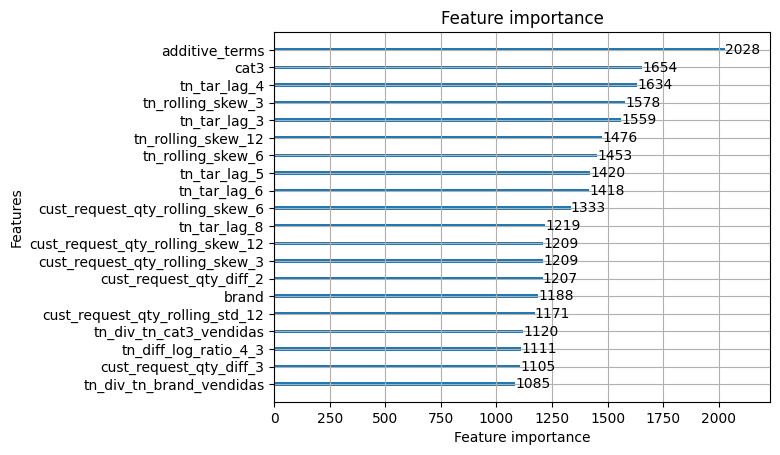

In [2]:
pipeline = Pipeline(
    steps=[
        LoadDataFrameStep("df_intermedio.parquet"),
        GroupByProductStep(),
        #FilterProductsIDStep(dfs=["df"]),
        #FilterDatasetByColumn(column="cat1", value="FOODS"),
        DateRelatedFeaturesStep(),
        #Log1pTranformation(),
        #CreateTargetColumDiffStep(target_col="tn"),
        #CreateTargetColumStep(target_col="tn"),
        SplitDataFrameStep2(df="df", test_date=33, gap=1),
        CreateResidualTargetStep(target_col="tn", window=3),

        DiffLogRatioFeatureStep(period=1, window=3, column="tn"),
        DiffLogRatioFeatureStep(period=2, window=3, column="tn"),
        DiffLogRatioFeatureStep(period=3, window=3, column="tn"),
        DiffLogRatioFeatureStep(period=4, window=3, column="tn"),
        TechnicalAnalysisFeaturesStep(),

        ProphetFeatureExtractionStep(),
        ReduceMemoryUsageStep(),

        #ReduceMemoryUsageStep(),
        FeatureEngineeringLagStep(lags=list(range(1,25)), columns=["tn", "cust_request_qty", "stock_final"]),
        #FeatureEngineeringLagStep(lags=[1,2,3,5,11], columns=["tn", "cust_request_qty", "stock_final"]),
        RollingMeanFeatureStep(window=3, columns=["tn", "cust_request_qty", "stock_final"]),
        RollingMaxFeatureStep(window=3, columns=["tn", "cust_request_qty", "stock_final"]),
        RollingMinFeatureStep(window=3, columns=["tn", "cust_request_qty", "stock_final"]),
        RollingMeanFeatureStep(window=9, columns=["tn", "cust_request_qty", "stock_final"]),
        RollingMaxFeatureStep(window=9, columns=["tn", "cust_request_qty", "stock_final"]),
        RollingMinFeatureStep(window=9, columns=["tn", "cust_request_qty", "stock_final"]),

        ReduceMemoryUsageStep(),

        RollingStdFeatureStep(window=3, columns=["tn", "cust_request_qty"]),
        RollingStdFeatureStep(window=6, columns=["tn", "cust_request_qty"]),
        RollingStdFeatureStep(window=12, columns=["tn", "cust_request_qty"]), 

        RollingSkewFeatureStep(window=3, columns=["tn", "cust_request_qty"]),
        RollingSkewFeatureStep(window=6, columns=["tn", "cust_request_qty"]),
        RollingSkewFeatureStep(window=12, columns=["tn", "cust_request_qty"]),
        ReduceMemoryUsageStep(),

        RollingZscoreFeatureStep(window=3, columns=["tn", "cust_request_qty"]),
        RollingZscoreFeatureStep(window=6, columns=["tn", "cust_request_qty"]),
        RollingZscoreFeatureStep(window=12, columns=["tn", "cust_request_qty"]),

        DiffFeatureStep(periods=1, columns=["tn", "cust_request_qty", "stock_final"]),
        DiffFeatureStep(periods=2, columns=["tn", "cust_request_qty", "stock_final"]),
        DiffFeatureStep(periods=3, columns=["tn", "cust_request_qty", "stock_final"]),
        DiffFeatureStep(periods=4, columns=["tn", "cust_request_qty", "stock_final"]),
        DiffFeatureStep(periods=5, columns=["tn", "cust_request_qty", "stock_final"]),
        DiffFeatureStep(periods=11, columns=["tn", "cust_request_qty", "stock_final"]),
        FeatureEngineeringProductCatInteractionStep(cat="cat1", tn="tn"),
        FeatureEngineeringProductCatInteractionStep(cat="cat2", tn="tn"),
        FeatureEngineeringProductCatInteractionStep(cat="cat3", tn="tn"),
        #FeatureEngineeringProductCatInteractionStep(cat="product_id", tn="tn"),

        CreateTotalCategoryStep(cat="cat1"),
        CreateTotalCategoryStep(cat="cat2"),
        CreateTotalCategoryStep(cat="cat3"),
        CreateTotalCategoryStep(cat="brand"),
        CreateTotalCategoryStep(cat="customer_id"),
        CreateTotalCategoryStep(cat="product_id"),
                
        #CreateTotalCategoryStep(cat="cat1", tn="stock_final"),
        #CreateTotalCategoryStep(cat="cat2", tn="stock_final"),
        #CreateTotalCategoryStep(cat="cat3", tn="stock_final"),

        ReduceMemoryUsageStep(),
        FeatureDivInteractionStep(columns=[
                ("tn", "tn_cat1_vendidas"), 
                ("tn", "tn_cat2_vendidas"), 
                ("tn", "tn_cat3_vendidas"), 
                ("tn", "tn_brand_vendidas")]
        ),
        ReduceMemoryUsageStep(),

        FeatureProdInteractionStep(columns=[("tn", "cust_request_qty")]),
        CreateWeightByCustomerStep(),
        CreateWeightByProductStep(),
        ReduceMemoryUsageStep(),
        DeleteBadColumns(),
        #CopyColumnAsWeightStep(column="product_weight"),
        #WeightedProductIdStep(product_weights=product_id_weights),
        TimeDecayWeghtedProductIdStep(decay_factor=0.99),
        #SaveDataFrameStep(df_name="df", file_name="df_fe_light.pickle"),

        OptunaObjectiveStep(
            pipeline_to_optimize=Pipeline(steps=[
                SplitDataFrameStep2(df="df", test_date=29, gap=1),
                ScaleFeatureStep(column="target", override=True),
                FeatureEngineeringLagStep(lags=list(range(2,20)), columns=["target"], column_rename="tn_tar"),

                PrepareXYStep(),
                TrainModelStep(),
                PredictStep(),
                InverseScalePredictionsStep(),
                InverseResidualTargetStep(),

                IntegratePredictionsStep(),
                EvaluatePredictionsSteps(filter_file="product_id_apredecir201912.txt"),
            ],
            optimize_arftifacts_memory=False),
            feature_selection=False,
            n_trials=150
        ),
        ScaleFeatureStep(column="target", override=True),
        FeatureEngineeringLagStep(lags=list(range(2,20)), columns=["target"], column_rename="tn_tar"),
        PrepareXYStep(),
        TrainModelStep(),
        PredictStep(),
        InverseScalePredictionsStep(),
        InverseResidualTargetStep(),

        IntegratePredictionsStep(),
        EvaluatePredictionsSteps(filter_file="product_id_apredecir201912.txt"),
        PlotFeatureImportanceStep(),
        KaggleSubmissionStep(experiment="test_light_df", filter_file="product_id_apredecir201912.txt"),
        #SaveSubmissionStep(exp_name="test_new_pipeline_150features"),


    ],
    optimize_arftifacts_memory=True
)

pipeline.run()




In [9]:
# TODO: probar primero escalar y despues targetear (hacer una feature del target que sea el target shift(2))
pipeline.get_artifact("df")[["target", "tn"]]

,target,tn
0,NaN,-1.501484
1,NaN,-1.948379
2,-1.613740,-0.301064
3,-1.510577,-1.061112
4,-0.813390,0.348076
...,...,...
31517,NaN,0.000000
31518,NaN,0.000000
31519,NaN,0.000000
31520,NaN,0.000000


In [3]:
pipeline.artifacts

{'df': '/tmp/df',
 'train_index': '/tmp/train_index',
 'test_index': '/tmp/test_index',
 'train_scaler_index': '/tmp/train_scaler_index',
 'target_col': '/tmp/target_col',
 'params': '/tmp/params',
 'scaler_tn': '/tmp/scaler_tn',
 'features': '/tmp/features',
 'targets': '/tmp/targets',
 'X_train': '/tmp/X_train',
 'y_train': '/tmp/y_train',
 'X_test': '/tmp/X_test',
 'y_test': '/tmp/y_test',
 'weights': '/tmp/weights',
 'model': '/tmp/model',
 'predictions': '/tmp/predictions',
 'eval_df': '/tmp/eval_df',
 'eval_df_total': '/tmp/eval_df_total',
 'total_error': '/tmp/total_error',
 'submissiontest_light_df': '/tmp/submissiontest_light_df'}

In [3]:
params = pipeline.get_artifact("params")

In [4]:
params

{'learning_rate': 0.056235561048668246,
 'num_leaves': 792,
 'max_depth': 11,
 'min_child_samples': 12,
 'subsample': 0.8308072136612201,
 'colsample_bytree': 0.7830837234170929,
 'reg_alpha': 0.9043433402712845,
 'reg_lambda': 0.01742295972971713,
 'min_split_gain': 0.05778782005801939,
 'max_bin': 579,
 'feature_fraction': 0.9261437126762373,
 'bagging_fraction': 0.5773595832980399,
 'extra_trees': False,
 'bagging_freq': 80,
 'n_estimators': 3286}

In [ ]:
params = {'learning_rate': 0.09249276920204523,
 'num_leaves': 17,
 'max_depth': 18,
 'min_child_samples': 139,
 'subsample': 0.8665108176379659,
 'colsample_bytree': 0.7445887789494118,
 'reg_alpha': 0.0909029253091313,
 'reg_lambda': 0.22154388770108127,
 'min_split_gain': 0.0033066931135108304,
 'max_bin': 348,
 'feature_fraction': 0.14374611747734473,
 'bagging_fraction': 0.8972458727623152,
 'extra_trees': False,
 'bagging_freq': 45,
 'n_estimators': 2718}

Executing step: LoadDataFrameStep
Step LoadDataFrameStep completed in 2.34 seconds
Executing step: GroupByProductStep
Step GroupByProductStep completed in 2.01 seconds
Executing step: DateRelatedFeaturesStep
Step DateRelatedFeaturesStep completed in 0.04 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.01 seconds
Executing step: CreateResidualTargetStep
Step CreateResidualTargetStep completed in 0.26 seconds
Executing step: DiffLogRatioFeatureStep
Step DiffLogRatioFeatureStep completed in 0.34 seconds
Executing step: DiffLogRatioFeatureStep
Step DiffLogRatioFeatureStep completed in 0.30 seconds
Executing step: DiffLogRatioFeatureStep
Step DiffLogRatioFeatureStep completed in 0.35 seconds
Executing step: DiffLogRatioFeatureStep
Step DiffLogRatioFeatureStep completed in 0.34 seconds
Executing step: TechnicalAnalysisFeaturesStep
Step TechnicalAnalysisFeaturesStep completed in 32.18 seconds
Executing step: ProphetFeatureExtractionStep


Extracting Prophet features:   0%|          | 0/1233 [00:00<?, ?it/s]17:06:17 - cmdstanpy - INFO - Chain [1] start processing
17:06:17 - cmdstanpy - INFO - Chain [1] done processing
Extracting Prophet features:   0%|          | 1/1233 [00:00<04:40,  4.40it/s]17:06:17 - cmdstanpy - INFO - Chain [1] start processing
17:06:18 - cmdstanpy - INFO - Chain [1] done processing
Extracting Prophet features:   0%|          | 2/1233 [00:00<04:19,  4.75it/s]17:06:18 - cmdstanpy - INFO - Chain [1] start processing
17:06:18 - cmdstanpy - INFO - Chain [1] done processing
Extracting Prophet features:   0%|          | 3/1233 [00:00<04:18,  4.76it/s]17:06:18 - cmdstanpy - INFO - Chain [1] start processing
17:06:18 - cmdstanpy - INFO - Chain [1] done processing
Extracting Prophet features:   0%|          | 4/1233 [00:00<05:19,  3.85it/s]17:06:18 - cmdstanpy - INFO - Chain [1] start processing
17:06:18 - cmdstanpy - INFO - Chain [1] done processing
Extracting Prophet features:   0%|          | 5/1233 [00:0

Step ProphetFeatureExtractionStep completed in 216.40 seconds
Executing step: ReduceMemoryUsageStep
--- Memory usage before: 11.82 MB
--- Memory usage after: 3.43 MB
--- Decreased memory usage by 71.0%

Step ReduceMemoryUsageStep completed in 0.04 seconds
Executing step: FeatureEngineeringLagStep
Step FeatureEngineeringLagStep completed in 0.07 seconds
Executing step: RollingMeanFeatureStep
Step RollingMeanFeatureStep completed in 0.81 seconds
Executing step: RollingMaxFeatureStep
Step RollingMaxFeatureStep completed in 0.72 seconds
Executing step: RollingMinFeatureStep
Step RollingMinFeatureStep completed in 0.58 seconds
Executing step: RollingMeanFeatureStep
Step RollingMeanFeatureStep completed in 0.59 seconds
Executing step: RollingMaxFeatureStep
Step RollingMaxFeatureStep completed in 0.82 seconds
Executing step: RollingMinFeatureStep
Step RollingMinFeatureStep completed in 0.72 seconds
Executing step: ReduceMemoryUsageStep
--- Memory usage before: 16.41 MB
--- Memory usage after:

/home/fede/programacion/labo3/pipeline/steps/processing.py:516: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col1}_div_{col2}"] = df[col1] / (df[col2] + 1e-6)  # Evitar división por cero
/home/fede/programacion/labo3/pipeline/steps/processing.py:516: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col1}_div_{col2}"] = df[col1] / (df[col2] + 1e-6)  # Evitar división por cero
/home/fede/programacion/labo3/pipeline/steps/processing.py:516: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of

--- Memory usage before: 18.58 MB
--- Memory usage after: 18.58 MB
--- Decreased memory usage by 0.0%

Step ReduceMemoryUsageStep completed in 0.29 seconds
Executing step: FeatureProdInteractionStep
Step FeatureProdInteractionStep completed in 0.04 seconds
Executing step: CreateWeightByCustomerStep
Step CreateWeightByCustomerStep completed in 0.05 seconds
Executing step: CreateWeightByProductStep
Step CreateWeightByProductStep completed in 0.04 seconds
Executing step: ReduceMemoryUsageStep


/home/fede/programacion/labo3/pipeline/steps/processing.py:527: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col1}_prod_{col2}"] = df[col1] * df[col2]


--- Memory usage before: 19.24 MB
--- Memory usage after: 19.00 MB
--- Decreased memory usage by 1.2%

Step ReduceMemoryUsageStep completed in 0.32 seconds
Executing step: DeleteBadColumns
Deleted columns: {'stock_final_lag_19', 'stock_final_lag_24', 'stock_final_lag_22', 'stock_final_lag_20', 'stock_final_lag_17', 'stock_final_lag_15', 'stock_final_lag_16', 'stock_final_lag_21', 'stock_final_lag_23', 'stock_final_lag_18'}
Step DeleteBadColumns completed in 0.14 seconds
Executing step: TimeDecayWeghtedProductIdStep
Step TimeDecayWeghtedProductIdStep completed in 0.04 seconds
Executing step: ScaleFeatureStep


/home/fede/programacion/labo3/pipeline/steps/processing.py:506: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['weight'] = df['date_id'].map(date_weights).fillna(0.0)
/home/fede/programacion/labo3/pipeline/steps/processing.py:167: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{c}_lag_{lag}"] = grouped[column].shift(lag)
/home/fede/programacion/labo3/pipeline/steps/processing.py:167: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

Step ScaleFeatureStep completed in 0.08 seconds
Executing step: FeatureEngineeringLagStep
Step FeatureEngineeringLagStep completed in 0.09 seconds
Executing step: PrepareXYStep
X_train indexes: Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
       ...
       31512, 31513, 31514, 31515, 31516, 31517, 31518, 31519, 31520, 31521],
      dtype='int64', length=27764)
(31522, 320)
Step PrepareXYStep completed in 0.13 seconds
Executing step: TrainModelStep
Validation set size: 877
X_eval first 5 rows:
     product_id  cust_request_qty  cust_request_tn      tn  stock_final  \
33        20001               367           1588.0  1562.0    185.25000   
69        20002               312           2013.0  1980.0     25.40625   
105       20003               404           1092.0  1081.0    659.00000   
141       20004               508           1078.0  1065.0   1146.00000   
177       20005               418           1041.0   997.0    876.00000   

      cat1         

/home/fede/.venvs/labo3/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


[100]	valid_0's l2: 1.14023	valid_0's total_error: 0.938384
[200]	valid_0's l2: 1.11758	valid_0's total_error: 0.933063
[300]	valid_0's l2: 1.09537	valid_0's total_error: 0.924263
[400]	valid_0's l2: 1.09617	valid_0's total_error: 0.924325
[500]	valid_0's l2: 1.09325	valid_0's total_error: 0.923219
[600]	valid_0's l2: 1.09325	valid_0's total_error: 0.923219
[700]	valid_0's l2: 1.09325	valid_0's total_error: 0.923219
[800]	valid_0's l2: 1.09325	valid_0's total_error: 0.923219
[900]	valid_0's l2: 1.09325	valid_0's total_error: 0.923219
[1000]	valid_0's l2: 1.09325	valid_0's total_error: 0.923219
[1100]	valid_0's l2: 1.09325	valid_0's total_error: 0.923219
[1200]	valid_0's l2: 1.09325	valid_0's total_error: 0.923219
[1300]	valid_0's l2: 1.09325	valid_0's total_error: 0.923219
[1400]	valid_0's l2: 1.09325	valid_0's total_error: 0.923219
[1500]	valid_0's l2: 1.09325	valid_0's total_error: 0.923219
[1600]	valid_0's l2: 1.09325	valid_0's total_error: 0.923219
[1700]	valid_0's l2: 1.09325	vali

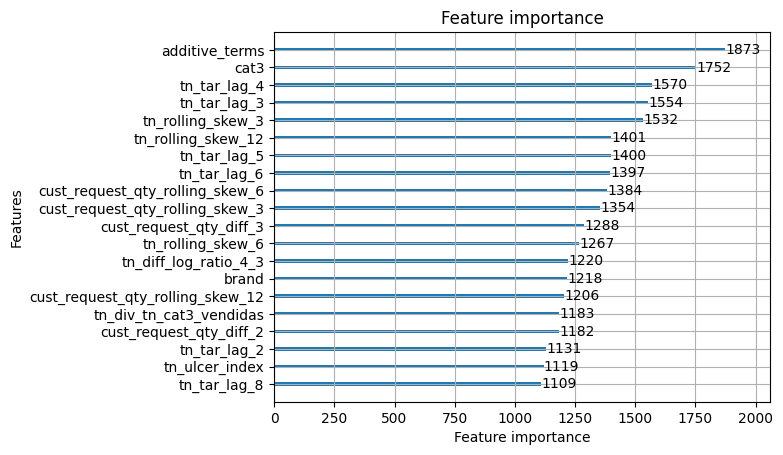

In [9]:



pipeline = Pipeline(
    steps=[
        LoadDataFrameStep("df_intermedio.parquet"),
        GroupByProductStep(),
        #FilterProductsIDStep(dfs=["df"]),
        #FilterDatasetByColumn(column="cat1", value="FOODS"),
        DateRelatedFeaturesStep(),
        #Log1pTranformation(),
        #CreateTargetColumDiffStep(target_col="tn"),
        #CreateTargetColumStep(target_col="tn"),
        SplitDataFrameStep2(df="df", test_date=33, gap=1),
        CreateResidualTargetStep(target_col="tn", window=3),

        DiffLogRatioFeatureStep(period=1, window=3, column="tn"),
        DiffLogRatioFeatureStep(period=2, window=3, column="tn"),
        DiffLogRatioFeatureStep(period=3, window=3, column="tn"),
        DiffLogRatioFeatureStep(period=4, window=3, column="tn"),
        TechnicalAnalysisFeaturesStep(),

        ProphetFeatureExtractionStep(),
        ReduceMemoryUsageStep(),

        #ReduceMemoryUsageStep(),
        FeatureEngineeringLagStep(lags=list(range(1,25)), columns=["tn", "cust_request_qty", "stock_final"]),
        #FeatureEngineeringLagStep(lags=[1,2,3,5,11], columns=["tn", "cust_request_qty", "stock_final"]),
        RollingMeanFeatureStep(window=3, columns=["tn", "cust_request_qty", "stock_final"]),
        RollingMaxFeatureStep(window=3, columns=["tn", "cust_request_qty", "stock_final"]),
        RollingMinFeatureStep(window=3, columns=["tn", "cust_request_qty", "stock_final"]),
        RollingMeanFeatureStep(window=9, columns=["tn", "cust_request_qty", "stock_final"]),
        RollingMaxFeatureStep(window=9, columns=["tn", "cust_request_qty", "stock_final"]),
        RollingMinFeatureStep(window=9, columns=["tn", "cust_request_qty", "stock_final"]),

        ReduceMemoryUsageStep(),

        RollingStdFeatureStep(window=3, columns=["tn", "cust_request_qty"]),
        RollingStdFeatureStep(window=6, columns=["tn", "cust_request_qty"]),
        RollingStdFeatureStep(window=12, columns=["tn", "cust_request_qty"]), 

        RollingSkewFeatureStep(window=3, columns=["tn", "cust_request_qty"]),
        RollingSkewFeatureStep(window=6, columns=["tn", "cust_request_qty"]),
        RollingSkewFeatureStep(window=12, columns=["tn", "cust_request_qty"]),
        ReduceMemoryUsageStep(),

        RollingZscoreFeatureStep(window=3, columns=["tn", "cust_request_qty"]),
        RollingZscoreFeatureStep(window=6, columns=["tn", "cust_request_qty"]),
        RollingZscoreFeatureStep(window=12, columns=["tn", "cust_request_qty"]),

        DiffFeatureStep(periods=1, columns=["tn", "cust_request_qty", "stock_final"]),
        DiffFeatureStep(periods=2, columns=["tn", "cust_request_qty", "stock_final"]),
        DiffFeatureStep(periods=3, columns=["tn", "cust_request_qty", "stock_final"]),
        DiffFeatureStep(periods=4, columns=["tn", "cust_request_qty", "stock_final"]),
        DiffFeatureStep(periods=5, columns=["tn", "cust_request_qty", "stock_final"]),
        DiffFeatureStep(periods=11, columns=["tn", "cust_request_qty", "stock_final"]),
        FeatureEngineeringProductCatInteractionStep(cat="cat1", tn="tn"),
        FeatureEngineeringProductCatInteractionStep(cat="cat2", tn="tn"),
        FeatureEngineeringProductCatInteractionStep(cat="cat3", tn="tn"),
        #FeatureEngineeringProductCatInteractionStep(cat="product_id", tn="tn"),

        CreateTotalCategoryStep(cat="cat1"),
        CreateTotalCategoryStep(cat="cat2"),
        CreateTotalCategoryStep(cat="cat3"),
        CreateTotalCategoryStep(cat="brand"),
        CreateTotalCategoryStep(cat="customer_id"),
        CreateTotalCategoryStep(cat="product_id"),
                
        #CreateTotalCategoryStep(cat="cat1", tn="stock_final"),
        #CreateTotalCategoryStep(cat="cat2", tn="stock_final"),
        #CreateTotalCategoryStep(cat="cat3", tn="stock_final"),

        ReduceMemoryUsageStep(),
        FeatureDivInteractionStep(columns=[
                ("tn", "tn_cat1_vendidas"), 
                ("tn", "tn_cat2_vendidas"), 
                ("tn", "tn_cat3_vendidas"), 
                ("tn", "tn_brand_vendidas")]
        ),
        ReduceMemoryUsageStep(),

        FeatureProdInteractionStep(columns=[("tn", "cust_request_qty")]),
        CreateWeightByCustomerStep(),
        CreateWeightByProductStep(),
        ReduceMemoryUsageStep(),
        DeleteBadColumns(),
        #CopyColumnAsWeightStep(column="product_weight"),
        #WeightedProductIdStep(product_weights=product_id_weights),
        TimeDecayWeghtedProductIdStep(decay_factor=0.99),
        #SaveDataFrameStep(df_name="df", file_name="df_fe_light.pickle"),
        ScaleFeatureStep(column="target", override=True),
        FeatureEngineeringLagStep(lags=list(range(2,20)), columns=["target"], column_rename="tn_tar"),
        PrepareXYStep(),
        TrainModelStep(params=params),
        PredictStep(),
        InverseScalePredictionsStep(),
        InverseResidualTargetStep(),

        IntegratePredictionsStep(),
        EvaluatePredictionsSteps(filter_file="product_id_apredecir201912.txt"),
        PlotFeatureImportanceStep(),
        KaggleSubmissionStep(experiment="test_light_df", filter_file="product_id_apredecir201912.txt"),
        #SaveSubmissionStep(exp_name="test_new_pipeline_150features"),


    ],
    optimize_arftifacts_memory=True
)

pipeline.run()



In [10]:
model = pipeline.get_artifact("model")
# print feature importance
if type(model.model.model) is lgb.Booster:
    feature_importance = pd.DataFrame({
        "feature": model.model.model.feature_name(),
        "importance": model.model.model.feature_importance(importance_type='gain')
    })
    feature_importance = feature_importance.sort_values(by="importance", ascending=False)
print(feature_importance.to_string())

                                feature   importance
301                        tn_tar_lag_4  6342.151983
7                                  cat3  4102.553245
45                       additive_terms  3400.720529
8                                 brand  2679.050314
300                        tn_tar_lag_3  2418.939351
34                       tn_ulcer_index  2279.276848
171                       tn_cat1_FOODS  2237.772566
230                 tn_cat3_Jabon_Barba  1887.511244
305                        tn_tar_lag_8  1769.305054
304                        tn_tar_lag_7  1625.236284
303                        tn_tar_lag_6  1588.073964
284                    tn_cat2_vendidas  1319.300635
160             cust_request_qty_diff_3  1306.078425
302                        tn_tar_lag_5  1234.637052
157             cust_request_qty_diff_2  1196.371494
143                   tn_rolling_skew_6  1195.234139
291             tn_div_tn_cat3_vendidas  1180.511542
145                  tn_rolling_skew_12  1174.

Executing step: LoadDataFrameStep
Step LoadDataFrameStep completed in 2.01 seconds
Executing step: GroupByProductStep
Step GroupByProductStep completed in 2.21 seconds
Executing step: DateRelatedFeaturesStep
Step DateRelatedFeaturesStep completed in 0.04 seconds
Executing step: SplitDataFrameStep2
Step SplitDataFrameStep2 completed in 0.01 seconds
Executing step: CreateResidualTargetStep
Step CreateResidualTargetStep completed in 0.28 seconds
Executing step: DiffLogRatioFeatureStep
Step DiffLogRatioFeatureStep completed in 0.35 seconds
Executing step: DiffLogRatioFeatureStep
Step DiffLogRatioFeatureStep completed in 0.38 seconds
Executing step: DiffLogRatioFeatureStep
Step DiffLogRatioFeatureStep completed in 0.36 seconds
Executing step: DiffLogRatioFeatureStep
Step DiffLogRatioFeatureStep completed in 0.36 seconds
Executing step: TechnicalAnalysisFeaturesStep
Step TechnicalAnalysisFeaturesStep completed in 29.64 seconds
Executing step: ProphetFeatureExtractionStep


Extracting Prophet features:   0%|          | 0/1233 [00:00<?, ?it/s]17:13:02 - cmdstanpy - INFO - Chain [1] start processing
17:13:02 - cmdstanpy - INFO - Chain [1] done processing
Extracting Prophet features:   0%|          | 1/1233 [00:00<09:35,  2.14it/s]17:13:02 - cmdstanpy - INFO - Chain [1] start processing
17:13:02 - cmdstanpy - INFO - Chain [1] done processing
Extracting Prophet features:   0%|          | 2/1233 [00:00<07:07,  2.88it/s]17:13:03 - cmdstanpy - INFO - Chain [1] start processing
17:13:03 - cmdstanpy - INFO - Chain [1] done processing
Extracting Prophet features:   0%|          | 3/1233 [00:00<06:14,  3.29it/s]17:13:03 - cmdstanpy - INFO - Chain [1] start processing
17:13:03 - cmdstanpy - INFO - Chain [1] done processing
Extracting Prophet features:   0%|          | 4/1233 [00:01<06:39,  3.08it/s]17:13:03 - cmdstanpy - INFO - Chain [1] start processing
17:13:03 - cmdstanpy - INFO - Chain [1] done processing
Extracting Prophet features:   0%|          | 5/1233 [00:0

Step ProphetFeatureExtractionStep completed in 264.01 seconds
Executing step: ReduceMemoryUsageStep
--- Memory usage before: 11.82 MB
--- Memory usage after: 3.43 MB
--- Decreased memory usage by 71.0%

Step ReduceMemoryUsageStep completed in 0.05 seconds
Executing step: FeatureEngineeringLagStep
Step FeatureEngineeringLagStep completed in 0.07 seconds
Executing step: RollingMeanFeatureStep
Step RollingMeanFeatureStep completed in 0.89 seconds
Executing step: RollingMaxFeatureStep
Step RollingMaxFeatureStep completed in 0.60 seconds
Executing step: RollingMinFeatureStep
Step RollingMinFeatureStep completed in 0.62 seconds
Executing step: RollingMeanFeatureStep
Step RollingMeanFeatureStep completed in 0.88 seconds
Executing step: RollingMaxFeatureStep
Step RollingMaxFeatureStep completed in 0.72 seconds
Executing step: RollingMinFeatureStep
Step RollingMinFeatureStep completed in 0.66 seconds
Executing step: ReduceMemoryUsageStep
--- Memory usage before: 16.41 MB
--- Memory usage after:

/home/fede/programacion/labo3/pipeline/steps/processing.py:516: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col1}_div_{col2}"] = df[col1] / (df[col2] + 1e-6)  # Evitar división por cero
/home/fede/programacion/labo3/pipeline/steps/processing.py:516: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col1}_div_{col2}"] = df[col1] / (df[col2] + 1e-6)  # Evitar división por cero
/home/fede/programacion/labo3/pipeline/steps/processing.py:516: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of

--- Memory usage before: 18.58 MB
--- Memory usage after: 18.58 MB
--- Decreased memory usage by 0.0%

Step ReduceMemoryUsageStep completed in 0.32 seconds
Executing step: FeatureProdInteractionStep
Step FeatureProdInteractionStep completed in 0.04 seconds
Executing step: CreateWeightByCustomerStep
Step CreateWeightByCustomerStep completed in 0.05 seconds
Executing step: CreateWeightByProductStep
Step CreateWeightByProductStep completed in 0.04 seconds
Executing step: ReduceMemoryUsageStep


/home/fede/programacion/labo3/pipeline/steps/processing.py:527: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col1}_prod_{col2}"] = df[col1] * df[col2]


--- Memory usage before: 19.24 MB
--- Memory usage after: 19.00 MB
--- Decreased memory usage by 1.2%

Step ReduceMemoryUsageStep completed in 0.35 seconds
Executing step: DeleteBadColumns
Deleted columns: {'stock_final_lag_19', 'stock_final_lag_24', 'stock_final_lag_22', 'stock_final_lag_20', 'stock_final_lag_17', 'stock_final_lag_15', 'stock_final_lag_16', 'stock_final_lag_21', 'stock_final_lag_23', 'stock_final_lag_18'}
Step DeleteBadColumns completed in 0.15 seconds
Executing step: TimeDecayWeghtedProductIdStep


/home/fede/programacion/labo3/pipeline/steps/processing.py:506: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['weight'] = df['date_id'].map(date_weights).fillna(0.0)
/home/fede/programacion/labo3/pipeline/steps/processing.py:167: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{c}_lag_{lag}"] = grouped[column].shift(lag)
/home/fede/programacion/labo3/pipeline/steps/processing.py:167: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

Step TimeDecayWeghtedProductIdStep completed in 0.03 seconds
Executing step: ScaleFeatureStep
Step ScaleFeatureStep completed in 0.09 seconds
Executing step: FeatureEngineeringLagStep
Step FeatureEngineeringLagStep completed in 0.09 seconds
Executing step: PrepareXYStep
X_train indexes: Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
       ...
       31512, 31513, 31514, 31515, 31516, 31517, 31518, 31519, 31520, 31521],
      dtype='int64', length=29652)
(31522, 320)
Step PrepareXYStep completed in 0.17 seconds
Executing step: TrainModelStep
Validation set size: 0
Step TrainModelStep completed in 106.35 seconds
Executing step: PredictStep
Step PredictStep completed in 0.12 seconds
Executing step: InverseScalePredictionsStep
Step InverseScalePredictionsStep completed in 0.09 seconds
Executing step: InverseResidualTargetStep
Step InverseResidualTargetStep completed in 0.31 seconds
Executing step: IntegratePredictionsStep
Step IntegratePredictionsStep complet

/home/fede/programacion/labo3/pipeline/steps/results.py:38: RuntimeWarning: divide by zero encountered in scalar divide
  total_error = np.sum(np.abs(eval_df['tn_real'] - eval_df['tn_pred'])) / np.sum(eval_df['tn_real'])


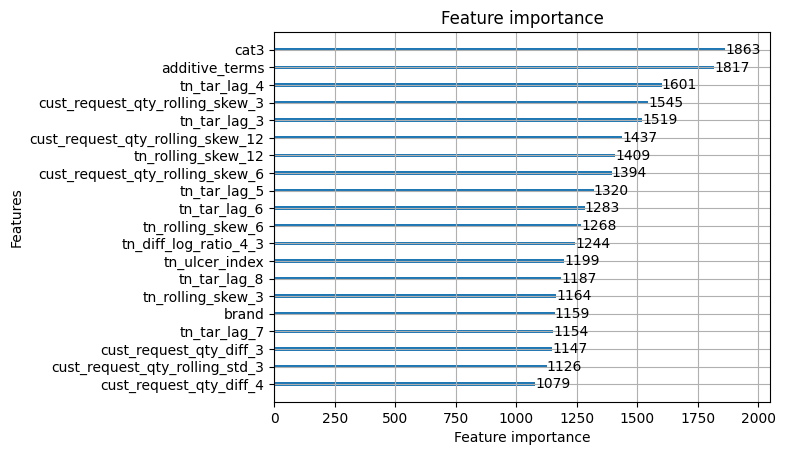

In [11]:

pipeline = Pipeline(
    steps=[
        LoadDataFrameStep("df_intermedio.parquet"),
        GroupByProductStep(),
        #FilterProductsIDStep(dfs=["df"]),
        #FilterDatasetByColumn(column="cat1", value="FOODS"),
        DateRelatedFeaturesStep(),
        #Log1pTranformation(),
        #CreateTargetColumDiffStep(target_col="tn"),
        #CreateTargetColumStep(target_col="tn"),
        SplitDataFrameStep2(df="df", test_date=35, gap=1),
        CreateResidualTargetStep(target_col="tn", window=3),

        DiffLogRatioFeatureStep(period=1, window=3, column="tn"),
        DiffLogRatioFeatureStep(period=2, window=3, column="tn"),
        DiffLogRatioFeatureStep(period=3, window=3, column="tn"),
        DiffLogRatioFeatureStep(period=4, window=3, column="tn"),
        TechnicalAnalysisFeaturesStep(),

        ProphetFeatureExtractionStep(),
        ReduceMemoryUsageStep(),

        #ReduceMemoryUsageStep(),
        FeatureEngineeringLagStep(lags=list(range(1,25)), columns=["tn", "cust_request_qty", "stock_final"]),
        #FeatureEngineeringLagStep(lags=[1,2,3,5,11], columns=["tn", "cust_request_qty", "stock_final"]),
        RollingMeanFeatureStep(window=3, columns=["tn", "cust_request_qty", "stock_final"]),
        RollingMaxFeatureStep(window=3, columns=["tn", "cust_request_qty", "stock_final"]),
        RollingMinFeatureStep(window=3, columns=["tn", "cust_request_qty", "stock_final"]),
        RollingMeanFeatureStep(window=9, columns=["tn", "cust_request_qty", "stock_final"]),
        RollingMaxFeatureStep(window=9, columns=["tn", "cust_request_qty", "stock_final"]),
        RollingMinFeatureStep(window=9, columns=["tn", "cust_request_qty", "stock_final"]),

        ReduceMemoryUsageStep(),

        RollingStdFeatureStep(window=3, columns=["tn", "cust_request_qty"]),
        RollingStdFeatureStep(window=6, columns=["tn", "cust_request_qty"]),
        RollingStdFeatureStep(window=12, columns=["tn", "cust_request_qty"]), 

        RollingSkewFeatureStep(window=3, columns=["tn", "cust_request_qty"]),
        RollingSkewFeatureStep(window=6, columns=["tn", "cust_request_qty"]),
        RollingSkewFeatureStep(window=12, columns=["tn", "cust_request_qty"]),
        ReduceMemoryUsageStep(),

        RollingZscoreFeatureStep(window=3, columns=["tn", "cust_request_qty"]),
        RollingZscoreFeatureStep(window=6, columns=["tn", "cust_request_qty"]),
        RollingZscoreFeatureStep(window=12, columns=["tn", "cust_request_qty"]),

        DiffFeatureStep(periods=1, columns=["tn", "cust_request_qty", "stock_final"]),
        DiffFeatureStep(periods=2, columns=["tn", "cust_request_qty", "stock_final"]),
        DiffFeatureStep(periods=3, columns=["tn", "cust_request_qty", "stock_final"]),
        DiffFeatureStep(periods=4, columns=["tn", "cust_request_qty", "stock_final"]),
        DiffFeatureStep(periods=5, columns=["tn", "cust_request_qty", "stock_final"]),
        DiffFeatureStep(periods=11, columns=["tn", "cust_request_qty", "stock_final"]),
        FeatureEngineeringProductCatInteractionStep(cat="cat1", tn="tn"),
        FeatureEngineeringProductCatInteractionStep(cat="cat2", tn="tn"),
        FeatureEngineeringProductCatInteractionStep(cat="cat3", tn="tn"),
        #FeatureEngineeringProductCatInteractionStep(cat="product_id", tn="tn"),

        CreateTotalCategoryStep(cat="cat1"),
        CreateTotalCategoryStep(cat="cat2"),
        CreateTotalCategoryStep(cat="cat3"),
        CreateTotalCategoryStep(cat="brand"),
        CreateTotalCategoryStep(cat="customer_id"),
        CreateTotalCategoryStep(cat="product_id"),
                
        #CreateTotalCategoryStep(cat="cat1", tn="stock_final"),
        #CreateTotalCategoryStep(cat="cat2", tn="stock_final"),
        #CreateTotalCategoryStep(cat="cat3", tn="stock_final"),

        ReduceMemoryUsageStep(),
        FeatureDivInteractionStep(columns=[
                ("tn", "tn_cat1_vendidas"), 
                ("tn", "tn_cat2_vendidas"), 
                ("tn", "tn_cat3_vendidas"), 
                ("tn", "tn_brand_vendidas")]
        ),
        ReduceMemoryUsageStep(),

        FeatureProdInteractionStep(columns=[("tn", "cust_request_qty")]),
        CreateWeightByCustomerStep(),
        CreateWeightByProductStep(),
        ReduceMemoryUsageStep(),
        DeleteBadColumns(),
        #CopyColumnAsWeightStep(column="product_weight"),
        #WeightedProductIdStep(product_weights=product_id_weights),
        TimeDecayWeghtedProductIdStep(decay_factor=0.99),
        #SaveDataFrameStep(df_name="df", file_name="df_fe_light.pickle"),
        ScaleFeatureStep(column="target", override=True),
        FeatureEngineeringLagStep(lags=list(range(2,20)), columns=["target"], column_rename="tn_tar"),
        PrepareXYStep(),
        TrainModelStep(params=params),
        PredictStep(),
        InverseScalePredictionsStep(),
        InverseResidualTargetStep(),

        IntegratePredictionsStep(),
        EvaluatePredictionsSteps(filter_file="product_id_apredecir201912.txt"),
        PlotFeatureImportanceStep(),
        KaggleSubmissionStep(experiment="test_light_df", filter_file="product_id_apredecir201912.txt"),
        #SaveSubmissionStep(exp_name="test_new_pipeline_150features"),


    ],
    optimize_arftifacts_memory=True
)

pipeline.run()


In [12]:
submission = pipeline.get_artifact("submissiontest_light_df")
submission.to_csv("submission_test_light_df_optuna_2bis.csv", index=False)

In [ ]:
eval_df_total = pipeline.get_artifact("eval_df")
eval_df_total

In [ ]:
eval_df = pipeline.get_artifact("eval_df")
# ordeno error_absoluto de mayor a menor
eval_df = eval_df.sort_values(by="error_absoluto", ascending=False)
top_20 = eval_df.head(100)
print(top_20.to_string())

In [ ]:
eval_df = pipeline.get_artifact("eval_df")
# ordeno error_absoluto de mayor a menor
eval_df = eval_df.sort_values(by="error_absoluto", ascending=False)
top_20 = eval_df.head(10)
# hago un grafico donde x es el tn_real y y es el tn_predicho y una linea punteada en y=x
import matplotlib.pyplot as plt
# si paso el mouse por arriba del punto me muestra el product_id y el error absoluto
plt.figure(figsize=(10, 6))
plt.scatter(top_20["tn_real"], top_20["tn_pred"], alpha=0.5)
plt.plot([0, top_20["tn_real"].max()], [0, top_20["tn_real"].max()], color='red', linestyle='--')
for i, row in top_20.iterrows():
    plt.annotate(f"ID: {row['product_id']}\nError: {row['error_absoluto']:.2f}", 
                 (row["tn_real"], row["tn_pred"]), 
                 textcoords="offset points", 
                 xytext=(0, 5), 
                 ha='center', fontsize=8)
plt.title("Top 20 Predicciones vs Realidad")
plt.xlabel("tn Real")
plt.ylabel("tn Predicho")
plt.grid()
plt.show()

In [ ]:
df = pipeline.get_artifact("df")
# filtro por product_id 20002 y hasta date_id 31, y ploteo tn y tn_pred (siendo un solo punto para date_id 31)
product_id = 20032
df_filtered = df[(df["product_id"] == product_id) & (df["date_id"] <= 35)]
# pongo en df_filtered loc de dat_id=31 el tn_pred de eval_df para el product_id 20002
df_filtered.loc[df_filtered["date_id"] == 35, "tn_pred"] = eval_df.loc[eval_df["product_id"] == product_id, "tn_pred"].values[0]
df_filtered = df_filtered.sort_values(by="date_id")
plt.figure(figsize=(10, 6))
plt.plot(df_filtered["date_id"], df_filtered["tn"], label="tn Real", marker='o')
plt.plot(df_filtered["date_id"], df_filtered["tn_pred"], label="tn Predicho", marker='x')
plt.title(f"Predicciones vs Realidad para Product ID {product_id}")
plt.xlabel("Date ID")
plt.ylabel("tn")
plt.legend()
plt.grid()
plt.show()

In [ ]:
df = pipeline.get_artifact("df")
df_filtered = df[(df["product_id"] == 20001) & (df["date_id"] <= 35)]
df_filtered[["product_id", "fecha", "date_id","tn", "target"]]

In [ ]:
# hace el test para saber si tn es estacionario para el product_id 20002
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    # Determinar si la serie es estacionaria
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] <= 0.05:
        print("La serie es estacionaria")
    else:
        print("La serie no es estacionaria")
test_stationarity(df_filtered["tn"])